# Задание 2.1 - Нейронные сети

В этом задании вы реализуете и натренируете настоящую нейроную сеть своими руками!

В некотором смысле это будет расширением прошлого задания - нам нужно просто составить несколько линейных классификаторов вместе!

<img src="https://i.redd.it/n9fgba8b0qr01.png" alt="Stack_more_layers" width="400px"/>

In [1]:
import numpy as np
import matplotlib.pyplot as plt

%matplotlib inline

%load_ext autoreload
%autoreload 2

In [2]:
from dataset import load_svhn, random_split_train_val
from gradient_check import check_layer_gradient, check_layer_param_gradient, check_model_gradient
from layers import FullyConnectedLayer, ReLULayer
from model import TwoLayerNet
from trainer import Trainer, Dataset
from optim import SGD, MomentumSGD
from metrics import multiclass_accuracy
from sklearn.model_selection import ParameterGrid

# Загружаем данные

И разделяем их на training и validation.

In [4]:
def prepare_for_neural_network(train_X, test_X):
    train_flat = train_X.reshape(train_X.shape[0], -1).astype(float) / 255.0
    test_flat = test_X.reshape(test_X.shape[0], -1).astype(float) / 255.0
    
    # Subtract mean
    mean_image = np.mean(train_flat, axis = 0)
    train_flat -= mean_image
    test_flat -= mean_image
    
    return train_flat, test_flat
    
train_X, train_y, test_X, test_y = load_svhn("data", max_train=10000, max_test=1000)    
train_X, test_X = prepare_for_neural_network(train_X, test_X)
# Split train into train and val
train_X, train_y, val_X, val_y = random_split_train_val(train_X, train_y, num_val = 1000)

# Как всегда, начинаем с кирпичиков

Мы будем реализовывать необходимые нам слои по очереди. Каждый слой должен реализовать:
- прямой проход (forward pass), который генерирует выход слоя по входу и запоминает необходимые данные
- обратный проход (backward pass), который получает градиент по выходу слоя и вычисляет градиент по входу и по параметрам

Начнем с ReLU, у которого параметров нет.

In [5]:
# TODO: Implement ReLULayer layer in layers.py
# Note: you'll need to copy implementation of the gradient_check function from the previous assignment

X = np.array([[1,-2,3],
              [-1, 2, 0.1]
              ])

assert check_layer_gradient(ReLULayer(), X)

Gradient check passed!


А теперь реализуем полносвязный слой (fully connected layer), у которого будет два массива параметров: W (weights) и B (bias).

Все параметры наши слои будут использовать для параметров специальный класс `Param`, в котором будут храниться значения параметров и градиенты этих параметров, вычисляемые во время обратного прохода.

Это даст возможность аккумулировать (суммировать) градиенты из разных частей функции потерь, например, из cross-entropy loss и regularization loss.

In [6]:
# TODO: Implement FullyConnected layer forward and backward methods
assert check_layer_gradient(FullyConnectedLayer(3, 4), X)
# TODO: Implement storing gradients for W and B
assert check_layer_param_gradient(FullyConnectedLayer(3, 4), X, 'W')
assert check_layer_param_gradient(FullyConnectedLayer(3, 4), X, 'B')

Gradient check passed!
Gradient check passed!
Gradient check passed!


## Создаем нейронную сеть

Теперь мы реализуем простейшую нейронную сеть с двумя полносвязным слоями и нелинейностью ReLU. Реализуйте функцию `compute_loss_and_gradients`, она должна запустить прямой и обратный проход через оба слоя для вычисления градиентов.

Не забудьте реализовать очистку градиентов в начале функции.

In [7]:
# TODO: In model.py, implement compute_loss_and_gradients function
model = TwoLayerNet(n_input = train_X.shape[1], n_output = 10, hidden_layer_size = 3, reg = 0)
loss = model.compute_loss_and_gradients(train_X[:2], train_y[:2])

# TODO Now implement backward pass and aggregate all of the params
check_model_gradient(model, train_X[:2], train_y[:2])

Checking gradient for FullyConnectedLayer1_W
Gradient check passed!
Checking gradient for FullyConnectedLayer1_B
Gradient check passed!
Checking gradient for FullyConnectedLayer2_W
Gradient check passed!
Checking gradient for FullyConnectedLayer2_B
Gradient check passed!


True

Теперь добавьте к модели регуляризацию - она должна прибавляться к loss и делать свой вклад в градиенты.

In [8]:
# TODO Now implement l2 regularization in the forward and backward pass
model_with_reg = TwoLayerNet(n_input = train_X.shape[1], n_output = 10, hidden_layer_size = 3, reg = 1e1)
loss_with_reg = model_with_reg.compute_loss_and_gradients(train_X[:2], train_y[:2])
assert loss_with_reg > loss and not np.isclose(loss_with_reg, loss), \
    "Loss with regularization (%2.4f) should be higher than without it (%2.4f)!" % (loss, loss_with_reg)

check_model_gradient(model_with_reg, train_X[:2], train_y[:2])

Checking gradient for FullyConnectedLayer1_W
Gradient check passed!
Checking gradient for FullyConnectedLayer1_B
Gradient check passed!
Checking gradient for FullyConnectedLayer2_W
Gradient check passed!
Checking gradient for FullyConnectedLayer2_B
Gradient check passed!


True

Также реализуем функцию предсказания (вычисления значения) модели на новых данных.

Какое значение точности мы ожидаем увидеть до начала тренировки?

In [9]:
# Finally, implement predict function!

# TODO: Implement predict function
# What would be the value we expect?
multiclass_accuracy(model_with_reg.predict(train_X[:30]), train_y[:30]) 

0.13333333333333333

# Допишем код для процесса тренировки

Если все реализовано корректно, значение функции ошибки должно уменьшаться с каждой эпохой, пусть и медленно. Не беспокойтесь пока про validation accuracy.

In [10]:
model = TwoLayerNet(n_input = train_X.shape[1], n_output = 10, hidden_layer_size = 100, reg = 0)
dataset = Dataset(train_X, train_y, val_X, val_y)
trainer = Trainer(model, dataset, SGD(), learning_rate = 1e-2)

# TODO Implement missing pieces in Trainer.fit function
# You should expect loss to go down every epoch, even if it's slow
loss_history, train_history, val_history = trainer.fit()

Loss: 2.001721, Train accuracy: 0.268778, val accuracy: 0.273000
[[ 0.02386482  0.01603016  0.01407748 ... -0.02433319 -0.00550054
  -0.00804055]
 [ 0.05441264  0.02487454  0.01688696 ...  0.00719495  0.04434862
  -0.00740746]
 [-0.0269893   0.02852065 -0.00989535 ...  0.00813282 -0.02771147
   0.00301118]
 ...
 [-0.02657623 -0.02393089  0.00924093 ...  0.02318127  0.00208766
  -0.03028938]
 [-0.00722267  0.04092449 -0.04704474 ...  0.03751394 -0.02106235
  -0.04162037]
 [-0.00358545 -0.01663922  0.02412943 ...  0.00823755  0.0177952
  -0.0189076 ]]
Loss: 1.899865, Train accuracy: 0.363222, val accuracy: 0.369000
[[ 0.0236782   0.01814826  0.01431249 ... -0.02445018 -0.00678534
  -0.00838715]
 [ 0.05412935  0.02649072  0.0171673  ...  0.00703377  0.04325469
  -0.00775469]
 [-0.02723071  0.02956874 -0.00925243 ...  0.00841376 -0.02922656
   0.00278172]
 ...
 [-0.02703044 -0.02686667  0.00896526 ...  0.02275048  0.00315761
  -0.02943976]
 [-0.0076401   0.03800155 -0.04717316 ...  0.03716

Loss: 0.840275, Train accuracy: 0.728556, val accuracy: 0.705000
[[ 0.02187595  0.02525719  0.02986817 ... -0.02414226 -0.01052575
  -0.02606528]
 [ 0.05290085  0.03117446  0.02737169 ...  0.00543711  0.04579944
  -0.02604449]
 [-0.02669754  0.03497809 -0.00324848 ...  0.01230171 -0.02529236
  -0.01351652]
 ...
 [-0.02888255 -0.04797356  0.02336691 ...  0.0145298   0.00924639
  -0.02756792]
 [-0.01074454  0.01484515 -0.03561562 ...  0.0291162  -0.00816881
  -0.03903195]
 [-0.00384957 -0.03295468  0.03044404 ...  0.00270528  0.03159218
  -0.01785698]]
Loss: 1.028159, Train accuracy: 0.741667, val accuracy: 0.713000
[[ 0.02190615  0.02572813  0.0309935  ... -0.02355582 -0.0108694
  -0.0271244 ]
 [ 0.05319293  0.03161074  0.02823838 ...  0.00573715  0.04581492
  -0.02705075]
 [-0.02591928  0.03546622 -0.00277595 ...  0.01291834 -0.02484964
  -0.01442178]
 ...
 [-0.02872768 -0.04826167  0.02460964 ...  0.01422872  0.0091989
  -0.0275998 ]
 [-0.0105488   0.01453274 -0.03436455 ...  0.028679

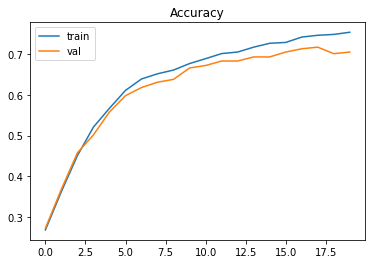

In [11]:
plt.plot(train_history, label='train')
plt.plot(val_history, label='val')
plt.title('Accuracy')
plt.legend()

# Улучшаем процесс тренировки

Мы реализуем несколько ключевых оптимизаций, необходимых для тренировки современных нейросетей.

## Уменьшение скорости обучения (learning rate decay)

Одна из необходимых оптимизаций во время тренировки нейронных сетей - постепенное уменьшение скорости обучения по мере тренировки.

Один из стандартных методов - уменьшение скорости обучения (learning rate) каждые N эпох на коэффициент d (часто называемый decay). Значения N и d, как всегда, являются гиперпараметрами и должны подбираться на основе эффективности на проверочных данных (validation data). 

В нашем случае N будет равным 1.

In [12]:
# TODO Implement learning rate decay inside Trainer.fit method
# Decay should happen once per epoch

model = TwoLayerNet(n_input = train_X.shape[1], n_output = 10, hidden_layer_size = 100, reg = 1e-3)
dataset = Dataset(train_X, train_y, val_X, val_y)
trainer = Trainer(model, dataset, SGD(), learning_rate_decay=0.99)

initial_learning_rate = trainer.learning_rate
loss_history, train_history, val_history = trainer.fit()

assert trainer.learning_rate < initial_learning_rate, "Learning rate should've been reduced"
assert trainer.learning_rate > 0.5*initial_learning_rate, "Learning rate shouldn'tve been reduced that much!"

Loss: 2.335742, Train accuracy: 0.284778, val accuracy: 0.297000
[[ 0.05591892 -0.01660728  0.01209056 ... -0.05932308 -0.0063941
   0.00123569]
 [-0.00889058  0.03877797 -0.00218441 ...  0.01476355  0.03788715
  -0.00811202]
 [ 0.02939786  0.00931939 -0.04436202 ... -0.03872451  0.00059535
  -0.03348115]
 ...
 [ 0.04350458 -0.00732692  0.00557092 ...  0.01720766  0.00394966
  -0.05554584]
 [ 0.02447938  0.03822657  0.04638115 ... -0.00998217  0.00716332
  -0.01257548]
 [-0.03044727  0.03847357  0.00859081 ... -0.00510016 -0.00992192
   0.03750548]]
Loss: 2.343457, Train accuracy: 0.368667, val accuracy: 0.369000
[[ 0.05520844 -0.01812322  0.01147718 ... -0.05858661 -0.00605013
   0.00125711]
 [-0.00912258  0.03681128 -0.00385346 ...  0.01478779  0.03778592
  -0.00822652]
 [ 0.02894959  0.00836732 -0.04661513 ... -0.03829591  0.00081479
  -0.03340202]
 ...
 [ 0.04310019 -0.00678426  0.0059665  ...  0.01645794  0.0030584
  -0.05476686]
 [ 0.0239433   0.03836076  0.04642281 ... -0.010367

Loss: 1.299049, Train accuracy: 0.726111, val accuracy: 0.705000
[[ 0.05018084 -0.02338555  0.00636327 ... -0.05145737 -0.01036181
  -0.00131963]
 [-0.00678517  0.02745608 -0.00640124 ...  0.01362926  0.02974331
  -0.0103005 ]
 [ 0.02893327  0.00791176 -0.04762683 ... -0.03680127 -0.0007692
  -0.02813226]
 ...
 [ 0.03229181 -0.00136059  0.00625875 ...  0.01601943 -0.00240173
  -0.04717633]
 [ 0.01278596  0.03972496  0.04527062 ... -0.00713061  0.00043743
  -0.00874526]
 [-0.03504324  0.04141325  0.01108676 ... -0.00226588 -0.0099102
   0.04003076]]
Loss: 1.170196, Train accuracy: 0.730111, val accuracy: 0.704000
[[ 4.98777422e-02 -2.27040640e-02  6.12576383e-03 ... -5.09750411e-02
  -1.08641048e-02 -1.72211796e-03]
 [-6.55477092e-03  2.77553057e-02 -6.32305926e-03 ...  1.36890048e-02
   2.89298261e-02 -1.06902099e-02]
 [ 2.89536863e-02  8.33122043e-03 -4.73122597e-02 ... -3.66920254e-02
  -1.23648154e-03 -2.80765953e-02]
 ...
 [ 3.15884352e-02 -8.00499700e-04  6.53646560e-03 ...  1.611

# Накопление импульса (Momentum SGD)

Другой большой класс оптимизаций - использование более эффективных методов градиентного спуска. Мы реализуем один из них - накопление импульса (Momentum SGD).

Этот метод хранит скорость движения, использует градиент для ее изменения на каждом шаге, и изменяет веса пропорционально значению скорости.
(Физическая аналогия: Вместо скорости градиенты теперь будут задавать ускорение, но будет присутствовать сила трения.)

```
velocity = momentum * velocity - learning_rate * gradient 
w = w + velocity
```

`momentum` здесь коэффициент затухания, который тоже является гиперпараметром (к счастью, для него часто есть хорошее значение по умолчанию, типичный диапазон -- 0.8-0.99).

Несколько полезных ссылок, где метод разбирается более подробно:  
http://cs231n.github.io/neural-networks-3/#sgd  
https://distill.pub/2017/momentum/

In [13]:
# TODO: Implement MomentumSGD.update function in optim.py

model = TwoLayerNet(n_input = train_X.shape[1], n_output = 10, hidden_layer_size = 100, reg = 1e-3)
dataset = Dataset(train_X, train_y, val_X, val_y)
trainer = Trainer(model, dataset, MomentumSGD(), learning_rate=1e-2, learning_rate_decay=0.995)

# You should see even better results than before!
loss_history, train_history, val_history = trainer.fit()

Loss: 1.449030, Train accuracy: 0.527889, val accuracy: 0.533000
[[ 0.00707497  0.02545114 -0.00833284 ...  0.00866155 -0.03433582
   0.01520845]
 [-0.00057534  0.00915566  0.01482271 ...  0.00509971 -0.00469923
   0.01178843]
 [ 0.02597421  0.05006298 -0.01061772 ... -0.01376506  0.00477425
   0.02141162]
 ...
 [-0.00986821 -0.01778143  0.02243017 ... -0.02490964 -0.00592552
   0.04354323]
 [-0.01875996 -0.03331152  0.00340276 ... -0.01938021  0.04528238
  -0.03565994]
 [-0.02833468 -0.01385427  0.01036335 ...  0.01613972 -0.04165895
   0.02087098]]
Loss: 1.087222, Train accuracy: 0.629889, val accuracy: 0.615000
[[ 0.01144379  0.02290367 -0.01055168 ...  0.00702593 -0.03247004
   0.01013325]
 [ 0.00704017  0.01129184  0.00955591 ...  0.00504946 -0.01028775
   0.00941396]
 [ 0.032147    0.04809505 -0.01317241 ... -0.01393572  0.00336249
   0.01595457]
 ...
 [-0.01553196 -0.01664687  0.01995917 ... -0.02659119 -0.00890764
   0.04306751]
 [-0.02316459 -0.03102802  0.00226446 ... -0.0226

Loss: 1.112275, Train accuracy: 0.791889, val accuracy: 0.712000
[[ 0.00674359  0.02363128 -0.01270291 ... -0.0181513  -0.00218048
   0.00562265]
 [ 0.01910562  0.02244193 -0.00687981 ... -0.02914549 -0.01881731
   0.01735658]
 [ 0.02835267  0.04495139 -0.00055164 ... -0.05843438 -0.02238031
   0.01394436]
 ...
 [-0.02223332 -0.01249871  0.00637903 ... -0.00702433  0.01741642
   0.01281237]
 [-0.04052691 -0.03093937 -0.00228822 ... -0.00175402  0.00900207
  -0.01051631]
 [-0.02648661 -0.02448601  0.00284935 ...  0.01464946 -0.01244104
   0.00870295]]
Loss: 1.094103, Train accuracy: 0.817000, val accuracy: 0.728000
[[ 0.00670314  0.02169867 -0.01339827 ... -0.01872941 -0.00426305
   0.00623255]
 [ 0.02018057  0.01850159 -0.00742057 ... -0.02737194 -0.01981683
   0.01925253]
 [ 0.02963336  0.0394924   0.00012596 ... -0.05695765 -0.02100369
   0.01642508]
 ...
 [-0.02390713 -0.01257297  0.00671097 ... -0.01035749  0.01092019
   0.01067621]
 [-0.04182357 -0.03332211 -0.0022487  ... -0.0036

# Ну что, давайте уже тренировать сеть!

## Последний тест - переобучимся (overfit) на маленьком наборе данных

Хороший способ проверить, все ли реализовано корректно - переобучить сеть на маленьком наборе данных.  
Наша модель обладает достаточной мощностью, чтобы приблизить маленький набор данных идеально, поэтому мы ожидаем, что на нем мы быстро дойдем до 100% точности на тренировочном наборе. 

Если этого не происходит, то где-то была допущена ошибка!

In [14]:
data_size = 15
model = TwoLayerNet(n_input = train_X.shape[1], n_output = 10, hidden_layer_size = 100, reg = 1e-3)
dataset = Dataset(train_X[:data_size], train_y[:data_size], val_X[:data_size], val_y[:data_size])
trainer = Trainer(model, dataset, SGD(), learning_rate=1e-1, num_epochs=150, batch_size=5)

# You should expect this to reach 1.0 training accuracy 
loss_history, train_history, val_history = trainer.fit()

Loss: 3.472405, Train accuracy: 0.533333, val accuracy: 0.000000
[[ 0.03707031  0.02639936 -0.00979605 ...  0.00881934  0.0152896
  -0.00415763]
 [ 0.02988927 -0.02874978 -0.02289211 ... -0.00539759  0.01566458
  -0.02803496]
 [-0.03027144 -0.00517918 -0.03297092 ...  0.0360364  -0.02357902
   0.02670635]
 ...
 [ 0.01786245 -0.0322432  -0.00631457 ...  0.02730724  0.00714995
  -0.00143559]
 [ 0.00967852  0.02182985  0.00767592 ... -0.01970893 -0.0059142
  -0.0239019 ]
 [-0.01653131 -0.02390373 -0.0138292  ... -0.00492134  0.04310813
  -0.03316914]]
Loss: 1.465364, Train accuracy: 0.733333, val accuracy: 0.000000
[[ 0.03678559  0.02705001 -0.00947603 ...  0.00839882  0.01603388
  -0.00423823]
 [ 0.02983025 -0.02814808 -0.02260869 ... -0.00581358  0.0166183
  -0.02781946]
 [-0.02989692 -0.00482459 -0.03283082 ...  0.0354668  -0.02274573
   0.02721541]
 ...
 [ 0.01564804 -0.03108646 -0.00693784 ...  0.02509098  0.00747813
  -0.00064578]
 [ 0.00752115  0.02298757  0.00704317 ... -0.0220499

Loss: 0.250332, Train accuracy: 1.000000, val accuracy: 0.000000
[[ 0.03837101  0.02827822 -0.00672038 ...  0.00891701  0.01853191
  -0.00666825]
 [ 0.03195694 -0.02703408 -0.01957028 ... -0.00458905  0.02198398
  -0.02904063]
 [-0.02606819 -0.00540966 -0.03031173 ...  0.03552218 -0.01667941
   0.02693339]
 ...
 [ 0.00686922 -0.02841418 -0.00965573 ...  0.02217819  0.00883908
  -0.00527859]
 [-0.00135779  0.02519482  0.00417639 ... -0.02534147 -0.00269146
  -0.02759232]
 [-0.02381313 -0.02084536 -0.01354398 ... -0.00992969  0.0478168
  -0.03357618]]
Loss: 0.258740, Train accuracy: 1.000000, val accuracy: 0.000000
[[ 0.0383737   0.02829302 -0.00668133 ...  0.00891627  0.01854434
  -0.00670645]
 [ 0.0319697  -0.02699402 -0.0195209  ... -0.00457344  0.02205658
  -0.02906507]
 [-0.02599933 -0.00540463 -0.03025593 ...  0.03550996 -0.0165635
   0.02689938]
 ...
 [ 0.00668661 -0.02834678 -0.00971158 ...  0.02207327  0.00890053
  -0.00538232]
 [-0.0015292   0.02523274  0.00411781 ... -0.025430

Loss: 0.264034, Train accuracy: 1.000000, val accuracy: 0.000000
[[ 0.03826598  0.02827907 -0.00632873 ...  0.0087488   0.01850884
  -0.0071058 ]
 [ 0.03192302 -0.0266252  -0.01900512 ... -0.00450469  0.02262699
  -0.02919257]
 [-0.02534311 -0.00543923 -0.02972218 ...  0.03516136 -0.0154441
   0.02653399]
 ...
 [ 0.00492467 -0.02780806 -0.0099465  ...  0.02110499  0.00914103
  -0.00615101]
 [-0.00325453  0.02532877  0.00375486 ... -0.02613169 -0.00199529
  -0.02835171]
 [-0.02500127 -0.02032897 -0.01334909 ... -0.01066697  0.0482728
  -0.03377492]]
Loss: 0.246503, Train accuracy: 1.000000, val accuracy: 0.000000
[[ 0.03824305  0.028276   -0.00630894 ...  0.00874401  0.01850027
  -0.00711582]
 [ 0.03189185 -0.02660046 -0.01897498 ... -0.00449598  0.02264515
  -0.02918728]
 [-0.02533803 -0.00543845 -0.02968463 ...  0.03514518 -0.01539193
   0.02651635]
 ...
 [ 0.00482543 -0.02776898 -0.00997018 ...  0.02104355  0.0091375
  -0.00618556]
 [-0.00335452  0.02533749  0.00372546 ... -0.0261718

Loss: 0.238898, Train accuracy: 1.000000, val accuracy: 0.000000
[[ 0.03798736  0.02814392 -0.00607193 ...  0.00856752  0.01840787
  -0.00732593]
 [ 0.03171212 -0.02625419 -0.01856743 ... -0.00445387  0.02288931
  -0.02911526]
 [-0.02482635 -0.00544402 -0.02920978 ...  0.03472335 -0.014642
   0.02619011]
 ...
 [ 0.00369817 -0.02729795 -0.01009197 ...  0.02042306  0.00928901
  -0.00662936]
 [-0.00442898  0.02529497  0.0034608  ... -0.02643554 -0.00156256
  -0.02865672]
 [-0.02562149 -0.01990997 -0.01317503 ... -0.01101349  0.04831346
  -0.0336786 ]]
Loss: 0.237984, Train accuracy: 1.000000, val accuracy: 0.000000
[[ 0.03797291  0.02813551 -0.00606095 ...  0.00856083  0.01840104
  -0.00734737]
 [ 0.03170718 -0.02623358 -0.01854725 ... -0.00444909  0.02289791
  -0.02912146]
 [-0.02478938 -0.00544328 -0.02918865 ...  0.0346973  -0.01460601
   0.02615948]
 ...
 [ 0.00365173 -0.027268   -0.01007677 ...  0.0204107   0.00929188
  -0.00664327]
 [-0.00447112  0.02529441  0.00346651 ... -0.026427

Loss: 0.227055, Train accuracy: 1.000000, val accuracy: 0.000000
[[ 0.03762912  0.0279473  -0.00587314 ...  0.00841996  0.01828156
  -0.00748455]
 [ 0.03143354 -0.02589586 -0.0181913  ... -0.00438755  0.02299504
  -0.02897742]
 [-0.02437877 -0.00543082 -0.02874682 ...  0.03429878 -0.01402621
   0.02583309]
 ...
 [ 0.00281474 -0.0268312  -0.01013016 ...  0.01985152  0.00937813
  -0.00692139]
 [-0.00525177  0.0251845   0.00326486 ... -0.02657194 -0.00123824
  -0.02874861]
 [-0.02595985 -0.01953906 -0.0129819  ... -0.01123524  0.04816342
  -0.03347578]]
Loss: 0.230972, Train accuracy: 1.000000, val accuracy: 0.000000
[[ 0.03760618  0.02793733 -0.00586344 ...  0.00840681  0.01827475
  -0.00749922]
 [ 0.03140925 -0.02587604 -0.01817209 ... -0.00438918  0.02299858
  -0.02897745]
 [-0.02436878 -0.00542867 -0.02872073 ...  0.034275   -0.01399708
   0.02580663]
 ...
 [ 0.00276745 -0.02680395 -0.010144   ...  0.01981334  0.00937967
  -0.00692981]
 [-0.00529678  0.02518125  0.00324317 ... -0.0265

Loss: 0.224714, Train accuracy: 1.000000, val accuracy: 0.000000
[[ 0.03723769  0.02772558 -0.00570796 ...  0.00827282  0.01814699
  -0.00758909]
 [ 0.0311172  -0.02555558 -0.01785622 ... -0.00433525  0.02302071
  -0.02879718]
 [-0.02399812 -0.0054079  -0.02831618 ...  0.03388468 -0.01351903
   0.02549549]
 ...
 [ 0.00211559 -0.02640473 -0.01014567 ...  0.01933114  0.00941887
  -0.00712113]
 [-0.00588343  0.02503566  0.0030938  ... -0.02663714 -0.00099414
  -0.02873931]
 [-0.02616146 -0.01920502 -0.01280817 ... -0.011395    0.0479247
  -0.0332269 ]]
Loss: 0.221869, Train accuracy: 1.000000, val accuracy: 0.000000
[[ 0.03722294  0.0277098  -0.00569935 ...  0.00826878  0.01813961
  -0.00759221]
 [ 0.03111056 -0.0255422  -0.01783835 ... -0.00432909  0.02302068
  -0.02878641]
 [-0.02396658 -0.00541021 -0.02829143 ...  0.0338677  -0.01349462
   0.02547814]
 ...
 [ 0.00208945 -0.02639299 -0.01015529 ...  0.01930098  0.00941921
  -0.00713223]
 [-0.00590483  0.0250173   0.00307634 ... -0.02664

Loss: 0.220837, Train accuracy: 1.000000, val accuracy: 0.000000
[[ 0.03684312  0.02749046 -0.00556124 ...  0.00814147  0.01800649
  -0.00765642]
 [ 0.03080278 -0.02522817 -0.01754482 ... -0.0042787   0.02299984
  -0.02859091]
 [-0.02362956 -0.00537991 -0.02790488 ...  0.03347751 -0.01307831
   0.02517154]
 ...
 [ 0.00155096 -0.02600702 -0.01014011 ...  0.01889613  0.00943419
  -0.00727591]
 [-0.00638109  0.02486251  0.00294627 ... -0.02661396 -0.00079512
  -0.02868237]
 [-0.02626075 -0.01889192 -0.01264043 ... -0.01148546  0.04763126
  -0.03295831]]
Loss: 0.216792, Train accuracy: 1.000000, val accuracy: 0.000000
[[ 0.03682503  0.02747473 -0.00555346 ...  0.00813741  0.01799956
  -0.00766486]
 [ 0.03079142 -0.02521434 -0.0175281  ... -0.00427305  0.02299739
  -0.0285852 ]
 [-0.02360422 -0.00538214 -0.02788138 ...  0.03346034 -0.01305599
   0.02514959]
 ...
 [ 0.00152708 -0.02599224 -0.01014761 ...  0.01886889  0.00943913
  -0.00727964]
 [-0.00640057  0.02484703  0.002931   ... -0.0266

Loss: 0.211459, Train accuracy: 1.000000, val accuracy: 0.000000
[[ 0.03648967  0.0272722  -0.00544158 ...  0.00802382  0.0178783
  -0.00770795]
 [ 0.03051779 -0.02494399 -0.01728166 ... -0.00423367  0.02295494
  -0.02840358]
 [-0.02331782 -0.00535376 -0.02755329 ...  0.03312052 -0.01272094
   0.02488078]
 ...
 [ 0.00110681 -0.02566802 -0.01011678 ...  0.01851782  0.00944472
  -0.00737808]
 [-0.006763    0.0246944   0.00283302 ... -0.02657741 -0.00062841
  -0.02859453]
 [-0.02630749 -0.01862903 -0.0124888  ... -0.01155062  0.04734987
  -0.03270671]]
Loss: 0.210777, Train accuracy: 1.000000, val accuracy: 0.000000
[[ 0.03647128  0.02725993 -0.00543365 ...  0.00801954  0.01787066
  -0.00770779]
 [ 0.03050576 -0.02492665 -0.01726538 ... -0.00422862  0.02295166
  -0.02838968]
 [-0.02329397 -0.00535168 -0.02753024 ...  0.03310298 -0.01270029
   0.02486596]
 ...
 [ 0.00108536 -0.02564591 -0.01011949 ...  0.01849207  0.009442
  -0.00738331]
 [-0.00678004  0.02468673  0.0028233  ... -0.0265783

Loss: 0.210970, Train accuracy: 1.000000, val accuracy: 0.000000
[[ 0.03606388  0.02699846 -0.00530224 ...  0.00789582  0.01771778
  -0.00774575]
 [ 0.03017429 -0.02459946 -0.01696988 ... -0.00416994  0.0228774
  -0.02815028]
 [-0.02294048 -0.00531808 -0.02713044 ...  0.03268996 -0.01231314
   0.02454187]
 ...
 [ 0.00061374 -0.02526111 -0.01007956 ...  0.01809518  0.00943836
  -0.00748036]
 [-0.00717482  0.02448026  0.00270514 ... -0.02648926 -0.00045263
  -0.02845982]
 [-0.02632708 -0.01831796 -0.01230676 ... -0.01159977  0.04697905
  -0.0323817 ]]
Loss: 0.210474, Train accuracy: 1.000000, val accuracy: 0.000000
[[ 0.03604184  0.026986   -0.00529595 ...  0.00789158  0.01771022
  -0.00774605]
 [ 0.03015865 -0.02458249 -0.01695567 ... -0.00416517  0.02287361
  -0.02813728]
 [-0.02292042 -0.00531589 -0.02711201 ...  0.03267244 -0.01229433
   0.02452646]
 ...
 [ 0.00059349 -0.02523981 -0.01007108 ...  0.0180711   0.00943746
  -0.00748576]
 [-0.00719046  0.02447209  0.00270556 ... -0.02648

Теперь найдем гипепараметры, для которых этот процесс сходится быстрее.
Если все реализовано корректно, то существуют параметры, при которых процесс сходится в **20** эпох или еще быстрее.
Найдите их!

In [15]:
# Now, tweak some hyper parameters and make it train to 1.0 accuracy in 20 epochs or less

model = TwoLayerNet(n_input = train_X.shape[1], n_output = 10, hidden_layer_size = 100, reg = 1e-3)
dataset = Dataset(train_X[:data_size], train_y[:data_size], val_X[:data_size], val_y[:data_size])
# TODO: Change any hyperparamers or optimizators to reach training accuracy in 20 epochs
trainer = Trainer(model, dataset, SGD(), learning_rate=1e-1, num_epochs=20, batch_size=5)

loss_history, train_history, val_history = trainer.fit()

Loss: 2.403935, Train accuracy: 0.600000, val accuracy: 0.000000
[[-0.04125304 -0.00028794  0.0064036  ...  0.02760854 -0.04555856
   0.03164859]
 [ 0.03924059  0.01525464 -0.03298251 ...  0.01497761  0.01956838
   0.0059143 ]
 [ 0.01513444  0.00097384  0.02701268 ... -0.00856267 -0.00869827
   0.02223445]
 ...
 [-0.00663169  0.00061613  0.01338996 ...  0.02450533  0.01582469
  -0.00411864]
 [ 0.01916936 -0.02863832 -0.03661467 ...  0.00424639 -0.01751313
  -0.01207983]
 [-0.03029135 -0.04666418  0.00104894 ... -0.00687338  0.01527352
  -0.01307609]]
Loss: 1.723583, Train accuracy: 0.733333, val accuracy: 0.000000
[[-0.04134882  0.00039327  0.0066167  ...  0.0272565  -0.04507246
   0.03075635]
 [ 0.03908495  0.01596092 -0.0325541  ...  0.01492356  0.01962935
   0.00481131]
 [ 0.0150205   0.0016167   0.0274117  ... -0.00889774 -0.00876067
   0.02099956]
 ...
 [-0.00677194 -0.00020917  0.01323531 ...  0.02512537  0.0159554
  -0.00519664]
 [ 0.01900375 -0.02946142 -0.03678059 ...  0.00480

# Итак, основное мероприятие!

Натренируйте лучшую нейросеть! Можно добавлять и изменять параметры, менять количество нейронов в слоях сети и как угодно экспериментировать. 

Добейтесь точности лучше **60%** на validation set.

In [16]:
# Let's train the best one-hidden-layer network we can

learning_rates = 1e-4
reg_strength = 1e-3
learning_rate_decay = 0.999
hidden_layer_size = 128
num_epochs = 200
batch_size = 64

best_classifier = None
best_val_accuracy = None

loss_history = []
train_history = []
val_history = []

# TODO find the best hyperparameters to train the network
# Don't hesitate to add new values to the arrays above, perform experiments, use any tricks you want
# You should expect to get to at least 40% of valudation accuracy
# Save loss/train/history of the best classifier to the variables above

params_model = ParameterGrid({'hidden_layer_size':[100, 128], 'reg':np.logspace(-5,-1, num=5)})
params_trainer = ParameterGrid({'learning_rate':np.logspace(-5, -1, num=5), 'batch_size':[32, 64, 128], 
                                'learning_rate_decay':[0.9, 0.95, 0.99]})

best_param_model = None
best_param_trainer = None
best_val_acc = 0.0
for param_model in params_model:
    for param_trainer in params_trainer:
        model = TwoLayerNet(n_input = train_X.shape[1], n_output = 10, **param_model)
        dataset = Dataset(train_X, train_y, val_X, val_y)
        trainer = Trainer(model, dataset, MomentumSGD(), num_epochs=20, **param_trainer)

        loss_history, train_history,val_history = trainer.fit()
        if(val_history[-1] > best_val_acc):
            best_val_acc = val_history[-1]
            best_param_model = param_model
            best_param_trainer = param_trainer    

Loss: 2.548595, Train accuracy: 0.089556, val accuracy: 0.105000
[[-2.62632316e-02 -3.09480868e-03  1.01948108e-02 ...  2.46492298e-02
   2.32182220e-02  3.62629957e-02]
 [-3.23025954e-02 -5.27890393e-04  8.90121975e-03 ... -2.56819124e-02
  -3.12993484e-02 -1.44626174e-02]
 [-2.08440694e-03 -4.68490186e-03 -4.59780828e-02 ... -2.64386114e-02
  -2.49009616e-02  2.80682817e-02]
 ...
 [-5.37844768e-03 -1.73149558e-02 -1.01014606e-02 ...  1.72773032e-02
   1.54325900e-02  2.84038998e-02]
 [-1.22942431e-02 -2.59007073e-02  3.74780313e-02 ...  1.88356158e-02
  -3.01372089e-02 -7.08456218e-05]
 [ 4.81101988e-04 -9.98731106e-03 -1.37604548e-02 ...  2.02583803e-02
  -5.03330474e-02 -2.36913665e-02]]
Loss: 2.319043, Train accuracy: 0.097444, val accuracy: 0.110000
[[-2.62812897e-02 -3.04323671e-03  1.01904719e-02 ...  2.46635041e-02
   2.32213724e-02  3.63210169e-02]
 [-3.23214964e-02 -4.74463707e-04  8.89774886e-03 ... -2.56667516e-02
  -3.12867277e-02 -1.44099088e-02]
 [-2.10312491e-03 -4.626

Loss: 2.423329, Train accuracy: 0.126111, val accuracy: 0.139000
[[-2.63493138e-02 -2.80061819e-03  1.01816474e-02 ...  2.47323506e-02
   2.31894165e-02  3.66025452e-02]
 [-3.23930152e-02 -2.21702383e-04  8.89651469e-03 ... -2.55911344e-02
  -3.12678679e-02 -1.41660518e-02]
 [-2.17391597e-03 -4.34111968e-03 -4.59725174e-02 ... -2.63587863e-02
  -2.48192553e-02  2.83156363e-02]
 ...
 [-5.42114216e-03 -1.69706419e-02 -1.00631369e-02 ...  1.73164828e-02
   1.53941501e-02  2.85626650e-02]
 [-1.23403668e-02 -2.55653822e-02  3.75081041e-02 ...  1.88729047e-02
  -3.01429407e-02  7.15842532e-05]
 [ 4.25499757e-04 -9.68513042e-03 -1.37519812e-02 ...  2.02877976e-02
  -5.03004094e-02 -2.35157869e-02]]
Loss: 2.464736, Train accuracy: 0.126000, val accuracy: 0.142000
[[-2.63515996e-02 -2.79367226e-03  1.01818037e-02 ...  2.47348636e-02
   2.31876240e-02  3.66117090e-02]
 [-3.23954605e-02 -2.14263348e-04  8.89699330e-03 ... -2.55883848e-02
  -3.12676837e-02 -1.41589533e-02]
 [-2.17624291e-03 -4.332

Loss: 2.337576, Train accuracy: 0.164667, val accuracy: 0.154000
[[-0.00645711  0.00322119  0.01228824 ... -0.0089515  -0.01687595
  -0.02850417]
 [-0.01013456 -0.02845044  0.00961258 ...  0.0400381   0.02797183
  -0.00222395]
 [-0.02992743 -0.03267227  0.02871527 ... -0.04145943  0.05629469
  -0.01442997]
 ...
 [-0.01629942  0.00954573  0.05747189 ... -0.00148143  0.03411022
   0.00407019]
 [ 0.03820784 -0.00270313 -0.02747103 ... -0.00629903  0.03904619
   0.01703427]
 [ 0.06757192 -0.00527847  0.03206272 ...  0.01313569 -0.06563154
   0.03301452]]
Loss: 2.166590, Train accuracy: 0.167889, val accuracy: 0.153000
[[-0.00645711  0.00321618  0.01227976 ... -0.00896135 -0.01688426
  -0.02851265]
 [-0.01013169 -0.02845766  0.00960388 ...  0.04002205  0.02795889
  -0.0022355 ]
 [-0.02992457 -0.03268049  0.02870944 ... -0.04147657  0.05627914
  -0.01444031]
 ...
 [-0.01630627  0.00955385  0.05746375 ... -0.00148581  0.03410938
   0.00406481]
 [ 0.03820177 -0.00269713 -0.02748087 ... -0.0063

Loss: 2.272249, Train accuracy: 0.109889, val accuracy: 0.103000
[[-0.00413305  0.01483846 -0.00683367 ... -0.02009139  0.03175295
   0.03338019]
 [ 0.02494899  0.01274174  0.03780161 ...  0.01559863 -0.01964092
  -0.01379995]
 [ 0.01812421  0.02748522 -0.02029199 ...  0.01896865 -0.01495791
  -0.00099584]
 ...
 [ 0.02111224 -0.01488041  0.00666045 ...  0.05234895  0.00915154
   0.0197279 ]
 [ 0.02823332 -0.03764386 -0.00124749 ... -0.03347582 -0.02217568
   0.01226966]
 [-0.04317195  0.00359113  0.0126192  ...  0.01733146  0.01687526
   0.01494857]]
Loss: 2.263159, Train accuracy: 0.112333, val accuracy: 0.106000
[[-0.00415116  0.01484604 -0.00684239 ... -0.02007426  0.03174923
   0.03345385]
 [ 0.02492719  0.01275455  0.03779113 ...  0.01562135 -0.0196442
  -0.01372279]
 [ 0.0180989   0.0274998  -0.02030635 ...  0.01899285 -0.01496268
  -0.00092328]
 ...
 [ 0.02110127 -0.01487915  0.00666092 ...  0.05235019  0.0091431
   0.01975683]
 [ 0.02822207 -0.03764185 -0.00124557 ... -0.033471

Loss: 2.401095, Train accuracy: 0.162111, val accuracy: 0.151000
[[-0.00432328  0.01494211 -0.00689671 ... -0.01990266  0.03169761
   0.03415578]
 [ 0.02470872  0.01290016  0.03771643 ...  0.01585687 -0.01969335
  -0.01297167]
 [ 0.01783644  0.02767079 -0.02041634 ...  0.0192426  -0.01503539
  -0.00023674]
 ...
 [ 0.02098549 -0.01486532  0.00669042 ...  0.05233672  0.00903174
   0.01988095]
 [ 0.02810757 -0.03762872 -0.00119781 ... -0.03344988 -0.02229195
   0.01231959]
 [-0.04330525  0.00357494  0.01266037 ...  0.01736993  0.01678816
   0.01485095]]
Loss: 2.124222, Train accuracy: 0.163333, val accuracy: 0.159000
[[-0.00432976  0.01494886 -0.00689854 ... -0.01989364  0.03169409
   0.03418924]
 [ 0.02469958  0.0129104   0.03771264 ...  0.01586992 -0.01969716
  -0.0129357 ]
 [ 0.0178246   0.02768279 -0.02042255 ...  0.01925649 -0.01504064
  -0.00020479]
 ...
 [ 0.02098057 -0.01486253  0.0066919  ...  0.05233603  0.00902483
   0.01988114]
 [ 0.02810342 -0.03762541 -0.0011958  ... -0.0334

Loss: 2.318927, Train accuracy: 0.224333, val accuracy: 0.234000
[[-0.04385145 -0.02310623  0.00748096 ... -0.02990395  0.03607828
   0.0139564 ]
 [-0.00409046  0.04675595 -0.01787476 ... -0.02006834 -0.01052272
  -0.01848984]
 [ 0.05242884  0.06245343  0.02723325 ...  0.0061665  -0.01351107
   0.00697014]
 ...
 [ 0.00419154  0.02140362 -0.03198096 ... -0.01387874 -0.03560784
   0.03075884]
 [ 0.00920014 -0.01090842 -0.00800935 ... -0.02407706  0.00370008
  -0.04092139]
 [-0.07791928  0.00686071 -0.02817334 ...  0.02393493 -0.02221338
   0.00581922]]
Loss: 2.155274, Train accuracy: 0.226222, val accuracy: 0.235000
[[-0.04386563 -0.02308718  0.00750492 ... -0.02988774  0.03607922
   0.01396079]
 [-0.00410978  0.04678585 -0.01785457 ... -0.02005145 -0.01052683
  -0.01848645]
 [ 0.05241299  0.06248375  0.02723358 ...  0.00616641 -0.01352424
   0.0069738 ]
 ...
 [ 0.0041974   0.02140742 -0.0319828  ... -0.01387118 -0.0356145
   0.03075787]
 [ 0.00920327 -0.01090112 -0.00800684 ... -0.02406

Loss: 2.331016, Train accuracy: 0.211111, val accuracy: 0.217000
[[-0.00168513  0.01209071  0.00985923 ...  0.03806631 -0.03956031
   0.00513523]
 [-0.03151489 -0.03009973  0.01200955 ... -0.0122645  -0.00864165
   0.02942588]
 [ 0.00961049  0.01635047  0.01987817 ...  0.0043669  -0.01418967
   0.00275641]
 ...
 [ 0.00903104 -0.0178455  -0.01555724 ...  0.00129244 -0.04387822
  -0.01193408]
 [ 0.0163738  -0.03137241 -0.03164826 ... -0.03629415 -0.02018712
  -0.00042085]
 [ 0.01713138  0.01257674 -0.01604896 ...  0.03189774 -0.00141848
  -0.01744975]]
Loss: 2.399364, Train accuracy: 0.219667, val accuracy: 0.225000
[[-0.0017051   0.0119517   0.00991781 ...  0.03805807 -0.03963502
   0.00505836]
 [-0.03156136 -0.03025578  0.01207444 ... -0.01226598 -0.00872467
   0.02936044]
 [ 0.0095536   0.01623381  0.01991111 ...  0.00435516 -0.0142697
   0.00272559]
 ...
 [ 0.00903914 -0.01786877 -0.01553223 ...  0.00129178 -0.04386543
  -0.0119412 ]
 [ 0.01639734 -0.03140152 -0.0316263  ... -0.03628

Loss: 2.194744, Train accuracy: 0.140556, val accuracy: 0.148000
[[ 0.01247184  0.01350676 -0.03756945 ...  0.01504171  0.00584898
  -0.02856459]
 [-0.03809483 -0.01855644  0.04008594 ...  0.04457464 -0.02691785
  -0.00973973]
 [-0.00282098  0.00837228  0.0507117  ...  0.02355469  0.01071859
  -0.0001192 ]
 ...
 [-0.01696108  0.00542981 -0.01507875 ...  0.03901416  0.02362086
  -0.05245527]
 [ 0.01631675 -0.01857907 -0.02317059 ...  0.01483945  0.00419566
  -0.01376197]
 [-0.00133234  0.02844908  0.02135819 ...  0.00206682 -0.03359123
   0.01517349]]
Loss: 2.208067, Train accuracy: 0.171222, val accuracy: 0.174000
[[ 0.01250376  0.01350075 -0.03759583 ...  0.01534591  0.00571388
  -0.02850673]
 [-0.03805914 -0.01858789  0.0400751  ...  0.04497049 -0.0270517
  -0.00967537]
 [-0.00277874  0.00836014  0.05072623 ...  0.02398636  0.0105835
  -0.00013525]
 ...
 [-0.01694517  0.00563858 -0.01513862 ...  0.03914773  0.02356485
  -0.05227903]
 [ 0.01632361 -0.01839748 -0.02323566 ...  0.014943

Loss: 2.390175, Train accuracy: 0.257444, val accuracy: 0.267000
[[ 0.0118248   0.01233726 -0.03849749 ...  0.01378859  0.00563889
  -0.02784706]
 [-0.03875034 -0.02007772  0.03939126 ...  0.04405166 -0.02718692
  -0.00882892]
 [-0.00309067  0.00722776  0.05040693 ...  0.02389428  0.01049164
  -0.00026021]
 ...
 [-0.01763215  0.00573519 -0.01626666 ...  0.03899252  0.02370875
  -0.05050906]
 [ 0.0154451  -0.01873351 -0.02433362 ...  0.01449744  0.00434106
  -0.01163267]
 [-0.0023267   0.02790967  0.02037875 ...  0.00064929 -0.03299935
   0.0166158 ]]
Loss: 2.118773, Train accuracy: 0.264111, val accuracy: 0.270000
[[ 0.01176818  0.01228893 -0.03853835 ...  0.01357842  0.0056767
  -0.02781873]
 [-0.03880314 -0.02014183  0.03935695 ...  0.04386398 -0.02716157
  -0.00878869]
 [-0.00310914  0.00719103  0.05039015 ...  0.02377971  0.01052857
  -0.00027642]
 ...
 [-0.01764301  0.00571616 -0.01631858 ...  0.03896492  0.02371049
  -0.05041079]
 [ 0.01542145 -0.01877338 -0.02438496 ...  0.01445

Loss: 1.530733, Train accuracy: 0.564556, val accuracy: 0.549000
[[-0.02042461 -0.05310879 -0.01602451 ... -0.0206305  -0.02437928
   0.00131189]
 [-0.03647264  0.00183079 -0.01135125 ...  0.00321586 -0.03259764
  -0.00454369]
 [ 0.00811863  0.00894609  0.01517018 ... -0.00607262  0.00528581
  -0.00465338]
 ...
 [ 0.00271886 -0.02143867 -0.04193599 ...  0.00185812  0.00364697
  -0.04690888]
 [ 0.00997768 -0.03780693  0.002205   ...  0.00784677 -0.03371827
  -0.01461029]
 [ 0.00654724  0.0185842   0.00161045 ... -0.0337659   0.02015172
   0.00821723]]
Loss: 1.504354, Train accuracy: 0.575556, val accuracy: 0.555000
[[-0.02043059 -0.05316764 -0.01551989 ... -0.02033475 -0.02457968
   0.00148889]
 [-0.03643622  0.00171752 -0.01090602 ...  0.00358844 -0.03279374
  -0.00443842]
 [ 0.00816244  0.00868435  0.01562322 ... -0.00586776  0.00505126
  -0.00460233]
 ...
 [ 0.00273641 -0.02152853 -0.04195734 ...  0.00168859  0.00363382
  -0.04713116]
 [ 0.00999776 -0.03788858  0.00211296 ...  0.0077

Loss: 1.812698, Train accuracy: 0.497667, val accuracy: 0.494000
[[-0.03900009 -0.04303662 -0.01388765 ...  0.02187881  0.0054191
   0.02398311]
 [ 0.00862617 -0.00402732 -0.0105764  ...  0.03369768 -0.01965337
   0.00911367]
 [ 0.03785411  0.03872692  0.00937645 ...  0.02447363 -0.00064085
   0.02355197]
 ...
 [-0.00165086 -0.04248235 -0.01362575 ... -0.02737198 -0.04185642
  -0.00923005]
 [ 0.02241418  0.03207099 -0.023455   ...  0.02251129 -0.01763773
   0.03254656]
 [ 0.01472616 -0.01060811  0.05849434 ...  0.00135328 -0.0173723
  -0.0056445 ]]
Loss: 1.648279, Train accuracy: 0.530000, val accuracy: 0.517000
[[-0.03868012 -0.04272486 -0.01365311 ...  0.02215563  0.00512998
   0.02406322]
 [ 0.0088918  -0.00345491 -0.01056991 ...  0.03420756 -0.01998951
   0.00928264]
 [ 0.03791798  0.03918917  0.0096295  ...  0.02477067 -0.00092562
   0.02372813]
 ...
 [-0.00177857 -0.04273128 -0.01340362 ... -0.02723103 -0.04162198
  -0.00911449]
 [ 0.02234569  0.03175638 -0.02329747 ...  0.022619

Loss: 1.986536, Train accuracy: 0.243000, val accuracy: 0.252000
[[ 0.02653932 -0.03521557 -0.01572024 ... -0.037094   -0.02609516
   0.02953429]
 [-0.04213221  0.03199062 -0.0398738  ...  0.0218587   0.0004156
  -0.00197439]
 [-0.0445475  -0.02830979 -0.02196449 ... -0.00526815 -0.02299361
   0.03068793]
 ...
 [ 0.03605702  0.02268389 -0.00547747 ... -0.02481337  0.03013091
  -0.01516499]
 [-0.01390036 -0.01624762 -0.02559603 ...  0.0101857   0.07012737
  -0.00647591]
 [ 0.00108798  0.01988856  0.04263206 ...  0.01932873  0.01708938
  -0.00491917]]
Loss: 2.336241, Train accuracy: 0.316222, val accuracy: 0.329000
[[ 0.02663265 -0.03503876 -0.01615126 ... -0.03784199 -0.02591134
   0.02944159]
 [-0.04214402  0.0320434  -0.04038025 ...  0.02074317  0.00050837
  -0.00181673]
 [-0.04432699 -0.02815581 -0.02209719 ... -0.0063817  -0.02301634
   0.03096766]
 ...
 [ 0.03554925  0.02409524 -0.00618472 ... -0.0249636   0.02965935
  -0.01405891]
 [-0.01448151 -0.01489095 -0.02634517 ...  0.01001

Loss: 1.636286, Train accuracy: 0.685000, val accuracy: 0.663000
[[ 0.02537836 -0.03421313 -0.02237187 ... -0.04555086 -0.02629172
   0.03588301]
 [-0.043142    0.03042714 -0.04820544 ...  0.01544389  0.0003459
   0.00613155]
 [-0.04322943 -0.02881393 -0.02823731 ... -0.00856896 -0.02324571
   0.03275852]
 ...
 [ 0.03308648  0.02934228 -0.00382788 ... -0.02276788  0.02656889
  -0.01146351]
 [-0.01777429 -0.01016828 -0.02497971 ...  0.0132672   0.06692739
  -0.00495473]
 [-0.00096906  0.02549533  0.04441338 ...  0.02430322  0.01742528
  -0.00981165]]
Loss: 0.892958, Train accuracy: 0.686556, val accuracy: 0.661000
[[ 0.02521511 -0.0340324  -0.0227488  ... -0.04617355 -0.02636185
   0.03670098]
 [-0.04329199  0.03044245 -0.04858378 ...  0.01518923  0.00031348
   0.0070557 ]
 [-0.04325695 -0.02876592 -0.02869326 ... -0.0082516  -0.02323122
   0.03305699]
 ...
 [ 0.03310701  0.029376   -0.0037752  ... -0.0228059   0.02657843
  -0.01147484]
 [-0.01782088 -0.01019356 -0.02498611 ...  0.01337

Loss: 0.635299, Train accuracy: 0.816444, val accuracy: 0.733000
[[-2.88445265e-02 -2.06876892e-02 -7.12960846e-03 ... -1.00443063e-02
   9.88553267e-03  2.71609825e-02]
 [-7.94690325e-03 -9.45754066e-03  1.71457791e-02 ...  6.61236797e-02
   2.34123084e-02  2.78427919e-02]
 [-3.65339152e-02  1.63683975e-02 -1.74299150e-02 ... -2.66641484e-02
   2.76819356e-02 -3.38758122e-03]
 ...
 [ 2.23036831e-02  6.71558700e-02  9.47621983e-03 ... -2.25696000e-02
  -2.52992760e-02 -2.46305424e-03]
 [ 3.81574824e-02  4.13018312e-02  4.39377699e-02 ...  2.29914871e-02
  -2.11337261e-02  7.05813204e-03]
 [ 1.64898031e-02  4.28365171e-02  6.80342410e-03 ... -7.47988798e-05
  -1.75659092e-02 -3.41446944e-02]]
Loss: 0.465480, Train accuracy: 0.827444, val accuracy: 0.744000
[[-0.02858705 -0.02015479 -0.00746499 ... -0.01004996  0.00964829
   0.02757137]
 [-0.00730028 -0.00934314  0.01655964 ...  0.0663714   0.02304939
   0.02810552]
 [-0.03559385  0.01701609 -0.01761054 ... -0.02595737  0.02789923
  -0.0

Loss: 1.006513, Train accuracy: 0.767889, val accuracy: 0.731000
[[ 0.01420781  0.01431837  0.01000575 ... -0.00844781 -0.00188582
  -0.02355254]
 [-0.03241679 -0.02205731 -0.00886731 ...  0.01543899  0.00164174
   0.03256249]
 [ 0.00244554 -0.03983838  0.02752554 ...  0.02864636  0.01889399
  -0.01409554]
 ...
 [ 0.03648098  0.01412263 -0.00292718 ...  0.00712721 -0.0080539
   0.01715811]
 [ 0.0218313   0.03916395 -0.01655059 ...  0.01122153 -0.01783643
   0.01174592]
 [ 0.02118665  0.03888383 -0.06336519 ... -0.02655457 -0.01512588
  -0.00818908]]
Loss: 0.554222, Train accuracy: 0.768222, val accuracy: 0.716000
[[ 0.01237987  0.00818471  0.01091675 ... -0.00721138 -0.00684129
  -0.02208614]
 [-0.03483336 -0.027573   -0.00867249 ...  0.0169514  -0.00351763
   0.03382133]
 [ 0.00138433 -0.04750207  0.02760595 ...  0.02922834  0.01440464
  -0.01228282]
 ...
 [ 0.03770206  0.01481715 -0.00302732 ...  0.00474863 -0.01183755
   0.01691258]
 [ 0.02297101  0.04108648 -0.01647528 ...  0.00982

Loss: 1.521526, Train accuracy: 0.511000, val accuracy: 0.493000
[[-0.01415612  0.00266998 -0.00720525 ...  0.02036671 -0.06562116
   0.03291234]
 [ 0.0197567   0.00936092  0.011029   ...  0.01581184 -0.010401
  -0.01324446]
 [-0.04186947  0.00460072 -0.0113839  ... -0.00740788 -0.00773892
   0.04042194]
 ...
 [-0.03588711 -0.01307646  0.00182872 ...  0.01470613  0.03303262
  -0.00769691]
 [-0.0369893  -0.00450249 -0.04587252 ...  0.01245521  0.02871681
  -0.00895086]
 [ 0.05526081  0.00115472 -0.02171159 ...  0.01738546  0.04289009
  -0.00057028]]
Loss: 1.195782, Train accuracy: 0.618444, val accuracy: 0.598000
[[-0.01276334  0.0019541  -0.00904711 ...  0.01952448 -0.06462923
   0.0318431 ]
 [ 0.02264696  0.01221325  0.0093907  ...  0.01333702 -0.00929921
  -0.01339357]
 [-0.04153507  0.00870277 -0.01315597 ... -0.00769237 -0.00512385
   0.04054878]
 ...
 [-0.03154911 -0.01460148  0.00223164 ...  0.01194258  0.03331254
  -0.00731957]
 [-0.03243881 -0.00455384 -0.0444868  ...  0.007254

Loss: 0.670804, Train accuracy: 0.857778, val accuracy: 0.742000
[[ 0.00134187  0.00966096 -0.01596235 ...  0.06108368 -0.0399713
   0.03759251]
 [ 0.05028961  0.01855248  0.00974175 ...  0.0255097   0.01509023
   0.00225742]
 [-0.02795581  0.04466357 -0.0152279  ... -0.00274219  0.01631842
   0.0612655 ]
 ...
 [-0.03084159 -0.0016425  -0.00339776 ...  0.01843648  0.08520422
   0.00985686]
 [-0.03374741 -0.00337753 -0.04949776 ... -0.00068176  0.08709629
   0.00957714]
 [ 0.06150454  0.01372091 -0.02060197 ...  0.01427253  0.07787597
   0.01201762]]
Loss: 1.150740, Train accuracy: 0.852444, val accuracy: 0.734000
[[ 0.00403091  0.0048132  -0.01870645 ...  0.0627248  -0.03922862
   0.03472975]
 [ 0.05327454  0.01411468  0.00749411 ...  0.0250475   0.01785894
   0.00096481]
 [-0.02587436  0.04427221 -0.01630562 ... -0.00386725  0.02003514
   0.06221896]
 ...
 [-0.03137355  0.0002298  -0.00278432 ...  0.0185094   0.08758978
   0.00868698]
 [-0.03414393 -0.00267505 -0.04810342 ... -0.00108

Loss: 1.041300, Train accuracy: 0.758667, val accuracy: 0.686000
[[-0.0146748  -0.00458073 -0.12196806 ...  0.06226851  0.11709441
   0.05020087]
 [-0.02466122  0.02076569 -0.03797723 ...  0.0361958   0.13868661
   0.0727311 ]
 [-0.04605175  0.03068458 -0.03606313 ...  0.05076194  0.12392405
   0.07426753]
 ...
 [ 0.03363214 -0.07344958 -0.02139852 ...  0.11791366  0.03379654
   0.06764581]
 [ 0.05284704 -0.04588282 -0.00377953 ...  0.14800552  0.03159383
   0.028901  ]
 [ 0.03768443  0.00130833  0.019933   ...  0.05148826  0.00937509
   0.00124777]]
Loss: 0.897550, Train accuracy: 0.779889, val accuracy: 0.693000
[[-0.01460014 -0.0007494  -0.13063509 ...  0.05911762  0.1157145
   0.04980098]
 [-0.02429563  0.0248578  -0.05487588 ...  0.0324721   0.13870619
   0.07687814]
 [-0.04382518  0.03420834 -0.04888117 ...  0.0490815   0.12373848
   0.07776459]
 ...
 [ 0.03151894 -0.07145861 -0.00503568 ...  0.11023717  0.03009181
   0.0511442 ]
 [ 0.05316349 -0.04381786  0.01009409 ...  0.13701

Loss: 2.515434, Train accuracy: 0.588889, val accuracy: 0.563000
[[-0.01736372  0.03612328  0.08164322 ...  0.03107441  0.06622115
  -0.03749099]
 [ 0.01795827  0.03532222  0.06994579 ...  0.03652876  0.04952639
  -0.09352106]
 [ 0.02833516 -0.02086936 -0.00585684 ... -0.0024626   0.02139634
  -0.02832708]
 ...
 [ 0.0265356  -0.01771089 -0.0501985  ...  0.05719937 -0.13549513
   0.06565704]
 [ 0.02405145  0.01432113 -0.06151311 ...  0.04742143 -0.03675418
   0.03706022]
 [ 0.01189544 -0.03901728 -0.08800845 ...  0.03835229 -0.00592801
   0.06414557]]
Loss: 0.685770, Train accuracy: 0.652333, val accuracy: 0.626000
[[-0.03143424  0.04492636  0.06898887 ...  0.03467277  0.05708048
  -0.03135153]
 [ 0.00436134  0.04495323  0.0579275  ...  0.03849566  0.04355702
  -0.0867492 ]
 [ 0.01328802 -0.01005058 -0.02522422 ... -0.00065644  0.01784132
  -0.02162657]
 ...
 [ 0.01070646 -0.02670154 -0.02345514 ...  0.06424499 -0.122895
   0.06382096]
 [ 0.00374657  0.00637526 -0.03789583 ...  0.054355

Loss: 0.435586, Train accuracy: 0.836778, val accuracy: 0.698000
[[ 0.00179309  0.07836157  0.05789021 ...  0.08365042  0.0339342
  -0.01118958]
 [ 0.0278401   0.08857354  0.04806438 ...  0.08401353  0.03775128
  -0.07211073]
 [ 0.03402476 -0.02493635 -0.07934337 ...  0.03378614  0.03625387
  -0.01432428]
 ...
 [ 0.05480128 -0.06488377 -0.11945348 ...  0.04411053 -0.16029519
   0.04549991]
 [ 0.04484184 -0.05855094 -0.07920397 ...  0.04333628 -0.0503468
   0.0031741 ]
 [ 0.04088625 -0.11255177 -0.09691873 ...  0.05275939 -0.01415175
   0.04242491]]
Loss: 3.793823, Train accuracy: 0.267111, val accuracy: 0.291000
[[-0.07000595 -0.00840127  0.00413423 ... -0.04228439  0.00979344
  -0.01957993]
 [-0.06728924 -0.02568817  0.05108851 ... -0.01023252  0.02847629
   0.02547686]
 [-0.03350848 -0.01835576 -0.03675189 ... -0.02426965 -0.02352683
   0.00543732]
 ...
 [-0.04410044  0.02859988 -0.11739479 ...  0.01690399 -0.0060913
  -0.03327952]
 [-0.05311771  0.03550383 -0.12781563 ... -0.0275956

Loss: 0.966700, Train accuracy: 0.648556, val accuracy: 0.596000
[[-0.16174635  0.03383497  0.04533421 ... -0.0278921  -0.0713386
  -0.04275215]
 [-0.14521769  0.01623568 -0.02488399 ... -0.00916341 -0.12004957
  -0.00393227]
 [-0.04410461  0.00565429 -0.00680255 ... -0.00913044 -0.15011701
  -0.06678468]
 ...
 [-0.32641185  0.04558469 -0.38144902 ...  0.05597396 -0.13016118
  -0.06467708]
 [-0.25177178  0.05942493 -0.44605607 ... -0.00786794 -0.10878429
  -0.05851333]
 [-0.26665832  0.00819901 -0.2429934  ... -0.01597841 -0.0601281
  -0.13459439]]
Loss: 1.605365, Train accuracy: 0.672000, val accuracy: 0.603000
[[-1.50289189e-01  2.25063547e-02  5.65669427e-02 ... -2.77570615e-02
  -7.95037542e-02 -3.94705832e-02]
 [-1.34925288e-01 -1.61531430e-03 -1.67920540e-02 ... -9.11904466e-03
  -1.40545920e-01  2.39638659e-05]
 [-3.86916788e-02 -1.13232212e-02 -1.31857853e-02 ... -9.08623750e-03
  -1.70720595e-01 -6.32341617e-02]
 ...
 [-2.94870995e-01  3.86502776e-02 -4.05954578e-01 ...  5.570

Loss: 2.306152, Train accuracy: 0.088111, val accuracy: 0.084000
[[ 0.00258071  0.00147856 -0.02662803 ...  0.00302525 -0.04229956
   0.00773934]
 [ 0.01896363  0.00820045  0.02719682 ... -0.06000875  0.03365402
   0.01572444]
 [-0.01295135 -0.00322923  0.00842105 ... -0.0118108  -0.01973307
  -0.00420571]
 ...
 [ 0.00450248  0.04395504 -0.01980638 ...  0.01214765 -0.03275207
   0.02643314]
 [-0.00043119 -0.00255748  0.03084944 ... -0.00726753 -0.02209166
  -0.02136372]
 [ 0.00427789 -0.03461729  0.02536067 ... -0.04501608  0.00515893
  -0.02437409]]
Loss: 2.310014, Train accuracy: 0.087667, val accuracy: 0.083000
[[ 0.00258366  0.00148092 -0.02662991 ...  0.00303022 -0.04230066
   0.00773329]
 [ 0.0189668   0.0082027   0.02719513 ... -0.0600027   0.03365216
   0.01571774]
 [-0.01294776 -0.00322756  0.00841959 ... -0.01180471 -0.01973505
  -0.00421166]
 ...
 [ 0.00450569  0.04395582 -0.01980805 ...  0.01214709 -0.03275216
   0.02642526]
 [-0.00042824 -0.00255656  0.03084837 ... -0.0072

Loss: 2.363977, Train accuracy: 0.078778, val accuracy: 0.071000
[[-0.04047924 -0.00261176 -0.01399409 ... -0.01114656  0.01141599
  -0.01837778]
 [ 0.00949862 -0.0341202  -0.00368401 ... -0.01802126  0.02639306
   0.04726944]
 [ 0.04010339 -0.01946387 -0.0071536  ... -0.02711238  0.02073841
  -0.00430728]
 ...
 [-0.01618454  0.04429983  0.02515819 ... -0.00011121  0.01862404
   0.00379157]
 [-0.03584224  0.0030362   0.02834068 ... -0.02257595 -0.01797562
   0.01938223]
 [-0.00976462  0.0424063  -0.00034854 ...  0.01534961 -0.02497599
   0.03938847]]
Loss: 2.302159, Train accuracy: 0.079444, val accuracy: 0.071000
[[-0.04047446 -0.00262296 -0.01399737 ... -0.01114245  0.01140833
  -0.01838337]
 [ 0.00950335 -0.03412887 -0.00368715 ... -0.01801711  0.02638314
   0.04726263]
 [ 0.04010914 -0.01947054 -0.00715713 ... -0.02710852  0.020726
  -0.00431391]
 ...
 [-0.01617584  0.04429247  0.02515288 ... -0.00011257  0.01861594
   0.0037852 ]
 [-0.03583221  0.00302823  0.02833315 ... -0.022576

Loss: 2.318907, Train accuracy: 0.099111, val accuracy: 0.093000
[[-0.04044157 -0.00272089 -0.01402095 ... -0.01110272  0.01134514
  -0.01841516]
 [ 0.00953372 -0.03420308 -0.00370928 ... -0.01797901  0.02630175
   0.04722077]
 [ 0.04015016 -0.01952276 -0.00718376 ... -0.02707574  0.02062139
  -0.00435031]
 ...
 [-0.01611406  0.0442357   0.02511823 ... -0.00012094  0.01855082
   0.00375095]
 [-0.03575764  0.00296683  0.02828124 ... -0.02258216 -0.01805214
   0.01933768]
 [-0.00965849  0.04231637 -0.00042019 ...  0.01535625 -0.02505123
   0.03933996]]
Loss: 2.333212, Train accuracy: 0.116444, val accuracy: 0.117000
[[-0.03549377 -0.02813636  0.02213514 ...  0.00041489 -0.02064851
   0.03985215]
 [-0.00945412  0.03660216 -0.02910839 ... -0.01158467 -0.01318721
   0.04980567]
 [-0.00155392 -0.01644306 -0.0082995  ... -0.01458102  0.01075594
  -0.04197491]
 ...
 [-0.00642876  0.0422316  -0.02548123 ... -0.04263267  0.00318852
   0.02439302]
 [-0.00327761  0.00483297 -0.01350336 ...  0.0021

Loss: 2.286212, Train accuracy: 0.137778, val accuracy: 0.134000
[[-0.03535921 -0.02811614  0.0220024  ...  0.00030761 -0.02073675
   0.03968653]
 [-0.00934186  0.036622   -0.02926468 ... -0.01168522 -0.01326407
   0.0496275 ]
 [-0.00146524 -0.01642748 -0.00845714 ... -0.01466017  0.01068201
  -0.04214026]
 ...
 [-0.00628838  0.04224467 -0.0255831  ... -0.04272656  0.00310169
   0.02423472]
 [-0.00316039  0.00483874 -0.01359823 ...  0.00203838 -0.0144878
  -0.00672997]
 [-0.0203149   0.00491231  0.04955001 ...  0.03112634 -0.01449481
   0.0286884 ]]
Loss: 2.335748, Train accuracy: 0.139444, val accuracy: 0.133000
[[-0.03534895 -0.02811367  0.02199557 ...  0.00030071 -0.02074106
   0.03968014]
 [-0.00933279  0.0366244  -0.02927267 ... -0.01169176 -0.01326753
   0.0496204 ]
 [-0.00145769 -0.01642555 -0.00846517 ... -0.01466534  0.01067871
  -0.04214697]
 ...
 [-0.00627748  0.04224639 -0.02558792 ... -0.04273293  0.00309756
   0.02422682]
 [-0.00315097  0.00484    -0.01360208 ...  0.00203

Loss: 2.248125, Train accuracy: 0.201444, val accuracy: 0.193000
[[-2.27168487e-02  3.03122197e-02  9.39787639e-03 ... -2.37224309e-02
   7.33547804e-05  1.26074735e-02]
 [ 2.71673331e-02 -2.39289436e-02  2.51165471e-02 ... -2.47866904e-02
  -1.56246576e-02  4.51547002e-02]
 [-4.49340580e-02 -2.07121746e-02  2.86438834e-02 ... -5.22141777e-02
   2.32982040e-02 -1.17141102e-02]
 ...
 [-3.40314183e-02 -1.80581391e-02 -1.32973465e-02 ... -1.56956068e-02
   1.39079913e-02  2.06298166e-02]
 [ 1.15434203e-02  3.31588808e-02  2.80889475e-02 ... -4.03648471e-02
  -4.38035483e-03 -2.91630576e-02]
 [ 2.40098941e-02  1.34662439e-02  1.54520052e-02 ... -3.95497602e-03
   5.92963813e-02  1.12654182e-02]]
Loss: 2.238388, Train accuracy: 0.203667, val accuracy: 0.194000
[[-2.26870420e-02  3.03209533e-02  9.42213936e-03 ... -2.37099714e-02
   7.09486686e-05  1.26058253e-02]
 [ 2.72012074e-02 -2.39234041e-02  2.51342340e-02 ... -2.47688205e-02
  -1.56259269e-02  4.51545442e-02]
 [-4.48954220e-02 -2.070

Loss: 2.137722, Train accuracy: 0.219667, val accuracy: 0.211000
[[-2.25421117e-02  3.03431551e-02  9.56028085e-03 ... -2.36059398e-02
   4.49798740e-05  1.25898221e-02]
 [ 2.73665212e-02 -2.39270903e-02  2.52347595e-02 ... -2.46374528e-02
  -1.56443602e-02  4.51399593e-02]
 [-4.47065210e-02 -2.06920369e-02  2.87292393e-02 ... -5.20599725e-02
   2.32773556e-02 -1.17450016e-02]
 ...
 [-3.39344208e-02 -1.79791157e-02 -1.32985678e-02 ... -1.56806656e-02
   1.39756812e-02  2.07108062e-02]
 [ 1.16076054e-02  3.31907497e-02  2.80813601e-02 ... -4.03500205e-02
  -4.29417418e-03 -2.90917080e-02]
 [ 2.40418554e-02  1.34521616e-02  1.55047204e-02 ... -3.88543814e-03
   5.93831571e-02  1.12749987e-02]]
Loss: 2.243375, Train accuracy: 0.122000, val accuracy: 0.113000
[[-0.01493084 -0.00671312 -0.01936832 ... -0.01463712 -0.02156451
   0.01650498]
 [-0.00217526  0.00751615 -0.00927123 ... -0.03311381  0.02550456
   0.02449814]
 [-0.01528732  0.0408532   0.01723324 ... -0.03534252 -0.00058516
   0.0

Loss: 2.219496, Train accuracy: 0.220889, val accuracy: 0.224000
[[-0.01479966 -0.00621492 -0.01947077 ... -0.01466229 -0.02181054
   0.01660415]
 [-0.00190073  0.00831195 -0.00935548 ... -0.03287817  0.02512034
   0.02451741]
 [-0.01502139  0.04192127  0.01727925 ... -0.03501227 -0.00088075
   0.01855654]
 ...
 [-0.05213902 -0.01085487  0.06299937 ... -0.01398712 -0.02430179
   0.00367224]
 [ 0.00356568 -0.02638308 -0.01510197 ... -0.00607311 -0.01978754
   0.00015509]
 [ 0.0046667   0.02701208 -0.00816345 ...  0.01631491  0.01699772
   0.00918849]]
Loss: 2.171336, Train accuracy: 0.222556, val accuracy: 0.225000
[[-0.01479787 -0.00619581 -0.01947724 ... -0.01466646 -0.02181765
   0.01660089]
 [-0.00189212  0.00834481 -0.00936325 ... -0.03286876  0.02510493
   0.02450816]
 [-0.01501445  0.04196703  0.01727692 ... -0.03499768 -0.00089011
   0.01854784]
 ...
 [-0.05211993 -0.01087616  0.06301748 ... -0.0139897  -0.02429997
   0.00367954]
 [ 0.00358057 -0.02640999 -0.01508163 ... -0.0060

Loss: 2.244356, Train accuracy: 0.200667, val accuracy: 0.203000
[[-0.02690296  0.00992084  0.01475983 ...  0.00455561  0.01559517
   0.02113067]
 [ 0.01782057  0.02166891  0.05546808 ... -0.02904473  0.02133605
   0.00948335]
 [ 0.01787345  0.04789621  0.01350638 ...  0.03631572  0.00258218
  -0.02933251]
 ...
 [ 0.03019264  0.01118509 -0.04561887 ...  0.04634151  0.01980374
  -0.0522746 ]
 [ 0.00875402 -0.0080205  -0.04395498 ...  0.01034606  0.00056388
  -0.02169895]
 [ 0.02417102 -0.01154782 -0.00343575 ...  0.00974086  0.02355145
   0.02290481]]
Loss: 2.166962, Train accuracy: 0.203333, val accuracy: 0.212000
[[-0.02693911  0.00992104  0.01476021 ...  0.00459779  0.0155203
   0.0210932 ]
 [ 0.01780053  0.02165888  0.05544344 ... -0.02899325  0.02126929
   0.00945105]
 [ 0.01784618  0.0478878   0.01346074 ...  0.03635773  0.00252786
  -0.02935334]
 ...
 [ 0.03017896  0.01118434 -0.04561622 ...  0.04630856  0.01982128
  -0.05228805]
 [ 0.0087582  -0.00803847 -0.04395826 ...  0.01031

Loss: 2.146750, Train accuracy: 0.265556, val accuracy: 0.267000
[[ 0.0064637   0.03106395  0.046497   ...  0.01042722  0.01381791
   0.00621808]
 [ 0.02445699  0.01282842 -0.01412426 ... -0.01528665  0.05224349
  -0.03314238]
 [-0.00030991  0.05196565 -0.00726109 ... -0.02855347 -0.00689463
   0.01627449]
 ...
 [ 0.01732563 -0.00212822 -0.0028395  ...  0.02048199 -0.0022908
  -0.01642263]
 [ 0.03079131  0.0339749   0.03213315 ... -0.02507938 -0.01755111
  -0.02172266]
 [ 0.00456144 -0.02832453 -0.00603306 ...  0.04772372 -0.00097058
  -0.02729726]]
Loss: 2.139884, Train accuracy: 0.290111, val accuracy: 0.285000
[[ 0.00664498  0.03118949  0.0465526  ...  0.01048666  0.01373425
   0.00643541]
 [ 0.02466256  0.01287726 -0.01408526 ... -0.01514431  0.05225088
  -0.03289383]
 [-0.00022406  0.05193627 -0.00726633 ... -0.0283997  -0.00679622
   0.01654232]
 ...
 [ 0.01728572 -0.00224022 -0.00261281 ...  0.02045166 -0.00237737
  -0.0164669 ]
 [ 0.03077043  0.03393938  0.03236296 ... -0.02516

Loss: 1.854516, Train accuracy: 0.426444, val accuracy: 0.434000
[[ 0.00758791  0.03277959  0.04608804 ...  0.01074869  0.01483662
   0.00715913]
 [ 0.0258687   0.01382684 -0.01511436 ... -0.01443737  0.05391617
  -0.03225168]
 [ 0.00014737  0.05241674 -0.0090063  ... -0.02775828 -0.00503291
   0.01704801]
 ...
 [ 0.01805166 -0.00345374 -0.00168367 ...  0.02022933 -0.00264442
  -0.01739914]
 [ 0.03180902  0.0331769   0.03341142 ... -0.02568602 -0.01799912
  -0.02230311]
 [ 0.0052999  -0.02755274 -0.00531808 ...  0.04619311 -0.00199162
  -0.0272609 ]]
Loss: 1.750191, Train accuracy: 0.432556, val accuracy: 0.440000
[[ 0.00758146  0.03286984  0.04603051 ...  0.01075849  0.01490168
   0.00718833]
 [ 0.02587407  0.01388405 -0.01519116 ... -0.01442041  0.05399809
  -0.03222502]
 [ 0.00013007  0.05245021 -0.0091049  ... -0.02775495 -0.00495094
   0.01707433]
 ...
 [ 0.01807353 -0.00344886 -0.00168313 ...  0.02019088 -0.00266453
  -0.01742948]
 [ 0.03184043  0.0331865   0.03341469 ... -0.0257

Loss: 1.799130, Train accuracy: 0.428667, val accuracy: 0.429000
[[-0.01167715 -0.02134334 -0.03205183 ... -0.00470117  0.0240612
   0.02595855]
 [-0.02398387 -0.03091853 -0.01783423 ... -0.04888945 -0.04785841
   0.02236976]
 [ 0.01938186  0.00180097 -0.02653423 ...  0.06329507 -0.00432018
   0.01451303]
 ...
 [ 0.02135447  0.00170693 -0.02957141 ... -0.00480442 -0.02008705
  -0.02888282]
 [-0.02758326 -0.02261474  0.00043321 ...  0.00368749  0.00415699
  -0.02036386]
 [-0.02209521 -0.02867386 -0.00888624 ... -0.04049988  0.01410157
   0.00204384]]
Loss: 1.762818, Train accuracy: 0.448111, val accuracy: 0.447000
[[-0.01176317 -0.02110256 -0.0321123  ... -0.00459003  0.02395734
   0.02589031]
 [-0.0241503  -0.03063532 -0.01789789 ... -0.04888505 -0.04788397
   0.02224541]
 [ 0.01929017  0.00204723 -0.02657409 ...  0.06333403 -0.00429832
   0.01440022]
 ...
 [ 0.02121179  0.00163983 -0.02954459 ... -0.00502322 -0.02005243
  -0.0288846 ]
 [-0.02786593 -0.02273021  0.00046419 ...  0.00340

Loss: 1.855238, Train accuracy: 0.363778, val accuracy: 0.364000
[[-0.03340653  0.0288473  -0.02459819 ... -0.01954137 -0.01028581
   0.02203834]
 [ 0.02859074  0.00178738  0.02428017 ...  0.00903544  0.00863544
  -0.00349137]
 [ 0.04007871 -0.00768129 -0.01275715 ... -0.00150176  0.01260715
  -0.04487407]
 ...
 [-0.02347398 -0.01936495 -0.02473727 ... -0.01711532 -0.02027969
  -0.0111462 ]
 [ 0.02838796  0.07413424  0.01171815 ...  0.00173331 -0.04835847
  -0.01427049]
 [ 0.01482169  0.00429952  0.00075325 ... -0.03275368  0.01025156
   0.00133845]]
Loss: 1.816155, Train accuracy: 0.399556, val accuracy: 0.408000
[[-0.03351702  0.02856876 -0.02399398 ... -0.01936875 -0.01006726
   0.02206971]
 [ 0.02848165  0.00152691  0.02480699 ...  0.00927268  0.00886319
  -0.0033436 ]
 [ 0.04002156 -0.0078898  -0.01230438 ... -0.00130158  0.01273528
  -0.04469381]
 ...
 [-0.02354223 -0.01945525 -0.02490485 ... -0.01721529 -0.01992475
  -0.01112057]
 [ 0.02830962  0.0740496   0.01164525 ...  0.0017

Loss: 1.472893, Train accuracy: 0.549333, val accuracy: 0.549000
[[-0.02020359  0.01859658  0.01325181 ... -0.02960578  0.00433883
   0.0466257 ]
 [-0.01513278  0.04606239 -0.00798764 ...  0.00143712 -0.00177423
   0.00425882]
 [-0.00662838  0.02466547 -0.01156646 ... -0.00113094  0.01936222
  -0.0175672 ]
 ...
 [-0.02360257  0.04432037  0.01035237 ... -0.03865515  0.00431391
   0.01227989]
 [-0.01869821  0.0249365  -0.01873836 ... -0.00017945 -0.00065969
   0.04751347]
 [-0.05162691  0.01318766 -0.03763935 ... -0.01505593  0.05263942
   0.01855655]]
Loss: 0.992783, Train accuracy: 0.624000, val accuracy: 0.602000
[[-0.02220367  0.02019638  0.0128745  ... -0.02883432  0.00315218
   0.04845835]
 [-0.01709438  0.04725257 -0.00816199 ...  0.00193565 -0.00197646
   0.00547907]
 [-0.00825086  0.02625414 -0.01203565 ... -0.00157976  0.01909111
  -0.01542229]
 ...
 [-0.02218693  0.04451212  0.01155916 ... -0.03900338  0.00639061
   0.01091233]
 [-0.01739844  0.02451744 -0.01779002 ... -0.0001

Loss: 1.046908, Train accuracy: 0.783222, val accuracy: 0.734000
[[-0.01334069  0.0242156   0.00432305 ... -0.028581    0.0002962
   0.05497911]
 [-0.01111538  0.05040071 -0.01609106 ...  0.00150178 -0.00200572
   0.00832847]
 [-0.00736458  0.02990955 -0.02029623 ... -0.00497556  0.01919612
  -0.00923264]
 ...
 [-0.00884523  0.04626396  0.0055706  ... -0.03880987  0.0139823
   0.0026509 ]
 [-0.00591405  0.02520184 -0.02545231 ...  0.00138232  0.00755913
   0.03724656]
 [-0.04180238  0.01561135 -0.04477466 ... -0.01360207  0.05896208
   0.0076901 ]]
Loss: 0.508579, Train accuracy: 0.783333, val accuracy: 0.725000
[[-0.01282341  0.02421076  0.00424565 ... -0.02865782  0.00026415
   0.05512802]
 [-0.01062417  0.05036425 -0.01608094 ...  0.00146688 -0.00198282
   0.00831462]
 [-0.00710662  0.02992599 -0.02033172 ... -0.00512405  0.01924243
  -0.00920348]
 ...
 [-0.00853699  0.04648926  0.00534618 ... -0.03900733  0.01418068
   0.00271881]
 [-0.00554523  0.02539329 -0.02567246 ...  0.001219

Loss: 0.809204, Train accuracy: 0.775444, val accuracy: 0.723000
[[-0.00081217 -0.04247116 -0.00997816 ...  0.02702022 -0.01879645
  -0.02815043]
 [-0.00587847 -0.06699366  0.01838831 ...  0.05637207 -0.02491159
  -0.00713095]
 [-0.09757656 -0.0547308  -0.00465087 ...  0.00425503 -0.01610315
  -0.02396742]
 ...
 [ 0.00198894  0.03009152 -0.00910729 ... -0.00729352  0.00165809
   0.02949898]
 [-0.00955298  0.00694    -0.0014649  ... -0.02391048 -0.04470936
   0.03299503]
 [ 0.00197495 -0.01942029 -0.00366203 ... -0.05177752  0.01701485
   0.00095273]]
Loss: 0.857824, Train accuracy: 0.792111, val accuracy: 0.735000
[[-0.0009019  -0.04285935 -0.0096488  ...  0.02801157 -0.01912971
  -0.02690167]
 [-0.00596886 -0.06769859  0.01791483 ...  0.05729245 -0.02472353
  -0.00648486]
 [-0.09792961 -0.05536645 -0.00454777 ...  0.00464386 -0.01575776
  -0.02320166]
 ...
 [ 0.00236268  0.02935017 -0.0110438  ... -0.0074213   0.00079728
   0.02978396]
 [-0.00910325  0.0056443  -0.00407149 ... -0.0242

Loss: 1.052279, Train accuracy: 0.731000, val accuracy: 0.689000
[[ 0.02106364 -0.03372998  0.01919181 ...  0.04556693  0.04136134
   0.02414337]
 [ 0.01625113 -0.06257844 -0.02372541 ... -0.00035909  0.01965461
   0.06301166]
 [ 0.00784043 -0.02941754 -0.00634127 ...  0.00618128 -0.01843458
   0.02185254]
 ...
 [ 0.04259277  0.02147308 -0.00861164 ...  0.04669681 -0.01522997
  -0.00328045]
 [ 0.03955238  0.03562984 -0.00047411 ...  0.01509268 -0.02402271
  -0.0471524 ]
 [ 0.01535906  0.01169314  0.02462781 ...  0.01913849  0.02496707
  -0.03997103]]
Loss: 0.860770, Train accuracy: 0.749333, val accuracy: 0.709000
[[ 0.02078873 -0.03375744  0.01721459 ...  0.045304    0.04110787
   0.02385864]
 [ 0.01611102 -0.06327044 -0.02580552 ... -0.00024413  0.01941211
   0.06176963]
 [ 0.00776078 -0.02942053 -0.00795439 ...  0.00621245 -0.01856018
   0.02043187]
 ...
 [ 0.0420323   0.02144436 -0.00764908 ...  0.04672773 -0.01587229
  -0.00423806]
 [ 0.03944805  0.03618177  0.000745   ...  0.0156

Loss: 1.488909, Train accuracy: 0.557222, val accuracy: 0.559000
[[-0.00550202 -0.02623605  0.09918373 ... -0.03459914  0.02801961
   0.05556083]
 [ 0.01244233  0.06209968  0.09851268 ... -0.0168974   0.01099777
  -0.00727106]
 [ 0.01711996 -0.00613757  0.03500412 ... -0.00335596 -0.04292627
   0.01323432]
 ...
 [ 0.01240665 -0.02789377  0.062918   ...  0.02170778  0.02152204
   0.01367577]
 [ 0.01627254  0.00338267  0.06539823 ...  0.00794191  0.00788478
   0.02728956]
 [-0.00760134  0.04558015  0.05855477 ...  0.03374332  0.03598377
   0.02837055]]
Loss: 1.360145, Train accuracy: 0.684667, val accuracy: 0.644000
[[-0.00449742 -0.01720102  0.10921223 ... -0.03321784  0.0169757
   0.06318036]
 [ 0.01351227  0.07604735  0.10914125 ... -0.01815709 -0.00371546
  -0.00872468]
 [ 0.01991641  0.00131151  0.03455678 ... -0.00359744 -0.05226552
   0.00927162]
 ...
 [ 0.0133043  -0.03753888  0.04572475 ...  0.01898515  0.03402134
   0.00933655]
 [ 0.01434931 -0.0082525   0.04430124 ...  0.00423

Loss: 0.421862, Train accuracy: 0.912333, val accuracy: 0.762000
[[ 0.0369083   0.0081248   0.13559341 ... -0.04837846  0.02908503
   0.08807111]
 [ 0.05433853  0.09113897  0.14199909 ... -0.03555487  0.03239974
   0.00656289]
 [ 0.06419654  0.00348134  0.06389996 ... -0.0139173  -0.01719313
   0.04722899]
 ...
 [ 0.00387733 -0.05665677  0.02883511 ... -0.0153512   0.04919299
   0.02301448]
 [ 0.00619803 -0.01931543  0.04624648 ... -0.01697992  0.05807976
   0.04459829]
 [-0.01387316  0.00526805 -0.00735865 ...  0.00644516  0.08336821
   0.02359654]]
Loss: 0.599118, Train accuracy: 0.916667, val accuracy: 0.773000
[[ 0.04009284  0.0087038   0.13534932 ... -0.04844089  0.02901656
   0.08899002]
 [ 0.05737996  0.09089628  0.14246399 ... -0.03613385  0.03273365
   0.006949  ]
 [ 0.06714649  0.00335861  0.06386817 ... -0.01483761 -0.01675413
   0.04777059]
 ...
 [ 0.0046341  -0.05811942  0.02508382 ... -0.01536515  0.05130016
   0.02276665]
 [ 0.00675668 -0.02165913  0.04325844 ... -0.0166

Loss: 0.479289, Train accuracy: 0.828556, val accuracy: 0.730000
[[-0.00255751  0.03820163  0.06161878 ...  0.02178307  0.04536509
   0.00645492]
 [-0.00201996  0.06229383  0.00503138 ...  0.00819588 -0.00257569
  -0.02463917]
 [-0.04019892  0.0671769  -0.03566441 ... -0.01168242 -0.02209239
  -0.02558178]
 ...
 [-0.03092601  0.01560266  0.02129664 ... -0.03980926  0.07934768
   0.10205547]
 [-0.01991932  0.02429815 -0.0198381  ... -0.07080404  0.14495315
   0.06229866]
 [ 0.02689859  0.04654943  0.01668733 ... -0.03263135  0.10716199
   0.07258446]]
Loss: 0.785997, Train accuracy: 0.811333, val accuracy: 0.713000
[[-8.12792929e-03  3.78226619e-02  5.50491999e-02 ...  2.33785927e-02
   5.76126420e-02  1.34631029e-02]
 [-8.64244456e-03  6.37346378e-02 -8.26457467e-04 ...  8.62399683e-03
  -4.94011294e-05 -2.16110458e-02]
 [-4.94198377e-02  7.03918008e-02 -3.80523511e-02 ... -9.06625135e-03
  -2.06696880e-02 -2.56754302e-02]
 ...
 [-4.09061642e-02  1.19454283e-02  2.52267310e-02 ... -3.0

Loss: 0.999557, Train accuracy: 0.731778, val accuracy: 0.677000
[[ 0.01882381 -0.04859488 -0.04576141 ... -0.05412557  0.01260338
   0.01433617]
 [ 0.00343508 -0.0542518  -0.07111564 ... -0.06643061  0.08036478
   0.01748334]
 [ 0.02160584 -0.02001459 -0.04604301 ... -0.02514616  0.05722416
   0.0182874 ]
 ...
 [ 0.05365545 -0.05332943  0.02824652 ...  0.09759662 -0.02207246
   0.00509145]
 [-0.00139715  0.01014089 -0.04125004 ...  0.04781104 -0.0421004
   0.01908917]
 [ 0.01261503 -0.00102093 -0.02371306 ... -0.01477878 -0.0058024
  -0.03062066]]
Loss: 0.888115, Train accuracy: 0.739556, val accuracy: 0.677000
[[ 0.00277032 -0.05923367 -0.05038582 ... -0.04856838  0.00181284
   0.01296686]
 [ 0.00230494 -0.06355134 -0.07103307 ... -0.05952344  0.0738267
   0.01575827]
 [ 0.01319527 -0.02520358 -0.04355265 ... -0.02431925  0.05182115
   0.01698114]
 ...
 [ 0.05183739 -0.05678228  0.00560934 ...  0.1091899  -0.0321475
   0.00201111]
 [ 0.00395613  0.00988749 -0.06229008 ...  0.06189549

Loss: 2.373144, Train accuracy: 0.088778, val accuracy: 0.085000
[[-0.02046071 -0.01740487  0.01649035 ...  0.05066973  0.02576586
  -0.01916585]
 [ 0.04241644  0.00338146 -0.01132729 ...  0.02609208 -0.00410413
  -0.0134216 ]
 [-0.00519    -0.00916202  0.00427207 ...  0.0226259  -0.00979843
  -0.00906401]
 ...
 [-0.0516681  -0.02835063 -0.01369401 ...  0.01758249 -0.00307469
   0.04051443]
 [ 0.01658877  0.00480181  0.02703534 ...  0.02644949  0.00304053
  -0.01419028]
 [ 0.01797749 -0.00162283 -0.00948077 ... -0.0045575   0.04479208
  -0.01082814]]
Loss: 2.337381, Train accuracy: 0.090333, val accuracy: 0.085000
[[-0.0204514  -0.01739902  0.01648846 ...  0.05067241  0.02576482
  -0.0191655 ]
 [ 0.04242679  0.0033883  -0.01132959 ...  0.02609529 -0.00410556
  -0.01342127]
 [-0.00517954 -0.00915567  0.00426898 ...  0.02262918 -0.00980084
  -0.00906347]
 ...
 [-0.05166625 -0.02834503 -0.01369464 ...  0.01758254 -0.0030739
   0.04051591]
 [ 0.01658986  0.00480742  0.02703496 ...  0.02644

Loss: 2.282496, Train accuracy: 0.096111, val accuracy: 0.091000
[[-0.02038823 -0.01736448  0.01647559 ...  0.05068838  0.02575771
  -0.01916545]
 [ 0.04249572  0.00342881 -0.01134557 ...  0.02611448 -0.00411384
  -0.01342143]
 [-0.00511003 -0.00911814  0.00424701 ...  0.02264875 -0.00981469
  -0.00906221]
 ...
 [-0.05165658 -0.02831302 -0.01369717 ...  0.01758108 -0.00306823
   0.04052381]
 [ 0.01659327  0.00483742  0.02703345 ...  0.02644765  0.00304811
  -0.01418253]
 [ 0.01797756 -0.00159301 -0.0094848  ... -0.00455868  0.04479479
  -0.01082246]]
Loss: 2.206924, Train accuracy: 0.095889, val accuracy: 0.091000
[[-0.02038642 -0.01736347  0.01647528 ...  0.05068881  0.02575758
  -0.01916548]
 [ 0.0424977   0.00342995 -0.01134597 ...  0.02611504 -0.00411399
  -0.01342146]
 [-0.005108   -0.00911707  0.00424644 ...  0.02264931 -0.00981499
  -0.00906219]
 ...
 [-0.05165632 -0.02831198 -0.01369715 ...  0.017581   -0.00306802
   0.04052408]
 [ 0.01659333  0.00483838  0.02703351 ...  0.0264

Loss: 2.213551, Train accuracy: 0.126556, val accuracy: 0.156000
[[ 0.02404656  0.01999718 -0.01394581 ... -0.00688704  0.02549241
  -0.00450677]
 [ 0.02552385 -0.00357304  0.03405745 ...  0.03572794  0.00288681
   0.05336012]
 [ 0.01594841 -0.02669899 -0.03486157 ... -0.04454594 -0.00105342
   0.0102668 ]
 ...
 [ 0.02840801 -0.04325709 -0.00521136 ... -0.01462384 -0.0085803
   0.02155288]
 [ 0.02377809  0.00343314 -0.02901662 ... -0.04848197 -0.02805297
   0.00637297]
 [ 0.01259846 -0.00100958 -0.01586813 ... -0.01388679 -0.01297826
   0.01260078]]
Loss: 2.272492, Train accuracy: 0.127000, val accuracy: 0.157000
[[ 0.02404593  0.01999598 -0.01394212 ... -0.00688249  0.02549252
  -0.00451048]
 [ 0.02552346 -0.0035745   0.03406128 ...  0.03573411  0.00288676
   0.05335613]
 [ 0.01594793 -0.02670024 -0.03485751 ... -0.04453957 -0.00105349
   0.0102624 ]
 ...
 [ 0.02840662 -0.04325715 -0.00520816 ... -0.01462327 -0.00857991
   0.02154885]
 [ 0.02377649  0.00343258 -0.0290134  ... -0.04848

Loss: 2.435837, Train accuracy: 0.089222, val accuracy: 0.104000
[[-0.00837029  0.030416    0.00351535 ...  0.00548281  0.02123109
   0.04792388]
 [ 0.02102565  0.01370525 -0.00102326 ... -0.01008242 -0.02065277
  -0.00360511]
 [ 0.00199923 -0.01973609 -0.0048521  ...  0.00878936 -0.02802224
  -0.01288393]
 ...
 [ 0.01019755 -0.03163345  0.00879873 ...  0.02262293 -0.00465248
   0.01155655]
 [-0.01083645 -0.02465189 -0.03569764 ... -0.01986525 -0.02790817
   0.06051094]
 [ 0.01726033 -0.00615805 -0.00867388 ...  0.02457059  0.00906577
  -0.01450427]]
Loss: 2.357119, Train accuracy: 0.091000, val accuracy: 0.105000
[[-0.00837485  0.03042154  0.00351485 ...  0.00548     0.02122534
   0.04793578]
 [ 0.02102104  0.0137113  -0.0010236  ... -0.0100854  -0.0206593
  -0.003593  ]
 [ 0.00199646 -0.01973095 -0.00485194 ...  0.00878624 -0.02802731
  -0.01287274]
 ...
 [ 0.01019545 -0.03162846  0.0087978  ...  0.02261736 -0.00465912
   0.01156877]
 [-0.0108387  -0.02464678 -0.03569849 ... -0.01987

Loss: 2.348035, Train accuracy: 0.121333, val accuracy: 0.120000
[[-0.04083154 -0.03658309  0.00925071 ...  0.00270891  0.00016705
   0.04330799]
 [ 0.03152094  0.01788131  0.00017869 ...  0.0278642   0.00803455
  -0.01378523]
 [ 0.02699987 -0.00979094  0.00522967 ... -0.00565032 -0.03674182
   0.01970717]
 ...
 [ 0.02299258  0.03419587 -0.01647761 ...  0.02919743 -0.05293878
   0.03829381]
 [ 0.04050939  0.00203205 -0.00714309 ... -0.00276617 -0.04314576
   0.0203162 ]
 [-0.02132774  0.00941262  0.01650508 ...  0.02496497 -0.00242732
  -0.05502104]]
Loss: 2.279236, Train accuracy: 0.124667, val accuracy: 0.126000
[[-0.04087403 -0.03654221  0.00920091 ...  0.00272605  0.00023768
   0.04332774]
 [ 0.03147183  0.01792243  0.00012847 ...  0.02787199  0.00810392
  -0.01376244]
 [ 0.02694243 -0.00975136  0.0051827  ... -0.0056488  -0.03667134
   0.0197266 ]
 ...
 [ 0.02298029  0.03423074 -0.01649845 ...  0.0292195  -0.0528797
   0.03828904]
 [ 0.04049623  0.00207074 -0.00716477 ... -0.00275

Loss: 2.277380, Train accuracy: 0.178889, val accuracy: 0.157000
[[-4.11073161e-02 -3.63318664e-02  8.96418655e-03 ...  2.77751026e-03
   4.92631210e-04  4.34548054e-02]
 [ 3.11894762e-02  1.81364653e-02 -8.68474742e-05 ...  2.78596623e-02
   8.36149190e-03 -1.36186629e-02]
 [ 2.66058101e-02 -9.54117862e-03  5.00536377e-03 ... -5.69888042e-03
  -3.63789485e-02  1.98599804e-02]
 ...
 [ 2.29327721e-02  3.43950257e-02 -1.65386186e-02 ...  2.92945468e-02
  -5.26063421e-02  3.82339745e-02]
 [ 4.04381367e-02  2.25941255e-03 -7.20373581e-03 ... -2.71924409e-03
  -4.29706498e-02  2.02560160e-02]
 [-2.13962126e-02  9.71328361e-03  1.64381786e-02 ...  2.49651386e-02
  -2.51270708e-03 -5.50752579e-02]]
Loss: 2.295846, Train accuracy: 0.180778, val accuracy: 0.159000
[[-4.11154664e-02 -3.63266975e-02  8.95707127e-03 ...  2.77975028e-03
   4.96426537e-04  4.34564041e-02]
 [ 3.11789720e-02  1.81417399e-02 -9.24134661e-05 ...  2.78593133e-02
   8.36568791e-03 -1.36166882e-02]
 [ 2.65924488e-02 -9.536

Loss: 2.290187, Train accuracy: 0.173889, val accuracy: 0.168000
[[ 0.00095062  0.02733022 -0.01721701 ...  0.0425711   0.00752246
  -0.00981989]
 [-0.01824927 -0.03703685  0.03137352 ... -0.00674473 -0.00356102
   0.00097098]
 [ 0.01465012 -0.02805435  0.00119614 ... -0.03963658 -0.0180676
   0.01858287]
 ...
 [ 0.01619839 -0.0117997   0.0104857  ... -0.02788922 -0.01177678
  -0.00550959]
 [ 0.03440808 -0.04321086  0.00859303 ... -0.00461806 -0.02962402
  -0.00277269]
 [ 0.00183886  0.00432499  0.00794247 ...  0.01320033 -0.00544907
   0.04537804]]
Loss: 2.364803, Train accuracy: 0.177000, val accuracy: 0.171000
[[ 0.00097593  0.02731662 -0.01722162 ...  0.04255028  0.00751347
  -0.00981392]
 [-0.01821029 -0.0370525   0.03136651 ... -0.00676313 -0.00356505
   0.00097172]
 [ 0.01468669 -0.02807044  0.0011877  ... -0.03964855 -0.01807314
   0.01858429]
 ...
 [ 0.01621642 -0.01182696  0.01047151 ... -0.02790508 -0.01176868
  -0.00551959]
 [ 0.03442435 -0.043236    0.00857716 ... -0.00463

Loss: 2.303461, Train accuracy: 0.171444, val accuracy: 0.177000
[[ 0.0545216   0.01754002  0.00378014 ... -0.00152969 -0.02828052
  -0.05047456]
 [ 0.03851717  0.01177627  0.02312575 ...  0.01456196 -0.00384576
  -0.00973236]
 [-0.02644749  0.03038231 -0.01396022 ... -0.0148039  -0.02231322
   0.02853301]
 ...
 [-0.00215531 -0.01878797  0.03159065 ... -0.01694274  0.03447719
   0.01362001]
 [-0.04146816  0.0484425  -0.07830229 ... -0.00343465 -0.03111643
  -0.04772613]
 [-0.00823854  0.0236494  -0.01263236 ...  0.03904676 -0.01868955
  -0.00085151]]
Loss: 2.268623, Train accuracy: 0.175556, val accuracy: 0.181000
[[ 0.05450673  0.01757473  0.00377663 ... -0.00162378 -0.02825736
  -0.05046591]
 [ 0.03849867  0.01181971  0.02312072 ...  0.01447209 -0.00382641
  -0.00973654]
 [-0.02645856  0.03041997 -0.01396587 ... -0.0148818  -0.02228826
   0.0285213 ]
 ...
 [-0.00216649 -0.01874348  0.03158983 ... -0.0169528   0.03448362
   0.01356835]
 [-0.04148582  0.04849246 -0.07830266 ... -0.0034

Loss: 2.124455, Train accuracy: 0.207667, val accuracy: 0.220000
[[ 0.05444378  0.01815853  0.00380299 ... -0.00220387 -0.02797573
  -0.05016338]
 [ 0.03842313  0.01249818  0.02314149 ...  0.01396388 -0.00359587
  -0.00954349]
 [-0.02643401  0.03100857 -0.01395096 ... -0.01523986 -0.02197179
   0.02866128]
 ...
 [-0.00205146 -0.01836874  0.03152874 ... -0.01668097  0.03462967
   0.01309817]
 [-0.04145055  0.04886712 -0.07834202 ... -0.00319021 -0.03099866
  -0.04827053]
 [-0.00824099  0.02402414 -0.01268037 ...  0.03910345 -0.01842548
  -0.00099423]]
Loss: 2.223515, Train accuracy: 0.180333, val accuracy: 0.197000
[[-2.13165133e-02 -2.43147741e-02 -9.94788460e-03 ...  1.48778442e-02
   7.79557276e-03  1.65994036e-02]
 [ 5.67483370e-02 -2.52187035e-02 -2.15172618e-02 ...  6.56649767e-05
   3.04728268e-03 -3.36923867e-03]
 [-2.65910699e-02  8.63352883e-03  2.89586895e-02 ...  5.19574130e-02
  -1.45401402e-02  1.69802420e-02]
 ...
 [-6.99610536e-03  2.16335981e-02 -5.88020287e-02 ...  1.3

Loss: 2.061622, Train accuracy: 0.266333, val accuracy: 0.274000
[[-0.01953552 -0.02386516 -0.01044749 ...  0.01464139  0.00745925
   0.01662319]
 [ 0.0598739  -0.02490571 -0.02255338 ... -0.00023222  0.0021861
  -0.00385077]
 [-0.02315453  0.00911581  0.02726045 ...  0.05188347 -0.01554689
   0.01633283]
 ...
 [-0.00725382  0.01856662 -0.05767561 ...  0.01326808 -0.03746061
   0.00741802]
 [ 0.03553956 -0.04305338  0.01615413 ...  0.0039771   0.0235537
   0.01657284]
 [ 0.00735587  0.00034887  0.00434257 ... -0.00697126 -0.00758185
  -0.02363777]]
Loss: 1.973737, Train accuracy: 0.271556, val accuracy: 0.277000
[[-0.01946822 -0.02385442 -0.01047043 ...  0.01462167  0.00742457
   0.01664798]
 [ 0.05997546 -0.02491151 -0.022598   ... -0.00026061  0.00213118
  -0.00384923]
 [-0.02304784  0.00911232  0.02719461 ...  0.05186131 -0.01560378
   0.01632162]
 ...
 [-0.00726816  0.0184721  -0.05766668 ...  0.01326173 -0.03743102
   0.00743398]
 [ 0.03552356 -0.0431478   0.0161591  ...  0.003964

Loss: 2.183355, Train accuracy: 0.304000, val accuracy: 0.322000
[[-0.05025501 -0.01466315 -0.00451421 ... -0.03990974 -0.00036025
   0.02480549]
 [-0.01435107  0.01326283  0.01024536 ... -0.01144463 -0.01252659
   0.02832435]
 [ 0.03716714  0.05297421  0.04634681 ... -0.02924591 -0.0084968
   0.01121705]
 ...
 [ 0.02887405 -0.03042091 -0.03452718 ...  0.02119923 -0.06635427
  -0.00145361]
 [-0.00305207  0.06255055  0.03298183 ...  0.0238334   0.00076976
  -0.03379765]
 [-0.00501062  0.0291995  -0.04660611 ... -0.02202768 -0.01715777
  -0.0182616 ]]
Loss: 2.077601, Train accuracy: 0.311111, val accuracy: 0.322000
[[-0.05025821 -0.01472687 -0.00430595 ... -0.03989596 -0.00049094
   0.02469858]
 [-0.01435067  0.01321872  0.01040008 ... -0.01143249 -0.01267558
   0.02822884]
 [ 0.03724053  0.05296022  0.04655238 ... -0.02925193 -0.00868855
   0.01117   ]
 ...
 [ 0.02868204 -0.03039157 -0.03444471 ...  0.02112251 -0.06619689
  -0.00140146]
 [-0.00326465  0.06257392  0.03307421 ...  0.02379

Loss: 2.199845, Train accuracy: 0.233222, val accuracy: 0.225000
[[-1.08841191e-02  2.31735520e-03  2.55501797e-03 ...  2.73561745e-03
   1.26684459e-02 -1.10888155e-02]
 [ 2.54285021e-02 -4.23881816e-02 -7.72254612e-03 ...  1.56140521e-02
   4.26620752e-02 -3.84797757e-03]
 [ 1.55915256e-02  1.24289994e-02  1.26511503e-02 ...  2.98040693e-02
   3.75438798e-02  7.99214248e-03]
 ...
 [-3.66485960e-02 -1.11522599e-02 -5.86777751e-03 ... -2.72512391e-05
  -9.59040046e-03  2.72382978e-02]
 [ 3.29285985e-02  2.62712788e-02 -2.08915646e-02 ...  1.15390188e-02
  -1.32371671e-03  3.19556618e-02]
 [ 3.39049861e-03 -1.41795842e-02  1.35392435e-03 ...  2.76707729e-02
  -1.52590959e-02 -2.87471736e-02]]
Loss: 2.110476, Train accuracy: 0.250444, val accuracy: 0.243000
[[-1.10061258e-02  2.38257425e-03  2.49478855e-03 ...  2.81485080e-03
   1.27500108e-02 -1.14035462e-02]
 [ 2.53427873e-02 -4.23002981e-02 -7.77960634e-03 ...  1.56907700e-02
   4.27327858e-02 -4.15557108e-03]
 [ 1.55938569e-02  1.260

Loss: 1.836487, Train accuracy: 0.424889, val accuracy: 0.420000
[[-0.012388    0.00228342  0.00113068 ...  0.00280943  0.01359793
  -0.01409963]
 [ 0.02421189 -0.04258455 -0.00910875 ...  0.01561423  0.04357855
  -0.00711455]
 [ 0.01524851  0.01316019  0.01225487 ...  0.02967481  0.03823377
   0.00510833]
 ...
 [-0.03896445 -0.01029098 -0.00604312 ...  0.00054871 -0.00990886
   0.02880134]
 [ 0.0309583   0.02686705 -0.02106398 ...  0.01157041 -0.00120921
   0.03392328]
 [ 0.00165448 -0.01344054  0.00167506 ...  0.02702246 -0.01499963
  -0.02647266]]
Loss: 1.685150, Train accuracy: 0.435000, val accuracy: 0.425000
[[-0.01251217  0.00222293  0.00097165 ...  0.00281672  0.01363158
  -0.01425614]
 [ 0.02407501 -0.04265247 -0.00926879 ...  0.01562551  0.043616
  -0.00730557]
 [ 0.01516828  0.0131449   0.01215115 ...  0.02966988  0.03826034
   0.00492698]
 ...
 [-0.03917004 -0.01026634 -0.00606675 ...  0.00057641 -0.00994342
   0.02889463]
 [ 0.03075103  0.02688693 -0.0210858  ...  0.011579

Loss: 0.948781, Train accuracy: 0.709222, val accuracy: 0.680000
[[-0.01273119 -0.00027068 -0.06814769 ...  0.0588443   0.00173675
  -0.00010298]
 [-0.02076776  0.02862635 -0.01197977 ... -0.00292732 -0.02680847
   0.0073911 ]
 [-0.0188104  -0.03827923  0.00747157 ...  0.01406702 -0.01553136
  -0.00044597]
 ...
 [ 0.02469719 -0.00584618 -0.01129406 ...  0.00542881 -0.00604986
   0.00547893]
 [-0.00390969 -0.01553996  0.00872944 ... -0.02540555  0.00082693
  -0.0530952 ]
 [-0.01826798  0.01062719  0.00131749 ...  0.04558387 -0.00395385
  -0.01353376]]
Loss: 1.148486, Train accuracy: 0.711889, val accuracy: 0.687000
[[-0.01256171 -0.00018126 -0.06821365 ...  0.05904847  0.00144311
  -0.00012959]
 [-0.02066192  0.0285853  -0.01197349 ... -0.00257663 -0.02727627
   0.00740717]
 [-0.01877259 -0.03847966  0.00762141 ...  0.01428714 -0.01607779
  -0.0004418 ]
 ...
 [ 0.02504778 -0.00580784 -0.01124443 ...  0.0055625  -0.00558985
   0.00545123]
 [-0.00358551 -0.01561621  0.00873825 ... -0.0252

Loss: 1.202217, Train accuracy: 0.683000, val accuracy: 0.662000
[[ 0.02883076 -0.03157806 -0.00337661 ...  0.01923467  0.00155365
  -0.07298133]
 [-0.00690915  0.00871013  0.0044224  ...  0.01427925 -0.00842017
   0.00308843]
 [-0.04520878 -0.03001019 -0.02516064 ...  0.016695   -0.00031133
  -0.00356828]
 ...
 [-0.01730548 -0.02869093  0.01830971 ... -0.01034492  0.02932345
   0.05246086]
 [ 0.04738016  0.02614722 -0.01300983 ... -0.00817248 -0.01057367
   0.03099944]
 [-0.00608428 -0.01030408 -0.02691349 ... -0.00572174  0.01049818
  -0.03859684]]
Loss: 1.040964, Train accuracy: 0.693000, val accuracy: 0.676000
[[ 0.02831847 -0.0319984  -0.00361357 ...  0.01882898  0.00116717
  -0.07323212]
 [-0.00747192  0.00860532  0.00412516 ...  0.01402462 -0.00846518
   0.00259591]
 [-0.04551378 -0.03023043 -0.02533844 ...  0.01645638 -0.00019577
  -0.00397795]
 ...
 [-0.01729339 -0.03003304  0.01838926 ... -0.01078075  0.02914443
   0.05243353]
 [ 0.04734747  0.02491042 -0.01298284 ... -0.0087

Loss: 1.425691, Train accuracy: 0.536444, val accuracy: 0.518000
[[-0.03113428  0.00196529 -0.03193143 ... -0.00259391  0.04121246
   0.0654798 ]
 [-0.01319201 -0.00166389 -0.00421086 ... -0.0150612  -0.0157177
  -0.00465591]
 [-0.01529464  0.0285857  -0.03229272 ... -0.01681262 -0.02101877
  -0.02716266]
 ...
 [-0.00616634 -0.01489804  0.01185971 ...  0.00387726 -0.03768279
   0.00161793]
 [ 0.0271629   0.00114571 -0.00268391 ... -0.01738914 -0.00261662
  -0.02381171]
 [ 0.03441433  0.02934692  0.01458181 ... -0.0393624  -0.03227991
  -0.02262323]]
Loss: 1.557980, Train accuracy: 0.594889, val accuracy: 0.574000
[[-0.03086789  0.0017241  -0.03176254 ... -0.00274158  0.04091551
   0.06582237]
 [-0.01271325 -0.00206048 -0.00385981 ... -0.01560359 -0.01608107
  -0.00521885]
 [-0.01485124  0.02839005 -0.03167887 ... -0.01730674 -0.02115302
  -0.02796642]
 ...
 [-0.00783836 -0.01612731  0.00978058 ...  0.00347161 -0.03819921
   0.00147612]
 [ 0.02604555 -0.00016239 -0.00414514 ... -0.01792

Loss: 0.576082, Train accuracy: 0.773222, val accuracy: 0.723000
[[-0.02956287  0.00856884 -0.04009993 ...  0.00214805  0.03647393
   0.06911364]
 [-0.00868251  0.00262117 -0.01182133 ... -0.01457007 -0.02033161
  -0.00569579]
 [-0.0094799   0.03374537 -0.02769962 ... -0.0178791  -0.02336326
  -0.02926666]
 ...
 [-0.01977185 -0.02247903  0.0059586  ...  0.00093272 -0.03318205
   0.00679744]
 [ 0.01970782 -0.00668918 -0.0076813  ... -0.02158684  0.00264426
  -0.0174617 ]
 [ 0.03317672  0.02686898  0.0121719  ... -0.04535433 -0.02206957
  -0.0179932 ]]
Loss: 0.709969, Train accuracy: 0.781333, val accuracy: 0.732000
[[-0.03021942  0.00852836 -0.03985682 ...  0.00284246  0.03616089
   0.06829689]
 [-0.00948678  0.00230144 -0.01153766 ... -0.01419845 -0.02088976
  -0.00683058]
 [-0.01021967  0.03338165 -0.02679356 ... -0.01765495 -0.02418565
  -0.03013577]
 ...
 [-0.02056599 -0.0228406   0.00614701 ...  0.00095791 -0.03343844
   0.00753192]
 [ 0.01919134 -0.00706555 -0.00780267 ... -0.0217

Loss: 0.584755, Train accuracy: 0.869444, val accuracy: 0.761000
[[ 0.06156027  0.00323254  0.07391331 ...  0.03914686  0.00021906
  -0.01944718]
 [-0.02747715  0.02150072  0.04058596 ...  0.03632608 -0.037794
   0.00115555]
 [ 0.00187004  0.02012122  0.11191828 ...  0.00346119 -0.03260631
  -0.02644453]
 ...
 [-0.04491357  0.01908331 -0.0341099  ... -0.03028066 -0.02711343
  -0.01254678]
 [-0.00051786 -0.03784229 -0.07891004 ...  0.02209702 -0.04166891
  -0.0288498 ]
 [-0.03176202 -0.04456076 -0.04812586 ...  0.01333053  0.00542094
   0.01097172]]
Loss: 0.624507, Train accuracy: 0.887333, val accuracy: 0.767000
[[ 0.06123261  0.00197413  0.0756116  ...  0.04018753  0.00232283
  -0.02023939]
 [-0.0280433   0.02041784  0.04207725 ...  0.037843   -0.03705448
   0.00083702]
 [ 0.00233209  0.01932387  0.11259533 ...  0.00572366 -0.03197401
  -0.02590163]
 ...
 [-0.04575838  0.01905153 -0.03415524 ... -0.03013053 -0.03071882
  -0.0129228 ]
 [-0.00058873 -0.03863575 -0.07924785 ...  0.022289

Loss: 0.534073, Train accuracy: 0.761444, val accuracy: 0.688000
[[ 2.71214991e-02 -8.28485364e-02 -1.97735079e-02 ...  2.24446233e-02
   5.70026610e-02 -7.54499380e-03]
 [-5.25171481e-03 -8.12644974e-02 -2.17898488e-02 ...  3.22023481e-02
  -1.56790147e-02 -8.34106292e-05]
 [ 1.29797749e-02  1.99142528e-02 -1.57251172e-02 ...  5.46242660e-03
   8.65135864e-03 -5.24219196e-02]
 ...
 [-1.99775970e-02  1.27175170e-02  6.55631120e-02 ... -6.99054008e-03
  -3.49427784e-02  8.37756145e-03]
 [ 5.76305039e-02  6.50132503e-03 -4.92180945e-03 ... -5.13348358e-03
   3.42773515e-02  3.68205311e-02]
 [-1.57994524e-03  1.72521364e-02  3.17440792e-03 ... -1.40354786e-04
   8.23910732e-03 -3.97327651e-02]]
Loss: 0.506228, Train accuracy: 0.821111, val accuracy: 0.740000
[[ 0.02921872 -0.0800088  -0.01706733 ...  0.0247935   0.05228198
  -0.01208449]
 [-0.00530112 -0.07463554 -0.01656292 ...  0.03445883 -0.02192513
  -0.00924645]
 [ 0.010898    0.02804445 -0.01003454 ...  0.00868742  0.00307551
  -0.0

Loss: 0.858721, Train accuracy: 0.670000, val accuracy: 0.629000
[[-0.03284379 -0.03774732 -0.03202278 ... -0.05409394  0.03576768
   0.05530605]
 [ 0.00379212 -0.01648423 -0.02486607 ... -0.07499621 -0.0100035
   0.01503274]
 [-0.01017585  0.00025774 -0.00501867 ...  0.00166444 -0.03267767
   0.04445497]
 ...
 [ 0.01468911 -0.01829861  0.00095964 ...  0.03286913  0.00256982
   0.01611146]
 [ 0.03094449 -0.05036388 -0.0051549  ... -0.00741125 -0.00179418
   0.0349948 ]
 [-0.01810918 -0.00164941 -0.01425139 ... -0.00039947  0.04985483
   0.01891706]]
Loss: 1.221998, Train accuracy: 0.661556, val accuracy: 0.625000
[[-0.02928307 -0.03486054 -0.030353   ... -0.06121216  0.0384013
   0.05653826]
 [ 0.01020349 -0.01510086 -0.02322294 ... -0.08206978 -0.00710543
   0.02069986]
 [-0.00542026  0.00196717 -0.0028347  ... -0.00145832 -0.03026824
   0.04291412]
 ...
 [ 0.01891698 -0.02285259  0.00311625 ...  0.03203282  0.00493206
   0.01811726]
 [ 0.03720934 -0.05498918 -0.00344902 ... -0.001176

Loss: 0.727093, Train accuracy: 0.866000, val accuracy: 0.721000
[[-0.03780203 -0.0097326  -0.01967233 ... -0.15508212  0.12909536
   0.04256064]
 [ 0.00910819  0.0051839  -0.01914015 ... -0.1983857   0.07103013
   0.02084451]
 [-0.00085814  0.00455035 -0.0104764  ... -0.07620499  0.00973595
   0.00179957]
 ...
 [ 0.01979593 -0.05477443 -0.01486356 ...  0.01940778  0.03597785
   0.06247929]
 [ 0.05249373 -0.09185798 -0.0255594  ...  0.00035546  0.03555012
   0.12089438]
 [-0.00287025 -0.02476629 -0.01983024 ...  0.03378335  0.10816749
   0.07809002]]
Loss: 0.503130, Train accuracy: 0.867000, val accuracy: 0.735000
[[-0.03674513 -0.0063832  -0.0253001  ... -0.16096957  0.13074915
   0.03556974]
 [ 0.01150087  0.00887705 -0.02649458 ... -0.20705464  0.07134498
   0.00956593]
 [ 0.00412934  0.00589043 -0.01789218 ... -0.08151222  0.01288146
  -0.00429724]
 ...
 [ 0.01993417 -0.05633953 -0.01760616 ...  0.01284351  0.03039868
   0.06160552]
 [ 0.05385074 -0.09348505 -0.02836789 ... -0.0068

Loss: 2.408654, Train accuracy: 0.112778, val accuracy: 0.109000
[[ 0.01911315 -0.02966956  0.01000464 ...  0.03529337 -0.0737637
   0.00227489]
 [-0.01096951 -0.04904802 -0.03597945 ...  0.00815136 -0.0142927
   0.04225329]
 [-0.00613012  0.01586435 -0.02830578 ...  0.00543232 -0.02000928
  -0.0130677 ]
 ...
 [-0.00042341 -0.04091898  0.01074008 ... -0.0094943  -0.02201496
   0.00526973]
 [ 0.02293488 -0.01686734  0.01172384 ...  0.04885627  0.01411129
  -0.00511222]
 [ 0.03836041 -0.03713863  0.01492039 ... -0.00388294  0.00620728
  -0.00724479]]
Loss: 2.374265, Train accuracy: 0.114000, val accuracy: 0.109000
[[ 0.019117   -0.02967195  0.01000184 ...  0.03529646 -0.07375965
   0.00227998]
 [-0.01096648 -0.04905088 -0.03598209 ...  0.00815539 -0.01428863
   0.04225773]
 [-0.00612851  0.01586147 -0.02830847 ...  0.00543729 -0.02000454
  -0.01306309]
 ...
 [-0.00042467 -0.04092278  0.01073386 ... -0.00949137 -0.02201124
   0.00527304]
 [ 0.02293332 -0.01687141  0.01171715 ...  0.048859

Loss: 2.363011, Train accuracy: 0.179444, val accuracy: 0.171000
[[ 0.01556823  0.00946428 -0.0058117  ...  0.01082532  0.04292416
   0.02586556]
 [ 0.00282292  0.01738701 -0.04841248 ...  0.00272492 -0.02929751
   0.02411479]
 [ 0.00627695 -0.01490064 -0.00160461 ...  0.00477352 -0.03105121
  -0.01433168]
 ...
 [ 0.0111869   0.04515689 -0.02990874 ... -0.02521507  0.01951627
  -0.01747041]
 [-0.03860232  0.06125841  0.00354247 ... -0.01758245 -0.01263119
  -0.01623529]
 [-0.02313573 -0.03890701  0.00499308 ... -0.04214133  0.0169399
  -0.00361515]]
Loss: 2.231418, Train accuracy: 0.180222, val accuracy: 0.175000
[[ 0.01557368  0.00946198 -0.0058141  ...  0.01082877  0.04294261
   0.02585384]
 [ 0.00282842  0.01738228 -0.04841456 ...  0.0027264  -0.02927884
   0.02409925]
 [ 0.00628336 -0.01490901 -0.00160935 ...  0.00477345 -0.03103391
  -0.01435101]
 ...
 [ 0.01119457  0.04516125 -0.02991224 ... -0.02521316  0.01951859
  -0.01748655]
 [-0.03859552  0.06126475  0.003539   ... -0.01758

Loss: 2.397292, Train accuracy: 0.133111, val accuracy: 0.130000
[[-0.00212363  0.00869592 -0.00722505 ... -0.04107144 -0.01519553
   0.00412658]
 [-0.0208884  -0.00059805 -0.00073311 ... -0.02644296  0.01227704
  -0.01807058]
 [ 0.02212678 -0.00124339 -0.01202253 ... -0.06255877  0.00024253
   0.0244651 ]
 ...
 [-0.03552039  0.00391241 -0.00088048 ... -0.02510379 -0.03502177
  -0.00556007]
 [ 0.02282014 -0.03316481 -0.04043452 ... -0.00867338  0.00266953
  -0.02145368]
 [ 0.02043866  0.03175654  0.0003847  ... -0.02681303  0.00521349
  -0.02757233]]
Loss: 2.267772, Train accuracy: 0.137000, val accuracy: 0.133000
[[-0.00208694  0.00869497 -0.00720901 ... -0.04110542 -0.01520075
   0.00411732]
 [-0.02085785 -0.00059485 -0.00071172 ... -0.02648139  0.01227295
  -0.01807958]
 [ 0.02215798 -0.00123593 -0.01199772 ... -0.06259991  0.00024221
   0.02446052]
 ...
 [-0.03548101  0.00390922 -0.00086787 ... -0.02509293 -0.03503151
  -0.00556836]
 [ 0.02286281 -0.03317016 -0.04041877 ... -0.0086

Loss: 2.127640, Train accuracy: 0.162667, val accuracy: 0.144000
[[-0.00178961  0.00871254 -0.0070787  ... -0.0413674  -0.01522327
   0.00401945]
 [-0.02065003 -0.00053239 -0.00051535 ... -0.02678077  0.01226888
  -0.01816687]
 [ 0.02236799 -0.00111928 -0.01177472 ... -0.06291692  0.00029501
   0.02443609]
 ...
 [-0.03519764  0.00391014 -0.000792   ... -0.02486287 -0.03508553
  -0.00564278]
 [ 0.02317547 -0.03319991 -0.04030439 ... -0.0084633   0.00259879
  -0.02154006]
 [ 0.02095628  0.03170883  0.00052149 ... -0.02676131  0.0051745
  -0.0275919 ]]
Loss: 2.203627, Train accuracy: 0.166111, val accuracy: 0.143000
[[-0.00177609  0.00871329 -0.0070716  ... -0.04137957 -0.01522527
   0.00401404]
 [-0.02064446 -0.00052888 -0.00050438 ... -0.02679471  0.01226744
  -0.01817165]
 [ 0.02237294 -0.00111274 -0.01176227 ... -0.06293198  0.00029745
   0.02443604]
 ...
 [-0.03518644  0.00390886 -0.00079055 ... -0.02484614 -0.03508712
  -0.00564592]
 [ 0.02318677 -0.03320339 -0.04030102 ... -0.00844

Loss: 2.219295, Train accuracy: 0.225667, val accuracy: 0.218000
[[ 0.02321374 -0.05871447 -0.0170754  ...  0.0255546   0.02056396
   0.00749839]
 [-0.00162706  0.01865587 -0.003565   ... -0.04129039 -0.02213198
   0.07225027]
 [-0.02536459  0.00783322  0.02932142 ...  0.00524085 -0.00305554
  -0.01172393]
 ...
 [ 0.0146503   0.03152948  0.0023961  ... -0.00801481 -0.00185396
   0.03578479]
 [-0.02471452 -0.00066638  0.00815024 ... -0.02053301  0.00680249
   0.06777089]
 [ 0.02770076 -0.03741859  0.01149341 ...  0.03271027 -0.01384536
  -0.01899214]]
Loss: 2.241785, Train accuracy: 0.227000, val accuracy: 0.219000
[[ 0.02323631 -0.05868114 -0.01712019 ...  0.02554072  0.02057875
   0.00749629]
 [-0.00161202  0.01868706 -0.0035876  ... -0.04130086 -0.02211842
   0.07224667]
 [-0.02536244  0.00785999  0.02931233 ...  0.00522655 -0.00304186
  -0.01172327]
 ...
 [ 0.01464882  0.0315253   0.00244018 ... -0.0080148  -0.00186571
   0.0357685 ]
 [-0.02471566 -0.00066595  0.00819225 ... -0.0205

Loss: 2.203048, Train accuracy: 0.225556, val accuracy: 0.235000
[[-0.02920805 -0.00557353  0.00113999 ...  0.0184758  -0.05853678
   0.00393319]
 [ 0.04722988  0.02874033 -0.00127231 ... -0.00783364  0.01148997
   0.03828631]
 [-0.01013484  0.00603784 -0.0013299  ...  0.02724183 -0.0034649
  -0.03255914]
 ...
 [-0.00525147 -0.00202878 -0.04825354 ...  0.03190739 -0.01892274
   0.02863106]
 [ 0.03503983  0.00303943 -0.03348692 ...  0.01684119  0.02891864
  -0.00406507]
 [-0.02598268 -0.04054726  0.00524562 ...  0.05092298  0.01065489
   0.02128578]]
Loss: 2.212517, Train accuracy: 0.227444, val accuracy: 0.240000
[[-0.02916593 -0.0056358   0.00111112 ...  0.01847454 -0.05851975
   0.0039467 ]
 [ 0.04725731  0.02867296 -0.00131608 ... -0.00783165  0.01151002
   0.03828378]
 [-0.01012997  0.00598301 -0.00137349 ...  0.02723888 -0.00343309
  -0.03258766]
 ...
 [-0.0051899  -0.0020196  -0.04824647 ...  0.03190215 -0.01894349
   0.02865198]
 [ 0.03509612  0.00304642 -0.0334819  ...  0.01683

Loss: 2.226523, Train accuracy: 0.177000, val accuracy: 0.181000
[[ 0.00199434  0.00631751  0.04362952 ...  0.04554861 -0.03014552
   0.00084819]
 [-0.02579384  0.02387213  0.02403832 ...  0.01585233 -0.00508426
   0.00589117]
 [ 0.01620949  0.03109755  0.00972727 ...  0.02225216 -0.05051701
   0.01683111]
 ...
 [-0.03723191 -0.0448479   0.00820553 ... -0.03076085 -0.02824126
   0.01701586]
 [-0.00556112  0.02026743  0.03835954 ... -0.00169713 -0.01551385
   0.0253493 ]
 [ 0.01359478 -0.04079983  0.00260332 ... -0.01911713  0.00970447
   0.00566475]]
Loss: 2.172315, Train accuracy: 0.188556, val accuracy: 0.198000
[[ 0.002077    0.00638055  0.04359497 ...  0.04539663 -0.03006224
   0.00084721]
 [-0.02573905  0.02398909  0.02400775 ...  0.01572211 -0.00500589
   0.00591762]
 [ 0.01622599  0.03121262  0.00970373 ...  0.02213981 -0.05048052
   0.01689398]
 ...
 [-0.03717113 -0.04482357  0.00821736 ... -0.03074731 -0.02822093
   0.01690779]
 [-0.00549572  0.0202778   0.03836683 ... -0.0016

Loss: 1.970503, Train accuracy: 0.260556, val accuracy: 0.275000
[[ 0.00265134  0.00710326  0.04335268 ...  0.04423782 -0.02820806
  -0.00088302]
 [-0.02547039  0.02522053  0.02379853 ...  0.01479466 -0.00320515
   0.00456399]
 [ 0.01616541  0.03245554  0.0093796  ...  0.02140484 -0.04938577
   0.01629406]
 ...
 [-0.03683657 -0.0444669   0.00780602 ... -0.03075834 -0.02788975
   0.0161808 ]
 [-0.0051379   0.02032866  0.03798777 ... -0.0012154  -0.0149516
   0.0241926 ]
 [ 0.01426534 -0.04116772  0.00225993 ... -0.01856738  0.01047226
   0.00434079]]
Loss: 2.344231, Train accuracy: 0.267000, val accuracy: 0.277000
[[ 0.00267342  0.0071256   0.04336063 ...  0.04421152 -0.02810428
  -0.00098872]
 [-0.02546617  0.02526957  0.02380579 ...  0.0147837  -0.00310451
   0.00448372]
 [ 0.0161516   0.03250316  0.0093797  ...  0.02139809 -0.04931864
   0.01626663]
 ...
 [-0.0368426  -0.04443568  0.00776898 ... -0.03075408 -0.02786924
   0.01618781]
 [-0.00514447  0.02033877  0.03795372 ... -0.00118

Loss: 1.758140, Train accuracy: 0.557000, val accuracy: 0.530000
[[ 1.54001605e-02 -1.53532879e-02  1.12599413e-02 ... -6.96350503e-03
  -1.40701505e-02  1.35147284e-02]
 [-1.48215474e-02 -3.68960923e-03 -5.14854497e-02 ...  9.36964833e-03
  -1.26887329e-02 -2.21029005e-02]
 [ 1.97341296e-02  1.81745784e-02  1.66138489e-02 ... -2.40202014e-02
   2.19176818e-02  8.18796959e-05]
 ...
 [-2.81397617e-02 -1.99513355e-02  2.41468618e-02 ...  1.04173971e-02
   1.77421088e-02 -1.85133843e-03]
 [-3.78675205e-02  1.41131612e-02  4.13388678e-02 ... -2.05795658e-02
   1.70860547e-02  9.52370654e-03]
 [-1.01097263e-02  2.88483324e-02 -2.57604327e-02 ... -3.25240301e-02
   1.69771322e-02 -5.79889726e-02]]
Loss: 1.468037, Train accuracy: 0.566444, val accuracy: 0.541000
[[ 0.01557169 -0.01540601  0.01135227 ... -0.00693296 -0.01408635
   0.01350226]
 [-0.01469065 -0.00366271 -0.05140465 ...  0.00936046 -0.01278037
  -0.02206908]
 [ 0.01982981  0.01816959  0.0165956  ... -0.02415367  0.02188603
   0.0

Loss: 1.417428, Train accuracy: 0.517667, val accuracy: 0.497000
[[-4.43925376e-02  5.24282758e-02 -4.68248756e-02 ...  1.08035246e-02
  -1.37950444e-02 -5.10216899e-02]
 [ 2.17657450e-02  1.21034748e-02  4.64849612e-02 ... -3.33763877e-02
  -1.21515378e-03  1.98262372e-02]
 [-1.92241143e-02 -4.73568147e-02 -2.17241478e-02 ...  3.66324000e-03
   3.02485308e-03 -8.89816450e-05]
 ...
 [ 1.33673113e-02 -5.79604211e-03  5.94132727e-02 ... -1.58960298e-03
  -2.54813516e-02  8.10407903e-03]
 [-1.04734972e-02 -1.96055344e-02 -3.09835431e-02 ...  1.08077912e-02
  -2.62539573e-02 -2.75260236e-02]
 [ 1.15029570e-02  4.97424402e-02 -2.14725199e-02 ...  3.35351131e-02
   3.66274658e-02 -4.32864073e-02]]
Loss: 1.598677, Train accuracy: 0.547889, val accuracy: 0.520000
[[-4.43827588e-02  5.20039629e-02 -4.72291985e-02 ...  1.09682685e-02
  -1.41775397e-02 -5.07998039e-02]
 [ 2.19080216e-02  1.17165301e-02  4.60751025e-02 ... -3.32056472e-02
  -1.57003646e-03  1.98725660e-02]
 [-1.90449811e-02 -4.743

Loss: 2.185426, Train accuracy: 0.250000, val accuracy: 0.242000
[[ 0.01867018 -0.00031173  0.00489201 ...  0.00754595 -0.00755283
  -0.03486784]
 [-0.0029704   0.0067435   0.04839577 ...  0.01188309 -0.01349094
   0.02521359]
 [-0.03067062 -0.04917007  0.00538513 ...  0.01024494  0.02201859
   0.00645604]
 ...
 [-0.06075045 -0.03804095  0.0115429  ...  0.02310674 -0.0181257
  -0.04619949]
 [-0.01259014  0.01264859  0.00294176 ...  0.0246114  -0.03230175
  -0.03593278]
 [-0.02461848  0.01489426 -0.02338411 ...  0.00162016 -0.01095029
   0.00718641]]
Loss: 2.185868, Train accuracy: 0.292000, val accuracy: 0.283000
[[ 0.01856068 -0.00031652  0.00561996 ...  0.00747318 -0.00701449
  -0.03466345]
 [-0.00295211  0.00655537  0.04847185 ...  0.01189006 -0.01322541
   0.02531584]
 [-0.03064434 -0.04952285  0.00554515 ...  0.01014714  0.0220777
   0.00607206]
 ...
 [-0.06103521 -0.03806226  0.01161944 ...  0.02365593 -0.01768313
  -0.04612635]
 [-0.0127738   0.01245405  0.00294307 ...  0.025254

Loss: 0.759347, Train accuracy: 0.685111, val accuracy: 0.659000
[[ 0.01754488  0.00433666  0.01458785 ...  0.00440913 -0.00789772
  -0.03350696]
 [-0.00369678  0.01101585  0.05280827 ...  0.00902743 -0.01455196
   0.02707652]
 [-0.03246637 -0.04599811  0.01395655 ...  0.00579335  0.01916965
   0.00478269]
 ...
 [-0.06194906 -0.04101131  0.01347873 ...  0.02987729 -0.01909177
  -0.04498032]
 [-0.01286355  0.008993    0.00365626 ...  0.03195065 -0.03149724
  -0.03282663]
 [-0.02280509  0.01002941 -0.01761796 ...  0.00736723 -0.01031751
   0.00952086]]
Loss: 0.937116, Train accuracy: 0.691000, val accuracy: 0.676000
[[ 0.01732127  0.00404811  0.01515692 ...  0.00419964 -0.00836849
  -0.03351013]
 [-0.00397597  0.01071758  0.05317487 ...  0.00883095 -0.01492432
   0.0270397 ]
 [-0.03292779 -0.04611507  0.01451198 ...  0.00552772  0.01885032
   0.0046268 ]
 ...
 [-0.0620003  -0.04149197  0.0138606  ...  0.03011259 -0.01925047
  -0.04460347]
 [-0.01294543  0.00853213  0.00398612 ...  0.0321

Loss: 0.944536, Train accuracy: 0.812222, val accuracy: 0.737000
[[-0.0315966  -0.0211011   0.00592609 ... -0.03345964  0.03673233
  -0.05293282]
 [ 0.02328711 -0.03318677  0.03459982 ... -0.01934919 -0.00906598
  -0.0282109 ]
 [ 0.00371919  0.0082664   0.01126872 ... -0.0148813  -0.00785944
   0.00927522]
 ...
 [ 0.02220106 -0.01384022 -0.0199169  ...  0.01203438 -0.01803553
   0.01212555]
 [ 0.00202747  0.00471522 -0.01251048 ...  0.00169431  0.00278932
   0.02652653]
 [ 0.03053533  0.00168465  0.00445448 ... -0.00762102  0.00258922
   0.01472569]]
Loss: 1.532975, Train accuracy: 0.812333, val accuracy: 0.737000
[[-0.03316894 -0.0200101   0.00614775 ... -0.03369976  0.03767723
  -0.05132089]
 [ 0.02163776 -0.03257667  0.03471271 ... -0.01940227 -0.00787632
  -0.02720015]
 [ 0.00191214  0.00822966  0.01133054 ... -0.01467177 -0.00699273
   0.01056514]
 ...
 [ 0.02267418 -0.01278185 -0.01982336 ...  0.01182919 -0.01766537
   0.01337675]
 [ 0.00260196  0.00556337 -0.01238135 ...  0.0015

Loss: 0.715848, Train accuracy: 0.755111, val accuracy: 0.703000
[[-0.03442458  0.00790705 -0.01258817 ... -0.00296686  0.05019883
   0.02823961]
 [-0.02207495 -0.03831553  0.02797493 ...  0.02465987  0.01447872
   0.00986606]
 [-0.01260509 -0.04989957  0.02241291 ...  0.04484483 -0.00472871
   0.06617987]
 ...
 [-0.05829048 -0.00222998 -0.02295627 ... -0.00192294 -0.00182999
  -0.04962047]
 [-0.01111982 -0.01224211 -0.02273496 ... -0.01451278  0.04817526
   0.02416217]
 [-0.02937472  0.02112251 -0.01022407 ...  0.04903972 -0.01972246
  -0.01383584]]
Loss: 0.824845, Train accuracy: 0.770778, val accuracy: 0.730000
[[-3.43926626e-02  9.08034108e-03 -1.07715738e-02 ... -6.90096431e-03
   4.99569532e-02  2.98861037e-02]
 [-2.12379152e-02 -3.72674417e-02  2.86057339e-02 ...  2.50373991e-02
   1.29411540e-02  1.14756632e-02]
 [-1.18536585e-02 -4.83283456e-02  2.27625096e-02 ...  4.51152143e-02
  -7.97287337e-03  6.95656225e-02]
 ...
 [-6.13139550e-02  1.86853840e-05 -2.18095796e-02 ... -2.8

Loss: 1.683127, Train accuracy: 0.506000, val accuracy: 0.516000
[[ 0.02208553 -0.05635562 -0.00913406 ...  0.00350697 -0.02482169
   0.02649863]
 [-0.0072601  -0.04951825  0.02448008 ...  0.04710035 -0.02751246
   0.04813317]
 [ 0.01359863 -0.05868207  0.00411966 ...  0.00719689 -0.00169039
   0.01094756]
 ...
 [ 0.02234987  0.0266847  -0.04337119 ...  0.00956242  0.01777203
   0.03814544]
 [ 0.00516099  0.00504717 -0.01191067 ...  0.0021317  -0.01700899
   0.06290408]
 [-0.00649546 -0.04644587 -0.0410134  ...  0.0035998   0.05283471
   0.04103756]]
Loss: 0.896940, Train accuracy: 0.655444, val accuracy: 0.640000
[[ 2.74008544e-02 -5.61802209e-02 -7.98594021e-03 ...  5.73082335e-03
  -2.22173954e-02  2.44030821e-02]
 [-4.56578578e-03 -5.11527883e-02  2.63012001e-02 ...  5.19189725e-02
  -2.59115258e-02  4.62976516e-02]
 [ 1.36961879e-02 -6.00387890e-02  5.04032284e-03 ...  1.08593347e-02
   4.60676698e-04  6.85871136e-03]
 ...
 [ 3.23203838e-02  2.78455527e-02 -5.15109978e-02 ...  9.9

Loss: 0.362456, Train accuracy: 0.867556, val accuracy: 0.749000
[[ 0.03703294 -0.05926549 -0.00337481 ...  0.00931879 -0.01729661
   0.01327913]
 [ 0.0264512  -0.05882297  0.02388081 ...  0.06840165 -0.02259474
   0.04210433]
 [ 0.03271338 -0.07122385  0.01787338 ...  0.02578173  0.00689046
  -0.00686882]
 ...
 [ 0.07627338  0.01609711 -0.10172714 ... -0.0036339   0.03064046
   0.04193099]
 [ 0.05982301  0.00403412 -0.08728093 ... -0.00787789 -0.00031843
   0.080284  ]
 [ 0.03648294 -0.0414281  -0.0909395  ...  0.0107194   0.0609795
   0.05066772]]
Loss: 0.194662, Train accuracy: 0.876556, val accuracy: 0.746000
[[ 0.03899773 -0.06066207 -0.00229446 ...  0.01353624 -0.01734452
   0.01412528]
 [ 0.03045333 -0.06097615  0.02424253 ...  0.07244128 -0.02241774
   0.04356401]
 [ 0.03603172 -0.0737174   0.01923275 ...  0.02891198  0.00759054
  -0.00596881]
 ...
 [ 0.07457367  0.01494895 -0.10272102 ... -0.00320336  0.03108209
   0.04100315]
 [ 0.0588232   0.00322755 -0.0893834  ... -0.00822

Loss: 1.029051, Train accuracy: 0.792111, val accuracy: 0.707000
[[-0.01728771  0.06452239 -0.01388706 ...  0.01376571  0.14150276
   0.03605441]
 [-0.01844164  0.08396629  0.03230698 ...  0.00480475  0.08551068
   0.0247677 ]
 [-0.01113648  0.10960653  0.00588907 ...  0.02730766  0.11623771
   0.01606046]
 ...
 [-0.04168372  0.05350913  0.04575101 ... -0.00844541  0.01896949
  -0.02697203]
 [-0.05971882  0.05808125  0.07047478 ...  0.01063036 -0.01728654
  -0.00673359]
 [-0.09503485  0.04691295 -0.00449311 ...  0.02305573  0.00390531
  -0.04203245]]
Loss: 0.796155, Train accuracy: 0.817333, val accuracy: 0.702000
[[-0.0110854   0.08886099 -0.01419492 ...  0.01198339  0.1332533
   0.03236408]
 [-0.01186264  0.10415646  0.03126265 ...  0.00407497  0.07826965
   0.02118423]
 [-0.00605891  0.12845984  0.00746591 ...  0.02641416  0.10799114
   0.01447382]
 ...
 [-0.04425279  0.04370351  0.04645093 ... -0.00866445  0.01762324
  -0.02254913]
 [-0.05799161  0.04402037  0.07040112 ...  0.01044

Loss: 1.084448, Train accuracy: 0.623889, val accuracy: 0.594000
[[ 0.07918841  0.01161377  0.02510968 ...  0.04398004  0.04547762
   0.00790286]
 [-0.00892154 -0.05083635 -0.01352802 ...  0.00712607  0.03447372
   0.04764365]
 [ 0.00115224 -0.02022006 -0.07357576 ... -0.00561452  0.09468821
   0.03401042]
 ...
 [-0.03792379  0.01029949  0.07941281 ... -0.00241703  0.01601531
   0.02784217]
 [-0.02417981  0.04619205  0.09139617 ... -0.02866476 -0.00043522
   0.03648376]
 [ 0.00011944 -0.00184249  0.08504113 ... -0.00180222  0.06222478
   0.04451437]]
Loss: 1.764008, Train accuracy: 0.617667, val accuracy: 0.582000
[[ 0.07971661 -0.00343776  0.06166377 ...  0.04551748  0.00188347
   0.00392316]
 [-0.00482438 -0.06587544  0.02826785 ...  0.01107809 -0.01898895
   0.04595763]
 [ 0.00544592 -0.03870338 -0.03465835 ...  0.00030509  0.05972033
   0.03592451]
 ...
 [-0.03578473  0.00168655  0.09254692 ... -0.00038321  0.02708614
   0.01075521]
 [-0.02291745  0.03491413  0.11107169 ... -0.0261

Loss: 4.044007, Train accuracy: 0.232889, val accuracy: 0.240000
[[-0.01378193 -0.02954045 -0.04116864 ... -0.03175008 -0.12719378
  -0.04074933]
 [-0.01664379 -0.0329045  -0.05072916 ... -0.02511544 -0.07136321
   0.04265836]
 [-0.04820626  0.00745568 -0.0567578  ...  0.04262258 -0.03977669
   0.00455798]
 ...
 [-0.07910001 -0.01304166 -0.04069028 ...  0.01209586 -0.05868101
   0.01493063]
 [-0.08271103  0.0315266  -0.02851651 ...  0.01100256 -0.0105736
  -0.01680253]
 [-0.01400415  0.02994827 -0.05289743 ...  0.01693464  0.03387908
  -0.02248919]]
Loss: 2.294283, Train accuracy: 0.335556, val accuracy: 0.316000
[[ 5.69319321e-02 -9.14218854e-02 -2.34285317e-02 ... -4.70095002e-02
  -9.41560602e-02 -2.04284217e-02]
 [ 5.61686077e-02 -1.25516439e-01 -4.67357710e-02 ... -6.92156557e-02
  -6.14486083e-02  3.31704555e-02]
 [ 2.71536589e-02 -9.01738048e-02 -4.28605545e-02 ... -2.45828010e-03
  -5.96512088e-02  5.44631282e-03]
 ...
 [-6.05742536e-02  2.20029183e-02 -5.70301614e-02 ...  9.86

Loss: 1.884093, Train accuracy: 0.593222, val accuracy: 0.558000
[[ 3.46675966e-02 -1.09877788e-01  1.72269578e-02 ... -6.69357466e-02
  -5.34005908e-02  5.31609500e-03]
 [ 1.87634936e-02 -1.36737362e-01  7.80211116e-02 ... -1.12959838e-01
  -4.89326595e-02  4.20487256e-02]
 [ 9.09294572e-03 -1.19863056e-01  8.56886561e-02 ... -9.78091793e-02
  -7.59465199e-02  6.99943366e-03]
 ...
 [-9.84094640e-02  3.55285354e-02  1.57996601e-02 ...  4.64004610e-02
  -2.24727226e-02 -1.63946849e-02]
 [-1.12308751e-01  5.50329473e-02  1.32019234e-02 ...  2.31329971e-02
   5.41425017e-03 -2.49410662e-02]
 [-5.16052538e-02  2.87523444e-02  1.29742959e-03 ...  1.44108484e-02
   6.75138723e-05 -9.85524433e-03]]
Loss: 3.106005, Train accuracy: 0.621444, val accuracy: 0.556000
[[ 0.02544948 -0.1316997  -0.01030338 ... -0.06245517 -0.07481022
   0.00326238]
 [ 0.0080145  -0.15221932  0.05594601 ... -0.09965883 -0.0680937
   0.03832185]
 [ 0.00176186 -0.13164581  0.05695216 ... -0.08120492 -0.10299362
   0.00

Loss: 2.301244, Train accuracy: 0.139444, val accuracy: 0.140000
[[-0.03510213 -0.02071909  0.03857927 ... -0.02693506  0.00667475
  -0.03096513]
 [-0.01985832 -0.01912068  0.03019732 ... -0.01083595 -0.04328833
  -0.06666209]
 [ 0.03971815  0.02472405  0.03706871 ...  0.05560913  0.00537799
   0.01778486]
 ...
 [-0.01772778  0.01898456 -0.0184273  ...  0.01673807  0.03018262
   0.00748905]
 [ 0.0063585  -0.00361819  0.0182423  ... -0.03060111 -0.02437931
  -0.00796463]
 [ 0.02227496 -0.0050295  -0.04688031 ...  0.0133664   0.0193656
   0.00090331]]
Loss: 2.307515, Train accuracy: 0.142556, val accuracy: 0.141000
[[-0.03509761 -0.02072781  0.03858322 ... -0.02693062  0.00667046
  -0.03096106]
 [-0.01985265 -0.01912944  0.03020159 ... -0.01082868 -0.04329379
  -0.06665848]
 [ 0.03972452  0.02471508  0.03707365 ...  0.05561791  0.00537129
   0.01778622]
 ...
 [-0.01772411  0.01897961 -0.01842363 ...  0.01674053  0.03017697
   0.00749249]
 [ 0.00636287 -0.00362432  0.01824597 ... -0.03059

Loss: 2.336861, Train accuracy: 0.121111, val accuracy: 0.122000
[[ 0.03309425 -0.01585283 -0.00070224 ...  0.05167304  0.01409067
   0.00757687]
 [ 0.02950449 -0.01036067 -0.02682445 ... -0.03981376 -0.00034702
  -0.01166783]
 [ 0.01043794 -0.01657577  0.01168992 ...  0.0250756  -0.01097966
  -0.00855872]
 ...
 [ 0.01644045 -0.02186688  0.02787675 ... -0.01868776  0.00756896
  -0.04123961]
 [-0.05062689  0.02869061  0.03141264 ... -0.02889994 -0.00718094
   0.03055103]
 [-0.01798168 -0.01367278  0.0031826  ... -0.04495528 -0.02455713
   0.00341636]]
Loss: 2.280210, Train accuracy: 0.122000, val accuracy: 0.122000
[[ 0.03307822 -0.01586513 -0.0007002  ...  0.05167084  0.01409147
   0.00757622]
 [ 0.02948592 -0.01037147 -0.02682196 ... -0.03981693 -0.0003467
  -0.01166756]
 [ 0.0104182  -0.01658323  0.011694   ...  0.02507212 -0.01097949
  -0.00855839]
 ...
 [ 0.01642665 -0.02186547  0.02788746 ... -0.01868573  0.00756856
  -0.04124315]
 [-0.05064064  0.02869178  0.03142287 ... -0.02889

Loss: 2.323355, Train accuracy: 0.135889, val accuracy: 0.138000
[[ 0.0329457  -0.01598758 -0.00069769 ...  0.05165371  0.01410149
   0.00756876]
 [ 0.02933063 -0.01047978 -0.02681417 ... -0.03984096 -0.00034223
  -0.01166522]
 [ 0.01024992 -0.01665814  0.01171848 ...  0.02504559 -0.01097913
  -0.00855376]
 ...
 [ 0.01630691 -0.02185844  0.02797595 ... -0.01865794  0.00756468
  -0.0412758 ]
 [-0.05075806  0.02869357  0.03150651 ... -0.02887649 -0.0071814
   0.03051167]
 [-0.01808211 -0.01368599  0.00326939 ... -0.04493145 -0.02454815
   0.00337688]]
Loss: 2.433698, Train accuracy: 0.074889, val accuracy: 0.067000
[[ 0.06112259 -0.00375698  0.03046024 ... -0.02702886  0.04212728
  -0.0165246 ]
 [ 0.01217536 -0.00358845  0.00670358 ...  0.00119883 -0.00700558
   0.02094245]
 [ 0.06269398  0.02116681  0.00575055 ... -0.01686855  0.02492175
  -0.00216138]
 ...
 [-0.01092758 -0.00947717  0.00904379 ... -0.01908948  0.02029485
  -0.03549369]
 [-0.02857645 -0.0014521  -0.0135863  ...  0.02537

Loss: 2.308497, Train accuracy: 0.080444, val accuracy: 0.078000
[[ 0.06113635 -0.00360749  0.03025287 ... -0.02702148  0.04194273
  -0.01629367]
 [ 0.01218948 -0.00341649  0.00649623 ...  0.00122146 -0.00716847
   0.02122427]
 [ 0.06272149  0.02139341  0.00555548 ... -0.01686374  0.02476395
  -0.00186467]
 ...
 [-0.01083039 -0.00925221  0.00902601 ... -0.01913833  0.02010813
  -0.03540892]
 [-0.02848356 -0.00121262 -0.01361549 ...  0.02534526  0.01307352
   0.05410161]
 [-0.018901   -0.00834671  0.02663943 ...  0.01291671 -0.01495729
  -0.00931242]]
Loss: 2.385801, Train accuracy: 0.082111, val accuracy: 0.080000
[[ 0.06113659 -0.00360384  0.0302415  ... -0.02701826  0.04193484
  -0.01628383]
 [ 0.01218982 -0.00341135  0.00648485 ...  0.00122579 -0.00717484
   0.02123735]
 [ 0.06272241  0.02140189  0.00554453 ... -0.01686074  0.02475839
  -0.001851  ]
 ...
 [-0.0108251  -0.0092427   0.00902531 ... -0.01913822  0.02010026
  -0.03541007]
 [-0.02847853 -0.0012021  -0.01361684 ...  0.0253

Loss: 2.372551, Train accuracy: 0.194556, val accuracy: 0.194000
[[-0.0290286   0.00671556  0.00721158 ...  0.00855918  0.02666182
   0.02836267]
 [ 0.01487917  0.02473113 -0.007643   ... -0.05804135  0.05666726
  -0.00906183]
 [-0.00093485 -0.01509894  0.00656018 ... -0.00333661  0.01205237
   0.00398533]
 ...
 [-0.0287227   0.00177501  0.03097791 ...  0.02804582  0.03397732
   0.01887761]
 [-0.00395306  0.01142072  0.00778014 ...  0.0204497   0.05207999
  -0.01147539]
 [ 0.04559939  0.00473684 -0.03385269 ... -0.03590846  0.05958263
   0.03382799]]
Loss: 2.216887, Train accuracy: 0.197111, val accuracy: 0.195000
[[-0.02901614  0.00670269  0.00721056 ...  0.00856303  0.026678
   0.02836677]
 [ 0.01488741  0.02472109 -0.00764567 ... -0.05803553  0.05668168
  -0.00905134]
 [-0.00093211 -0.01510381  0.00655467 ... -0.00332593  0.01206349
   0.00399792]
 ...
 [-0.02867512  0.00175734  0.03094781 ...  0.02805484  0.03397928
   0.01889313]
 [-0.0038994   0.01140617  0.00775011 ...  0.020462

Loss: 2.378818, Train accuracy: 0.173000, val accuracy: 0.179000
[[ 0.01030575  0.04007691  0.01515409 ...  0.00325323  0.04373765
  -0.00375679]
 [-0.00618812 -0.01436889 -0.02501269 ...  0.02297234 -0.01918251
   0.01713059]
 [-0.0248486  -0.01376309 -0.01436523 ...  0.00534244 -0.0728713
  -0.00688163]
 ...
 [ 0.05368878 -0.00486969  0.03994773 ... -0.01648179 -0.00170484
  -0.05370493]
 [ 0.02147285 -0.02546575 -0.00156136 ... -0.0032698  -0.00627432
   0.00498003]
 [ 0.01343079 -0.00425373  0.00568031 ... -0.04911566  0.00097268
  -0.0120979 ]]
Loss: 2.349818, Train accuracy: 0.179444, val accuracy: 0.189000
[[ 0.0103317   0.04010071  0.01512612 ...  0.00326322  0.04373748
  -0.00371735]
 [-0.00616696 -0.01433642 -0.0250345  ...  0.02298115 -0.01918952
   0.01718046]
 [-0.02484322 -0.01373076 -0.01437447 ...  0.00534094 -0.07288259
  -0.00683391]
 ...
 [ 0.05365299 -0.00486484  0.03990844 ... -0.01645475 -0.00171168
  -0.05368832]
 [ 0.0214428  -0.02545831 -0.00160224 ... -0.00325

Loss: 2.319835, Train accuracy: 0.221778, val accuracy: 0.224000
[[ 0.01067297  0.04028893  0.01514433 ...  0.00331851  0.04376072
  -0.0034872 ]
 [-0.00584941 -0.01407678 -0.02494004 ...  0.02303303 -0.01922297
   0.0174715 ]
 [-0.02462586 -0.01349784 -0.01415824 ...  0.00533382 -0.07298543
  -0.00656411]
 ...
 [ 0.05343065 -0.00480865  0.03980518 ... -0.01626852 -0.00181214
  -0.05358678]
 [ 0.02128073 -0.0253802  -0.00171642 ... -0.00313967 -0.0063734
   0.00515063]
 [ 0.01346194 -0.00426549  0.0056851  ... -0.04916505  0.00084499
  -0.01188345]]
Loss: 2.323873, Train accuracy: 0.107556, val accuracy: 0.096000
[[-0.04391093 -0.01450312 -0.03858589 ... -0.0519718  -0.0276418
  -0.03708504]
 [-0.0255217   0.02269935 -0.03016947 ... -0.02554346 -0.04541513
  -0.06064262]
 [ 0.01738587  0.00207716  0.02319377 ... -0.01275341 -0.00137034
  -0.00295422]
 ...
 [-0.04886345 -0.00925963  0.0071413  ... -0.00692879  0.02363647
   0.00173722]
 [-0.02782245 -0.01196382  0.01329017 ...  0.007299

Loss: 2.187984, Train accuracy: 0.228222, val accuracy: 0.209000
[[-0.0437773  -0.01493033 -0.03970632 ... -0.05252524 -0.0281936
  -0.03649732]
 [-0.02548863  0.02254745 -0.03110258 ... -0.02601493 -0.04619657
  -0.0603367 ]
 [ 0.01736356  0.00213284  0.02260121 ... -0.01303537 -0.00252565
  -0.00307178]
 ...
 [-0.04850632 -0.00924286  0.00725897 ... -0.00734392  0.02384131
   0.00180375]
 [-0.02754245 -0.01176422  0.01330166 ...  0.0068866  -0.03788905
   0.00935358]
 [ 0.05251156 -0.00839848  0.01763906 ...  0.01045377  0.00481482
  -0.01732861]]
Loss: 2.131333, Train accuracy: 0.229222, val accuracy: 0.212000
[[-0.04377382 -0.01496742 -0.03978486 ... -0.05253701 -0.02822113
  -0.03649594]
 [-0.02549119  0.02252444 -0.0311707  ... -0.02602227 -0.04623969
  -0.06035095]
 [ 0.01735595  0.00212376  0.02256206 ... -0.01303343 -0.00259369
  -0.00311913]
 ...
 [-0.04848903 -0.0092628   0.00727112 ... -0.00735492  0.02386113
   0.0017903 ]
 [-0.02752903 -0.01177167  0.01330648 ...  0.00687

Loss: 1.996306, Train accuracy: 0.398222, val accuracy: 0.398000
[[ 0.03986594 -0.00619564 -0.0468558  ...  0.0084688  -0.02371719
  -0.02117564]
 [-0.00131287 -0.01238208  0.02590314 ...  0.01221671  0.04075908
   0.01639353]
 [-0.01989904 -0.02128759 -0.00691064 ...  0.02311234  0.01312323
   0.01576211]
 ...
 [-0.03023779  0.03589605 -0.00167179 ...  0.02883774 -0.02057733
   0.03571125]
 [ 0.00598362 -0.00481538  0.0004448  ...  0.01060672 -0.03013174
   0.01524719]
 [-0.0271698   0.00514236  0.0114087  ... -0.03326116  0.02176668
  -0.01117393]]
Loss: 1.963378, Train accuracy: 0.401333, val accuracy: 0.407000
[[ 0.0400051  -0.00635122 -0.04679865 ...  0.0084502  -0.02378529
  -0.02125391]
 [-0.0012232  -0.01257478  0.02588871 ...  0.01217337  0.04070672
   0.01627773]
 [-0.01990904 -0.02144975 -0.00694866 ...  0.02305911  0.01304699
   0.01561916]
 ...
 [-0.03013819  0.03585919 -0.00170489 ...  0.02875104 -0.02059631
   0.03584233]
 [ 0.00610797 -0.00485778  0.00043739 ...  0.0105

Loss: 2.054586, Train accuracy: 0.310111, val accuracy: 0.313000
[[ 0.02824442  0.02728326  0.01384873 ... -0.04706494  0.01583617
  -0.01932196]
 [-0.05490752 -0.00855548  0.00669477 ... -0.03673817  0.02253421
  -0.01386405]
 [-0.02418501 -0.02859561  0.01920659 ...  0.02176526 -0.01934108
   0.05051021]
 ...
 [-0.02241456  0.01192651  0.03355033 ... -0.04025078 -0.0131276
  -0.02450344]
 [-0.00366774  0.01156676 -0.01236855 ... -0.0278739   0.01389718
  -0.01518636]
 [ 0.01875241  0.02212752 -0.01515464 ...  0.00389449 -0.00087664
  -0.0026605 ]]
Loss: 2.082933, Train accuracy: 0.333000, val accuracy: 0.347000
[[ 0.02807976  0.02717672  0.01370023 ... -0.04717493  0.01565671
  -0.01928832]
 [-0.05516169 -0.00871741  0.00643211 ... -0.03698298  0.02234643
  -0.01385195]
 [-0.02456061 -0.02880042  0.01874275 ...  0.02143494 -0.01959776
   0.05061837]
 ...
 [-0.02237297  0.01203195  0.03367314 ... -0.03977225 -0.01321413
  -0.02459008]
 [-0.00369647  0.01166705 -0.0123154  ... -0.02742

Loss: 1.475793, Train accuracy: 0.525111, val accuracy: 0.512000
[[ 0.02736571  0.02613595  0.01289171 ... -0.04916453  0.01533665
  -0.0187869 ]
 [-0.05624062 -0.00979113  0.00602152 ... -0.03951018  0.02199011
  -0.01309273]
 [-0.02591826 -0.02984764  0.01747817 ...  0.01836898 -0.02043845
   0.05155438]
 ...
 [-0.0219383   0.01299434  0.03538408 ... -0.03641384 -0.01313456
  -0.02435536]
 [-0.00362258  0.01252547 -0.01016948 ... -0.02390705  0.0150304
  -0.01485105]
 [ 0.01814302  0.02311226 -0.01272938 ...  0.007338    0.00018315
  -0.00185731]]
Loss: 1.860923, Train accuracy: 0.529556, val accuracy: 0.525000
[[ 0.02734157  0.02612205  0.01283131 ... -0.04924177  0.0153755
  -0.01881127]
 [-0.05626903 -0.0097819   0.00598719 ... -0.03958239  0.0220416
  -0.01309974]
 [-0.02595677 -0.02983636  0.01743578 ...  0.01826756 -0.02039885
   0.05153342]
 ...
 [-0.02197073  0.01307155  0.03546169 ... -0.03624346 -0.01304295
  -0.02433917]
 [-0.00366141  0.01260063 -0.01006598 ... -0.0237059

Loss: 1.373339, Train accuracy: 0.532000, val accuracy: 0.533000
[[-0.01833412 -0.0384975   0.04306196 ...  0.01141069  0.0032314
  -0.02188829]
 [-0.00722916 -0.0041738   0.02557525 ... -0.00578707  0.00742963
  -0.03259744]
 [-0.00938969  0.03503728  0.01677957 ... -0.01097374  0.01985143
   0.02708414]
 ...
 [-0.02945049 -0.04607229  0.02124517 ... -0.04804965 -0.04214013
   0.01409589]
 [ 0.05984431  0.05093699  0.02458159 ...  0.01704626 -0.0137619
  -0.00981636]
 [ 0.01534151  0.01267198 -0.0026283  ...  0.03554086 -0.01037298
   0.00789255]]
Loss: 1.581796, Train accuracy: 0.554333, val accuracy: 0.548000
[[-0.01815094 -0.03829136  0.04340091 ...  0.01109547  0.0034353
  -0.02185208]
 [-0.00720602 -0.00398027  0.02592301 ... -0.00604513  0.00773759
  -0.03254352]
 [-0.00944135  0.03517652  0.01705928 ... -0.01115511  0.02011404
   0.02703345]
 ...
 [-0.02975558 -0.0458651   0.02121351 ... -0.04800727 -0.04219111
   0.0138718 ]
 [ 0.05950255  0.05104619  0.02450614 ...  0.0170677

Loss: 1.242246, Train accuracy: 0.743444, val accuracy: 0.708000
[[ 3.11508025e-02 -1.03877581e-03 -4.08788147e-02 ... -4.02846682e-02
   1.74828959e-02 -7.23387162e-03]
 [ 2.03333226e-02 -8.59260628e-03  1.92718332e-02 ... -2.68579304e-02
  -2.02111761e-02 -7.08303704e-03]
 [-1.11814641e-02 -3.70792922e-02 -2.61182353e-02 ...  2.23653786e-02
   4.20083711e-03  4.00432211e-05]
 ...
 [ 6.14058362e-03 -2.46444402e-03  1.54922423e-02 ...  2.79659930e-02
  -6.78243994e-03  2.72271230e-02]
 [-1.36281212e-02  1.75934268e-02 -6.07294526e-03 ...  4.56391008e-03
   3.11452412e-02  1.42374833e-02]
 [-3.85142664e-02  3.13173781e-02 -1.03251537e-02 ...  5.50986761e-02
  -5.52579533e-02  2.08293283e-02]]
Loss: 0.828900, Train accuracy: 0.751222, val accuracy: 0.705000
[[ 0.03013178 -0.00046456 -0.04102629 ... -0.04094072  0.01740545
  -0.00890257]
 [ 0.01904726 -0.00809384  0.01887199 ... -0.02732092 -0.01995196
  -0.00900982]
 [-0.01252203 -0.03621328 -0.02627472 ...  0.02221076  0.0046102
  -0.00

Loss: 1.297817, Train accuracy: 0.624444, val accuracy: 0.606000
[[ 0.02914035 -0.01117656 -0.00905712 ... -0.01289282 -0.00484618
   0.00349578]
 [-0.00589606 -0.02354105 -0.00956964 ...  0.00798029 -0.03038258
  -0.02115362]
 [-0.05033871 -0.00368698 -0.01140165 ...  0.0203878   0.01248326
   0.01318494]
 ...
 [-0.02535658 -0.04375628 -0.0342433  ...  0.0325603  -0.03886685
   0.01816909]
 [ 0.04688329 -0.03228276 -0.00288847 ...  0.01430794  0.02158041
  -0.01314802]
 [ 0.01177495  0.01636365 -0.0426125  ... -0.01755025 -0.02290771
   0.01680036]]
Loss: 1.126063, Train accuracy: 0.668222, val accuracy: 0.646000
[[ 0.0283196  -0.00940125 -0.00878822 ... -0.01271028 -0.00479461
   0.00335912]
 [-0.00732434 -0.02218301 -0.00933254 ...  0.00796137 -0.03026202
  -0.02028953]
 [-0.05127998 -0.00194311 -0.01086793 ...  0.02060777  0.01365525
   0.01341852]
 ...
 [-0.02247457 -0.04411567 -0.03447657 ...  0.0323374  -0.04035058
   0.01847981]
 [ 0.04840647 -0.03297816 -0.00346882 ...  0.0141

Loss: 0.496161, Train accuracy: 0.799222, val accuracy: 0.737000
[[ 0.03460726 -0.00817815  0.00433453 ... -0.01214226  0.00207996
   0.00754202]
 [-0.00854013 -0.02108708  0.00448541 ...  0.00616334 -0.02341463
  -0.01223561]
 [-0.04886448 -0.00036879 -0.00234864 ...  0.01940738  0.0211169
   0.01293666]
 ...
 [ 0.01170091 -0.04599286 -0.03039416 ...  0.02724813 -0.05111513
   0.01732324]
 [ 0.07159625 -0.03427997  0.00260167 ...  0.01080208  0.00147355
  -0.00878167]
 [ 0.0331595   0.01131062 -0.03944682 ... -0.02889652 -0.03709125
   0.02306992]]
Loss: 0.944690, Train accuracy: 0.812111, val accuracy: 0.741000
[[ 0.03492697 -0.00862032  0.00502478 ... -0.01204685  0.00247612
   0.00816858]
 [-0.00871707 -0.02142     0.00523316 ...  0.0062882  -0.0229802
  -0.01125372]
 [-0.04905614 -0.00067566 -0.00192185 ...  0.0194437   0.02154166
   0.01364918]
 ...
 [ 0.01292763 -0.04612169 -0.0304725  ...  0.02696438 -0.05102172
   0.01756208]
 [ 0.07223486 -0.03432204  0.00288372 ...  0.010807

Loss: 0.464775, Train accuracy: 0.798333, val accuracy: 0.733000
[[ 0.02053541 -0.04909056  0.00800625 ...  0.00780742  0.01073425
   0.02891999]
 [ 0.01704493 -0.00033629  0.01323658 ...  0.02337826  0.0357875
   0.01879152]
 [ 0.00915661  0.00110314  0.0487126  ... -0.04139946 -0.04134399
  -0.02188479]
 ...
 [-0.03272423 -0.02512207  0.01247984 ...  0.02554214  0.02351367
  -0.08201618]
 [ 0.01400999 -0.00824954  0.01504255 ... -0.00277548  0.01698397
  -0.01908103]
 [ 0.04123213  0.01748951  0.04071445 ...  0.0400526  -0.01854377
   0.01588224]]
Loss: 0.812228, Train accuracy: 0.809333, val accuracy: 0.732000
[[ 0.02144351 -0.05024737  0.00998765 ...  0.00774953  0.01112399
   0.0285178 ]
 [ 0.01747805 -0.00200752  0.01635098 ...  0.02367545  0.0366639
   0.01812249]
 [ 0.00930642 -0.00036582  0.05043373 ... -0.04117701 -0.04035037
  -0.02129726]
 ...
 [-0.03281947 -0.02457217  0.0138842  ...  0.02437623  0.02386833
  -0.08419277]
 [ 0.01341829 -0.00778481  0.01619786 ... -0.003709

Loss: 0.778094, Train accuracy: 0.806556, val accuracy: 0.726000
[[ 0.01592196 -0.0246696  -0.01913225 ...  0.03027509 -0.04133405
   0.0727666 ]
 [-0.0159267   0.05877704 -0.03103765 ... -0.02073582 -0.05306544
   0.01221622]
 [ 0.02484969  0.08096338 -0.05523281 ... -0.02681022  0.027821
  -0.03087398]
 ...
 [ 0.00487644 -0.04581097 -0.0494724  ...  0.00519062  0.03729655
   0.00715463]
 [ 0.03538521 -0.09618895 -0.02750156 ... -0.00575615 -0.00293144
   0.04111849]
 [ 0.0302089  -0.02957961 -0.01264237 ... -0.01122338  0.0154191
   0.00232173]]
Loss: 1.084443, Train accuracy: 0.792000, val accuracy: 0.723000
[[ 0.015948   -0.02570421 -0.02038813 ...  0.03268496 -0.04535203
   0.08422921]
 [-0.01494063  0.05506269 -0.03140433 ... -0.01230154 -0.05333245
   0.02374316]
 [ 0.0238639   0.074706   -0.05584723 ... -0.02124187  0.02998719
  -0.02346492]
 ...
 [ 0.00533472 -0.04326424 -0.05688101 ... -0.0025779   0.03188739
   0.00660725]
 [ 0.03654776 -0.09266471 -0.03791228 ... -0.0110675

Loss: 1.711379, Train accuracy: 0.630444, val accuracy: 0.606000
[[-0.04629884  0.03149784 -0.01068996 ... -0.03027182  0.00779925
   0.01525893]
 [-0.02549892  0.01435979 -0.00599653 ...  0.00163828 -0.03783052
   0.06810075]
 [-0.03315297 -0.03530443 -0.02443347 ...  0.00393847 -0.01922115
   0.05492371]
 ...
 [-0.01499576 -0.00830344  0.00621526 ... -0.01094331  0.00527069
   0.02831336]
 [ 0.03150893 -0.01291121 -0.02745083 ...  0.00606542  0.00337149
  -0.00600123]
 [-0.02434896 -0.00418651  0.03090999 ...  0.01931209 -0.00279025
  -0.02557785]]
Loss: 1.680459, Train accuracy: 0.669778, val accuracy: 0.634000
[[-0.04533092  0.01973273 -0.02024865 ... -0.0261202   0.00265597
   0.01952537]
 [-0.02872743  0.00812123 -0.01906681 ...  0.01045906 -0.04101717
   0.06761673]
 [-0.03395464 -0.04101996 -0.03651144 ...  0.01733687 -0.01427218
   0.05198505]
 ...
 [-0.00092332  0.00349777 -0.00068301 ... -0.00927091  0.02790162
   0.02718982]
 [ 0.03770736  0.0061199  -0.03809232 ...  0.0061

Loss: 0.614508, Train accuracy: 0.888778, val accuracy: 0.750000
[[-0.02626924  0.03431602 -0.04320047 ... -0.00716971  0.0221751
   0.0820032 ]
 [-0.03176515  0.0227364  -0.04513093 ...  0.02386018 -0.01372377
   0.13233145]
 [-0.02158275 -0.02257236 -0.05686054 ...  0.0457272   0.00188984
   0.12795995]
 ...
 [ 0.0182117   0.01711059  0.02595233 ... -0.0275165   0.06680951
   0.05386983]
 [ 0.04003694 -0.00252326 -0.02658191 ... -0.01829868  0.03361515
   0.02232447]
 [-0.01300542  0.01624281  0.0043072  ...  0.02253683  0.02577117
   0.01574703]]
Loss: 0.596330, Train accuracy: 0.892778, val accuracy: 0.740000
[[-2.72729559e-02  3.75952810e-02 -4.72606754e-02 ...  1.30059836e-04
   2.72151830e-02  9.13409831e-02]
 [-3.59796762e-02  2.86493251e-02 -4.90940096e-02 ...  3.09085725e-02
  -7.00366526e-03  1.40722287e-01]
 [-2.61343039e-02 -1.62948481e-02 -6.00913483e-02 ...  5.22238886e-02
   4.52742285e-03  1.36288999e-01]
 ...
 [ 2.22823916e-02  1.64639079e-02  2.70845940e-02 ... -2.67

Loss: 0.426078, Train accuracy: 0.759778, val accuracy: 0.678000
[[-0.01420969  0.01496322 -0.01414463 ... -0.0498549  -0.01512859
   0.02699697]
 [-0.04143603  0.01615156 -0.01414009 ...  0.00027083 -0.03765427
   0.05950405]
 [-0.01660539  0.00919505  0.02914482 ... -0.01389049  0.00580263
   0.03896906]
 ...
 [-0.00852945  0.0034536  -0.01902901 ... -0.06150107  0.03363171
  -0.03943394]
 [-0.02226753  0.02700794 -0.05574858 ... -0.03025177  0.05176481
  -0.00511627]
 [-0.02111564 -0.00727503 -0.01261412 ...  0.00836562  0.02801252
  -0.05076608]]
Loss: 1.130054, Train accuracy: 0.774000, val accuracy: 0.668000
[[-0.02015439 -0.00570041 -0.00350605 ... -0.07473346 -0.01199343
   0.00544286]
 [-0.04387329 -0.0057504   0.00199985 ... -0.02747058 -0.04386995
   0.04236293]
 [-0.02126204 -0.01217632  0.03942223 ... -0.04562285 -0.01004833
   0.02697434]
 ...
 [-0.00094073  0.00115992 -0.01314101 ... -0.05326994  0.04695536
  -0.04865819]
 [-0.01640306  0.02548119 -0.04491382 ... -0.0171

Loss: 2.305457, Train accuracy: 0.094556, val accuracy: 0.103000
[[-0.01320986  0.02421088  0.00715323 ... -0.0456197   0.01075744
   0.01979177]
 [ 0.00461621  0.02263526  0.02379771 ...  0.01684551  0.02218714
  -0.05672298]
 [ 0.05791101 -0.04726241 -0.00632931 ... -0.02640576  0.01490704
  -0.017938  ]
 ...
 [-0.02094214 -0.01473798 -0.00846398 ... -0.02059661 -0.01307904
   0.01010015]
 [-0.030812    0.05848849  0.03824483 ... -0.01722794 -0.01035395
  -0.03453615]
 [-0.01203154  0.01434013 -0.01129562 ... -0.04652401  0.01141984
   0.003888  ]]
Loss: 2.335220, Train accuracy: 0.096444, val accuracy: 0.102000
[[-0.01321394  0.02421162  0.00715592 ... -0.04561543  0.0107566
   0.01979239]
 [ 0.00461171  0.02263644  0.02380021 ...  0.01685039  0.02218605
  -0.0567225 ]
 [ 0.057907   -0.04726132 -0.00632687 ... -0.02640041  0.01490612
  -0.01793744]
 ...
 [-0.02094556 -0.01473722 -0.00846075 ... -0.0205947  -0.01308092
   0.01010034]
 [-0.03081521  0.05848943  0.03824791 ... -0.01722

Loss: 2.270144, Train accuracy: 0.098333, val accuracy: 0.090000
[[ 0.00077776  0.04584649  0.02640971 ... -0.02612338  0.01617723
  -0.01426913]
 [ 0.00140291  0.00906408  0.0333807  ...  0.06640528 -0.03497942
   0.01182636]
 [-0.09852583  0.00291092 -0.048945   ... -0.02026512  0.0219838
   0.00621798]
 ...
 [ 0.00904828  0.02875912 -0.02802514 ... -0.02396235 -0.00751044
  -0.01351648]
 [-0.01593617  0.03968562 -0.00860053 ... -0.02308204 -0.00511821
  -0.02743581]
 [ 0.01049658 -0.03744145 -0.03142443 ... -0.01317535 -0.01004818
   0.02330947]]
Loss: 2.340765, Train accuracy: 0.100222, val accuracy: 0.090000
[[ 0.00077578  0.04584033  0.02640884 ... -0.02612864  0.01617364
  -0.01427042]
 [ 0.00140121  0.00905698  0.03338124 ...  0.06640114 -0.03498296
   0.01182429]
 [-0.09852686  0.00290335 -0.04894234 ... -0.02026858  0.02197977
   0.00621552]
 ...
 [ 0.00904912  0.02875218 -0.02802415 ... -0.02396942 -0.00750738
  -0.01351333]
 [-0.01593494  0.03967843 -0.00859975 ... -0.02308

Loss: 2.316996, Train accuracy: 0.116333, val accuracy: 0.101000
[[ 0.00075693  0.04577673  0.02639546 ... -0.02616979  0.0161442
  -0.01428396]
 [ 0.00138552  0.008983    0.03338217 ...  0.06636923 -0.03501158
   0.01180357]
 [-0.0985369   0.00282584 -0.04892227 ... -0.02029488  0.02194612
   0.00619029]
 ...
 [ 0.00905473  0.02868354 -0.02801412 ... -0.0240301  -0.00747605
  -0.0134855 ]
 [-0.01592557  0.03960604 -0.00859111 ... -0.02314972 -0.00508955
  -0.02740474]
 [ 0.01050411 -0.03751201 -0.03141969 ... -0.01324628 -0.01004717
   0.0233297 ]]
Loss: 2.351720, Train accuracy: 0.116111, val accuracy: 0.100000
[[ 0.00075601  0.04577339  0.02639511 ... -0.02617152  0.016143
  -0.01428453]
 [ 0.00138475  0.00897922  0.03338244 ...  0.06636796 -0.03501276
   0.01180269]
 [-0.09853741  0.00282183 -0.04892118 ... -0.02029583  0.02194468
   0.00618916]
 ...
 [ 0.00905496  0.02868026 -0.02801347 ... -0.02403275 -0.00747461
  -0.01348433]
 [-0.01592517  0.03960271 -0.00859061 ... -0.0231523

Loss: 2.360930, Train accuracy: 0.110222, val accuracy: 0.099000
[[ 0.01380879  0.01402179 -0.01900774 ... -0.0077891  -0.0409232
  -0.03482089]
 [-0.0309456  -0.02147563 -0.03897142 ...  0.02433645  0.0070203
  -0.012461  ]
 [ 0.01145437 -0.01621857  0.03433107 ... -0.01076705  0.0157556
   0.00970717]
 ...
 [ 0.01580328 -0.00837275  0.07917772 ...  0.03040303  0.02295545
   0.00836668]
 [-0.03969865 -0.02981514 -0.02039762 ... -0.00398931 -0.02255889
  -0.06091123]
 [ 0.01557754  0.00496607  0.02329233 ... -0.00061483  0.04954768
  -0.00030724]]
Loss: 2.379050, Train accuracy: 0.109778, val accuracy: 0.100000
[[ 0.01381479  0.01401482 -0.01901136 ... -0.00779524 -0.04092503
  -0.03482082]
 [-0.03094031 -0.02148458 -0.03897512 ...  0.02432989  0.00701814
  -0.01246205]
 [ 0.01145818 -0.01622664  0.03432724 ... -0.0107723   0.01575373
   0.00970528]
 ...
 [ 0.01580969 -0.00837555  0.07917474 ...  0.03039622  0.02295593
   0.00836701]
 [-0.03969226 -0.02981967 -0.02040036 ... -0.0039959

Loss: 2.252861, Train accuracy: 0.136000, val accuracy: 0.129000
[[-0.04269894  0.01574675  0.02769943 ...  0.00800942  0.01086962
  -0.01964335]
 [-0.05588303 -0.01543311 -0.02400591 ...  0.01275554 -0.03012695
   0.00493885]
 [-0.0074188  -0.00566357 -0.01551293 ... -0.01049093 -0.0320319
  -0.01774036]
 ...
 [-0.02649993  0.00765908  0.0234739  ...  0.05228232 -0.01694323
  -0.0124094 ]
 [-0.00535174 -0.01529974 -0.00829606 ...  0.00641663  0.01592812
  -0.02254528]
 [-0.04213526  0.00538883  0.03636124 ... -0.01069545 -0.01843998
  -0.02846274]]
Loss: 2.347200, Train accuracy: 0.141222, val accuracy: 0.136000
[[-0.04268724  0.01575223  0.02769638 ...  0.00799807  0.01088087
  -0.01964189]
 [-0.05587394 -0.01542451 -0.02400989 ...  0.01274553 -0.03011563
   0.00493464]
 [-0.00741671 -0.00565446 -0.01551813 ... -0.01049714 -0.03201908
  -0.01774766]
 ...
 [-0.02647758  0.00765986  0.02347187 ...  0.05226648 -0.01694643
  -0.01241008]
 [-0.00532881 -0.0153013  -0.00829665 ...  0.00640

Loss: 2.351095, Train accuracy: 0.103889, val accuracy: 0.102000
[[-0.01468881  0.00787911 -0.01311957 ... -0.05352948 -0.00320181
  -0.07157806]
 [ 0.0047254  -0.00387194 -0.04096026 ...  0.0066974   0.01555604
   0.01233579]
 [ 0.06102299  0.04350691  0.00976391 ... -0.02682408  0.02114416
  -0.04530979]
 ...
 [ 0.0363903   0.00954733  0.00950408 ...  0.00235193  0.01469011
  -0.00532385]
 [-0.02335449  0.00226164  0.01961086 ...  0.04022735  0.01808316
   0.01370993]
 [ 0.02503945 -0.02692693  0.01746553 ...  0.03828265 -0.01877253
   0.00844709]]
Loss: 2.244715, Train accuracy: 0.108111, val accuracy: 0.098000
[[-0.01472441  0.007801   -0.01312798 ... -0.05346494 -0.00320822
  -0.07156879]
 [ 0.0046943  -0.00395333 -0.04095838 ...  0.0067591   0.01554444
   0.01234367]
 [ 0.06098628  0.04342694  0.00976667 ... -0.02676209  0.0211257
  -0.04530612]
 ...
 [ 0.03631848  0.00947773  0.0094696  ...  0.00243268  0.0146723
  -0.00531153]
 [-0.0234299   0.00218632  0.01956775 ...  0.040309

Loss: 2.268282, Train accuracy: 0.156889, val accuracy: 0.149000
[[-0.01469349  0.00749476 -0.01303588 ... -0.05301232 -0.00320755
  -0.07142621]
 [ 0.00477982 -0.00424682 -0.04076233 ...  0.00717338  0.01550715
   0.01245662]
 [ 0.06101893  0.04316654  0.00997239 ... -0.02636192  0.02103704
  -0.04523464]
 ...
 [ 0.03601576  0.00926945  0.00940594 ...  0.00299671  0.01456503
  -0.00522224]
 [-0.02374969  0.00194271  0.01944375 ...  0.04089443  0.01805487
   0.01376054]
 [ 0.02460538 -0.02738213  0.01714188 ...  0.03899114 -0.01870997
   0.00847165]]
Loss: 2.285153, Train accuracy: 0.158556, val accuracy: 0.152000
[[-0.01468211  0.00749125 -0.01302696 ... -0.05299721 -0.00320736
  -0.07142003]
 [ 0.00479441 -0.00424873 -0.04074958 ...  0.00718646  0.0155062
   0.01246041]
 [ 0.06103133  0.04316689  0.00998483 ... -0.02635062  0.02103467
  -0.04523299]
 ...
 [ 0.03601273  0.00927369  0.00941062 ...  0.00301319  0.01456029
  -0.00521753]
 [-0.02375284  0.00194492  0.01944569 ...  0.04091

Loss: 2.255780, Train accuracy: 0.200111, val accuracy: 0.211000
[[ 0.02103726  0.00867644 -0.03374908 ...  0.03880619  0.01654109
  -0.02460673]
 [-0.05331558  0.01524544 -0.0069896  ...  0.03110044  0.01619309
   0.00408492]
 [ 0.02766007  0.04806755  0.01048585 ... -0.01388817 -0.0280031
  -0.03631895]
 ...
 [ 0.00456839  0.00905771 -0.02300398 ... -0.0050005  -0.02574047
   0.00645643]
 [-0.02812061 -0.03791967  0.01817113 ... -0.00480392  0.04657943
   0.0160832 ]
 [-0.01422708 -0.0061871   0.02293749 ... -0.00869467  0.02524965
  -0.01093302]]
Loss: 2.252172, Train accuracy: 0.201000, val accuracy: 0.213000
[[ 0.02102184  0.0086899  -0.03372706 ...  0.03879008  0.01653303
  -0.0246197 ]
 [-0.05332364  0.01526858 -0.00696563 ...  0.03108138  0.01618816
   0.00407769]
 [ 0.02766157  0.04808307  0.01050205 ... -0.01390835 -0.02800158
  -0.03631571]
 ...
 [ 0.00454501  0.00907621 -0.02298595 ... -0.00502117 -0.02573776
   0.00642763]
 [-0.02814075 -0.03790033  0.01819268 ... -0.00482

Loss: 2.158070, Train accuracy: 0.266222, val accuracy: 0.271000
[[ 0.0505578  -0.00243258  0.00877917 ... -0.0196502  -0.01834153
   0.01362186]
 [ 0.00996891  0.01019698 -0.02437661 ... -0.01996063 -0.00867435
   0.05463191]
 [ 0.00653031  0.00405476  0.01187929 ... -0.00824558  0.03455263
  -0.0290063 ]
 ...
 [-0.02333531  0.02788411 -0.00988208 ... -0.00324093  0.01517812
  -0.0126322 ]
 [-0.0117979  -0.04633173 -0.00301313 ... -0.01474679  0.03894209
  -0.0262915 ]
 [-0.03725408 -0.02381223  0.01317561 ...  0.06166981 -0.04279384
   0.02483674]]
Loss: 2.057390, Train accuracy: 0.271667, val accuracy: 0.274000
[[ 0.05052228 -0.0023573   0.00870222 ... -0.01966216 -0.0184336
   0.0136301 ]
 [ 0.00993686  0.01026769 -0.02441079 ... -0.02000038 -0.0087539
   0.05463843]
 [ 0.00654464  0.00412945  0.01191141 ... -0.00835496  0.03447621
  -0.02901295]
 ...
 [-0.023368    0.02788683 -0.00998683 ... -0.0032623   0.01508641
  -0.01268435]
 [-0.01182627 -0.04632223 -0.00313625 ... -0.014790

Loss: 2.212279, Train accuracy: 0.218889, val accuracy: 0.220000
[[ 0.01187013 -0.00439574  0.00870137 ... -0.01363406  0.00780658
   0.00247957]
 [-0.00190504 -0.00879647 -0.01889514 ...  0.02391952 -0.04212046
  -0.00723891]
 [ 0.01352778  0.01170788 -0.02005585 ... -0.00107105  0.00081409
  -0.0174634 ]
 ...
 [ 0.01810769  0.03951002 -0.04849667 ...  0.02031939 -0.01857898
  -0.04410773]
 [-0.00081146 -0.04452893  0.00545794 ... -0.01666831 -0.05689119
   0.01422421]
 [-0.00572508  0.00545087 -0.00134603 ...  0.0271157  -0.05538168
   0.01603587]]
Loss: 2.263991, Train accuracy: 0.233778, val accuracy: 0.236000
[[ 0.01186791 -0.00425706  0.00859187 ... -0.01408959  0.00772202
   0.00238537]
 [-0.00187826 -0.00869759 -0.01902833 ...  0.02333264 -0.0422894
  -0.00742266]
 [ 0.01359188  0.01172737 -0.02012804 ... -0.00170279  0.00069354
  -0.01767645]
 ...
 [ 0.01802921  0.03944509 -0.0486086  ...  0.02019857 -0.01844573
  -0.04429227]
 [-0.00084358 -0.04457522  0.00535268 ... -0.01676

Loss: 2.042292, Train accuracy: 0.340000, val accuracy: 0.336000
[[ 0.0123571  -0.00327444  0.00762303 ... -0.01553164  0.00650259
   0.00249119]
 [-0.00141414 -0.00802945 -0.02014063 ...  0.02186179 -0.04424815
  -0.00804594]
 [ 0.01441685  0.01143985 -0.02073815 ... -0.00343112 -0.00126649
  -0.01844823]
 ...
 [ 0.01776274  0.03951267 -0.04921979 ...  0.01997542 -0.01735003
  -0.04551334]
 [-0.00100918 -0.04436936  0.00472657 ... -0.01623022 -0.05510687
   0.01271272]
 [-0.00531364  0.00555626 -0.00175704 ...  0.02662474 -0.05309987
   0.01530685]]
Loss: 1.975049, Train accuracy: 0.347667, val accuracy: 0.342000
[[ 0.01238824 -0.00330726  0.00758924 ... -0.01558016  0.00644337
   0.00253787]
 [-0.00139149 -0.00806836 -0.02017255 ...  0.02183775 -0.04432842
  -0.00803696]
 [ 0.01445044  0.01136692 -0.0207548  ... -0.00345746 -0.00136297
  -0.01845608]
 ...
 [ 0.01774255  0.0395522  -0.04925637 ...  0.01992125 -0.01730719
  -0.04556596]
 [-0.00103225 -0.04432657  0.00468822 ... -0.0162

Loss: 1.945699, Train accuracy: 0.308889, val accuracy: 0.314000
[[-1.05887419e-02  2.83482547e-03  4.09964142e-02 ... -2.18783826e-02
   3.97385399e-02 -2.84101188e-02]
 [ 2.72388395e-02  1.73153877e-02 -3.17130523e-02 ...  3.78152172e-05
   4.93880893e-02  3.33983966e-02]
 [ 3.25057066e-02  5.05425828e-02 -3.37797246e-02 ...  6.58802849e-03
  -5.78488282e-03  4.77952604e-02]
 ...
 [ 8.88675243e-02 -8.38989268e-03  3.01407176e-02 ...  1.72241206e-02
  -2.61705668e-03  8.54676761e-03]
 [ 3.00368406e-02 -6.58902235e-03  8.60689967e-03 ... -2.11663872e-02
   5.18732096e-02  3.17458619e-02]
 [-6.91494191e-04  8.05962467e-03  1.06941488e-02 ...  1.26230126e-02
  -2.46771587e-02  1.92084416e-02]]
Loss: 2.060553, Train accuracy: 0.331111, val accuracy: 0.340000
[[-1.04394583e-02  2.97332422e-03  4.11245023e-02 ... -2.19069809e-02
   3.99880485e-02 -2.80210340e-02]
 [ 2.74013239e-02  1.74342548e-02 -3.15672897e-02 ...  1.47218096e-06
   4.95586476e-02  3.37579536e-02]
 [ 3.25800721e-02  5.065

Loss: 1.461007, Train accuracy: 0.582111, val accuracy: 0.565000
[[ 0.04363069 -0.0275267   0.01172871 ... -0.02172253 -0.0377485
  -0.00854758]
 [ 0.05398985  0.03110039 -0.04776782 ...  0.02427013  0.04937703
  -0.01103492]
 [ 0.01866288 -0.05638314 -0.00346818 ...  0.00202594  0.0210996
   0.01602353]
 ...
 [ 0.01512521  0.00504209  0.00311995 ... -0.03839729  0.01369046
   0.03293696]
 [-0.03261963 -0.00358567 -0.01910487 ... -0.02846409  0.0237119
  -0.01383596]
 [-0.01771718 -0.0395104   0.002562   ...  0.00631569  0.02289424
  -0.00371316]]
Loss: 1.405636, Train accuracy: 0.620000, val accuracy: 0.594000
[[ 0.04467586 -0.0277509   0.01175863 ... -0.02248547 -0.03783826
  -0.00819003]
 [ 0.05533745  0.03084492 -0.04750234 ...  0.02371575  0.04943162
  -0.01092726]
 [ 0.02026433 -0.05679608 -0.00333277 ...  0.00158853  0.02086973
   0.01574592]
 ...
 [ 0.01437865  0.00517735  0.00194424 ... -0.03862805  0.01439931
   0.03312953]
 [-0.03316444 -0.00334281 -0.02006535 ... -0.0286102

Loss: 0.857623, Train accuracy: 0.720667, val accuracy: 0.705000
[[ 0.04827717 -0.0235087   0.00545604 ... -0.02223896 -0.04168251
  -0.00097635]
 [ 0.06030307  0.03615014 -0.05270557 ...  0.02435089  0.04598011
  -0.00536649]
 [ 0.02666468 -0.05337798 -0.00842435 ...  0.00217968  0.01669344
   0.01642277]
 ...
 [ 0.00641928  0.0069274  -0.00340528 ... -0.0381521   0.01258251
   0.03755757]
 [-0.04001243 -0.00020124 -0.02421518 ... -0.02741617  0.02336132
  -0.0090633 ]
 [-0.02240846 -0.0358688  -0.00205083 ...  0.00722202  0.02060374
   0.0004151 ]]
Loss: 1.036342, Train accuracy: 0.722556, val accuracy: 0.702000
[[ 0.04841621 -0.02330609  0.00515016 ... -0.0219617  -0.04176214
  -0.00076502]
 [ 0.06039586  0.0363674  -0.05301772 ...  0.02462722  0.04589434
  -0.00518515]
 [ 0.02678413 -0.05324628 -0.00868114 ...  0.00243521  0.01659689
   0.01646417]
 ...
 [ 0.00604756  0.00698393 -0.00343725 ... -0.03803531  0.01259344
   0.03751798]
 [-0.0403819  -0.00010159 -0.02424045 ... -0.0272

Loss: 0.568337, Train accuracy: 0.737000, val accuracy: 0.699000
[[-0.01626737  0.05291891  0.00504058 ... -0.00232199 -0.00071609
   0.00506206]
 [ 0.0181373   0.02697849  0.01112481 ... -0.02506004  0.01607589
   0.04337851]
 [-0.00372274 -0.00217283  0.00244577 ... -0.03638845 -0.00128601
   0.00585817]
 ...
 [ 0.0049149  -0.01297329 -0.03195295 ...  0.01746355  0.02980975
  -0.03064352]
 [-0.00201935 -0.00596434  0.0173544  ...  0.01081905  0.03614927
   0.01475399]
 [-0.02089603 -0.04064505  0.04021035 ...  0.02060953  0.01893593
  -0.00418652]]
Loss: 0.954927, Train accuracy: 0.737667, val accuracy: 0.703000
[[-0.01621695  0.05262798  0.00535101 ... -0.00242624 -0.00033578
   0.00496897]
 [ 0.01806528  0.02687175  0.01124105 ... -0.02503193  0.01637291
   0.04347866]
 [-0.00362971 -0.0023429   0.00233864 ... -0.03656835 -0.00084414
   0.00571526]
 ...
 [ 0.00532024 -0.01373177 -0.03238516 ...  0.01744077  0.03028629
  -0.02996817]
 [-0.00181544 -0.00658078  0.01683867 ...  0.0108

Loss: 1.297878, Train accuracy: 0.695889, val accuracy: 0.678000
[[-0.00753608  0.02895915 -0.02727241 ...  0.04434766  0.00690243
   0.05452795]
 [-0.00260879  0.01490757  0.03701545 ...  0.0643517  -0.01242184
   0.03745722]
 [ 0.05589199  0.01237464  0.05158669 ... -0.04942614 -0.04283947
   0.01578375]
 ...
 [-0.00691709 -0.03253751 -0.03384304 ... -0.0049408   0.05086182
   0.00043962]
 [ 0.00516213 -0.00540218  0.01029983 ...  0.04353788  0.0266565
  -0.02159547]
 [ 0.0166018  -0.02157018 -0.01921815 ... -0.04820063  0.0446539
   0.00583896]]
Loss: 0.924984, Train accuracy: 0.711556, val accuracy: 0.700000
[[-0.00721218  0.02846494 -0.02708677 ...  0.04454938  0.00578162
   0.05490377]
 [-0.00233199  0.01442976  0.03712237 ...  0.06445402 -0.01316565
   0.03822146]
 [ 0.05642363  0.01177122  0.0516583  ... -0.04902454 -0.04295993
   0.01638027]
 ...
 [-0.00683817 -0.03259466 -0.03457672 ... -0.00487677  0.05143116
  -0.00092522]
 [ 0.00522471 -0.00542471  0.00936684 ...  0.043351

Loss: 0.808350, Train accuracy: 0.714444, val accuracy: 0.666000
[[-0.0243187   0.06244462  0.02918769 ... -0.01629902  0.00200781
  -0.00616234]
 [-0.00085298 -0.00872563 -0.01610067 ...  0.00946231  0.00919302
  -0.00604754]
 [ 0.02392566  0.01055484  0.00352551 ... -0.03390358 -0.02979787
   0.00819405]
 ...
 [-0.01499664 -0.00611862 -0.00272906 ...  0.01685919  0.0432669
  -0.04501448]
 [ 0.02983924 -0.00357175  0.05021363 ...  0.00986762  0.03458487
   0.01285185]
 [ 0.01762887  0.02299278  0.00824817 ... -0.01475165  0.04325849
   0.00309239]]
Loss: 0.981518, Train accuracy: 0.746778, val accuracy: 0.704000
[[-0.02176291  0.05928905  0.0266007  ... -0.01886354 -0.00089115
  -0.00709076]
 [ 0.00172926 -0.00931262 -0.01904618 ...  0.00684891  0.00788153
  -0.00724839]
 [ 0.02594305  0.00924685  0.00177674 ... -0.0364713  -0.02840085
   0.00925236]
 ...
 [-0.0136464  -0.00897343 -0.0029127  ...  0.02047074  0.04392402
  -0.04982354]
 [ 0.03232055 -0.00590639  0.04910516 ...  0.01160

Loss: 0.539713, Train accuracy: 0.900444, val accuracy: 0.764000
[[ 0.00363022  0.05675546  0.01638248 ... -0.01385835 -0.02090996
   0.00353281]
 [ 0.01796225 -0.00217535 -0.03525784 ...  0.00203996  0.00157291
   0.00987683]
 [ 0.0383568   0.0087188  -0.00658464 ... -0.0422408  -0.02658288
   0.03524105]
 ...
 [ 0.00686598 -0.01615868  0.00662165 ...  0.01124952  0.034192
  -0.04980944]
 [ 0.06250405 -0.00597772  0.05479877 ... -0.01338976  0.03354759
   0.00187379]
 [ 0.0616284   0.02328503  0.01123868 ... -0.03904296  0.05213025
   0.00188513]]
Loss: 0.609244, Train accuracy: 0.902333, val accuracy: 0.764000
[[ 0.00419122  0.05677212  0.01587287 ... -0.01360606 -0.02174648
   0.00401625]
 [ 0.01825926 -0.00205402 -0.03614547 ...  0.00188243  0.00079399
   0.01099118]
 [ 0.03868284  0.00878944 -0.00727331 ... -0.04270323 -0.02707675
   0.03630994]
 ...
 [ 0.00771677 -0.01612763  0.00667032 ...  0.01101426  0.0333792
  -0.05022628]
 [ 0.06335041 -0.00577077  0.05462867 ... -0.0139635

Loss: 0.587293, Train accuracy: 0.856000, val accuracy: 0.736000
[[ 0.0372767   0.02155009 -0.04489633 ...  0.01083189 -0.04372383
   0.03973307]
 [ 0.00830295 -0.03800332 -0.00871444 ... -0.00220429 -0.00666637
  -0.0154747 ]
 [ 0.00520642 -0.00391257  0.00876393 ...  0.02963383  0.01029273
   0.02989005]
 ...
 [ 0.08498027 -0.07385528 -0.02776961 ... -0.01233294 -0.05724986
   0.03919799]
 [ 0.07274154  0.02584352 -0.0131203  ... -0.00609059 -0.01106901
   0.01252631]
 [ 0.08383809 -0.01290969 -0.00114887 ... -0.0058746  -0.01000216
   0.0375177 ]]
Loss: 0.567186, Train accuracy: 0.870111, val accuracy: 0.738000
[[ 0.03983329  0.02298702 -0.04498632 ...  0.00941575 -0.03980738
   0.03888907]
 [ 0.00886524 -0.03660433 -0.00898283 ... -0.00222522 -0.00087735
  -0.01694595]
 [ 0.00418359 -0.00165937  0.0072581  ...  0.03095614  0.01501339
   0.02781229]
 ...
 [ 0.09227909 -0.07448055 -0.02997681 ... -0.01408491 -0.05438493
   0.04093493]
 [ 0.0763271   0.02563711 -0.01548571 ... -0.0056

Loss: 0.856832, Train accuracy: 0.786889, val accuracy: 0.698000
[[-0.03654507 -0.01379894 -0.00356994 ...  0.03851593 -0.08576343
   0.030715  ]
 [-0.04236704 -0.00511697 -0.00034324 ...  0.00347671 -0.04121686
   0.0132749 ]
 [ 0.0253064  -0.02414411  0.02847422 ...  0.00020384 -0.02423935
  -0.04019595]
 ...
 [-0.02721568  0.00731517  0.00170119 ... -0.04202968  0.04943173
  -0.00421708]
 [-0.06640652 -0.01033822 -0.0091489  ... -0.01485818  0.00734764
  -0.0132305 ]
 [-0.02823791 -0.00676096 -0.0186492  ... -0.05953165  0.03036857
   0.01704984]]
Loss: 0.598551, Train accuracy: 0.768778, val accuracy: 0.668000
[[-0.03868404 -0.01547496 -0.00364125 ...  0.03608791 -0.08985593
   0.01537512]
 [-0.04658336 -0.00645374  0.00096093 ...  0.00251117 -0.04350529
  -0.00302728]
 [ 0.02467569 -0.0263653   0.02899865 ... -0.00058509 -0.0298124
  -0.05794586]
 ...
 [-0.03244068  0.01327055  0.00427385 ... -0.04024307  0.04650091
  -0.00496647]
 [-0.07317784 -0.00223966 -0.00591882 ... -0.01729

Loss: 2.640129, Train accuracy: 0.097222, val accuracy: 0.104000
[[-0.04123749 -0.02772347 -0.01079296 ... -0.02360144 -0.01179824
   0.02631303]
 [ 0.03168592 -0.0160922  -0.01874541 ... -0.03167253  0.02682538
  -0.01934423]
 [ 0.02958214  0.0019958  -0.02232914 ...  0.03219339 -0.01897952
  -0.01940759]
 ...
 [ 0.04435215  0.01486668  0.0125341  ... -0.00025615  0.0167722
   0.00395515]
 [-0.00934168  0.00497721  0.02873971 ... -0.01470134 -0.04100274
   0.00355132]
 [-0.01197753 -0.01283453 -0.04645509 ...  0.0040143   0.00869475
  -0.03344044]]
Loss: 2.392505, Train accuracy: 0.099778, val accuracy: 0.106000
[[-0.04124615 -0.02773353 -0.01082594 ... -0.02356827 -0.01178495
   0.0263067 ]
 [ 0.03167416 -0.0161043  -0.01878055 ... -0.03164071  0.02683519
  -0.01934742]
 [ 0.02956736  0.00198309 -0.02236735 ...  0.03222123 -0.01896812
  -0.01940741]
 ...
 [ 0.04433255  0.01486053  0.01249737 ... -0.00022781  0.01679033
   0.00395846]
 [-0.00935961  0.0049707   0.02869989 ... -0.01466

Loss: 2.558548, Train accuracy: 0.114222, val accuracy: 0.127000
[[-4.12952515e-02 -2.78019347e-02 -1.10244678e-02 ... -2.33789024e-02
  -1.17098097e-02  2.62624159e-02]
 [ 3.16037246e-02 -1.61848402e-02 -1.89902724e-02 ... -3.14637347e-02
   2.68863313e-02 -1.93726859e-02]
 [ 2.94753022e-02  1.89567268e-03 -2.25931964e-02 ...  3.23608783e-02
  -1.89056165e-02 -1.94113339e-02]
 ...
 [ 4.42099865e-02  1.48157504e-02  1.22823185e-02 ... -8.35609232e-05
   1.69005247e-02  3.97911519e-03]
 [-9.47089926e-03  4.92590440e-03  2.84656691e-02 ... -1.45038373e-02
  -4.08498482e-02  3.59159056e-03]
 [-1.21078615e-02 -1.28822441e-02 -4.66997695e-02 ...  4.23042086e-03
   8.85084215e-03 -3.33703697e-02]]
Loss: 2.506722, Train accuracy: 0.115111, val accuracy: 0.126000
[[-4.12968685e-02 -2.78042535e-02 -1.10309948e-02 ... -2.33735241e-02
  -1.17080914e-02  2.62610436e-02]
 [ 3.16013614e-02 -1.61875251e-02 -1.89972691e-02 ... -3.14589115e-02
   2.68871443e-02 -1.93734020e-02]
 [ 2.94721365e-02  1.892

Loss: 2.403826, Train accuracy: 0.163444, val accuracy: 0.177000
[[ 0.02216479  0.02539648 -0.01029275 ... -0.01928183 -0.01053466
   0.06448018]
 [ 0.02956279 -0.00948813 -0.01678833 ... -0.00062197 -0.01171664
  -0.02886789]
 [-0.05041736 -0.04984689  0.0131555  ...  0.02013928  0.0414588
  -0.01220967]
 ...
 [ 0.00320475  0.00832155 -0.03170339 ...  0.04258331 -0.02236064
   0.01637819]
 [ 0.00841047  0.00724018  0.00679488 ... -0.01422379  0.00581197
  -0.01856324]
 [ 0.02781042 -0.00172424  0.00213548 ...  0.02666731 -0.04483104
  -0.00937137]]
Loss: 2.547027, Train accuracy: 0.166111, val accuracy: 0.181000
[[ 0.02217903  0.02539584 -0.01028566 ... -0.019285   -0.01053532
   0.0644705 ]
 [ 0.02957427 -0.00948618 -0.01678137 ... -0.00062618 -0.01171883
  -0.02887766]
 [-0.05040504 -0.049842    0.01315985 ...  0.02013386  0.04145297
  -0.0122219 ]
 ...
 [ 0.00322506  0.00831613 -0.03169663 ...  0.04258123 -0.02236072
   0.01636267]
 [ 0.00843177  0.00723442  0.00680009 ... -0.01422

Loss: 2.319426, Train accuracy: 0.132111, val accuracy: 0.131000
[[-5.12718768e-02  2.64293141e-02  3.27015870e-02 ...  4.45410209e-03
  -6.53528959e-03  4.19845712e-02]
 [-3.50255946e-02 -2.24090767e-03 -1.03599472e-02 ...  3.67336404e-02
  -6.25597439e-05 -1.74797516e-02]
 [ 8.91942353e-03 -2.03575266e-03  2.91432506e-02 ...  3.92129628e-02
  -3.13697191e-02  2.56706469e-03]
 ...
 [-5.01777466e-02 -2.74758711e-02 -1.93590325e-02 ... -2.72568830e-02
  -5.13831276e-02  2.90137458e-02]
 [-6.54209865e-02  1.39369477e-02  1.26329768e-03 ... -2.72269789e-02
  -5.17822744e-02 -3.83865574e-02]
 [ 3.74368784e-02  5.37308135e-02  1.09488657e-02 ...  2.81782466e-02
   1.84936558e-02 -5.15847816e-03]]
Loss: 2.442779, Train accuracy: 0.134778, val accuracy: 0.135000
[[-5.12800904e-02  2.64259372e-02  3.27034665e-02 ...  4.45100269e-03
  -6.53875964e-03  4.19837960e-02]
 [-3.50284803e-02 -2.24683993e-03 -1.03555772e-02 ...  3.67260605e-02
  -6.52629314e-05 -1.74754695e-02]
 [ 8.91782229e-03 -2.045

Loss: 2.588594, Train accuracy: 0.150222, val accuracy: 0.145000
[[-5.12718655e-02  2.63970927e-02  3.27097829e-02 ...  4.43156599e-03
  -6.52726242e-03  4.18518727e-02]
 [-3.49599848e-02 -2.29848129e-03 -1.03270775e-02 ...  3.66605966e-02
  -4.29088765e-05 -1.75590509e-02]
 [ 8.99612228e-03 -2.13312702e-03  2.91218971e-02 ...  3.91177059e-02
  -3.13432233e-02  2.59612805e-03]
 ...
 [-5.02673868e-02 -2.73600681e-02 -1.92931303e-02 ... -2.71889094e-02
  -5.13565260e-02  2.90418338e-02]
 [-6.55087891e-02  1.40148006e-02  1.32229818e-03 ... -2.71737102e-02
  -5.17676073e-02 -3.83139918e-02]
 [ 3.72571209e-02  5.37634276e-02  1.09943662e-02 ...  2.81627321e-02
   1.84265274e-02 -5.08174567e-03]]
Loss: 2.492483, Train accuracy: 0.150667, val accuracy: 0.147000
[[-5.12675190e-02  2.63944174e-02  3.27105785e-02 ...  4.43109429e-03
  -6.52427712e-03  4.18367524e-02]
 [-3.49507325e-02 -2.30332206e-03 -1.03241629e-02 ...  3.66560904e-02
  -3.88619762e-05 -1.75706262e-02]
 [ 9.00568948e-03 -2.140

Loss: 2.490035, Train accuracy: 0.216111, val accuracy: 0.215000
[[ 0.00647441  0.0098902  -0.00365019 ... -0.00420728  0.01637712
   0.03025105]
 [-0.02859953 -0.0007571  -0.02438252 ... -0.01407798  0.00032244
   0.02504645]
 [ 0.03558779 -0.04622273 -0.04333959 ... -0.01715372 -0.03204608
   0.04074909]
 ...
 [ 0.02265852  0.00504286  0.00751291 ...  0.00115587 -0.01182401
   0.0283633 ]
 [-0.04700413 -0.01705356  0.02112821 ... -0.06891823 -0.02964384
   0.00975871]
 [ 0.01936221 -0.01729265 -0.01402471 ...  0.01103932  0.00533553
  -0.0217975 ]]
Loss: 2.534433, Train accuracy: 0.217333, val accuracy: 0.215000
[[ 0.00646713  0.00988052 -0.00362191 ... -0.00421114  0.01638185
   0.03025809]
 [-0.02860686 -0.0007657  -0.02434603 ... -0.01409433  0.00033857
   0.02505967]
 [ 0.03558367 -0.04623039 -0.04330389 ... -0.01719987 -0.03201511
   0.04076258]
 ...
 [ 0.02264039  0.00504896  0.00752447 ...  0.00117864 -0.01181559
   0.02835247]
 [-0.04701767 -0.01704041  0.02113487 ... -0.0688

Loss: 2.467909, Train accuracy: 0.221889, val accuracy: 0.217000
[[-0.02820338  0.0163547   0.02943581 ... -0.02504952 -0.02365445
  -0.01999927]
 [-0.00914716  0.00199249  0.00093223 ... -0.00604114  0.00860512
   0.00364293]
 [ 0.0333904  -0.00835797  0.02521524 ... -0.00087089 -0.01775966
  -0.05954296]
 ...
 [-0.01382844  0.01905154  0.01282088 ...  0.02044306  0.0047479
   0.02349547]
 [-0.01576324 -0.00072863 -0.0022175  ... -0.02148044  0.07024372
   0.0552147 ]
 [ 0.0178575   0.03287074  0.00712073 ... -0.02157567 -0.05286491
  -0.01718905]]
Loss: 2.374320, Train accuracy: 0.228000, val accuracy: 0.222000
[[-0.02823246  0.01635041  0.02943787 ... -0.02502753 -0.02360436
  -0.02000059]
 [-0.0092087   0.00195115  0.00093661 ... -0.00602413  0.00861133
   0.00365198]
 [ 0.03331835 -0.0084166   0.02520085 ... -0.00086642 -0.01778806
  -0.05951052]
 ...
 [-0.01383511  0.01906327  0.01287511 ...  0.02044339  0.00477551
   0.02347296]
 [-0.0157663  -0.00070218 -0.00215697 ... -0.02145

Loss: 2.442408, Train accuracy: 0.192000, val accuracy: 0.184000
[[ 1.15850301e-02  2.16221298e-02 -3.42045616e-02 ...  3.34666725e-02
  -4.20166571e-03 -2.99663125e-02]
 [ 2.80742017e-02  3.32728732e-02  3.85739405e-02 ... -2.57241636e-02
  -1.21550573e-02 -2.90605212e-03]
 [ 2.22473851e-02  2.35293359e-02 -2.17984991e-02 ... -3.24253786e-02
   2.52845166e-02 -1.89643789e-02]
 ...
 [-1.71149082e-02  3.42127796e-02 -1.15963142e-02 ... -3.71273222e-02
  -2.31318182e-02 -1.51496098e-02]
 [-1.83857582e-02 -1.92738447e-02  2.00917884e-02 ... -2.84993921e-02
  -4.46086174e-02  1.08698267e-02]
 [ 2.97041387e-02  6.61174893e-05 -1.02352970e-02 ... -3.47404447e-02
   4.36332822e-02  2.46140531e-03]]
Loss: 2.512292, Train accuracy: 0.206444, val accuracy: 0.212000
[[ 1.16377577e-02  2.15574586e-02 -3.42008647e-02 ...  3.36399476e-02
  -4.24111056e-03 -3.00836224e-02]
 [ 2.80794978e-02  3.32011465e-02  3.85280771e-02 ... -2.55145735e-02
  -1.22118743e-02 -3.06775828e-03]
 [ 2.22560821e-02  2.341

Loss: 2.200676, Train accuracy: 0.283333, val accuracy: 0.283000
[[ 0.01136272  0.02221042 -0.03420485 ...  0.0347468  -0.00472236
  -0.03038106]
 [ 0.02720339  0.03387752  0.03770662 ... -0.02382308 -0.01289518
  -0.00383586]
 [ 0.02135237  0.02377062 -0.02234992 ... -0.03078307  0.02396544
  -0.01967188]
 ...
 [-0.01734014  0.03431429 -0.01049884 ... -0.03491908 -0.0231011
  -0.01574961]
 [-0.01857563 -0.01863521  0.02089972 ... -0.02673756 -0.0444437
   0.01038192]
 [ 0.0297442   0.00046684 -0.00945594 ... -0.03426754  0.04322167
   0.00280194]]
Loss: 2.338782, Train accuracy: 0.289667, val accuracy: 0.286000
[[ 0.01133218  0.022239   -0.03417567 ...  0.0347684  -0.00474539
  -0.03038246]
 [ 0.02713504  0.0339081   0.03766863 ... -0.02375616 -0.01292744
  -0.00387219]
 [ 0.02127647  0.02378523 -0.02239547 ... -0.03072274  0.02389697
  -0.01969363]
 ...
 [-0.01736243  0.03430657 -0.01044206 ... -0.03482447 -0.02310899
  -0.01576437]
 [-0.01859863 -0.01861256  0.02092585 ... -0.026667

Loss: 1.555171, Train accuracy: 0.533889, val accuracy: 0.522000
[[-0.03580314 -0.00887231 -0.04171369 ...  0.0183518   0.05278472
  -0.00901256]
 [ 0.0226161  -0.03486652 -0.02510043 ... -0.01547438  0.0112686
  -0.01254264]
 [ 0.03791341 -0.03586182 -0.02072659 ... -0.05007025 -0.04323511
   0.01921663]
 ...
 [ 0.01201697 -0.00266341 -0.00977841 ...  0.0419882   0.01201885
   0.01297686]
 [ 0.03400575 -0.00464917 -0.01377688 ...  0.00052236 -0.02097386
   0.00483702]
 [ 0.0058043   0.06550252  0.01447441 ... -0.00492066 -0.00742094
  -0.04021152]]
Loss: 1.561659, Train accuracy: 0.546222, val accuracy: 0.530000
[[-0.03570588 -0.00901657 -0.04193346 ...  0.01844256  0.05279777
  -0.00888441]
 [ 0.02257721 -0.03503047 -0.02536249 ... -0.01539822  0.01131403
  -0.01242058]
 [ 0.03790756 -0.03610552 -0.02107366 ... -0.04987333 -0.04307038
   0.01928199]
 ...
 [ 0.01202017 -0.00251434 -0.00986848 ...  0.04183087  0.01199556
   0.01305959]
 [ 0.03394243 -0.00447942 -0.01378535 ...  0.00036

Loss: 1.723580, Train accuracy: 0.425111, val accuracy: 0.434000
[[-0.0207244   0.02116379  0.0086873  ... -0.02657617  0.00105757
   0.04902162]
 [ 0.02475306 -0.00344035 -0.02049013 ...  0.03183043 -0.01053494
   0.00031822]
 [-0.01487212 -0.02412599 -0.00134521 ...  0.02887228  0.00519211
  -0.00603794]
 ...
 [ 0.01049086 -0.01693061 -0.00503249 ... -0.00949713 -0.00998653
   0.01307227]
 [-0.00535292 -0.06635715 -0.04097521 ... -0.00924763 -0.00427349
   0.00094425]
 [ 0.02554619  0.02533144  0.02496589 ... -0.04164598 -0.00153104
  -0.02719407]]
Loss: 1.755203, Train accuracy: 0.468222, val accuracy: 0.468000
[[-2.04764678e-02  2.11232407e-02  8.36005635e-03 ... -2.71086319e-02
   1.39224354e-03  4.84127857e-02]
 [ 2.48368014e-02 -3.48979875e-03 -2.10132983e-02 ...  3.10174378e-02
  -1.03625392e-02  7.05191394e-05]
 [-1.48108284e-02 -2.38350133e-02 -1.95252886e-03 ...  2.83233571e-02
   5.37446476e-03 -6.16211612e-03]
 ...
 [ 9.93208746e-03 -1.70952993e-02 -5.49298854e-03 ... -9.5

Loss: 1.400711, Train accuracy: 0.660222, val accuracy: 0.635000
[[-0.01675223  0.02068274  0.00862673 ... -0.02956336  0.00350212
   0.0449608 ]
 [ 0.02734843 -0.00431581 -0.02126295 ...  0.02583351 -0.00914017
   0.00012165]
 [-0.01306368 -0.02162916 -0.00283301 ...  0.02500413  0.00650502
  -0.00420104]
 ...
 [ 0.005159   -0.01626547 -0.00737415 ... -0.00962488 -0.00996616
   0.00928136]
 [-0.00839487 -0.06470772 -0.04178238 ... -0.01074951 -0.00502522
  -0.000706  ]
 [ 0.02231782  0.02300261  0.02210023 ... -0.04211981 -0.00096026
  -0.02582996]]
Loss: 2.557902, Train accuracy: 0.231222, val accuracy: 0.224000
[[-0.00235988  0.00258153 -0.03678952 ...  0.00629948  0.04235012
  -0.00383546]
 [ 0.03131538 -0.02675599 -0.01029039 ... -0.02197873 -0.02711284
   0.03963764]
 [ 0.02724176 -0.01564064  0.02586353 ... -0.01155497 -0.01783346
   0.00860611]
 ...
 [-0.04641402  0.00070154  0.03874863 ... -0.00328637 -0.02107139
  -0.01924679]
 [-0.05256089  0.01172829  0.03073692 ... -0.0078

Loss: 1.420896, Train accuracy: 0.650222, val accuracy: 0.627000
[[ 0.00157671 -0.00561979 -0.03744519 ...  0.00740201  0.04564362
  -0.00717954]
 [ 0.0331341  -0.03252871 -0.01094288 ... -0.01817196 -0.02337353
   0.03366567]
 [ 0.0273315  -0.02211784  0.02434258 ... -0.00802919 -0.01361882
   0.00134973]
 ...
 [-0.04366705 -0.00113211  0.03460239 ... -0.00044581 -0.02131922
  -0.01810016]
 [-0.04688669  0.01237024  0.02763327 ... -0.0047903  -0.01726718
  -0.02704651]
 [ 0.00505466 -0.02550665  0.00484813 ... -0.00946784  0.01798258
  -0.03604676]]
Loss: 1.434994, Train accuracy: 0.662000, val accuracy: 0.626000
[[ 0.00157424 -0.00588906 -0.0375194  ...  0.00761419  0.04556994
  -0.00739029]
 [ 0.03298278 -0.03277699 -0.0110301  ... -0.01768149 -0.02325114
   0.03337571]
 [ 0.02707673 -0.02249054  0.02410178 ... -0.00747753 -0.01337115
   0.00110999]
 ...
 [-0.04332027 -0.00108992  0.03417275 ... -0.00032311 -0.02123837
  -0.01827087]
 [-0.04637024  0.01250354  0.02726456 ... -0.0046

Loss: 1.323443, Train accuracy: 0.776222, val accuracy: 0.726000
[[-0.01129667 -0.00509644  0.00053487 ... -0.01462559 -0.0066433
  -0.00907804]
 [ 0.00321907  0.01573649 -0.03492338 ... -0.01769308  0.00582451
  -0.01123677]
 [ 0.0090982   0.03694386 -0.03691036 ... -0.0115956   0.03609544
   0.01403482]
 ...
 [-0.019645    0.03668437 -0.0276412  ...  0.01871946 -0.00136182
  -0.01459445]
 [-0.01644719  0.04626552 -0.00016666 ...  0.00355174  0.01829516
  -0.00014257]
 [-0.0025374   0.00498171  0.00394497 ... -0.00461536 -0.00300621
  -0.00901518]]
Loss: 0.787893, Train accuracy: 0.786222, val accuracy: 0.746000
[[-1.15001580e-02 -3.44981089e-03  3.36340404e-04 ... -1.55206044e-02
  -5.50060150e-03 -8.88845638e-03]
 [ 2.63023569e-03  1.67459557e-02 -3.49064906e-02 ... -1.80468562e-02
   6.65517912e-03 -1.13129687e-02]
 [ 7.95627898e-03  3.77239264e-02 -3.59947868e-02 ... -1.17160414e-02
   3.62047447e-02  1.35275946e-02]
 ...
 [-1.89804238e-02  3.71174200e-02 -2.55458426e-02 ...  1.83

Loss: 1.226302, Train accuracy: 0.669667, val accuracy: 0.644000
[[ 0.00357979 -0.00163404 -0.01786784 ...  0.00883348  0.01178236
  -0.01654875]
 [ 0.02606623  0.0367456   0.0290777  ...  0.02558502  0.01237931
  -0.03764345]
 [ 0.00769278 -0.02139617  0.00728154 ... -0.01215499  0.00560657
  -0.02051418]
 ...
 [-0.00513054 -0.00216187 -0.03098014 ...  0.04086169  0.02553308
   0.01146013]
 [-0.01469364 -0.03320852 -0.0102559  ...  0.02299764 -0.00852725
  -0.00351588]
 [-0.01959956  0.03900713  0.02024407 ... -0.03428556 -0.00063902
  -0.02370748]]
Loss: 1.268725, Train accuracy: 0.711222, val accuracy: 0.688000
[[ 0.00796473  0.00058803 -0.01341648 ...  0.00844901  0.00843064
  -0.01329336]
 [ 0.02775711  0.03673492  0.03157556 ...  0.02306663  0.01006275
  -0.03454758]
 [ 0.00915641 -0.0194258   0.00801106 ... -0.0120083   0.00488822
  -0.01914812]
 ...
 [-0.0037961   0.00210781 -0.02766854 ...  0.04039371  0.02359481
   0.01218044]
 [-0.01522122 -0.02868524 -0.00844221 ...  0.0221

Loss: 0.977063, Train accuracy: 0.845000, val accuracy: 0.754000
[[ 7.53317816e-03  1.48759190e-02  1.47041194e-03 ... -4.15941375e-03
  -4.81449280e-05  1.69984919e-03]
 [ 1.52536312e-02  3.78472917e-02  4.60714119e-02 ... -1.73592618e-03
  -5.00774591e-03 -1.71657485e-02]
 [ 1.46438138e-03 -7.53154613e-03  1.15184079e-02 ... -1.96042611e-02
  -7.46243488e-03 -1.31663233e-02]
 ...
 [ 2.37428386e-03  2.86586474e-02 -1.63988673e-02 ...  4.15624003e-02
   1.89310434e-02  5.30000833e-03]
 [-9.22145871e-03  1.41737687e-03  3.92178352e-03 ...  2.74813192e-02
  -7.55863698e-03 -8.70591991e-03]
 [-1.54486168e-02  4.78200789e-02  2.42584659e-02 ... -3.15389622e-02
  -1.55027731e-04 -2.45490019e-02]]
Loss: 1.033755, Train accuracy: 0.847222, val accuracy: 0.756000
[[ 0.00717485  0.01375767  0.00104978 ... -0.00389552  0.00033337
   0.00226163]
 [ 0.01480011  0.03601184  0.0451817  ... -0.00185304 -0.00513149
  -0.01613089]
 [ 0.00137611 -0.009359    0.01051827 ... -0.01910251 -0.00700627
  -0.0

Loss: 1.300729, Train accuracy: 0.811778, val accuracy: 0.739000
[[-0.00038619  0.00948737 -0.04274267 ...  0.02369835  0.02203593
  -0.0061715 ]
 [-0.00169866  0.02827945 -0.01182824 ...  0.00312607  0.01117235
  -0.00579598]
 [-0.01486467  0.01265387  0.00279112 ...  0.04634213 -0.01083486
   0.00179215]
 ...
 [-0.00208272  0.00142478 -0.01456651 ... -0.01888951  0.00255552
  -0.01057948]
 [ 0.00755418  0.00017908  0.01995128 ... -0.01115795 -0.01285919
  -0.02075085]
 [ 0.00760334  0.00803392  0.01566421 ... -0.02644352  0.00742332
   0.02150583]]
Loss: 1.483612, Train accuracy: 0.804333, val accuracy: 0.742000
[[-0.00149371  0.00962349 -0.04116978 ...  0.02258615  0.02318966
  -0.00939312]
 [-0.00397798  0.0271573  -0.01136247 ...  0.00430354  0.01233396
  -0.00937981]
 [-0.01582994  0.01071665  0.00142144 ...  0.04592305 -0.00959519
  -0.00184047]
 ...
 [ 0.00130914  0.00258032 -0.01144368 ... -0.01856584  0.00139776
  -0.0167278 ]
 [ 0.01157478  0.00166921  0.0220684  ... -0.0124

Loss: 1.710786, Train accuracy: 0.601556, val accuracy: 0.599000
[[-0.00659126 -0.00504743  0.00466206 ...  0.00127765 -0.0394076
   0.00176199]
 [-0.00330807 -0.00568331  0.00567401 ...  0.00455887 -0.04542111
  -0.0017558 ]
 [ 0.00083755 -0.0022056  -0.00274065 ...  0.01019591 -0.05554848
  -0.00276658]
 ...
 [-0.00762922  0.0055222   0.00951731 ... -0.00070685 -0.02053614
  -0.01175833]
 [-0.0054173   0.00289183  0.00896984 ... -0.00216101 -0.00850247
  -0.00819949]
 [-0.00311927  0.00633243  0.00015586 ...  0.00774995 -0.01548873
  -0.00245611]]
Loss: 1.122709, Train accuracy: 0.672222, val accuracy: 0.632000
[[-0.00607133 -0.00213823  0.00480309 ...  0.003839   -0.03480518
  -0.00157126]
 [-0.00489183 -0.00358045  0.00539631 ...  0.00567819 -0.04503528
  -0.00366773]
 [-0.0020472  -0.00103421 -0.00213102 ...  0.01155688 -0.0558842
  -0.00523397]
 ...
 [-0.00549687  0.00507013  0.00714839 ... -0.00289349 -0.00771833
  -0.01178779]
 [-0.00387945  0.00204781  0.00733308 ... -0.004265

Loss: 3.095067, Train accuracy: 0.298111, val accuracy: 0.293000
[[ 0.05524979 -0.01494727  0.01640784 ...  0.08034238  0.01143573
  -0.03857103]
 [ 0.04717887 -0.02632274 -0.008791   ...  0.00615096 -0.03204983
  -0.02477055]
 [ 0.01166733  0.00449122  0.01794398 ...  0.02923856  0.00171386
  -0.0030086 ]
 ...
 [ 0.01291494 -0.00297282  0.00535046 ... -0.00088044 -0.03705274
  -0.01713437]
 [ 0.01052005 -0.00630153 -0.00929188 ... -0.05312482 -0.00309585
  -0.05187845]
 [ 0.00849158 -0.00077116  0.00138249 ... -0.0006472  -0.00850285
  -0.02861785]]
Loss: 3.967813, Train accuracy: 0.447667, val accuracy: 0.428000
[[ 0.0439011   0.02232016  0.00016009 ...  0.04788033  0.03742006
  -0.00477399]
 [ 0.03442456  0.00665789 -0.01507594 ...  0.01280739  0.01344374
   0.00068919]
 [ 0.00176441 -0.00084588  0.00552828 ...  0.08140664  0.00143924
   0.02193705]
 ...
 [-0.01721493 -0.00036867  0.00977001 ... -0.05458595 -0.00145888
  -0.00548988]
 [-0.01010563 -0.01820512  0.00825221 ... -0.0792

Loss: 1.040661, Train accuracy: 0.623222, val accuracy: 0.614000
[[ 0.00046762 -0.00454036  0.00478387 ...  0.05324172 -0.01060963
  -0.01736878]
 [-0.00210126 -0.01460951  0.00811483 ...  0.02283364 -0.0159832
  -0.02781719]
 [-0.00047943 -0.01504764  0.00507106 ...  0.04408074 -0.04145712
  -0.02198528]
 ...
 [-0.00078848  0.00615789  0.00119118 ... -0.04748853  0.02973423
  -0.02417502]
 [-0.00117456  0.00964601  0.00474459 ... -0.04847917  0.04060978
  -0.01531541]
 [-0.00222121  0.01442491  0.0007221  ... -0.03094978  0.03801571
  -0.00670464]]
Loss: 1.256819, Train accuracy: 0.667667, val accuracy: 0.621000
[[ 1.88028969e-03 -2.09822322e-02  1.98478903e-03 ...  5.05285102e-02
  -1.05776752e-02 -1.15669992e-02]
 [-9.02041411e-04 -2.22957567e-02  3.71877990e-03 ...  1.87027410e-02
  -1.45546379e-02 -2.10686968e-02]
 [-1.85938812e-04 -1.05579850e-02  3.67916375e-03 ...  4.22159152e-02
  -4.22464974e-02 -1.69657915e-02]
 ...
 [ 4.91024746e-04 -2.03208428e-02 -4.33967726e-03 ... -3.70

Loss: 1.637197, Train accuracy: 0.445667, val accuracy: 0.432000
[[-0.03181839 -0.00411056 -0.0032894  ...  0.01562729 -0.00134313
   0.00173538]
 [-0.04825025 -0.00580142 -0.01371253 ...  0.00821336  0.00790265
  -0.0069294 ]
 [-0.03762563  0.00321984 -0.00825993 ... -0.00448563 -0.00133313
  -0.00659237]
 ...
 [-0.00818262  0.00710633  0.01167029 ... -0.01802389  0.01565434
   0.00498523]
 [-0.01398581  0.01071545  0.00464555 ... -0.02473907  0.01657041
   0.00359837]
 [ 0.00756047  0.02759188  0.00555037 ... -0.01789003  0.00935663
   0.00027617]]
Loss: 2.983359, Train accuracy: 0.417111, val accuracy: 0.440000
[[-0.05458954 -0.0406991   0.00452518 ...  0.01275499 -0.01625933
   0.01104199]
 [-0.07039968 -0.03233599 -0.00349829 ...  0.00636205 -0.00187229
   0.008486  ]
 [-0.06728819 -0.024166   -0.00071914 ...  0.00193376 -0.00706803
   0.00499651]
 ...
 [ 0.04089569  0.00926037  0.00582185 ... -0.02018874  0.01653186
  -0.03954929]
 [ 0.0360417   0.00750246  0.00196942 ... -0.0212

Loss: 2.626286, Train accuracy: 0.117667, val accuracy: 0.132000
[[-0.03516    -0.0190003   0.00911128 ... -0.0212559   0.0175445
  -0.03904487]
 [-0.02336927  0.03158439 -0.0090885  ... -0.00679191 -0.05815141
   0.04038392]
 [-0.00302997 -0.0201799  -0.00573285 ... -0.00702068 -0.0078879
   0.02322045]
 ...
 [-0.02840837  0.05540507 -0.02919552 ... -0.00522565  0.01860316
   0.00955199]
 [-0.04232211  0.04695141  0.04726896 ...  0.03212295 -0.01697035
  -0.01651391]
 [-0.03122998  0.00877218 -0.02255645 ... -0.00026699  0.01035591
   0.04343484]]
Loss: 2.497825, Train accuracy: 0.119889, val accuracy: 0.132000
[[-0.03516726 -0.01900985  0.00911403 ... -0.02125834  0.01754814
  -0.03904332]
 [-0.02337773  0.03157334 -0.00908455 ... -0.00679374 -0.05814592
   0.04038443]
 [-0.0030398  -0.02018919 -0.00572867 ... -0.00702387 -0.00788327
   0.02322246]
 ...
 [-0.02841506  0.05539843 -0.0291969  ... -0.00523239  0.01860562
   0.00954952]
 [-0.04232815  0.04694435  0.04726615 ...  0.032115

Loss: 2.436234, Train accuracy: 0.137889, val accuracy: 0.146000
[[-0.03520882 -0.01906643  0.00913451 ... -0.02127231  0.01757114
  -0.03903218]
 [-0.02342767  0.03150719 -0.00905594 ... -0.00680366 -0.05811028
   0.04038903]
 [-0.00310029 -0.02024288 -0.00569908 ... -0.00704118 -0.00785483
   0.02323569]
 ...
 [-0.0284531   0.05535793 -0.02920826 ... -0.00527354  0.01862131
   0.00952949]
 [-0.04236117  0.04690225  0.04724544 ...  0.03206731 -0.01693575
  -0.01652782]
 [-0.03126209  0.00872862 -0.02256238 ... -0.00032919  0.01039381
   0.04342711]]
Loss: 2.561919, Train accuracy: 0.096889, val accuracy: 0.101000
[[-0.00612579  0.04949097 -0.0153526  ... -0.01646323 -0.01984648
   0.02498918]
 [-0.02175197  0.00147409  0.01756708 ... -0.00636298 -0.03718147
   0.01890842]
 [-0.01479269 -0.04218824  0.03688891 ...  0.02870401 -0.00358254
   0.03931732]
 ...
 [ 0.03017271 -0.00788185 -0.0272859  ...  0.01220112 -0.02014651
   0.00127323]
 [-0.01479568  0.02779403 -0.00671253 ... -0.0321

Loss: 2.549519, Train accuracy: 0.123111, val accuracy: 0.125000
[[-0.00611794  0.04934491 -0.01532209 ... -0.01646811 -0.01972113
   0.02510031]
 [-0.02173721  0.00133735  0.0175734  ... -0.00638054 -0.03706841
   0.01903638]
 [-0.01477436 -0.04228205  0.0368696  ...  0.02867632 -0.00349775
   0.03945598]
 ...
 [ 0.03012261 -0.00799634 -0.02717393 ...  0.01222477 -0.02002413
   0.00136978]
 [-0.01483701  0.02766666 -0.00660682 ... -0.03211826 -0.00098771
  -0.02325834]
 [-0.05908732 -0.01250596 -0.04054878 ... -0.02378385  0.0149945
  -0.03274197]]
Loss: 2.534968, Train accuracy: 0.123444, val accuracy: 0.126000
[[-0.00611745  0.04933949 -0.01532201 ... -0.01646888 -0.01971676
   0.02510541]
 [-0.02173646  0.00133247  0.01757211 ... -0.00638182 -0.03706459
   0.01904249]
 [-0.01477346 -0.0422846   0.03686692 ...  0.02867454 -0.00349497
   0.0394624 ]
 ...
 [ 0.03012108 -0.00800032 -0.02716969 ...  0.0122255  -0.02002005
   0.00137375]
 [-0.01483809  0.02766223 -0.00660311 ... -0.03211

Loss: 2.576410, Train accuracy: 0.124444, val accuracy: 0.156000
[[ 0.01395636 -0.0116898   0.01459625 ... -0.07211006 -0.01099136
   0.00621625]
 [-0.01444692 -0.01698197 -0.03948289 ... -0.00553132  0.0394888
  -0.01401127]
 [-0.0326751   0.01124915 -0.0035428  ...  0.02090511 -0.02734797
  -0.00983806]
 ...
 [-0.01528117 -0.0049219  -0.05164008 ...  0.03182152  0.00356324
  -0.02110574]
 [ 0.03291764  0.00750804  0.01274057 ...  0.00362774 -0.00311074
   0.01316407]
 [-0.02423632 -0.00302209 -0.03830273 ...  0.02249702  0.01902495
   0.02800884]]
Loss: 2.541088, Train accuracy: 0.124778, val accuracy: 0.158000
[[ 0.01396136 -0.01168862  0.01459685 ... -0.07209723 -0.01098432
   0.00620975]
 [-0.01444273 -0.01698251 -0.03948141 ... -0.00552055  0.03949461
  -0.01401648]
 [-0.03267194  0.01124714 -0.00354129 ...  0.02091347 -0.02734138
  -0.00984215]
 ...
 [-0.01527525 -0.00491578 -0.05163536 ...  0.03183443  0.00357068
  -0.02111538]
 [ 0.03292191  0.00751432  0.01274388 ...  0.00364

Loss: 2.500331, Train accuracy: 0.186333, val accuracy: 0.184000
[[-0.00404724 -0.01969752  0.00269901 ...  0.00017226 -0.00224488
  -0.00374656]
 [ 0.0378336   0.04609811  0.02630397 ... -0.01683805  0.01392854
  -0.02328074]
 [-0.03465293 -0.014209   -0.02822851 ... -0.04339069  0.02612021
  -0.04404354]
 ...
 [ 0.00122371 -0.02614247  0.00381669 ...  0.008471    0.00691406
  -0.01857813]
 [-0.00460434 -0.00225602  0.01381948 ... -0.0133571   0.06180258
  -0.00264003]
 [ 0.01430479 -0.02426632 -0.01055248 ... -0.00786092 -0.01619295
  -0.0240961 ]]
Loss: 2.470492, Train accuracy: 0.190889, val accuracy: 0.186000
[[-0.00406082 -0.01968081  0.00274117 ...  0.00016545 -0.0022592
  -0.00371863]
 [ 0.03779446  0.0460951   0.0263419  ... -0.01685533  0.01391889
  -0.02324457]
 [-0.03469296 -0.01420683 -0.02818572 ... -0.04340822  0.02611015
  -0.04400565]
 ...
 [ 0.00119186 -0.02612474  0.00382362 ...  0.00848028  0.00691473
  -0.01854937]
 [-0.00464164 -0.00224334  0.01383358 ... -0.01334

Loss: 2.413836, Train accuracy: 0.205889, val accuracy: 0.201000
[[-4.13542042e-03 -1.96274695e-02  3.03565300e-03 ...  9.80502314e-05
  -2.32441268e-03 -3.55067423e-03]
 [ 3.75724591e-02  4.60169040e-02  2.66187004e-02 ... -1.69883733e-02
   1.38583848e-02 -2.30200743e-02]
 [-3.48833690e-02 -1.42415385e-02 -2.78743424e-02 ... -4.35413982e-02
   2.60544885e-02 -4.37683461e-02]
 ...
 [ 9.89292529e-04 -2.60444631e-02  3.89019147e-03 ...  8.51166624e-03
   6.97561004e-03 -1.83406704e-02]
 [-4.85814787e-03 -2.18848023e-03  1.39506449e-02 ... -1.32902300e-02
   6.17496967e-02 -2.43259248e-03]
 [ 1.41527271e-02 -2.41535063e-02 -1.02992759e-02 ... -7.75012258e-03
  -1.62629322e-02 -2.39451336e-02]]
Loss: 2.535495, Train accuracy: 0.136778, val accuracy: 0.149000
[[ 0.01662862 -0.02391396  0.01212799 ...  0.02398693  0.00885013
  -0.00674229]
 [ 0.02345242 -0.01455836 -0.02831586 ...  0.00539114  0.02342972
  -0.00728039]
 [ 0.00411771  0.03634538 -0.01153807 ... -0.01365557 -0.00448743
   0.0

Loss: 2.319129, Train accuracy: 0.218333, val accuracy: 0.228000
[[ 0.0170205  -0.02392681  0.01286218 ...  0.02412642  0.00866082
  -0.00653022]
 [ 0.02388302 -0.01438315 -0.027523   ...  0.00543145  0.02314289
  -0.00706124]
 [ 0.0045574   0.03652912 -0.01079619 ... -0.01367297 -0.00476245
   0.00398431]
 ...
 [-0.00023239 -0.02628555 -0.01024554 ... -0.01225139 -0.02678449
   0.04703599]
 [-0.03409375 -0.05042681  0.04209742 ... -0.02062877 -0.00068801
  -0.00273805]
 [ 0.00187732 -0.00090197 -0.0091341  ... -0.00629059 -0.01427663
   0.01944977]]
Loss: 2.425131, Train accuracy: 0.219889, val accuracy: 0.230000
[[ 0.01702851 -0.023928    0.01288853 ...  0.02413417  0.00864923
  -0.00651693]
 [ 0.02389181 -0.0143767  -0.02749354 ...  0.0054321   0.02312573
  -0.00704658]
 [ 0.00456526  0.03653383 -0.01076967 ... -0.01367944 -0.00477954
   0.00399597]
 ...
 [-0.00022321 -0.02627672 -0.01022978 ... -0.01222401 -0.02677609
   0.04702896]
 [-0.03408131 -0.05040095  0.04210724 ... -0.0206

Loss: 2.414070, Train accuracy: 0.208111, val accuracy: 0.220000
[[ 2.94920499e-02 -2.94823428e-02 -1.48430253e-02 ...  2.18767789e-02
   3.70256813e-02  4.18623512e-02]
 [ 1.90966528e-02  1.67341107e-02 -4.48740022e-03 ...  5.48211770e-03
  -1.01044655e-02  1.36953042e-02]
 [ 2.32448531e-02  1.36082499e-02 -1.41234933e-02 ... -1.58156514e-02
  -3.63350057e-02  2.41350874e-02]
 ...
 [ 4.19364276e-02  1.19789881e-02 -3.19783368e-02 ...  1.75824936e-02
  -3.24625927e-02  1.07129132e-03]
 [ 4.14249520e-03 -1.87226247e-02 -1.21888598e-02 ...  2.01409141e-02
   1.46687109e-02 -1.33207039e-02]
 [-4.61464541e-02  1.81788221e-02 -7.57276298e-05 ... -1.17802524e-02
  -2.16614692e-02  2.56094795e-02]]
Loss: 2.403424, Train accuracy: 0.211667, val accuracy: 0.223000
[[ 2.95888429e-02 -2.94976954e-02 -1.48994328e-02 ...  2.19240883e-02
   3.69893546e-02  4.17860824e-02]
 [ 1.92111510e-02  1.67060770e-02 -4.55178464e-03 ...  5.54979127e-03
  -1.01349576e-02  1.36689945e-02]
 [ 2.33413765e-02  1.358

Loss: 2.366421, Train accuracy: 0.248222, val accuracy: 0.257000
[[-0.01709357 -0.02611411 -0.00283095 ...  0.01824772 -0.03484139
   0.01943121]
 [ 0.02555095  0.0486589   0.04827802 ...  0.00879214  0.07602694
   0.02119918]
 [-0.02370441 -0.0338719   0.01148111 ... -0.01052368  0.00914995
   0.04195139]
 ...
 [-0.01481836 -0.00214648 -0.01475113 ... -0.03011047  0.00353833
  -0.01585311]
 [-0.01776952  0.02601801  0.03293346 ...  0.05469556 -0.00312384
   0.03885232]
 [ 0.00450068 -0.00154313 -0.0313171  ...  0.02943033  0.0028512
  -0.02205396]]
Loss: 2.145629, Train accuracy: 0.278000, val accuracy: 0.294000
[[-0.01726333 -0.02619114 -0.00235376 ...  0.01835816 -0.03475348
   0.01934763]
 [ 0.02523825  0.04845738  0.04858004 ...  0.00899708  0.07587492
   0.02117717]
 [-0.0237591  -0.03389836  0.01177348 ... -0.01028658  0.00922682
   0.04191015]
 ...
 [-0.01475726 -0.00204527 -0.01479859 ... -0.03011562  0.00345091
  -0.01569099]
 [-0.01773086  0.02597492  0.03280788 ...  0.05451

Loss: 2.031982, Train accuracy: 0.441333, val accuracy: 0.449000
[[-0.016866   -0.02622307 -0.00016233 ...  0.01927962 -0.03424803
   0.01811862]
 [ 0.02470403  0.04771198  0.04971092 ...  0.01037922  0.0746691
   0.02015905]
 [-0.02279061 -0.03378243  0.01276848 ... -0.00892459  0.00956169
   0.04076299]
 ...
 [-0.01414294 -0.00140235 -0.01549427 ... -0.03000037  0.00357055
  -0.01534089]
 [-0.01705504  0.02577077  0.03143999 ...  0.05343902 -0.00293469
   0.03881188]
 [ 0.0057561  -0.0019938  -0.03067205 ...  0.02825865  0.00348657
  -0.02143743]]
Loss: 2.063152, Train accuracy: 0.446111, val accuracy: 0.455000
[[-0.01687492 -0.0262011  -0.0001415  ...  0.01929004 -0.03424047
   0.01809105]
 [ 0.02466475  0.04770625  0.04969219 ...  0.01040428  0.07462077
   0.0201391 ]
 [-0.02279195 -0.03377064  0.01274489 ... -0.0089056   0.00955899
   0.04073424]
 ...
 [-0.01416427 -0.00140215 -0.01552466 ... -0.02998862  0.00357578
  -0.0153475 ]
 [-0.01707675  0.02574987  0.03138386 ...  0.05341

Loss: 1.982937, Train accuracy: 0.445778, val accuracy: 0.449000
[[-0.04351629 -0.03379963  0.00270918 ... -0.03407254 -0.04004885
  -0.00123285]
 [ 0.04015385  0.0373331   0.00530575 ... -0.03880636  0.00127187
   0.02943226]
 [ 0.0469977  -0.01034991  0.02548319 ...  0.0034019   0.02569359
  -0.0080317 ]
 ...
 [ 0.01237541 -0.04703059 -0.01822396 ... -0.00645731 -0.01637818
   0.02678929]
 [ 0.00615473  0.00725032 -0.00066471 ...  0.03351808  0.02890139
   0.02295225]
 [-0.01035073 -0.03283004  0.04325349 ... -0.04028713 -0.03990077
   0.00840663]]
Loss: 2.009205, Train accuracy: 0.458444, val accuracy: 0.460000
[[-0.04370525 -0.03377193  0.00281997 ... -0.03414488 -0.03997752
  -0.00113043]
 [ 0.03982225  0.03727469  0.00535845 ... -0.03888619  0.00125069
   0.02943617]
 [ 0.04664483 -0.0103495   0.02548887 ...  0.00326109  0.02571085
  -0.00805033]
 ...
 [ 0.01238994 -0.04699646 -0.01822136 ... -0.00644869 -0.01623477
   0.02707048]
 [ 0.006181    0.00722665 -0.00066933 ...  0.0334

Loss: 2.196660, Train accuracy: 0.352333, val accuracy: 0.368000
[[-0.02043039 -0.03642461 -0.02253852 ...  0.05295628 -0.00701952
   0.00668858]
 [ 0.00252438  0.01202405 -0.02053081 ...  0.0023919  -0.02184019
  -0.00997578]
 [ 0.01117185  0.00337937 -0.00324959 ... -0.02006852 -0.017895
   0.02939365]
 ...
 [ 0.02018029 -0.00938834  0.0110376  ... -0.00301972 -0.00698455
  -0.0228148 ]
 [-0.01381653  0.01542762 -0.00172323 ...  0.03267148  0.02748508
  -0.02028751]
 [ 0.0021051  -0.01820564  0.00226918 ... -0.02051903 -0.03165744
   0.05534296]]
Loss: 2.050065, Train accuracy: 0.385444, val accuracy: 0.394000
[[-0.02051837 -0.03590005 -0.02238418 ...  0.05347316 -0.00687685
   0.00663732]
 [ 0.00227646  0.01216168 -0.02031572 ...  0.0031898  -0.02171848
  -0.01020289]
 [ 0.01089887  0.00365474 -0.00314502 ... -0.01939254 -0.01774997
   0.02913513]
 ...
 [ 0.01996111 -0.00978819  0.01084832 ... -0.00248634 -0.00703705
  -0.02257746]
 [-0.0139149   0.01492307 -0.00179938 ...  0.033118

Loss: 1.857326, Train accuracy: 0.545889, val accuracy: 0.544000
[[-0.00722816 -0.06413626 -0.01210876 ... -0.00123884  0.0040011
  -0.01200033]
 [ 0.01697035 -0.00835925 -0.03048893 ...  0.01160719 -0.00517694
   0.00499144]
 [ 0.0348055   0.01818244 -0.01264043 ...  0.00066425  0.02111636
   0.02052095]
 ...
 [-0.00845235 -0.00415859 -0.02133522 ...  0.01059625  0.0040445
  -0.00941707]
 [-0.00327131 -0.01796749 -0.00874142 ...  0.00625575  0.00094749
  -0.0404649 ]
 [-0.04418367  0.01868816  0.00367797 ...  0.03371542  0.02403221
  -0.00782239]]
Loss: 1.604567, Train accuracy: 0.610222, val accuracy: 0.587000
[[-0.0058373  -0.06329215 -0.01342616 ... -0.00321983  0.0044022
  -0.01423949]
 [ 0.01776757 -0.00892476 -0.03154096 ...  0.00943406 -0.00389369
   0.00328675]
 [ 0.03468529  0.01666361 -0.0143363  ... -0.00208091  0.02238831
   0.02092987]
 ...
 [-0.00934255 -0.00469971 -0.0201084  ...  0.01328949  0.00319609
  -0.01057935]
 [-0.00490814 -0.01811815 -0.00806838 ...  0.0093086

Loss: 1.023431, Train accuracy: 0.771667, val accuracy: 0.733000
[[-0.00609169 -0.05634276 -0.02001063 ... -0.00233744  0.00696424
  -0.01157474]
 [ 0.01259093 -0.00946192 -0.03481689 ...  0.01172403 -0.00247471
   0.00358453]
 [ 0.02975902  0.01307841 -0.02047047 ... -0.00569521  0.02598063
   0.02249457]
 ...
 [-0.01349612 -0.00801947 -0.01751362 ...  0.02253628  0.00104995
  -0.01039713]
 [-0.01179944 -0.01802799 -0.00754856 ...  0.01933573 -0.00248114
  -0.03783537]
 [-0.0442222   0.01415938  0.00394807 ...  0.03508654  0.01615368
  -0.0054802 ]]
Loss: 1.158307, Train accuracy: 0.770000, val accuracy: 0.726000
[[-0.00619588 -0.05596132 -0.02034484 ... -0.0025009   0.00673676
  -0.01118978]
 [ 0.01229358 -0.00929423 -0.03500809 ...  0.01158388 -0.00293032
   0.00386583]
 [ 0.02951945  0.01320301 -0.02069973 ... -0.0057752   0.0256117
   0.02263741]
 ...
 [-0.01361582 -0.0080612  -0.01743423 ...  0.02224272  0.00097694
  -0.01014979]
 [-0.01199755 -0.01800902 -0.00745058 ...  0.01903

Loss: 0.948497, Train accuracy: 0.778333, val accuracy: 0.733000
[[ 0.02316656  0.01258805 -0.00761059 ...  0.056035    0.01129617
  -0.00247311]
 [-0.00976345 -0.00742673  0.017043   ...  0.03554177  0.03097629
  -0.03909902]
 [-0.00755132 -0.0166555   0.01550215 ... -0.01363937  0.04395004
  -0.01197819]
 ...
 [ 0.00105364 -0.03659247 -0.01088812 ... -0.0160948  -0.02332468
  -0.02495979]
 [-0.00389249  0.04578377  0.0024231  ... -0.0036558  -0.0452204
   0.01318908]
 [-0.03935916  0.00799385  0.02825415 ... -0.01246127 -0.01005949
   0.01064277]]
Loss: 1.147577, Train accuracy: 0.772889, val accuracy: 0.712000
[[ 0.02405881  0.01322759 -0.00794429 ...  0.05700296  0.01273663
  -0.0018007 ]
 [-0.00811758 -0.0063267   0.01657254 ...  0.03687264  0.0321178
  -0.0380872 ]
 [-0.00644216 -0.01613956  0.0150734  ... -0.01164717  0.04508105
  -0.01089463]
 ...
 [ 0.00102892 -0.03548319 -0.01103583 ... -0.01587936 -0.02405435
  -0.02570556]
 [-0.00402667  0.04597654  0.00184963 ... -0.003431

Loss: 1.144785, Train accuracy: 0.721333, val accuracy: 0.676000
[[ 0.00956149 -0.02345329 -0.04022074 ...  0.02858314 -0.01099266
   0.00797923]
 [-0.00247741 -0.0164311  -0.00526381 ...  0.02031352 -0.0083949
   0.00911398]
 [-0.01458037  0.01200265  0.02778471 ...  0.03604441  0.02497093
  -0.00217303]
 ...
 [-0.05633387 -0.04559761 -0.00016923 ... -0.01197767 -0.03573536
   0.00102692]
 [ 0.02224716 -0.00811052  0.00283466 ... -0.00807104  0.02081369
   0.03423255]
 [ 0.00636525  0.03589264 -0.00093169 ... -0.01327761  0.0273697
   0.00105222]]
Loss: 1.340027, Train accuracy: 0.732778, val accuracy: 0.704000
[[ 0.00921369 -0.02489096 -0.04040731 ...  0.0293299  -0.01067354
   0.00777733]
 [-0.0026858  -0.01896606 -0.00515289 ...  0.02047763 -0.00811377
   0.00942779]
 [-0.0145269   0.01013196  0.02696716 ...  0.03502922  0.02411303
  -0.00172876]
 ...
 [-0.05408911 -0.04175389 -0.00022931 ... -0.0117904  -0.03580581
   0.00031831]
 [ 0.02236313 -0.00651155  0.0034541  ... -0.008497

Loss: 1.690500, Train accuracy: 0.605111, val accuracy: 0.573000
[[-0.00958716 -0.01368384 -0.03844674 ... -0.07234259  0.0116814
   0.01882907]
 [-0.01401259 -0.01782889 -0.0446656  ... -0.026499    0.04425973
  -0.00522751]
 [-0.00232938 -0.00092024 -0.04207535 ... -0.06075914  0.04817012
   0.01110649]
 ...
 [-0.00370221 -0.02224962  0.02660289 ... -0.01045605  0.00152316
   0.0205957 ]
 [ 0.01433649 -0.02651618  0.02708536 ... -0.01115907 -0.03057554
  -0.00733837]
 [ 0.00550647  0.01202376  0.01542814 ... -0.03245629 -0.04494143
  -0.02667699]]
Loss: 1.758413, Train accuracy: 0.664000, val accuracy: 0.627000
[[-0.00494433 -0.02233123 -0.02336008 ... -0.06048393  0.01318797
   0.00401169]
 [-0.00969416 -0.02356894 -0.03186748 ... -0.02153214  0.04905362
  -0.01535659]
 [ 0.00195146 -0.00829185 -0.03086842 ... -0.04804539  0.05715785
  -0.0014581 ]
 ...
 [-0.00371991 -0.02008198  0.03605027 ... -0.01806996 -0.01874771
   0.04340075]
 [ 0.00906537 -0.01884338  0.02367746 ... -0.02010

Loss: 1.235393, Train accuracy: 0.848000, val accuracy: 0.748000
[[ 0.010601    0.00351274 -0.01105823 ... -0.02887424  0.01273595
   0.00435092]
 [ 0.00187395  0.00108473 -0.01816475 ... -0.00988072  0.0322466
   0.00954569]
 [ 0.01295175  0.00241953 -0.03101714 ... -0.00895421  0.02468318
   0.02163486]
 ...
 [ 0.00950958 -0.00945011  0.01686157 ... -0.06892258 -0.03934244
   0.00251474]
 [ 0.00327637 -0.01403539 -0.00935154 ... -0.05981994 -0.05049599
  -0.00214518]
 [-0.01167643  0.00704144 -0.01520216 ... -0.04727505 -0.03390813
  -0.03737515]]
Loss: 0.856585, Train accuracy: 0.847000, val accuracy: 0.743000
[[ 0.01277679  0.0061876  -0.00750668 ... -0.02887819  0.01032168
   0.00572178]
 [ 0.00327547  0.00447117 -0.01333036 ... -0.00968976  0.02958972
   0.01119746]
 [ 0.01392564  0.00467421 -0.02716986 ... -0.00802173  0.02150217
   0.02176025]
 ...
 [ 0.0109392  -0.0096944   0.01780316 ... -0.06896734 -0.04044948
   0.00175462]
 [ 0.00433048 -0.01473785 -0.00844519 ... -0.05932

Loss: 0.913351, Train accuracy: 0.741556, val accuracy: 0.692000
[[ 0.02729166 -0.00138667  0.02203827 ...  0.02368435  0.01869328
   0.00110884]
 [ 0.02622515 -0.00396642  0.0280315  ...  0.00190744  0.00830961
  -0.00252565]
 [ 0.02286975 -0.00463741  0.01855352 ...  0.01096775  0.00936679
  -0.00039013]
 ...
 [ 0.02519487  0.00579335  0.00027    ...  0.0454593  -0.00651881
  -0.00911061]
 [ 0.02864081  0.02002359 -0.00318362 ...  0.04547279 -0.00427646
  -0.01176914]
 [ 0.02182397  0.01972113  0.00433851 ...  0.06177625 -0.00649022
   0.00261001]]
Loss: 1.461649, Train accuracy: 0.749556, val accuracy: 0.706000
[[ 2.65115889e-02 -7.10689569e-03  1.81064119e-02 ...  2.55974163e-02
   1.05329136e-02 -5.53718088e-03]
 [ 2.75616405e-02 -9.13056606e-03  2.38641908e-02 ...  3.12241546e-04
  -4.55931744e-05 -4.36813027e-03]
 [ 2.33656771e-02 -5.56092266e-03  1.68009302e-02 ...  9.65062222e-03
   2.08026509e-03 -4.46861151e-03]
 ...
 [ 2.56881859e-02  5.87109448e-03 -6.87130352e-03 ...  5.9

Loss: 1.647558, Train accuracy: 0.631778, val accuracy: 0.628000
[[-0.03823875  0.02964951 -0.00366505 ... -0.00811465  0.02742656
  -0.03510484]
 [-0.04666255  0.03370176 -0.01164602 ... -0.0229495   0.02265663
  -0.03754986]
 [-0.02452013  0.02574489 -0.01833561 ...  0.01524095  0.00496536
  -0.04370105]
 ...
 [ 0.01508799  0.02175922  0.00514638 ... -0.05338034 -0.00556916
   0.00835157]
 [ 0.01054682  0.0067662   0.00759269 ... -0.04980896  0.01075234
  -0.01028074]
 [ 0.03363135  0.02755469  0.00857648 ... -0.02884615  0.01853663
  -0.02500849]]
Loss: 1.652395, Train accuracy: 0.580778, val accuracy: 0.575000
[[-0.02146157  0.02394436 -0.01198937 ...  0.00624168  0.01954639
  -0.02752766]
 [-0.03582173  0.02486947 -0.01738201 ... -0.01634254  0.0121131
  -0.02829114]
 [-0.01019046  0.01536955 -0.02083958 ...  0.00939387 -0.00636152
  -0.0288808 ]
 ...
 [ 0.02557113  0.01284674 -0.00431453 ... -0.06585751 -0.01446001
   0.01369804]
 [ 0.01027452  0.00312282  0.00160259 ... -0.06909

Loss: 1.231316, Train accuracy: 0.722444, val accuracy: 0.684000
[[-0.03093187 -0.0045637  -0.02567718 ...  0.0017459   0.0183859
   0.0268602 ]
 [-0.03602892 -0.01057985 -0.03152133 ...  0.00288298  0.02216552
  -0.0030667 ]
 [-0.00446648 -0.01416614 -0.02871141 ...  0.03065102 -0.00060964
  -0.02255285]
 ...
 [ 0.00574639  0.00673234 -0.02021287 ... -0.04205237 -0.01426461
   0.03335718]
 [-0.00066607  0.01506824 -0.01407878 ... -0.06226348  0.00166924
   0.02362635]
 [ 0.01833779  0.00079731 -0.01466627 ... -0.01648449 -0.00073079
  -0.0023691 ]]
Loss: 2.502818, Train accuracy: 0.127222, val accuracy: 0.116000
[[ 0.04228879 -0.00839453  0.01701749 ... -0.01396716  0.03943802
   0.01457589]
 [-0.01111138  0.02810357  0.0395297  ...  0.04308751 -0.00505658
  -0.01669789]
 [ 0.00490008 -0.04636971 -0.00520317 ...  0.00572661  0.0314382
  -0.04743191]
 ...
 [-0.0290186  -0.00218208  0.03831186 ... -0.03409868 -0.01807306
  -0.01907906]
 [-0.00940796  0.01508216  0.02378816 ...  0.045026

Loss: 2.486621, Train accuracy: 0.131444, val accuracy: 0.127000
[[ 0.04227631 -0.00852486  0.01704503 ... -0.0139709   0.03934758
   0.01454539]
 [-0.01112614  0.0279791   0.03957748 ...  0.04307244 -0.00514496
  -0.01672591]
 [ 0.00487658 -0.04647432 -0.00512832 ...  0.00571244  0.03134007
  -0.04745378]
 ...
 [-0.02901761 -0.00235791  0.03828166 ... -0.03405917 -0.01812814
  -0.01912544]
 [-0.00941444  0.01489991  0.02376585 ...  0.04505476  0.01040894
  -0.02086168]
 [ 0.02516997  0.00454454  0.0001685  ... -0.03806503  0.00792975
   0.01358561]]
Loss: 2.537065, Train accuracy: 0.131556, val accuracy: 0.127000
[[ 0.04227578 -0.00852813  0.01704531 ... -0.01397096  0.03934546
   0.01454457]
 [-0.01112669  0.02797608  0.03957839 ...  0.04307206 -0.00514701
  -0.01672666]
 [ 0.00487584 -0.0464767  -0.00512663 ...  0.00571208  0.03133774
  -0.04745443]
 ...
 [-0.02901762 -0.00236274  0.03828043 ... -0.0340579  -0.01812924
  -0.01912678]
 [-0.00941467  0.01489497  0.02376484 ...  0.0450

Loss: 2.524825, Train accuracy: 0.112889, val accuracy: 0.109000
[[ 0.01026202 -0.00760579  0.01309158 ...  0.01493663 -0.01033735
  -0.01495261]
 [-0.03615809  0.00519828  0.02831417 ... -0.00358047 -0.02072147
   0.00347103]
 [-0.07441488 -0.00256468  0.00439684 ... -0.01905845  0.00494453
  -0.02852011]
 ...
 [-0.01440076 -0.04698896  0.00854357 ...  0.02341924 -0.01381098
  -0.01358877]
 [ 0.0180898  -0.02536114  0.0160311  ...  0.01048659  0.02162603
   0.02383841]
 [-0.02509319  0.0266908  -0.02301138 ... -0.00563659  0.01367509
   0.06885691]]
Loss: 2.485750, Train accuracy: 0.113556, val accuracy: 0.110000
[[ 0.0102615  -0.00760823  0.0130872  ...  0.01493193 -0.01034458
  -0.01494994]
 [-0.03615811  0.00519581  0.02830913 ... -0.00358507 -0.02072762
   0.00347369]
 [-0.07441415 -0.00256731  0.00439176 ... -0.01906362  0.00493968
  -0.02851697]
 ...
 [-0.01440085 -0.04699133  0.00854281 ...  0.02340954 -0.0138204
  -0.0135892 ]
 [ 0.01808998 -0.0253638   0.01602948 ...  0.01047

Loss: 2.530845, Train accuracy: 0.086111, val accuracy: 0.071000
[[ 0.00940315  0.00929225  0.05240829 ... -0.00054254  0.03408579
   0.00908487]
 [-0.00902246  0.00437777  0.01584463 ...  0.02595322 -0.02284151
   0.03455541]
 [ 0.04549137 -0.00143236 -0.04259831 ... -0.02054586 -0.0135125
   0.03417538]
 ...
 [-0.07000029  0.00885822  0.01349966 ...  0.02135126 -0.00205571
  -0.01194944]
 [ 0.01639519 -0.02992602  0.00998532 ... -0.0039658  -0.01466001
   0.05834636]
 [-0.03955174  0.01300924 -0.00185608 ... -0.00510285  0.0006806
  -0.01895573]]
Loss: 2.523324, Train accuracy: 0.086667, val accuracy: 0.073000
[[ 0.00939684  0.00929494  0.05240449 ... -0.00053191  0.03408766
   0.00908467]
 [-0.00902762  0.00437992  0.01584168 ...  0.0259641  -0.0228383
   0.03455525]
 [ 0.04548552 -0.00142946 -0.04259976 ... -0.02053316 -0.01350953
   0.0341752 ]
 ...
 [-0.070007    0.00885981  0.01350504 ...  0.02136162 -0.0020561
  -0.011948  ]
 [ 0.01638664 -0.02992398  0.00999067 ... -0.003955  

Loss: 2.544418, Train accuracy: 0.095000, val accuracy: 0.082000
[[ 0.00934163  0.00931462  0.05235275 ... -0.00041154  0.0341256
   0.0090842 ]
 [-0.00907018  0.00439249  0.01580122 ...  0.02608624 -0.02278249
   0.03455508]
 [ 0.04543342 -0.0014084  -0.04261985 ... -0.02038456 -0.01345247
   0.03417661]
 ...
 [-0.07007229  0.00886807  0.0135726  ...  0.02147374 -0.00204854
  -0.01192583]
 [ 0.01629649 -0.02991042  0.01005682 ... -0.00383956 -0.01465526
   0.05835507]
 [-0.03967235  0.01303139 -0.00181257 ... -0.00497323  0.00067249
  -0.0189421 ]]
Loss: 2.525098, Train accuracy: 0.120889, val accuracy: 0.123000
[[-0.01318552 -0.04370281  0.03397315 ...  0.01666481  0.00070684
  -0.03676459]
 [-0.03061529 -0.0240445  -0.01532681 ... -0.0134736   0.02599741
   0.01361179]
 [ 0.01520082 -0.00452955  0.01617777 ...  0.02480964  0.02796558
   0.0126066 ]
 ...
 [ 0.00717649 -0.03552423  0.01118778 ...  0.00283426 -0.01279521
  -0.02947454]
 [-0.0323599  -0.02919356  0.01963624 ... -0.01609

Loss: 2.474217, Train accuracy: 0.156333, val accuracy: 0.142000
[[-0.01367577 -0.04365486  0.03384664 ...  0.01676584  0.00053758
  -0.0367017 ]
 [-0.03105209 -0.0240083  -0.01538838 ... -0.01342044  0.02584014
   0.0136166 ]
 [ 0.01476129 -0.00458327  0.01609094 ...  0.0246911   0.0277507
   0.01258169]
 ...
 [ 0.00697738 -0.03540697  0.01106508 ...  0.00292653 -0.01306862
  -0.02954926]
 [-0.032499   -0.02914152  0.01950617 ... -0.01596108 -0.03414621
   0.01881992]
 [ 0.01762621 -0.01940473 -0.01351964 ... -0.01673188 -0.00704655
   0.0260732 ]]
Loss: 2.448929, Train accuracy: 0.157889, val accuracy: 0.148000
[[-0.01368213 -0.04365357  0.03384169 ...  0.01676846  0.00053848
  -0.03670107]
 [-0.03105677 -0.02400738 -0.01539107 ... -0.01341866  0.02584153
   0.0136155 ]
 [ 0.01475654 -0.00458532  0.01608793 ...  0.02468809  0.02775103
   0.01257974]
 ...
 [ 0.00697927 -0.03540331  0.01106094 ...  0.00292847 -0.01307
  -0.02955082]
 [-0.03249516 -0.02914007  0.01950185 ... -0.01595702

Loss: 2.445982, Train accuracy: 0.183556, val accuracy: 0.195000
[[-0.02953026  0.03555432 -0.00095757 ... -0.00831198  0.008099
  -0.02785427]
 [-0.00328371  0.02099015  0.0304897  ... -0.02331843 -0.01020844
  -0.02148059]
 [-0.02732212 -0.02009377 -0.00320274 ... -0.00506872  0.02787374
   0.01247942]
 ...
 [-0.02182503  0.03454664 -0.00633823 ...  0.02782075 -0.0016551
   0.02537504]
 [ 0.02359945 -0.00748949  0.00235139 ... -0.00780046 -0.00185896
  -0.04311212]
 [-0.00114843  0.0486511  -0.00011014 ...  0.01369698  0.04168667
  -0.04585585]]
Loss: 2.422651, Train accuracy: 0.186444, val accuracy: 0.197000
[[-0.02952144  0.03557158 -0.00096756 ... -0.00833942  0.0081044
  -0.02782867]
 [-0.00327865  0.02101386  0.03047287 ... -0.02334029 -0.01020118
  -0.02145702]
 [-0.02732075 -0.0200638  -0.0032163  ... -0.00508392  0.02787682
   0.0124968 ]
 ...
 [-0.02183412  0.03453391 -0.00633729 ...  0.02780764 -0.00164786
   0.02538789]
 [ 0.02358561 -0.00749852  0.00235095 ... -0.00781482

Loss: 2.447406, Train accuracy: 0.159444, val accuracy: 0.187000
[[ 0.01566713 -0.03759921  0.03409107 ...  0.00816143  0.00575655
  -0.00951383]
 [-0.01214182  0.01516713 -0.00565252 ... -0.00673839  0.00042896
  -0.02773686]
 [ 0.01593684 -0.02530902 -0.00423389 ... -0.00477392  0.03581101
  -0.03622434]
 ...
 [-0.01180935  0.04430488 -0.01061168 ...  0.00361134 -0.0061561
   0.02183263]
 [-0.02076344 -0.03383903 -0.01537748 ... -0.05797867  0.01691615
  -0.01283442]
 [-0.02806626  0.01002875 -0.0102869  ... -0.00283029  0.00059012
   0.02198424]]
Loss: 2.484218, Train accuracy: 0.167444, val accuracy: 0.189000
[[ 0.01567961 -0.03757188  0.03410891 ...  0.00821274  0.0057313
  -0.00951584]
 [-0.01213205  0.01518553 -0.00563291 ... -0.00670159  0.000412
  -0.02773291]
 [ 0.01593993 -0.02528613 -0.00422947 ... -0.00475245  0.0358021
  -0.03621929]
 ...
 [-0.01181137  0.04432575 -0.01060684 ...  0.00369074 -0.00615855
   0.02183912]
 [-0.02075552 -0.03380922 -0.0153707  ... -0.05789145 

Loss: 2.478872, Train accuracy: 0.205111, val accuracy: 0.223000
[[ 0.01571585 -0.03736624  0.03416587 ...  0.00848976  0.00538989
  -0.00954892]
 [-0.01213407  0.01525661 -0.00554565 ... -0.00665598  0.00014616
  -0.02770876]
 [ 0.01583582 -0.02517319 -0.00434408 ... -0.00490578  0.03562352
  -0.03617832]
 ...
 [-0.01205667  0.04441455 -0.01071328 ...  0.00423028 -0.0062642
   0.02189312]
 [-0.02090702 -0.03360207 -0.01546392 ... -0.05726133  0.01682969
  -0.01269214]
 [-0.02797185  0.01022626 -0.0104382  ... -0.00221822  0.00061263
   0.02204761]]
Loss: 2.528552, Train accuracy: 0.184000, val accuracy: 0.176000
[[-0.02732761 -0.03826215  0.03165955 ...  0.03277286 -0.03823666
  -0.01099194]
 [-0.02406437 -0.05313342  0.02477048 ... -0.00332871  0.00434841
  -0.01650289]
 [-0.00141023 -0.0036468  -0.04154943 ... -0.00891046  0.00671927
  -0.00619364]
 ...
 [-0.02982753  0.05273163 -0.0113951  ... -0.02847986  0.02737199
   0.04191475]
 [-0.03602052  0.00819853 -0.02486685 ...  0.02583

Loss: 2.379634, Train accuracy: 0.298778, val accuracy: 0.299000
[[-0.0282627  -0.03730557  0.03215016 ...  0.03332328 -0.03660479
  -0.01070119]
 [-0.02469945 -0.05205418  0.02575961 ... -0.00241386  0.00572689
  -0.01595459]
 [-0.00202163 -0.00341033 -0.03987223 ... -0.00768604  0.0084115
  -0.00567636]
 ...
 [-0.02898793  0.0518292  -0.01006747 ... -0.02994093  0.02714463
   0.04104725]
 [-0.03520857  0.00788312 -0.02367713 ...  0.02416375 -0.01973844
  -0.01253237]
 [-0.02101988 -0.0411806   0.02121432 ...  0.01678151  0.01631574
   0.03354495]]
Loss: 2.328149, Train accuracy: 0.300333, val accuracy: 0.302000
[[-0.02827827 -0.03728265  0.03215697 ...  0.0333657  -0.03656511
  -0.0106911 ]
 [-0.02471227 -0.05202725  0.02577813 ... -0.00236911  0.00574533
  -0.01593971]
 [-0.00204089 -0.00340728 -0.03984435 ... -0.00763632  0.008423
  -0.00567053]
 ...
 [-0.02897225  0.05179748 -0.01004123 ... -0.02992774  0.02715379
   0.04100915]
 [-0.03519449  0.00786919 -0.023657   ...  0.0241680

Loss: 2.130454, Train accuracy: 0.316444, val accuracy: 0.317000
[[-0.06612663  0.01869035  0.00760063 ...  0.04638421 -0.04436203
  -0.01386861]
 [-0.03960116 -0.00180577  0.00427319 ...  0.00082165 -0.01474313
  -0.03109844]
 [-0.03243949 -0.03112077 -0.02043431 ... -0.00859747 -0.010225
   0.00530728]
 ...
 [-0.02904467  0.01238541  0.00122268 ...  0.00419434 -0.03308196
   0.0367987 ]
 [-0.01216508 -0.02852116 -0.03880956 ... -0.03791501  0.01071885
   0.03591262]
 [-0.01367879 -0.00513818 -0.00203287 ...  0.02679657 -0.0143214
  -0.00579951]]
Loss: 2.305802, Train accuracy: 0.327333, val accuracy: 0.328000
[[-0.06612734  0.01894622  0.00762253 ...  0.04638367 -0.04444152
  -0.01390834]
 [-0.03960335 -0.00148364  0.00428883 ...  0.00088908 -0.01483288
  -0.03112321]
 [-0.03241642 -0.03084002 -0.02040993 ... -0.00855053 -0.0102136
   0.00529816]
 ...
 [-0.02898089  0.01242057  0.00122552 ...  0.00408717 -0.03294571
   0.03674252]
 [-0.01211466 -0.02844005 -0.0387888  ... -0.0379695 

Loss: 2.291959, Train accuracy: 0.262111, val accuracy: 0.252000
[[ 0.03981189  0.03321588  0.01917516 ...  0.01075877  0.01951342
   0.02489604]
 [ 0.00523742 -0.00606627  0.00732582 ...  0.01479558  0.00174111
   0.00438009]
 [-0.01498573  0.00390133 -0.03086549 ... -0.02671463 -0.00819637
  -0.01346813]
 ...
 [ 0.00139872 -0.00225739 -0.02700152 ... -0.02350712 -0.01996911
  -0.01463194]
 [-0.0095425   0.01608983 -0.01269673 ...  0.01027795  0.03929079
  -0.02914181]
 [ 0.0034134   0.02525491  0.00905492 ...  0.02151483 -0.00148556
  -0.00178036]]
Loss: 2.315680, Train accuracy: 0.273000, val accuracy: 0.278000
[[ 0.03973268  0.03327559  0.01877982 ...  0.01047881  0.01946262
   0.02464033]
 [ 0.00518165 -0.00599055  0.00699699 ...  0.0145494   0.00166719
   0.00416639]
 [-0.01498534  0.00394321 -0.03084556 ... -0.02681051 -0.00828375
  -0.01353134]
 ...
 [ 0.00139406 -0.00225145 -0.02717329 ... -0.02346788 -0.0200996
  -0.01453763]
 [-0.00952556  0.0160373  -0.01293218 ...  0.01024

Loss: 2.005879, Train accuracy: 0.462222, val accuracy: 0.471000
[[ 0.03818485  0.03343603  0.01437984 ...  0.00706548  0.01946154
   0.02133448]
 [ 0.00426616 -0.00578991  0.00285849 ...  0.01165143  0.00116883
   0.00141176]
 [-0.01489871  0.00350229 -0.03191719 ... -0.02754535 -0.00918856
  -0.01391469]
 ...
 [ 0.00056377 -0.00143136 -0.0271166  ... -0.02285944 -0.02077791
  -0.01401659]
 [-0.00979647  0.01597729 -0.01384499 ...  0.00997964  0.0377089
  -0.02944309]
 [ 0.00368395  0.02444805  0.00808687 ...  0.02014997 -0.00125515
  -0.0032972 ]]
Loss: 2.217308, Train accuracy: 0.289778, val accuracy: 0.297000
[[ 0.04624954  0.02249893  0.00207947 ... -0.0151829  -0.05038856
  -0.01256541]
 [-0.00641544  0.00784599 -0.0186134  ... -0.01570493 -0.02925634
   0.01028033]
 [-0.00617426 -0.01080511  0.00093501 ...  0.03025503  0.01229602
  -0.01196244]
 ...
 [ 0.02008688  0.0294959  -0.01642101 ...  0.00064189  0.03299406
  -0.02284251]
 [-0.02194885  0.01871655  0.02393612 ... -0.02813

Loss: 1.492616, Train accuracy: 0.697000, val accuracy: 0.670000
[[ 0.04264037  0.03173383  0.00355582 ... -0.01664415 -0.03774629
  -0.01436079]
 [-0.00290683  0.0220284  -0.01362689 ... -0.01511332 -0.01992569
   0.01028519]
 [-0.0011907   0.00190952  0.00194346 ...  0.02321921  0.02057599
  -0.00842982]
 ...
 [ 0.0175373   0.0296069  -0.02335448 ...  0.00539349  0.02703862
  -0.02174335]
 [-0.0192752   0.01915401  0.01502336 ... -0.02202192 -0.03309827
   0.00192259]
 [ 0.02126573 -0.00352583 -0.01014176 ...  0.01911186 -0.06185525
  -0.00557029]]
Loss: 1.261402, Train accuracy: 0.702333, val accuracy: 0.672000
[[ 0.04251239  0.03178791  0.00371233 ... -0.01685589 -0.03740782
  -0.0144017 ]
 [-0.00279514  0.02217432 -0.01337837 ... -0.01531586 -0.01972748
   0.01028431]
 [-0.00105169  0.00207551  0.00212465 ...  0.02284314  0.02070242
  -0.00836332]
 ...
 [ 0.01749818  0.02945773 -0.02359333 ...  0.00541778  0.02692956
  -0.02172399]
 [-0.01912086  0.01899645  0.01468604 ... -0.0220

Loss: 1.345088, Train accuracy: 0.699667, val accuracy: 0.661000
[[-0.03044947  0.00769142  0.00400001 ... -0.01698602 -0.02306897
   0.03391857]
 [ 0.04703599 -0.00441204 -0.01892489 ... -0.01686436 -0.04338889
   0.00768429]
 [ 0.00673197 -0.01064153 -0.01431499 ... -0.00979357 -0.02033419
  -0.01474318]
 ...
 [ 0.00933184  0.0023968  -0.00722891 ...  0.00875398 -0.02778815
   0.02111429]
 [ 0.00074686  0.02274751  0.02300295 ...  0.00416036  0.01011148
  -0.00619454]
 [-0.07072831 -0.01530348 -0.04058837 ...  0.00087767 -0.03945872
  -0.02337825]]
Loss: 1.379107, Train accuracy: 0.702667, val accuracy: 0.671000
[[-0.02957945  0.00796596  0.0043474  ... -0.01697669 -0.02291431
   0.03377047]
 [ 0.0469765  -0.00408084 -0.01830435 ... -0.01692949 -0.04322337
   0.00746985]
 [ 0.00682518 -0.01020596 -0.01335373 ... -0.00982819 -0.02029132
  -0.01450169]
 ...
 [ 0.00985911  0.00257348 -0.00744457 ...  0.00885897 -0.02736087
   0.02094367]
 [ 0.00136389  0.02265817  0.02260987 ...  0.0041

Loss: 1.312823, Train accuracy: 0.613556, val accuracy: 0.609000
[[ 0.01480654 -0.00344049  0.03702238 ... -0.00628466 -0.00358398
  -0.04277843]
 [ 0.01856232  0.00059688  0.00659374 ...  0.00456049  0.0340153
   0.0072508 ]
 [ 0.02644913 -0.01430222 -0.00679751 ... -0.01599849  0.0017932
   0.012329  ]
 ...
 [-0.00627526 -0.02072127  0.02764479 ... -0.02568596  0.01024051
  -0.01876094]
 [ 0.01864625  0.01361328  0.00137198 ... -0.00704155  0.0050148
  -0.0200998 ]
 [-0.01884317  0.0197741   0.01700843 ... -0.01855349 -0.02713966
  -0.00766725]]
Loss: 1.351287, Train accuracy: 0.646778, val accuracy: 0.630000
[[ 0.01460939 -0.00128437  0.03555644 ... -0.00719171 -0.00329364
  -0.03947513]
 [ 0.01835204  0.00206543  0.0055747  ...  0.0027899   0.03457223
   0.00961853]
 [ 0.02572737 -0.01341924 -0.00775921 ... -0.01738775  0.00268561
   0.01373568]
 ...
 [-0.00609605 -0.01775494  0.02722537 ... -0.02343704  0.00782988
  -0.01823176]
 [ 0.01839872  0.01573141  0.00131518 ... -0.0055526

Loss: 0.934851, Train accuracy: 0.769556, val accuracy: 0.718000
[[ 0.01270975  0.0166445   0.02627452 ... -0.00705622 -0.00776501
  -0.01086734]
 [ 0.01665623  0.02048843 -0.00231381 ... -0.00592661  0.02739309
   0.02608156]
 [ 0.02097724 -0.00158394 -0.01361402 ... -0.02451188 -0.0001453
   0.0208422 ]
 ...
 [-0.0011347   0.0142146   0.03283093 ...  0.00288415 -0.01268533
  -0.0112316 ]
 [ 0.01807351  0.04619804  0.00684118 ...  0.01320017 -0.01330575
  -0.01300416]
 [-0.01378583  0.03574372  0.01321363 ... -0.00353713 -0.03982641
  -0.00362616]]
Loss: 1.714275, Train accuracy: 0.480111, val accuracy: 0.480000
[[ 0.00159653 -0.01424384  0.0030293  ... -0.00362203  0.01638755
   0.0434589 ]
 [-0.0197546  -0.0066524  -0.05503187 ...  0.03946977 -0.02689957
  -0.00159075]
 [-0.01265451  0.02145571 -0.0107959  ...  0.00620502  0.01965493
  -0.02038689]
 ...
 [-0.00689223 -0.03272654  0.04190893 ...  0.00396094 -0.00589127
  -0.00104267]
 [ 0.04155048 -0.00581915  0.03877256 ... -0.03863

Loss: 0.967967, Train accuracy: 0.844000, val accuracy: 0.753000
[[ 0.0110232  -0.0013109   0.00438285 ... -0.02131296 -0.00447686
   0.0049225 ]
 [-0.00794193 -0.01030163 -0.01988609 ...  0.0041789  -0.01370162
  -0.00448482]
 [ 0.00285282  0.00548033  0.00014901 ... -0.00701247  0.01695995
  -0.01221158]
 ...
 [ 0.07590705 -0.01337663  0.01142724 ... -0.01151976  0.01068699
  -0.00851406]
 [ 0.0780585  -0.01013001  0.01280064 ... -0.02391697 -0.00327755
   0.0073879 ]
 [ 0.08628686 -0.01101393  0.00349269 ... -0.01546096  0.01392846
   0.0022542 ]]
Loss: 0.956799, Train accuracy: 0.847444, val accuracy: 0.762000
[[ 0.01427167 -0.00018007  0.00503507 ... -0.02232384 -0.00458057
   0.00606771]
 [-0.00516528 -0.0095798  -0.01813821 ...  0.00281711 -0.01345088
  -0.00273507]
 [ 0.00619295  0.00614408  0.0013243  ... -0.00734913  0.01639657
  -0.01062076]
 ...
 [ 0.07711218 -0.01164713  0.01076141 ... -0.01181196  0.0109478
  -0.00773497]
 [ 0.07797671 -0.00882175  0.01260881 ... -0.02395

Loss: 0.832401, Train accuracy: 0.773111, val accuracy: 0.717000
[[-0.0386917   0.0266873   0.01277454 ... -0.00145601  0.01342152
   0.02385592]
 [-0.02391814  0.01677161  0.0117368  ... -0.01786258 -0.0274871
   0.02521072]
 [-0.02920898  0.00024073  0.01760673 ... -0.00935182 -0.01404733
   0.05983738]
 ...
 [-0.01641467  0.00057692 -0.00329907 ...  0.00696392 -0.00550964
  -0.05340675]
 [-0.00914642  0.00909421 -0.00390782 ...  0.00175761 -0.01217963
  -0.06142161]
 [-0.01267179 -0.0101094  -0.02585415 ...  0.00896511 -0.0012821
  -0.0757384 ]]
Loss: 1.028579, Train accuracy: 0.767333, val accuracy: 0.706000
[[-0.04404944  0.02001124  0.01112037 ... -0.00433754  0.01380873
   0.02899537]
 [-0.0267051   0.00726597  0.00958299 ... -0.02011292 -0.02530737
   0.02500657]
 [-0.02958737 -0.00834354  0.01442757 ... -0.01226001 -0.01240796
   0.05744931]
 ...
 [-0.01963286  0.0045338  -0.00593141 ...  0.00406911 -0.00080557
  -0.05426778]
 [-0.01052956  0.01083331 -0.00372661 ... -0.001695

Loss: 1.470832, Train accuracy: 0.663333, val accuracy: 0.629000
[[-0.00961988 -0.00976251 -0.01641005 ...  0.02210522 -0.00251677
  -0.01673696]
 [ 0.01076764  0.00070724 -0.00289544 ... -0.01895141  0.00840219
  -0.01930979]
 [-0.03217411 -0.00051221  0.00524995 ...  0.00736828  0.0090061
  -0.00300246]
 ...
 [-0.01963659 -0.00462992  0.01183674 ... -0.00408111  0.01048681
  -0.00178433]
 [ 0.01673456 -0.01775487 -0.01430366 ... -0.01723078  0.00676214
   0.02331379]
 [ 0.03220245  0.02489991  0.01642173 ... -0.02474977  0.01149187
   0.02794844]]
Loss: 1.424994, Train accuracy: 0.668556, val accuracy: 0.618000
[[ 0.00145583 -0.00493304 -0.02377631 ...  0.00937297  0.00496354
  -0.02008577]
 [ 0.0215973   0.00344672 -0.014098   ... -0.0252724   0.01375649
  -0.0210297 ]
 [-0.01743619  0.00236535 -0.00147003 ... -0.00135906  0.01593694
  -0.00355908]
 ...
 [-0.01733886  0.00041135 -0.0030061  ... -0.01145833  0.00793801
  -0.00271181]
 [ 0.01628933 -0.01240068 -0.02308758 ... -0.02272

Loss: 1.195719, Train accuracy: 0.781556, val accuracy: 0.700000
[[ 2.03276869e-02  8.03600239e-03  1.65126335e-02 ...  3.28007153e-04
   1.17502451e-02  5.80219257e-03]
 [ 2.86122495e-02  1.13335970e-02  6.61856468e-03 ... -3.51036371e-03
   9.75876427e-03  4.11158978e-03]
 [ 2.14687913e-02 -9.32515064e-03  3.32057161e-02 ... -2.68980959e-04
   1.02929728e-02  1.01977027e-02]
 ...
 [-1.77090792e-02 -2.86693514e-02 -1.49150424e-02 ...  1.43461946e-02
  -2.93223691e-03  4.83594588e-06]
 [ 2.09182070e-03 -1.68930170e-02 -1.00710492e-02 ...  3.65352470e-03
   3.24424196e-03  4.59429923e-03]
 [ 8.06958311e-03 -4.57781450e-03  7.73282261e-03 ... -2.55718774e-02
   5.53502240e-03  1.02445568e-02]]
Loss: 1.000193, Train accuracy: 0.780222, val accuracy: 0.699000
[[ 0.0174716   0.0109675   0.01980274 ...  0.00016423  0.01052417
   0.0091766 ]
 [ 0.02630156  0.01306693  0.00499827 ... -0.00260722  0.00922975
   0.00840404]
 [ 0.02152002 -0.00708805  0.03152127 ...  0.00467396  0.0100836
   0.01

Loss: 4.619766, Train accuracy: 0.156111, val accuracy: 0.150000
[[ 0.01584791 -0.02103861  0.03238082 ... -0.01066526  0.030003
  -0.01423877]
 [ 0.01202162 -0.0217117   0.01212721 ...  0.01280289  0.00089624
  -0.02274387]
 [ 0.01651271 -0.0182792  -0.02953787 ... -0.00109574  0.03920043
   0.01566112]
 ...
 [-0.01386528 -0.01434227  0.00628062 ... -0.01730703  0.03634464
  -0.01051579]
 [-0.02721601  0.00455583 -0.00798046 ...  0.01656296  0.00775233
   0.05376886]
 [ 0.08579135 -0.02636779  0.00149555 ... -0.0048459  -0.01663768
  -0.01978137]]
Loss: 4.309855, Train accuracy: 0.157000, val accuracy: 0.152000
[[ 0.01584806 -0.02103294  0.03238009 ... -0.01066064  0.02999438
  -0.01423308]
 [ 0.01202308 -0.02170452  0.01212973 ...  0.01280481  0.00089178
  -0.02273507]
 [ 0.01651413 -0.01827167 -0.02953107 ... -0.00109197  0.03919203
   0.01566587]
 ...
 [-0.01386423 -0.01433633  0.00628074 ... -0.01730236  0.03633629
  -0.01051407]
 [-0.02721293  0.00455959 -0.00797805 ...  0.016563

Loss: 4.507606, Train accuracy: 0.090667, val accuracy: 0.083000
[[-0.00085634  0.01847654 -0.00801729 ...  0.04939309  0.00404484
   0.05754517]
 [ 0.00209669  0.00901121 -0.03435232 ...  0.02015214  0.05307208
  -0.01556569]
 [ 0.00993993  0.01501676  0.00098008 ... -0.02060031 -0.000809
  -0.02107596]
 ...
 [ 0.02096879  0.06117408 -0.02932818 ... -0.0046698  -0.00533744
   0.0194011 ]
 [ 0.00985442 -0.05694791 -0.0229032  ... -0.02646127  0.01801154
  -0.00644002]
 [ 0.00762137 -0.04771133 -0.02262323 ...  0.0354066   0.00677453
  -0.00456549]]
Loss: 4.517536, Train accuracy: 0.095889, val accuracy: 0.085000
[[-0.00084733  0.01846316 -0.00802697 ...  0.04938753  0.00404241
   0.05747918]
 [ 0.00210637  0.00900197 -0.03435497 ...  0.02015697  0.05305176
  -0.01560926]
 [ 0.00994876  0.0150086   0.00096394 ... -0.02057864 -0.00080918
  -0.02111803]
 ...
 [ 0.02096626  0.06116185 -0.02932433 ... -0.00466549 -0.00533717
   0.01937084]
 [ 0.0098573  -0.05691728 -0.02290097 ... -0.026451

Loss: 4.455161, Train accuracy: 0.145778, val accuracy: 0.136000
[[ 0.01591547 -0.04678888 -0.00748582 ... -0.01383576 -0.03699493
   0.01896514]
 [-0.01868783  0.01853459  0.01713637 ... -0.01443811  0.02225191
  -0.02107298]
 [ 0.01284916  0.00686082  0.00418358 ...  0.02016609  0.00966808
  -0.00293463]
 ...
 [ 0.04348771 -0.00305663  0.02581572 ... -0.00556463 -0.00329481
   0.03264132]
 [ 0.01863526 -0.01486536 -0.01393331 ...  0.00946226 -0.0119871
  -0.01042252]
 [ 0.00380704  0.01646763 -0.00542114 ... -0.02223269  0.00590433
   0.02325375]]
Loss: 4.499800, Train accuracy: 0.152111, val accuracy: 0.146000
[[ 0.01592153 -0.04676672 -0.00751125 ... -0.01387567 -0.03696886
   0.01895189]
 [-0.01866293  0.01852346  0.01709037 ... -0.01448362  0.02224468
  -0.02106809]
 [ 0.01285563  0.00686234  0.00414655 ...  0.02009899  0.00966764
  -0.00294278]
 ...
 [ 0.04346621 -0.003041    0.02579486 ... -0.00559982 -0.00327331
   0.03261639]
 [ 0.01862522 -0.01484106 -0.01393139 ...  0.00941

Loss: 4.498894, Train accuracy: 0.188556, val accuracy: 0.187000
[[ 0.0159957  -0.04662067 -0.0078395  ... -0.01417166 -0.03663345
   0.0187696 ]
 [-0.0183454   0.01823394  0.01650336 ... -0.01485083  0.02214718
  -0.02101944]
 [ 0.01293678  0.00674927  0.0036532  ...  0.01944289  0.00965298
  -0.00306073]
 ...
 [ 0.04319446 -0.00296921  0.0254937  ... -0.00590306 -0.00299598
   0.03226867]
 [ 0.01850935 -0.0146613  -0.01392988 ...  0.00900136 -0.01163249
  -0.01049569]
 [ 0.0038147   0.01644064 -0.00536809 ... -0.02243379  0.00611345
   0.02297068]]
Loss: 4.109470, Train accuracy: 0.189333, val accuracy: 0.191000
[[ 0.01599821 -0.04661487 -0.00785566 ... -0.01417999 -0.03661322
   0.01875768]
 [-0.01832703  0.01821033  0.01646972 ... -0.01486454  0.02213884
  -0.02101486]
 [ 0.01293965  0.00673753  0.00362447 ...  0.01940968  0.00964966
  -0.00306655]
 ...
 [ 0.04317502 -0.00297046  0.02548092 ... -0.00591306 -0.00298085
   0.03224404]
 [ 0.01849992 -0.01465562 -0.01392272 ...  0.0089

Loss: 4.403361, Train accuracy: 0.225222, val accuracy: 0.233000
[[ 0.03291344  0.03129601 -0.05425395 ... -0.02326835  0.01245946
   0.01726544]
 [-0.02488598  0.00651536 -0.0059192  ...  0.01354531 -0.00924187
   0.03415436]
 [ 0.008477   -0.04286136  0.01935317 ...  0.05051755  0.01591218
   0.02689882]
 ...
 [ 0.01535912  0.02366122  0.02365515 ... -0.01621167 -0.03854588
  -0.01503588]
 [ 0.01131129  0.03128031 -0.02595427 ...  0.03531962 -0.00700715
   0.02056556]
 [ 0.01501999 -0.01784399  0.02286011 ...  0.00928418 -0.00267978
   0.00125151]]
Loss: 4.430373, Train accuracy: 0.228111, val accuracy: 0.236000
[[ 0.03288593  0.03126674 -0.05420538 ... -0.02325014  0.01245353
   0.01724602]
 [-0.02481954  0.00651442 -0.00594221 ...  0.01351462 -0.00922671
   0.03412516]
 [ 0.00850691 -0.04279618  0.0193005  ...  0.05043196  0.01588535
   0.02688992]
 ...
 [ 0.01532057  0.02363947  0.02361418 ... -0.0161984  -0.03850807
  -0.01502692]
 [ 0.01128208  0.03124892 -0.02592855 ...  0.0352

Loss: 4.179987, Train accuracy: 0.223111, val accuracy: 0.228000
[[ 0.00315144 -0.00992793  0.02596903 ... -0.05513417 -0.04201719
  -0.05686736]
 [ 0.025388    0.00195411 -0.02725291 ... -0.03763656 -0.02373948
  -0.00970824]
 [-0.06671722 -0.06620962 -0.0433561  ... -0.03993717  0.00373742
   0.0227916 ]
 ...
 [-0.02939288  0.00508976 -0.02484413 ... -0.01664647  0.02373262
  -0.02551535]
 [ 0.04271826  0.00331294 -0.02485689 ...  0.02140689  0.02309489
  -0.00339217]
 [ 0.00078005 -0.00197943 -0.02529186 ...  0.001412   -0.00373601
  -0.01050057]]
Loss: 4.018510, Train accuracy: 0.224889, val accuracy: 0.232000
[[ 0.00312452 -0.00984811  0.02590753 ... -0.05492728 -0.04189447
  -0.05668483]
 [ 0.02528766  0.00199483 -0.02710668 ... -0.03748351 -0.02365785
  -0.00973373]
 [-0.066471   -0.0659027  -0.04314984 ... -0.03978943  0.00373104
   0.02264587]
 ...
 [-0.02931102  0.00506248 -0.02479131 ... -0.01658199  0.02363567
  -0.02543039]
 [ 0.04253523  0.00329419 -0.02480612 ...  0.0213

Loss: 4.066988, Train accuracy: 0.206889, val accuracy: 0.213000
[[-0.03049199 -0.0329965  -0.0156673  ... -0.00334214  0.01197478
   0.01034766]
 [-0.00467026  0.02404396 -0.03073629 ... -0.01000111  0.0187989
  -0.00472724]
 [ 0.04182547 -0.01332493  0.01467296 ...  0.02446157  0.0375261
  -0.04627607]
 ...
 [ 0.00915579 -0.02492313  0.04308211 ... -0.05475667 -0.03693892
  -0.00173059]
 [-0.00471254 -0.01019697  0.00340182 ...  0.00146977  0.0305267
   0.02605804]
 [-0.00064341 -0.013292    0.02640221 ...  0.00173236  0.04875282
  -0.00968233]]
Loss: 4.409382, Train accuracy: 0.220667, val accuracy: 0.222000
[[-0.03028448 -0.03281302 -0.01564987 ... -0.00332895  0.01186019
   0.01014001]
 [-0.00459159  0.02389301 -0.03066313 ... -0.00996309  0.01868171
  -0.00488716]
 [ 0.04162813 -0.01333183  0.01448156 ...  0.02431762  0.03733128
  -0.0462116 ]
 ...
 [ 0.0090927  -0.02458097  0.04288172 ... -0.05441649 -0.03668188
  -0.00175213]
 [-0.00471145 -0.00991387  0.00344952 ...  0.0014918

Loss: 4.114365, Train accuracy: 0.289111, val accuracy: 0.289000
[[-0.02845286 -0.03063018 -0.01517322 ... -0.00335402  0.01109169
   0.00778799]
 [-0.00466279  0.02168492 -0.02950138 ... -0.0096091   0.01776236
  -0.00649948]
 [ 0.03790611 -0.01381831  0.01235127 ...  0.02248331  0.03506156
  -0.04483016]
 ...
 [ 0.00908735 -0.02169489  0.04046179 ... -0.05040322 -0.03303196
  -0.00194645]
 [-0.00395932 -0.00802139  0.00413899 ...  0.00155549  0.02948966
   0.02435245]
 [-0.00076118 -0.01114675  0.02606256 ...  0.00152173  0.0460086
  -0.00812318]]
Loss: 3.837773, Train accuracy: 0.292333, val accuracy: 0.294000
[[-0.02835495 -0.03046892 -0.0151256  ... -0.00335113  0.0110619
   0.00764162]
 [-0.00469093  0.02157154 -0.02940732 ... -0.00957685  0.01771345
  -0.00659078]
 [ 0.03764676 -0.01379525  0.01224088 ...  0.02237595  0.03490869
  -0.04472855]
 ...
 [ 0.00911979 -0.02149236  0.0402922  ... -0.05018367 -0.03278486
  -0.0019746 ]
 [-0.00387211 -0.00788575  0.00416155 ...  0.001525

Loss: 2.908535, Train accuracy: 0.466444, val accuracy: 0.476000
[[-0.00161543  0.01040497 -0.00773773 ... -0.00903986  0.00935542
  -0.0001767 ]
 [ 0.00244533  0.00710457 -0.01549857 ...  0.00720499 -0.01467522
  -0.00433272]
 [-0.00964191  0.00034788  0.01047361 ... -0.00501985 -0.00712268
   0.01475755]
 ...
 [ 0.00479962  0.01664083  0.00596499 ...  0.01883672 -0.00302967
   0.00032549]
 [ 0.01560144  0.02366465 -0.00884861 ... -0.04454989  0.00734397
   0.02688465]
 [ 0.00970892 -0.00588732  0.01791219 ... -0.00075722  0.01311497
  -0.01827675]]
Loss: 2.478112, Train accuracy: 0.469000, val accuracy: 0.473000
[[-1.65441856e-03  1.02805308e-02 -7.60778690e-03 ... -8.96865821e-03
   9.29872774e-03 -8.99897749e-05]
 [ 2.33471734e-03  7.00229515e-03 -1.52491821e-02 ...  7.03929974e-03
  -1.44943945e-02 -4.16144031e-03]
 [-9.61544676e-03  3.93404714e-04  1.03617644e-02 ... -4.99282291e-03
  -7.03331255e-03  1.46605908e-02]
 ...
 [ 4.71070385e-03  1.64914720e-02  5.94149708e-03 ...  1.8

Loss: 2.868530, Train accuracy: 0.458333, val accuracy: 0.460000
[[-0.0251751   0.02420416 -0.0023623  ...  0.02981484 -0.00455346
   0.01689306]
 [ 0.00120857 -0.00700165  0.00059505 ... -0.001358   -0.01249445
  -0.00847953]
 [-0.03206417 -0.01282526  0.01982012 ... -0.00761513 -0.00700412
  -0.02706257]
 ...
 [ 0.02301564  0.01352421  0.01349475 ... -0.00182506  0.006782
   0.00852317]
 [ 0.01966552  0.0158254  -0.01612104 ...  0.02087907 -0.0052714
  -0.00665013]
 [ 0.01531575  0.03062932 -0.03005299 ...  0.00919861 -0.01815208
  -0.00882743]]
Loss: 2.761340, Train accuracy: 0.469889, val accuracy: 0.473000
[[-0.02416846  0.02358964 -0.00262242 ...  0.02871582 -0.0044063
   0.01665013]
 [ 0.00120229 -0.00646546  0.00012489 ... -0.00136982 -0.0120824
  -0.00782388]
 [-0.03090775 -0.01192145  0.01879733 ... -0.00748842 -0.00693538
  -0.02556346]
 ...
 [ 0.02222581  0.01309993  0.01288713 ... -0.00201783  0.00629499
   0.008278  ]
 [ 0.01895318  0.01531031 -0.01568152 ...  0.01985995 

Loss: 3.140100, Train accuracy: 0.335444, val accuracy: 0.346000
[[ 0.0223525  -0.00545706 -0.05263084 ...  0.02399378  0.02897042
  -0.00688027]
 [-0.00264125 -0.04734875 -0.00704659 ... -0.00942199 -0.00089806
  -0.01857294]
 [-0.01180289  0.0246573   0.00605973 ... -0.00382035 -0.04241594
  -0.03148561]
 ...
 [-0.03915619 -0.00709887  0.01539182 ...  0.00258621  0.02202681
   0.0009948 ]
 [-0.00287524 -0.04112287  0.00142968 ...  0.01473776  0.03222897
  -0.01642407]
 [ 0.02101286  0.01131837  0.0113677  ... -0.00274672  0.0034399
   0.00248877]]
Loss: 3.463639, Train accuracy: 0.371889, val accuracy: 0.376000
[[ 0.02096771 -0.00531879 -0.05004267 ...  0.02237562  0.027631
  -0.00648125]
 [-0.00252665 -0.04509407 -0.00687425 ... -0.00917638 -0.00062237
  -0.01747384]
 [-0.0111401   0.02313671  0.00574337 ... -0.00365214 -0.03992835
  -0.03006185]
 ...
 [-0.03704981 -0.00706556  0.0144831  ...  0.00245731  0.02074496
   0.0014013 ]
 [-0.00253679 -0.03937962  0.00143285 ...  0.0141133

Loss: 2.477656, Train accuracy: 0.605556, val accuracy: 0.594000
[[ 1.19408490e-02 -3.76381600e-04 -2.77473273e-02 ...  1.03042761e-02
   1.46507760e-02 -5.70885172e-03]
 [-1.60031718e-04 -2.11871101e-02 -6.26823525e-03 ... -5.52115664e-03
   5.32590181e-04 -1.02392643e-02]
 [-5.98098800e-03  1.37731234e-02  1.02353706e-03 ... -8.15916437e-04
  -1.94287375e-02 -1.78324388e-02]
 ...
 [-1.69481977e-02 -1.88226192e-03  6.19810944e-03 ...  9.18552294e-07
   1.04760791e-02  1.23032735e-03]
 [ 1.46035431e-03 -1.86359483e-02 -5.63854879e-04 ...  6.83179732e-03
   1.56286225e-02 -4.07875783e-03]
 [ 1.18979422e-02  6.11675478e-03  5.97892444e-03 ... -1.08259621e-03
   1.99129960e-03  4.84121888e-03]]
Loss: 1.694365, Train accuracy: 0.603111, val accuracy: 0.596000
[[ 1.15345675e-02 -3.78759841e-05 -2.65956329e-02 ...  9.80237120e-03
   1.39137687e-02 -5.52636605e-03]
 [-4.26882824e-05 -1.99180895e-02 -6.22751588e-03 ... -5.28911328e-03
   4.66279884e-04 -9.77095040e-03]
 [-5.76777134e-03  1.335

Loss: 1.566764, Train accuracy: 0.660444, val accuracy: 0.650000
[[ 0.00757525 -0.00706446 -0.0019322  ... -0.00205207  0.00492846
  -0.00323183]
 [ 0.00363847 -0.00992031 -0.00061258 ... -0.00257314  0.00651176
  -0.00246122]
 [ 0.00335076 -0.00869378 -0.00291057 ... -0.00237175  0.00624061
  -0.0035145 ]
 ...
 [-0.00314825  0.00389994 -0.00100613 ... -0.00108821 -0.00326682
   0.00063297]
 [-0.00388391  0.00145822  0.00285896 ... -0.00034054 -0.00223394
  -0.00017974]
 [-0.00209438  0.00021451  0.00057184 ...  0.00118044 -0.0030352
  -0.00030363]]
Loss: 1.622550, Train accuracy: 0.653889, val accuracy: 0.638000
[[ 0.00859817 -0.0065822  -0.0025321  ... -0.00212259  0.00476154
  -0.0033578 ]
 [ 0.00470278 -0.00957497 -0.00141126 ... -0.00271938  0.00632212
  -0.00271945]
 [ 0.00434137 -0.00869124 -0.00342673 ... -0.00233834  0.00604224
  -0.00355775]
 ...
 [-0.00196795  0.00381023 -0.00054536 ... -0.00099501 -0.00347422
   0.00025163]
 [-0.00275392  0.00108394  0.00313477 ... -0.00031

Loss: 1.613418, Train accuracy: 0.569556, val accuracy: 0.562000
[[-2.52252481e-03  9.12694542e-03 -1.38203484e-02 ... -3.77944202e-03
   4.86456800e-03 -1.73210426e-02]
 [ 3.09660607e-03 -4.10174307e-03  5.57590023e-05 ...  2.92184655e-04
  -1.54895105e-02 -1.67195813e-02]
 [-7.54046697e-03 -2.49600240e-03 -1.07982367e-02 ...  2.71271632e-03
   3.52452689e-03 -2.98325103e-03]
 ...
 [ 5.37383036e-03 -1.21448647e-03  1.03238819e-02 ... -2.63017721e-03
  -5.35014415e-03  1.39168699e-02]
 [-1.80703902e-03 -2.48049510e-03 -7.71625294e-03 ... -7.34120160e-03
  -1.54012968e-03 -1.49099081e-03]
 [-9.29639774e-03 -1.83666725e-03  2.03786673e-03 ... -1.24222774e-02
   7.96678837e-03 -4.48435692e-03]]
Loss: 1.798927, Train accuracy: 0.591000, val accuracy: 0.586000
[[-0.00145969  0.00543903 -0.00874871 ... -0.0012707   0.00194094
  -0.01457817]
 [ 0.0011309  -0.00258124 -0.0001084  ...  0.0019882  -0.01032752
  -0.01390447]
 [-0.00572257 -0.00189384 -0.00696184 ...  0.00354536  0.00190773
  -0.0

Loss: 1.857991, Train accuracy: 0.673111, val accuracy: 0.663000
[[-0.00042375 -0.0012698  -0.00097782 ... -0.00159577 -0.00307279
  -0.01176721]
 [-0.00198248 -0.00131738 -0.00136715 ... -0.00028449 -0.00296667
  -0.01178355]
 [-0.00368534 -0.00218642 -0.00390695 ...  0.0001282  -0.00137306
  -0.00863106]
 ...
 [-0.00038774 -0.00520613  0.00781196 ... -0.00195435  0.00561124
   0.00504517]
 [ 0.00045314 -0.00450675  0.00920468 ... -0.00188253  0.00471788
   0.00290603]
 [-0.00023087 -0.00290805  0.00633239 ... -0.00209851  0.00278076
   0.00060113]]
Loss: 1.472059, Train accuracy: 0.654667, val accuracy: 0.640000
[[-0.00035668 -0.00132693 -0.00134848 ... -0.00174537 -0.00308273
  -0.01149271]
 [-0.00177385 -0.0012403  -0.00184218 ... -0.00062318 -0.0030017
  -0.01154407]
 [-0.00347797 -0.00208423 -0.0043448  ... -0.00015374 -0.00153473
  -0.00889814]
 ...
 [-0.0003357  -0.00542945  0.00785718 ... -0.00243742  0.00517075
   0.00531631]
 [ 0.00053383 -0.00475275  0.00925988 ... -0.00241

Loss: 2.058152, Train accuracy: 0.631556, val accuracy: 0.621000
[[-0.00505659  0.0087941  -0.00257167 ... -0.00137215 -0.00954519
   0.00154183]
 [-0.00776289  0.01070666 -0.00320838 ... -0.00197542 -0.01035437
  -0.0010323 ]
 [-0.0093705   0.01199063 -0.00189217 ... -0.00368365 -0.00690661
  -0.00027435]
 ...
 [ 0.0015438  -0.00429591 -0.00271767 ...  0.00695891  0.01040821
   0.00038323]
 [ 0.00276547 -0.00609624 -0.00223077 ...  0.00867942  0.01199573
  -0.00054092]
 [ 0.00322532 -0.00379484 -0.00135513 ...  0.0067116   0.01420847
   0.00082566]]
Loss: 1.778348, Train accuracy: 0.647889, val accuracy: 0.648000
[[-4.28146355e-03  9.89804405e-03 -2.42665984e-03 ... -2.66883817e-03
  -9.14745960e-03  2.21473208e-03]
 [-7.36330845e-03  1.20174318e-02 -3.28239566e-03 ... -3.46919057e-03
  -1.00052581e-02 -7.85085379e-04]
 [-9.30065555e-03  1.31452987e-02 -2.53415837e-03 ... -6.24782831e-03
  -7.49934825e-03 -2.14265759e-04]
 ...
 [ 9.59379503e-04 -6.68677382e-03 -9.24779128e-04 ...  8.1

Loss: 3.040074, Train accuracy: 0.367111, val accuracy: 0.373000
[[-1.44639238e-03  9.43775164e-04 -2.56225768e-02 ... -3.49819882e-04
  -5.44534311e-03 -5.49305629e-04]
 [-1.21536483e-03  1.65122434e-03 -2.19438291e-02 ... -8.08380117e-04
  -4.11580087e-03 -3.63114252e-04]
 [-1.14154040e-03  1.96210272e-03 -1.63218602e-02 ... -1.35165145e-03
   5.58628758e-04 -6.77411791e-04]
 ...
 [ 1.26474526e-05 -1.57816774e-03 -8.31197649e-03 ...  9.54644427e-04
   4.90512447e-05  1.97918517e-03]
 [-9.16842756e-06 -1.57478107e-03  1.21443689e-03 ...  1.11775256e-03
   2.89457742e-04  2.10441459e-03]
 [-1.60382917e-04 -1.44418426e-03 -1.74252697e-03 ...  1.34212047e-03
  -1.48690890e-03  2.12563866e-03]]
Loss: 2.499565, Train accuracy: 0.358000, val accuracy: 0.384000
[[-4.87325594e-04  4.61211052e-04 -2.33194377e-02 ... -6.42744399e-03
   9.81837531e-04  5.30354821e-04]
 [-6.32697200e-04  2.33860245e-04 -2.58021723e-02 ... -7.34564166e-03
   1.17528454e-03  5.18894292e-04]
 [-8.21542832e-04  5.024

Loss: 1.842377, Train accuracy: 0.526333, val accuracy: 0.542000
[[-1.11272784e-04 -1.22638701e-06 -1.46616797e-02 ...  2.73832099e-05
  -1.58531802e-02  4.39757620e-06]
 [-1.47297690e-04 -2.51200108e-06 -1.13100429e-02 ...  2.48750078e-05
  -2.06010394e-02  4.10341049e-06]
 [-1.39435669e-04 -3.73162667e-06 -1.44341338e-02 ... -5.45650789e-06
  -1.60729979e-02  2.10997427e-06]
 ...
 [ 4.33240360e-05 -7.03600450e-07  1.39575246e-02 ... -1.97873596e-05
  -1.39914582e-03  3.66630898e-08]
 [ 3.04875083e-05  5.40024092e-07  2.00143540e-02 ... -1.70587237e-05
  -7.03315262e-03  2.66476884e-07]
 [ 3.93968028e-05  2.05244655e-06  1.65430875e-02 ... -1.84297304e-05
  -4.65661040e-03  3.02275843e-07]]
Loss: 1.989524, Train accuracy: 0.575444, val accuracy: 0.586000
[[-8.33799075e-05 -1.08581734e-06 -8.84195029e-03 ...  2.08661434e-05
  -1.46947900e-02  3.41756652e-06]
 [-9.95865580e-05 -1.99303364e-06 -7.03859088e-03 ...  2.01721510e-05
  -1.77289595e-02  2.97302798e-06]
 [-9.86468262e-05 -2.855

Loss: 2.077926, Train accuracy: 0.379444, val accuracy: 0.384000
[[-1.08395092e-04 -3.35006307e-03 -6.59214792e-05 ...  1.02022967e-04
  -4.59606116e-06 -1.39407954e-02]
 [-3.83716765e-04 -5.91047546e-03 -4.13651392e-05 ...  4.69271955e-04
  -5.17794049e-06 -1.38042774e-02]
 [-8.64084102e-04 -4.95200928e-03 -5.12720514e-05 ... -7.19268548e-04
  -5.33103611e-06 -1.22379605e-02]
 ...
 [ 1.43622313e-03  8.12683410e-05  3.90144167e-05 ...  4.30528057e-03
  -6.38184326e-07 -4.82997943e-03]
 [ 1.20154090e-03  7.07284341e-04  6.62143871e-05 ...  4.58097467e-03
   1.14775912e-06  3.62713155e-03]
 [ 6.88178084e-04  3.88209913e-03  9.27319129e-05 ...  4.13723510e-03
   4.04881258e-06  1.23589015e-02]]
Loss: 2.244777, Train accuracy: 0.359333, val accuracy: 0.383000
[[ 4.73812963e-04  7.50440738e-04 -6.56135849e-06 ... -5.40314589e-04
   1.83732048e-06 -2.75258393e-02]
 [-4.64622125e-05  8.64012781e-04 -2.12280370e-05 ... -6.14424968e-04
   1.66304965e-06 -2.68234971e-02]
 [-7.28606189e-04  7.164

Loss: 2.737739, Train accuracy: 0.284778, val accuracy: 0.297000
[[-0.00145305 -0.00868129 -0.00532591 ... -0.01599282 -0.0017622
   0.00837549]
 [-0.00391075 -0.0086801  -0.00322416 ... -0.00168975 -0.00168767
   0.0161418 ]
 [ 0.00253829 -0.00748504 -0.00275989 ... -0.0049649   0.00199758
   0.01326179]
 ...
 [ 0.0115043   0.00389615  0.00044785 ... -0.01256337  0.00165751
   0.00819397]
 [ 0.01486696  0.00671283  0.00155463 ...  0.00211321 -0.00053501
   0.01654374]
 [ 0.01333076  0.00631534 -0.0012469  ... -0.0018441  -0.00077667
   0.01432171]]
Loss: 2.680575, Train accuracy: 0.266222, val accuracy: 0.254000
[[-3.08878527e-03  3.27954225e-03  2.42515480e-02 ...  7.43634571e-04
  -4.48712694e-04 -2.20445575e-02]
 [-3.38526202e-03  1.93573953e-03  2.25821713e-02 ...  1.01658726e-03
  -9.07417239e-04 -1.92659754e-02]
 [-1.80215797e-03 -8.67109721e-05  1.86131787e-02 ...  1.57788058e-03
  -1.03742188e-02 -5.68418856e-03]
 ...
 [-1.28270884e-03  6.96678108e-03  7.92970305e-03 ...  1.34

Loss: 2.783580, Train accuracy: 0.258000, val accuracy: 0.264000
[[ 7.23410252e-04  1.34743664e-04  1.95179130e-04 ...  9.10503876e-03
  -1.25542135e-06 -8.48291605e-04]
 [ 8.94535872e-04 -5.04233441e-04  9.58251804e-05 ... -7.84396373e-04
  -4.05479676e-05 -1.48929941e-04]
 [ 5.81082652e-04 -2.79739354e-03  2.50694163e-04 ... -7.40362860e-03
  -2.82659942e-05  3.16555463e-03]
 ...
 [-3.91039301e-04 -2.17054388e-03  6.84297489e-05 ...  2.53237381e-03
  -8.32668467e-05  4.06135930e-05]
 [-3.94254450e-04 -2.11196071e-03 -5.31461189e-05 ...  3.59022790e-03
  -1.40585580e-04 -5.08807765e-04]
 [-2.66803324e-04 -2.27556277e-03  9.36696350e-05 ...  5.08512776e-03
  -1.17077958e-04  1.03840092e-03]]
Loss: 2.318173, Train accuracy: 0.311889, val accuracy: 0.304000
[[ 1.22244818e-03  2.70179135e-03 -3.17376077e-05 ... -1.64222385e-03
   7.77967754e-05  4.31453178e-03]
 [ 1.32606597e-03  3.42726828e-03 -6.84943926e-05 ...  2.68290077e-03
  -2.68623054e-04  5.21351441e-03]
 [ 1.40698901e-03  2.028

Loss: 4.545975, Train accuracy: 0.082444, val accuracy: 0.085000
[[-0.00686883 -0.00626169 -0.03297867 ... -0.00454807 -0.0007041
   0.01316137]
 [ 0.03282942  0.02181082 -0.02775636 ...  0.0031544  -0.02570075
   0.04080959]
 [-0.00062125  0.03755971  0.05668243 ... -0.0473741  -0.00646923
   0.0408101 ]
 ...
 [-0.04347323 -0.05781725  0.00233196 ...  0.02805602 -0.03143641
  -0.0257356 ]
 [-0.01200768  0.01586863 -0.02569588 ...  0.01059266  0.02365101
  -0.00570828]
 [ 0.0409431  -0.00706539 -0.01251055 ... -0.01226548  0.02692191
   0.00286595]]
Loss: 4.469352, Train accuracy: 0.084556, val accuracy: 0.088000
[[-0.00685397 -0.0062625  -0.03296331 ... -0.00453665 -0.00071578
   0.01316181]
 [ 0.03283909  0.02180589 -0.0277443  ...  0.00316572 -0.0257089
   0.04080538]
 [-0.00060428  0.03755201  0.05667973 ... -0.04735311 -0.00647957
   0.04080574]
 ...
 [-0.04345341 -0.05781019  0.00234417 ...  0.02806568 -0.03144359
  -0.02573091]
 [-0.011993    0.01586499 -0.02567973 ...  0.010606

Loss: 4.484892, Train accuracy: 0.094667, val accuracy: 0.082000
[[ 0.0507518  -0.05214369 -0.0007102  ...  0.00539033 -0.03564845
  -0.0156165 ]
 [-0.01190796  0.00190878  0.03291973 ... -0.00807001 -0.00707134
  -0.02920028]
 [ 0.0066683  -0.00835997  0.01470801 ... -0.01471588  0.05291317
   0.01698637]
 ...
 [ 0.06491594 -0.05890306 -0.00553306 ...  0.00076956  0.03857246
  -0.01024451]
 [-0.035182    0.01688793 -0.02782839 ... -0.03486055 -0.00851206
  -0.06208011]
 [ 0.00615343  0.00571305  0.01914125 ... -0.002207    0.02266948
  -0.01877915]]
Loss: 4.457469, Train accuracy: 0.096333, val accuracy: 0.089000
[[ 0.05075482 -0.05212518 -0.00071933 ...  0.00539658 -0.03564712
  -0.01563854]
 [-0.01188726  0.00191065  0.03290279 ... -0.00805977 -0.00707633
  -0.02922357]
 [ 0.00668451 -0.00835942  0.0146956  ... -0.01470328  0.05289273
   0.01694727]
 ...
 [ 0.06490485 -0.05887839 -0.00553054 ...  0.00077678  0.03855119
  -0.01027095]
 [-0.03516459  0.01689112 -0.02782028 ... -0.0348

Loss: 4.496138, Train accuracy: 0.135889, val accuracy: 0.147000
[[ 0.05075507 -0.05193805 -0.0007836  ...  0.00544745 -0.03561075
  -0.01582439]
 [-0.01171786  0.00193486  0.03276475 ... -0.00796947 -0.00710534
  -0.0294164 ]
 [ 0.00680797 -0.00834699  0.01460302 ... -0.01459019  0.0527154
   0.01659407]
 ...
 [ 0.06477114 -0.05864792 -0.00548564 ...  0.00082871  0.03836828
  -0.01050414]
 [-0.03502398  0.01691184 -0.02771849 ... -0.03470682 -0.00857246
  -0.06221146]
 [ 0.00622926  0.00573369  0.01908254 ... -0.0021587   0.02252889
  -0.01902318]]
Loss: 4.491484, Train accuracy: 0.136333, val accuracy: 0.152000
[[ 0.05075449 -0.0519301  -0.00078645 ...  0.00544962 -0.03560867
  -0.01583211]
 [-0.01171043  0.00193514  0.03275835 ... -0.00796536 -0.00710643
  -0.0294242 ]
 [ 0.00681323 -0.00834712  0.01459887 ... -0.01458501  0.0527073
   0.01657871]
 ...
 [ 0.06476335 -0.05863747 -0.00548291 ...  0.00083006  0.03836005
  -0.01051346]
 [-0.03501868  0.01691235 -0.02771316 ... -0.034701

Loss: 4.440009, Train accuracy: 0.107778, val accuracy: 0.095000
[[ 0.04024199 -0.04198501 -0.06280917 ... -0.04989914  0.01944355
   0.02317754]
 [ 0.03689626 -0.03561783  0.0387759  ... -0.02612559  0.02649487
  -0.0069503 ]
 [ 0.01219691  0.01068057  0.06085848 ... -0.00648535 -0.01247374
   0.02028212]
 ...
 [ 0.03428517  0.04667242  0.00561271 ... -0.00557632 -0.03210356
   0.01434793]
 [ 0.00153084  0.03362117 -0.05224187 ... -0.01966421  0.03308228
   0.00310567]
 [ 0.00231738  0.00529225  0.03736302 ... -0.00893673 -0.02516683
  -0.03066614]]
Loss: 4.526378, Train accuracy: 0.111667, val accuracy: 0.098000
[[ 0.04023634 -0.04198825 -0.06277925 ... -0.04988493  0.01942771
   0.02317854]
 [ 0.03689178 -0.03562312  0.03878204 ... -0.0261174   0.02647378
  -0.0069414 ]
 [ 0.01219929  0.01066469  0.06086058 ... -0.00647916 -0.01249048
   0.02028209]
 ...
 [ 0.03428461  0.04665478  0.00560932 ... -0.00557239 -0.032117
   0.01434682]
 [ 0.00153846  0.03360782 -0.05223239 ... -0.019655

Loss: 4.456001, Train accuracy: 0.193444, val accuracy: 0.203000
[[-0.00283006  0.01778143  0.01149024 ...  0.01218322 -0.03577329
   0.04525895]
 [-0.01270002  0.00407217 -0.03246397 ...  0.02611282 -0.01220495
  -0.02600237]
 [ 0.00960585  0.02025502 -0.04905383 ...  0.03320579  0.03682305
  -0.0050809 ]
 ...
 [-0.01268728  0.04419905  0.01676675 ... -0.00265905 -0.00787072
   0.01319653]
 [ 0.03913313  0.00413629 -0.02760638 ... -0.01906868  0.00927962
  -0.00418917]
 [ 0.02623407  0.04411634  0.02343001 ... -0.00571341 -0.00080959
   0.01410715]]
Loss: 4.359440, Train accuracy: 0.196333, val accuracy: 0.207000
[[-0.00280926  0.01776179  0.01145113 ...  0.01216191 -0.03569882
   0.04516864]
 [-0.01266362  0.00406906 -0.03244273 ...  0.02607284 -0.01216228
  -0.02600036]
 [ 0.00960737  0.02021565 -0.04899598 ...  0.03316128  0.03678943
  -0.00511582]
 ...
 [-0.01267537  0.04411107  0.01672534 ... -0.00265866 -0.00784978
   0.01318292]
 [ 0.03907142  0.00410095 -0.02757986 ... -0.0190

Loss: 4.416484, Train accuracy: 0.143444, val accuracy: 0.137000
[[-0.02140687 -0.00379961  0.00190135 ...  0.02485412  0.00256361
  -0.00802398]
 [-0.04248395 -0.02276415 -0.04235861 ... -0.02286595 -0.03956435
  -0.00288747]
 [ 0.03404477 -0.03549338  0.03337352 ... -0.01136201 -0.00514145
  -0.03392452]
 ...
 [ 0.00827141 -0.02353353  0.02597954 ...  0.01540762  0.0274971
  -0.02646275]
 [ 0.04918123 -0.0052635   0.03076323 ... -0.01637103  0.02047572
  -0.00505259]
 [ 0.00199106  0.01454748 -0.00467    ... -0.02008194  0.03115787
   0.01389611]]
Loss: 4.443694, Train accuracy: 0.167000, val accuracy: 0.173000
[[-0.02150483 -0.00389459  0.00191794 ...  0.02488269  0.00249609
  -0.00796919]
 [-0.0425323  -0.02280393 -0.04222879 ... -0.02270676 -0.03952043
  -0.00283778]
 [ 0.03379957 -0.03549612  0.0333103  ... -0.0112501  -0.00518474
  -0.03379047]
 ...
 [ 0.00814478 -0.02355592  0.02592096 ...  0.01537301  0.02736299
  -0.02637145]
 [ 0.04894426 -0.00531785  0.03069043 ... -0.01631

Loss: 4.258140, Train accuracy: 0.221444, val accuracy: 0.221000
[[-0.02162829 -0.00425734  0.00235805 ...  0.0247859   0.00216898
  -0.0076115 ]
 [-0.04213047 -0.02266307 -0.04080617 ... -0.0215806  -0.03878146
  -0.00261573]
 [ 0.03222055 -0.03504576  0.03285665 ... -0.01057091 -0.00527626
  -0.03280348]
 ...
 [ 0.00747188 -0.02335972  0.02570696 ...  0.01495232  0.0263172
  -0.0254211 ]
 [ 0.04727196 -0.00545953  0.03025398 ... -0.01588867  0.01945906
  -0.00446787]
 [ 0.00165612  0.01406058 -0.00403046 ... -0.01947761  0.03001213
   0.01398918]]
Loss: 4.182632, Train accuracy: 0.222556, val accuracy: 0.222000
[[-0.02161751 -0.00426459  0.00237203 ...  0.02476132  0.0021644
  -0.00760282]
 [-0.04209369 -0.02264611 -0.04075087 ... -0.02154923 -0.03873517
  -0.00261596]
 [ 0.03216419 -0.03501339  0.03282218 ... -0.01056219 -0.0052668
  -0.03276909]
 ...
 [ 0.00744673 -0.02334329  0.02569741 ...  0.01492798  0.02627593
  -0.02537616]
 [ 0.04720096 -0.00545928  0.03023308 ... -0.0158721

Loss: 4.247910, Train accuracy: 0.225556, val accuracy: 0.230000
[[ 0.0163853  -0.00894016  0.01820167 ... -0.00744213  0.03724277
   0.00191469]
 [ 0.01986164  0.02930485 -0.0193464  ... -0.04323096  0.0279594
   0.00269053]
 [-0.01709819  0.01812404 -0.00187952 ... -0.00071771  0.0317417
   0.00240705]
 ...
 [-0.0037874  -0.00549679  0.00637769 ... -0.0121282  -0.00667531
   0.02727298]
 [ 0.02285357  0.00040879  0.01523789 ...  0.02622659 -0.01191896
  -0.00881711]
 [ 0.03254569  0.00673768 -0.02478399 ... -0.00480808  0.02651228
  -0.04904763]]
Loss: 4.356010, Train accuracy: 0.227556, val accuracy: 0.232000
[[ 0.01631429 -0.00895781  0.01816748 ... -0.00741867  0.03718016
   0.00195684]
 [ 0.01977707  0.02917347 -0.01926982 ... -0.04311738  0.02791661
   0.00275676]
 [-0.01707864  0.01799992 -0.00185778 ... -0.00070386  0.03167679
   0.00246743]
 ...
 [-0.00379709 -0.00545654  0.00635059 ... -0.01208932 -0.00666409
   0.02721958]
 [ 0.02276917  0.0004472   0.01518912 ...  0.026170

Loss: 3.790459, Train accuracy: 0.301889, val accuracy: 0.324000
[[-0.02655171 -0.00278648  0.03517318 ... -0.01500751  0.01404784
  -0.00802539]
 [ 0.04227139 -0.04579492 -0.04319582 ...  0.01950619 -0.02030739
  -0.00864177]
 [ 0.01346931 -0.00852011 -0.05620631 ... -0.01890618  0.02895281
   0.02053787]
 ...
 [ 0.01015494  0.03942661  0.00175243 ...  0.02544507 -0.01774179
   0.00108012]
 [ 0.00464128  0.0273297  -0.00666594 ...  0.02188537  0.00587908
  -0.04252844]
 [-0.03229319  0.0046328  -0.00809577 ... -0.04260453  0.04324453
  -0.01922466]]
Loss: 3.699057, Train accuracy: 0.311111, val accuracy: 0.335000
[[-0.02630249 -0.00291138  0.03460454 ... -0.01477619  0.01382068
  -0.00788993]
 [ 0.0414039  -0.0453564  -0.04256323 ...  0.01930223 -0.02001553
  -0.0084447 ]
 [ 0.01291487 -0.00882151 -0.05533989 ... -0.01846616  0.02850642
   0.02028075]
 ...
 [ 0.01019286  0.03903788  0.00188755 ...  0.02525559 -0.0174605
   0.0010119 ]
 [ 0.00473633  0.0271742  -0.00639709 ...  0.02178

Loss: 4.356301, Train accuracy: 0.199556, val accuracy: 0.199000
[[-0.03808125  0.02219411  0.03891668 ... -0.03998945  0.01709804
   0.02078302]
 [ 0.01281166  0.02000796  0.02187499 ... -0.03082805  0.01298829
   0.02973165]
 [ 0.02274592  0.0148603   0.02720027 ... -0.02587412 -0.01499989
   0.00932266]
 ...
 [ 0.01547579 -0.01027274 -0.00905748 ... -0.01955182 -0.01406602
   0.02964911]
 [ 0.01116903 -0.03877362 -0.00439449 ... -0.0118962   0.014124
   0.03775758]
 [-0.00326587  0.02288246  0.02781922 ...  0.02975497  0.02176552
   0.00664147]]
Loss: 4.253415, Train accuracy: 0.235778, val accuracy: 0.241000
[[-0.0375256   0.02168486  0.0377715  ... -0.03855797  0.01687988
   0.02060646]
 [ 0.01210818  0.0194463   0.02119814 ... -0.02966074  0.01309729
   0.02946982]
 [ 0.02201761  0.01443301  0.02643211 ... -0.02504278 -0.01414078
   0.00971678]
 ...
 [ 0.01518654 -0.00954617 -0.00885537 ... -0.01877981 -0.01397465
   0.02879159]
 [ 0.01110633 -0.03730468 -0.00428187 ... -0.011378

Loss: 3.102886, Train accuracy: 0.419111, val accuracy: 0.434000
[[-0.02982911  0.01318446  0.02886196 ... -0.02799888  0.0135951
   0.01640547]
 [ 0.0081257   0.0106589   0.01610149 ... -0.02057603  0.01110169
   0.02352856]
 [ 0.01699462  0.00721826  0.02022537 ... -0.01811951 -0.01019252
   0.00850888]
 ...
 [ 0.01359031 -0.00589607 -0.00625865 ... -0.01312897 -0.01106105
   0.02166744]
 [ 0.01041618 -0.02704837 -0.00276095 ... -0.0072143   0.01053008
   0.02729605]
 [-0.00024277  0.01879998  0.02122423 ...  0.02290582  0.01659585
   0.00358293]]
Loss: 2.963004, Train accuracy: 0.426222, val accuracy: 0.439000
[[-0.02956189  0.01284366  0.02851034 ... -0.02754131  0.01344465
   0.01616836]
 [ 0.00789149  0.01031491  0.01591052 ... -0.02017588  0.01099141
   0.0232083 ]
 [ 0.01670317  0.006941    0.0199988  ... -0.01778625 -0.01006373
   0.00839023]
 ...
 [ 0.01345801 -0.00579984 -0.00618116 ... -0.01290599 -0.01089097
   0.02136685]
 [ 0.01030434 -0.026664   -0.00272439 ... -0.00704

Loss: 3.312385, Train accuracy: 0.401889, val accuracy: 0.411000
[[-0.02227942 -0.00439313  0.00475088 ... -0.02059007  0.02317344
   0.00449217]
 [ 0.00209163 -0.00608108  0.0067687  ... -0.04478749 -0.02849486
   0.01747229]
 [-0.0164537   0.00277602 -0.01787055 ... -0.02872829  0.00983642
  -0.00566877]
 ...
 [-0.01652518 -0.01736151 -0.00224551 ... -0.02061822 -0.00038321
   0.01708942]
 [ 0.00276065 -0.04366185 -0.00434963 ... -0.00601619 -0.02982299
   0.00605043]
 [-0.01558008 -0.01199631  0.01393963 ...  0.02285434 -0.01353053
   0.03917844]]
Loss: 3.032091, Train accuracy: 0.415333, val accuracy: 0.429000
[[-2.20045596e-02 -4.50696503e-03  4.82691159e-03 ... -2.00216516e-02
   2.25030861e-02  4.59390910e-03]
 [ 1.76302131e-03 -6.17846717e-03  6.76686406e-03 ... -4.36201950e-02
  -2.78985592e-02  1.72562970e-02]
 [-1.61576373e-02  2.39825975e-03 -1.73152690e-02 ... -2.80032236e-02
   9.33680021e-03 -5.33844647e-03]
 ...
 [-1.61142888e-02 -1.72631668e-02 -1.93207281e-03 ... -2.0

Loss: 1.922279, Train accuracy: 0.603111, val accuracy: 0.595000
[[ 0.00500116 -0.0014836   0.00552704 ...  0.01250804  0.00528828
   0.01454777]
 [ 0.01162905  0.00137581  0.008941   ... -0.00505845  0.0069121
   0.00320108]
 [-0.00360365 -0.01159684  0.00442797 ... -0.01010093  0.00717062
   0.00693817]
 ...
 [ 0.00442577  0.00158336 -0.01501078 ... -0.00138315 -0.00162088
  -0.00047175]
 [ 0.00429488 -0.00046357  0.00448164 ... -0.00159116  0.00322598
  -0.00402003]
 [ 0.00151604 -0.00211739 -0.01174122 ...  0.00883624 -0.01065184
  -0.01150358]]
Loss: 1.794737, Train accuracy: 0.630111, val accuracy: 0.609000
[[ 0.00408226 -0.00093005  0.00585636 ...  0.01174384  0.00496132
   0.01405023]
 [ 0.01003687  0.00139296  0.00895793 ... -0.00376727  0.00655332
   0.00405066]
 [-0.00325823 -0.0101632   0.00499476 ... -0.0086761   0.00691495
   0.00760789]
 ...
 [ 0.00364467  0.00126519 -0.01349605 ... -0.00053902 -0.00089536
  -0.00083013]
 [ 0.00378333 -0.0003815   0.00324477 ... -0.00066

Loss: 1.661526, Train accuracy: 0.664333, val accuracy: 0.651000
[[ 1.04653325e-03  7.03630338e-04  5.21983457e-03 ...  8.06670947e-03
   4.60199557e-05  1.13385148e-02]
 [ 3.79222846e-03  6.59005603e-04  7.20328107e-03 ...  8.98473008e-04
   9.48631962e-04  6.29756350e-03]
 [-2.24895859e-03 -5.02669820e-03  5.34987601e-03 ... -3.15517842e-03
   2.23780440e-03  9.77356480e-03]
 ...
 [ 1.27715593e-03  5.86375561e-04 -8.57598852e-03 ...  1.70017050e-03
  -1.22332215e-03 -1.61709003e-03]
 [ 2.10248958e-03  5.02770822e-04 -2.74030273e-03 ...  2.77719073e-03
  -8.35925371e-04 -4.09018476e-03]
 [ 9.82339523e-04  1.36440859e-04 -8.03129594e-03 ...  4.77721506e-03
  -6.51731519e-03 -5.48603756e-03]]
Loss: 3.178502, Train accuracy: 0.371333, val accuracy: 0.379000
[[ 0.02227713 -0.03073796 -0.00928066 ... -0.0216946  -0.00589477
   0.00874939]
 [ 0.01181488  0.00703532  0.03592824 ...  0.04176585  0.00962101
  -0.03621567]
 [-0.01008365 -0.02971516  0.00911627 ...  0.00163423 -0.0112046
   0.03

Loss: 1.658064, Train accuracy: 0.659778, val accuracy: 0.652000
[[ 0.00540698 -0.00185908  0.00340585 ... -0.00321271 -0.0070054
   0.00417101]
 [ 0.00421555  0.0005616   0.01056221 ...  0.00316891 -0.00489528
   0.00194524]
 [ 0.00177831 -0.00183769  0.00608552 ... -0.00242782 -0.00425609
   0.00405797]
 ...
 [-0.00149003 -0.00359453  0.00107605 ...  0.00370089  0.00032389
  -0.00247573]
 [-0.00075794  0.00113183  0.00094608 ...  0.00268232 -0.00062768
   0.0016309 ]
 [-0.00241828  0.00177687 -0.00396866 ...  0.00030338 -0.00160355
   0.00019186]]
Loss: 1.820060, Train accuracy: 0.657222, val accuracy: 0.637000
[[ 0.00521749 -0.00140339  0.00324308 ... -0.00271211 -0.00696593
   0.0043836 ]
 [ 0.00411335  0.00063192  0.01019925 ...  0.00297383 -0.00480658
   0.00256125]
 [ 0.00186643 -0.00140155  0.00588991 ... -0.00236826 -0.00379927
   0.00375272]
 ...
 [-0.00130468 -0.00302868  0.00081973 ...  0.00365656 -0.00059119
  -0.00222523]
 [-0.00062696  0.00108819  0.00078891 ...  0.00266

Loss: 1.753159, Train accuracy: 0.629556, val accuracy: 0.606000
[[ 0.00030701 -0.00696726  0.0094701  ...  0.00034682  0.00845552
  -0.00099192]
 [-0.00152366 -0.00099008 -0.00110372 ...  0.00037179  0.00319486
  -0.00247651]
 [-0.00331987 -0.00653193  0.00450577 ...  0.00124108 -0.00176332
   0.00195203]
 ...
 [-0.00579961  0.00346186 -0.00458943 ...  0.00047868  0.00665784
   0.00523005]
 [-0.00859558  0.00314396 -0.0068683  ...  0.00460888 -0.00202223
   0.00207448]
 [-0.00723482  0.00102098  0.00578373 ... -0.00499223  0.0014766
   0.00378074]]
Loss: 1.795911, Train accuracy: 0.651778, val accuracy: 0.643000
[[-9.65545973e-05 -6.57064358e-03  9.55903198e-03 ...  7.14729060e-04
   8.28127639e-03 -1.06815218e-03]
 [-1.96342655e-03 -1.64152984e-03  3.03479223e-04 ...  1.23518596e-03
   3.93124517e-03 -1.86280459e-03]
 [-3.53328591e-03 -6.09923174e-03  3.57081601e-03 ...  1.61898408e-03
  -5.23291925e-04  7.50287173e-04]
 ...
 [-4.11201046e-03  3.30090206e-03 -3.67156123e-03 ...  2.54

Loss: 2.119774, Train accuracy: 0.422444, val accuracy: 0.452000
[[ 0.00025749 -0.00040281  0.00054742 ... -0.00244999  0.00035365
   0.0038903 ]
 [-0.00014238 -0.00025555  0.00080237 ... -0.00088726  0.00051767
   0.00442831]
 [-0.00034947 -0.00015934  0.00063155 ... -0.00038745  0.00014972
   0.00230879]
 ...
 [-0.00049392  0.00027946  0.00040937 ... -0.00525006 -0.00027304
  -0.0042739 ]
 [-0.00026538  0.0003482  -0.00012665 ... -0.00325004 -0.00024036
  -0.00541285]
 [ 0.00028311  0.00041454 -0.0007468  ... -0.00225722 -0.00015365
  -0.00713586]]
Loss: 1.745361, Train accuracy: 0.418667, val accuracy: 0.434000
[[-1.85250762e-04 -4.37842363e-04  3.37774198e-04 ... -8.25595977e-04
  -6.90015253e-05  9.07070407e-03]
 [-3.03614122e-04 -4.01852235e-04  2.77581893e-04 ... -8.74795974e-04
  -3.40887459e-05  8.91177108e-03]
 [-5.01570216e-04 -2.15151939e-04 -9.53186549e-05 ... -1.78830449e-03
  -2.93074034e-05  7.63110940e-03]
 ...
 [-7.17574149e-04  3.45168718e-04  3.76019969e-04 ... -3.1

Loss: 1.862645, Train accuracy: 0.602333, val accuracy: 0.597000
[[-1.49441031e-04 -4.12849497e-04  1.74454359e-04 ...  2.64855945e-03
  -2.15035593e-05  6.21543238e-03]
 [-3.16492591e-04 -3.61562738e-04  1.40025493e-04 ...  2.16797790e-03
  -2.01200885e-05  7.16644352e-03]
 [-3.10399731e-04 -3.47064396e-04  7.75060154e-05 ...  1.18945875e-03
  -1.26659152e-05  5.90649968e-03]
 ...
 [-2.00881756e-04  3.54263507e-04  8.71257448e-05 ...  9.08539161e-04
   3.33054061e-06 -2.72301224e-03]
 [-1.30413039e-04  2.65682537e-04  9.08201138e-05 ...  1.07885325e-03
  -3.20739989e-07 -2.43863061e-03]
 [ 1.72518982e-04  5.13448848e-05  1.35220456e-04 ...  1.71710212e-03
   7.17925962e-07 -3.63585904e-03]]
Loss: 1.998190, Train accuracy: 0.604889, val accuracy: 0.603000
[[-1.07360474e-04 -5.23371490e-04  1.72451174e-04 ...  3.01942724e-03
  -2.44744914e-05  6.50487138e-03]
 [-3.04104169e-04 -4.70632004e-04  1.47248019e-04 ...  2.55489046e-03
  -2.31449137e-05  7.26132782e-03]
 [-3.06495325e-04 -4.060

Loss: 2.314666, Train accuracy: 0.464778, val accuracy: 0.470000
[[-4.38455953e-03 -1.58914626e-03 -7.71949604e-05 ... -5.14164896e-04
   8.69938897e-05 -1.58784636e-05]
 [-3.46561437e-03 -1.13527148e-03 -9.23589049e-05 ... -9.14118059e-04
  -2.14138265e-04 -2.82527696e-05]
 [-1.79256739e-03 -2.57596465e-04 -6.83176656e-05 ... -1.18032804e-03
  -4.18450458e-04 -2.85919188e-05]
 ...
 [ 2.52631051e-03 -4.56868563e-05  7.52673665e-05 ... -1.78181841e-04
   2.88809584e-04  2.86712745e-05]
 [ 1.86946989e-03 -2.85276396e-04  1.00092992e-04 ...  3.70188905e-05
   2.50193172e-04  3.55729149e-05]
 [-1.80816952e-04 -1.24655855e-04  1.32847306e-04 ...  2.23449413e-04
   2.66333565e-04  2.34799585e-05]]
Loss: 2.219123, Train accuracy: 0.498667, val accuracy: 0.503000
[[-2.90271576e-03 -1.70185894e-03 -7.07275368e-05 ... -9.87379972e-04
   3.33548851e-04  3.13262746e-06]
 [-3.15046685e-03 -1.29617692e-03 -1.04882637e-04 ... -1.56934420e-03
   2.45075918e-04  1.42082956e-06]
 [-8.92179390e-04 -3.204

Loss: 1.599478, Train accuracy: 0.582667, val accuracy: 0.584000
[[-2.00325561e-03 -5.69445822e-04 -9.14819903e-05 ... -9.96066764e-04
   2.33122634e-04 -8.70888613e-06]
 [-2.25358264e-03 -5.61402177e-04 -1.44083855e-04 ... -1.37283900e-03
   1.95353110e-04 -1.32304552e-05]
 [-6.74427511e-04 -2.68180529e-04 -1.68636061e-04 ... -1.48085448e-03
   9.00416965e-05 -2.00830582e-05]
 ...
 [-5.95612899e-03 -5.88097048e-04 -4.24607284e-05 ... -7.56361490e-04
   6.65657802e-05 -6.57144703e-06]
 [-8.49872712e-03 -7.82938572e-04 -8.72719312e-06 ... -4.82120180e-04
   8.95776140e-05 -3.43509842e-06]
 [-6.19322939e-03 -4.55597068e-04  3.62430978e-05 ...  1.17165166e-05
   1.38589595e-04  1.36600913e-06]]
Loss: 2.067589, Train accuracy: 0.517444, val accuracy: 0.518000
[[-1.13222177e-03 -3.72724378e-04 -1.93694039e-04 ... -1.50312696e-03
   1.37260802e-04 -2.47619518e-06]
 [-8.12194513e-04 -3.84054646e-04 -2.26797097e-04 ... -1.81923740e-03
   7.89353230e-05 -5.10344674e-06]
 [ 2.64696037e-04 -1.674

Loss: 2.198688, Train accuracy: 0.414222, val accuracy: 0.420000
[[-4.90512602e-06 -1.25911211e-05 -7.07828792e-05 ... -1.04943806e-05
   4.85819780e-06 -4.63151994e-06]
 [-2.86179894e-06 -9.57202631e-06 -1.10924547e-04 ... -1.13328380e-05
   1.66844582e-06 -3.52605692e-06]
 [-5.34405284e-06 -9.64043375e-06 -1.62921204e-04 ... -9.29493142e-06
   2.65922277e-06 -2.85820153e-07]
 ...
 [-1.06204460e-05  8.77144421e-06  5.97209733e-05 ... -2.18886554e-07
  -1.77974275e-07  2.38388897e-06]
 [-8.20444023e-06 -2.01573871e-06  4.47672639e-05 ... -1.82488807e-05
  -5.95404982e-06 -9.56117784e-07]
 [-4.46831894e-06 -7.20153160e-06  8.16743865e-05 ... -5.04693867e-07
  -4.88842838e-06  5.60167487e-07]]
Loss: 2.083741, Train accuracy: 0.446222, val accuracy: 0.480000
[[-3.92189833e-06  3.23410657e-07 -1.57407400e-04 ...  6.56581625e-06
   5.82133770e-06 -7.10667208e-06]
 [-3.96459145e-06  2.57427256e-06 -1.94376621e-04 ...  8.06499168e-06
   2.82836930e-06 -7.32607358e-06]
 [-3.54520475e-06  1.303

Loss: 4.510112, Train accuracy: 0.075667, val accuracy: 0.080000
[[ 0.04656223 -0.03086071  0.02281762 ... -0.06289044 -0.01390808
  -0.02961607]
 [ 0.02035066 -0.02848705 -0.01723553 ... -0.01368211 -0.04024338
   0.01451309]
 [ 0.01200701 -0.01076598  0.00813899 ...  0.05740986 -0.00592408
  -0.03740121]
 ...
 [-0.03205567 -0.03842032  0.00033483 ...  0.03497723  0.00211391
  -0.02515664]
 [ 0.04086456 -0.06781897 -0.02419255 ...  0.02886689  0.05435533
  -0.06011674]
 [-0.00041928 -0.06738332  0.00183762 ... -0.02450329 -0.02101029
  -0.00468084]]
Loss: 4.564832, Train accuracy: 0.075889, val accuracy: 0.083000
[[ 0.0465515  -0.03086063  0.02281175 ... -0.06288608 -0.01389938
  -0.02961456]
 [ 0.02034189 -0.02848747 -0.0172365  ... -0.01368376 -0.04023047
   0.01450951]
 [ 0.01199843 -0.01076811  0.00813515 ...  0.05740025 -0.00591388
  -0.03739951]
 ...
 [-0.032055   -0.03841825  0.00033276 ...  0.03497308  0.00212021
  -0.02515527]
 [ 0.04085748 -0.06781319 -0.02419141 ...  0.0288

Loss: 4.522978, Train accuracy: 0.077556, val accuracy: 0.087000
[[ 0.04647509 -0.03086091  0.02277174 ... -0.06285752 -0.01384561
  -0.02960192]
 [ 0.02027923 -0.02849182 -0.01724256 ... -0.01369736 -0.04014747
   0.01448621]
 [ 0.01193645 -0.0107846   0.00810961 ...  0.05733178 -0.0058498
  -0.03738632]
 ...
 [-0.03205575 -0.03840573  0.000318   ...  0.03494079  0.00215856
  -0.02514559]
 [ 0.04080125 -0.0677762  -0.02418446 ...  0.02884176  0.05435666
  -0.06007462]
 [-0.00042993 -0.06733664  0.0018239  ... -0.02446798 -0.02093358
  -0.00469675]]
Loss: 4.528431, Train accuracy: 0.077444, val accuracy: 0.086000
[[ 0.04647279 -0.03086089  0.02277051 ... -0.06285664 -0.01384415
  -0.02960162]
 [ 0.02027735 -0.0284919  -0.0172428  ... -0.01369774 -0.04014514
   0.01448548]
 [ 0.0119346  -0.01078501  0.00810881 ...  0.05732976 -0.00584806
  -0.03738598]
 ...
 [-0.03205576 -0.03840526  0.00031752 ...  0.03493982  0.0021595
  -0.0251454 ]
 [ 0.04079959 -0.06777497 -0.02418426 ...  0.028841

Loss: 4.624114, Train accuracy: 0.080333, val accuracy: 0.081000
[[ 0.00802066  0.00947838 -0.00109304 ...  0.01382239  0.03427713
  -0.0144987 ]
 [ 0.01044488 -0.02680655  0.02281854 ...  0.03571658  0.00440208
  -0.02744671]
 [-0.01629988 -0.00161708  0.00657318 ...  0.02343076  0.00846502
  -0.00350999]
 ...
 [ 0.00366364  0.02419285 -0.0244021  ...  0.00289137 -0.00592902
  -0.0093108 ]
 [ 0.01743585  0.03522501  0.0241482  ...  0.02627194  0.01986553
  -0.02332839]
 [-0.01269291 -0.02226141 -0.01103108 ... -0.00704224 -0.00055354
  -0.02602887]]
Loss: 4.603825, Train accuracy: 0.080333, val accuracy: 0.082000
[[ 0.00801766  0.00948111 -0.00108921 ...  0.01382104  0.03427801
  -0.0145047 ]
 [ 0.01044189 -0.02680047  0.02282098 ...  0.03571329  0.00440612
  -0.02745125]
 [-0.01630103 -0.00161271  0.0065772  ...  0.02342927  0.00846922
  -0.00351645]
 ...
 [ 0.00366267  0.02419351 -0.02439845 ...  0.00288906 -0.00592475
  -0.00931645]
 [ 0.01743368  0.03522497  0.02414804 ...  0.0262

Loss: 4.512018, Train accuracy: 0.090222, val accuracy: 0.083000
[[-0.03707738  0.01622755  0.00213655 ... -0.0100867  -0.00998433
   0.01099107]
 [ 0.00262442  0.04492142 -0.04630001 ...  0.02258549  0.04364448
   0.0079521 ]
 [ 0.0128616  -0.05096709 -0.05034468 ...  0.02731964  0.01678784
  -0.0062525 ]
 ...
 [ 0.01590766 -0.00359379 -0.00830044 ...  0.00170009  0.01182154
   0.00645231]
 [ 0.00229364  0.02953875 -0.01214167 ...  0.00197556 -0.04629343
   0.0156836 ]
 [ 0.01292182 -0.04049293  0.03145737 ... -0.04080876  0.00281955
  -0.06607476]]
Loss: 4.557617, Train accuracy: 0.091222, val accuracy: 0.083000
[[-0.03707638  0.01623742  0.00213473 ... -0.01008506 -0.00998017
   0.0109942 ]
 [ 0.00261969  0.04493099 -0.04629429 ...  0.02258245  0.04364349
   0.00795537]
 [ 0.01285417 -0.05094216 -0.05033816 ...  0.02731679  0.01679028
  -0.00624716]
 ...
 [ 0.01589982 -0.00358398 -0.00830087 ...  0.00170155  0.01182887
   0.00645528]
 [ 0.002288    0.0295456  -0.01214163 ...  0.0019

Loss: 4.603574, Train accuracy: 0.114556, val accuracy: 0.127000
[[ 0.0199049  -0.02410755  0.03379813 ...  0.00384404 -0.00558094
  -0.00588585]
 [-0.00292645  0.05374192  0.00978003 ...  0.01320164 -0.01759011
   0.01253805]
 [-0.01557433  0.00363301  0.00915884 ... -0.00550643  0.01332083
   0.01193714]
 ...
 [ 0.02941783  0.03791829 -0.02669385 ... -0.0151552  -0.01255344
   0.0059467 ]
 [-0.03916438 -0.02848851 -0.04319786 ... -0.0040512   0.03297959
  -0.00691333]
 [-0.01997468  0.00098155 -0.01282631 ...  0.04673452  0.00393202
   0.03851126]]
Loss: 4.496430, Train accuracy: 0.122333, val accuracy: 0.138000
[[ 0.0199196  -0.02409127  0.03364851 ...  0.00385568 -0.00554551
  -0.00584966]
 [-0.00288641  0.0536698   0.00964809 ...  0.01318819 -0.01753099
   0.01254772]
 [-0.01552807  0.00361073  0.00901352 ... -0.00550289  0.01335452
   0.01193494]
 ...
 [ 0.02938163  0.03786366 -0.02675045 ... -0.01504269 -0.0125282
   0.005963  ]
 [-0.03912022 -0.02846109 -0.04323911 ... -0.00394

Loss: 4.369392, Train accuracy: 0.167444, val accuracy: 0.183000
[[ 0.01996375 -0.02392817  0.03284882 ...  0.00385142 -0.00542706
  -0.00571024]
 [-0.00266987  0.05321215  0.00897181 ...  0.01299653 -0.01726436
   0.01250013]
 [-0.01525933  0.00349813  0.00824121 ... -0.00559398  0.01344658
   0.01181614]
 ...
 [ 0.02913657  0.03753947 -0.02699507 ... -0.01448789 -0.0123896
   0.00601474]
 [-0.03881177 -0.02822596 -0.04337326 ... -0.0034666   0.03275293
  -0.00677249]
 [-0.01975217  0.00098498 -0.0133014  ...  0.04685254  0.0040182
   0.03814517]]
Loss: 4.403550, Train accuracy: 0.167667, val accuracy: 0.184000
[[ 0.01996465 -0.02392276  0.03283039 ...  0.00384832 -0.00542595
  -0.00570763]
 [-0.00266412  0.05319941  0.00895738 ...  0.01298772 -0.01725925
   0.01249735]
 [-0.01525198  0.00349597  0.00822385 ... -0.00559987  0.01344622
   0.01181146]
 ...
 [ 0.02912831  0.03753221 -0.02699776 ... -0.01447521 -0.01238658
   0.00601604]
 [-0.03880385 -0.02821669 -0.04337241 ... -0.003456

Loss: 4.341862, Train accuracy: 0.169889, val accuracy: 0.168000
[[-0.075319    0.00967944 -0.0204438  ...  0.00783578  0.02194863
  -0.0716042 ]
 [-0.00063972 -0.00521353 -0.00353731 ...  0.01632035 -0.00100464
  -0.01177688]
 [ 0.01439651 -0.0253247  -0.03047506 ... -0.01077119 -0.03833846
  -0.02591547]
 ...
 [ 0.01124522 -0.02469557 -0.01563749 ... -0.04348982 -0.01762582
  -0.02621687]
 [ 0.01363299 -0.0520752  -0.01851324 ...  0.00123196  0.02740409
   0.00206812]
 [-0.00450763 -0.00103804  0.0168377  ... -0.01749213  0.00269748
   0.05484819]]
Loss: 4.389846, Train accuracy: 0.171111, val accuracy: 0.171000
[[-0.0752588   0.00967162 -0.02041714 ...  0.0078274   0.02194376
  -0.07156431]
 [-0.00063855 -0.0052106  -0.00352143 ...  0.01630414 -0.00098878
  -0.01178041]
 [ 0.0143856  -0.02530396 -0.03043808 ... -0.01076499 -0.03829487
  -0.02589775]
 ...
 [ 0.01123838 -0.02468203 -0.01562275 ... -0.04345904 -0.0175994
  -0.02619188]
 [ 0.01362406 -0.05203977 -0.01849691 ...  0.00122

Loss: 4.427627, Train accuracy: 0.166556, val accuracy: 0.159000
[[ 0.01501115 -0.01024318 -0.00526983 ... -0.00646221 -0.00837993
  -0.02843621]
 [-0.02886893 -0.01006644 -0.05368133 ...  0.02224735  0.00804678
   0.01665272]
 [ 0.01008437 -0.03519113  0.02334135 ... -0.00873908 -0.01835306
   0.02642009]
 ...
 [ 0.00592662 -0.01454207 -0.00863421 ...  0.01269081  0.01127484
   0.0019804 ]
 [-0.00515082 -0.04664259  0.03372004 ...  0.01884257 -0.01260313
  -0.04246919]
 [-0.03775979 -0.00041578 -0.04100013 ...  0.01544854 -0.01115777
   0.01457231]]
Loss: 4.452748, Train accuracy: 0.174111, val accuracy: 0.164000
[[ 0.01500218 -0.01024114 -0.00530756 ... -0.00646289 -0.00832352
  -0.02839477]
 [-0.0288193  -0.01005999 -0.05367904 ...  0.02220475  0.0080698
   0.01662076]
 [ 0.01008034 -0.03514156  0.02323382 ... -0.00873369 -0.01830525
   0.02637167]
 ...
 [ 0.00594001 -0.01452418 -0.00861344 ...  0.01265899  0.01130382
   0.00198338]
 [-0.00512374 -0.04657786  0.03369438 ...  0.01880

Loss: 4.402001, Train accuracy: 0.209556, val accuracy: 0.222000
[[ 0.00594424  0.02847382  0.02060843 ...  0.02130468  0.00395197
  -0.00926962]
 [-0.01429896 -0.01183469  0.01727744 ... -0.04695773 -0.04204885
   0.03102417]
 [-0.02000794  0.03263355 -0.01279822 ...  0.00234486  0.02112765
  -0.02297127]
 ...
 [ 0.03048902 -0.0128449   0.00217585 ... -0.03229881  0.00237397
   0.00457022]
 [-0.02217046  0.00666553  0.00687443 ... -0.01911023  0.00369209
  -0.01794421]
 [ 0.0213351  -0.01399686  0.0141895  ...  0.0403261  -0.02365
  -0.00776038]]
Loss: 4.217629, Train accuracy: 0.221333, val accuracy: 0.233000
[[ 0.00586641  0.02828175  0.02064099 ...  0.02092233  0.0039064
  -0.00919765]
 [-0.01403629 -0.01158363  0.01729729 ... -0.04658447 -0.04146369
   0.03064927]
 [-0.01953619  0.03227981 -0.01251022 ...  0.00215698  0.02106855
  -0.02270188]
 ...
 [ 0.03004475 -0.01262979  0.00202387 ... -0.03198685  0.0024104
   0.00452399]
 [-0.02198365  0.00661445  0.00670803 ... -0.01894067 

Loss: 3.820341, Train accuracy: 0.273889, val accuracy: 0.293000
[[ 0.00469329  0.02714601  0.02071596 ...  0.01965667  0.00350297
  -0.0086748 ]
 [-0.01310308 -0.00973914  0.01729342 ... -0.04279521 -0.03793824
   0.02818783]
 [-0.0175605   0.0301915  -0.01063078 ...  0.00214198  0.02011241
  -0.0209551 ]
 ...
 [ 0.02763902 -0.01067191  0.00132593 ... -0.0300967   0.00288279
   0.00432695]
 [-0.02022084  0.00674076  0.00586807 ... -0.01795612  0.00422723
  -0.0162194 ]
 [ 0.01930704 -0.01245283  0.01324699 ...  0.03675034 -0.02099923
  -0.00704916]]
Loss: 3.688332, Train accuracy: 0.275778, val accuracy: 0.293000
[[ 0.00464978  0.02710996  0.02069832 ...  0.01964551  0.00349319
  -0.00865627]
 [-0.01308455 -0.00969014  0.01727241 ... -0.04267119 -0.03783967
   0.02812001]
 [-0.01751129  0.03013065 -0.0105973  ...  0.00215199  0.02007819
  -0.020904  ]
 ...
 [ 0.02757049 -0.01062153  0.00129857 ... -0.03002337  0.00289265
   0.00432091]
 [-0.02016583  0.00673894  0.00583976 ... -0.0179

Loss: 3.822136, Train accuracy: 0.301778, val accuracy: 0.302000
[[-0.02678154 -0.01146699 -0.0123928  ... -0.03336374  0.01068453
  -0.0018838 ]
 [ 0.04130472  0.00950189 -0.02324483 ... -0.02719988  0.02123289
   0.01616641]
 [-0.01092789 -0.03500669  0.04469511 ...  0.02412226  0.03058693
   0.01947727]
 ...
 [ 0.02209696 -0.02679801 -0.0173954  ...  0.00040465  0.00799772
  -0.0055176 ]
 [ 0.02396242  0.04463279  0.0148589  ... -0.00229923  0.0005274
  -0.01098228]
 [-0.0306262   0.00081571  0.02690833 ...  0.01028764  0.00433026
   0.02020896]]
Loss: 3.775525, Train accuracy: 0.308444, val accuracy: 0.316000
[[-0.02646166 -0.01122392 -0.01229958 ... -0.03315174  0.01067822
  -0.00190182]
 [ 0.04107842  0.00950571 -0.02306051 ... -0.02704678  0.02116275
   0.01601191]
 [-0.01079065 -0.03461259  0.04436507 ...  0.02386703  0.03041557
   0.01934071]
 ...
 [ 0.02188439 -0.02678841 -0.01726443 ...  0.00045134  0.00805298
  -0.00549075]
 [ 0.0237745   0.0440113   0.01470516 ... -0.00223

Loss: 4.012369, Train accuracy: 0.262222, val accuracy: 0.266000
[[-0.00986278  0.01723886  0.04178288 ...  0.02033068 -0.01654101
  -0.00805624]
 [-0.00174971  0.00717672 -0.00463419 ... -0.01222595 -0.01541209
  -0.01475706]
 [-0.03688525  0.03138418  0.04112388 ...  0.02590929  0.003177
  -0.00310798]
 ...
 [-0.00613026  0.0177465  -0.00567486 ... -0.01368775 -0.03448292
   0.04668419]
 [ 0.00525279  0.01496502 -0.02243276 ...  0.05527038  0.00257407
  -0.02331443]
 [ 0.01011533  0.05424099 -0.03809531 ...  0.00090334 -0.001626
  -0.05185063]]
Loss: 3.938085, Train accuracy: 0.271444, val accuracy: 0.279000
[[-0.00970866  0.01694018  0.04120969 ...  0.01990666 -0.01632202
  -0.00792144]
 [-0.00164418  0.00695129 -0.00457294 ... -0.01232904 -0.01516233
  -0.01451391]
 [-0.03628072  0.03086098  0.04061431 ...  0.02524068  0.00320094
  -0.00301421]
 ...
 [-0.00610809  0.01742176 -0.005532   ... -0.01340155 -0.03405522
   0.0460465 ]
 [ 0.00508968  0.01468204 -0.02211858 ...  0.05466566

Loss: 3.875223, Train accuracy: 0.253556, val accuracy: 0.250000
[[-0.0002726  -0.00667852 -0.02884427 ... -0.00955836  0.01014665
  -0.0016335 ]
 [-0.00269284 -0.03399734  0.02686092 ...  0.00736415  0.00622818
   0.01988717]
 [-0.00999455  0.00414036  0.00643781 ... -0.01619518  0.00936818
   0.04135745]
 ...
 [-0.0425598  -0.02231605 -0.01260438 ... -0.00798935 -0.00713115
   0.00910143]
 [-0.0153604   0.04700667  0.02754642 ...  0.0555715  -0.01976334
   0.00236183]
 [-0.03384349  0.00727702  0.01708685 ...  0.01756425 -0.00678898
  -0.02107239]]
Loss: 3.399437, Train accuracy: 0.308556, val accuracy: 0.315000
[[-0.0003115  -0.00626629 -0.0254777  ... -0.00733186  0.00972494
  -0.00345683]
 [-0.00279688 -0.0309691   0.02322759 ...  0.00783214  0.00678573
   0.01499217]
 [-0.00913334  0.00230385  0.00530522 ... -0.01228903  0.00919862
   0.03443397]
 ...
 [-0.03778685 -0.02190828 -0.0114575  ... -0.00710042 -0.00693222
   0.00764762]
 [-0.01385813  0.03866199  0.02378613 ...  0.0483

Loss: 1.943225, Train accuracy: 0.605889, val accuracy: 0.594000
[[ 1.17952349e-03  7.96806886e-05 -1.08310718e-02 ...  4.23036784e-03
   3.31458318e-03 -3.35961151e-03]
 [-3.08551880e-04 -1.11691165e-02  8.71887733e-03 ...  1.07956429e-02
   3.76765994e-03  3.34251681e-03]
 [-2.12526741e-03  1.50825536e-03  1.63386007e-03 ...  3.98042900e-03
   3.71910089e-03  1.12632233e-02]
 ...
 [-1.82506464e-02 -1.42946121e-02 -2.49539871e-03 ... -4.12033300e-03
  -6.34312539e-03  3.56499126e-03]
 [-7.88903491e-03  9.56652074e-03  1.17436183e-02 ...  1.72780641e-02
  -1.07584935e-02  3.85182935e-04]
 [-1.41013532e-02 -1.09131459e-03  8.23573153e-03 ...  5.21476249e-03
  -7.18226495e-03 -8.62231279e-03]]
Loss: 1.914207, Train accuracy: 0.607000, val accuracy: 0.593000
[[ 0.00124448  0.00013821 -0.01060016 ...  0.00445155  0.00311716
  -0.00318453]
 [-0.00023012 -0.01086081  0.00842551 ...  0.0108695   0.00361382
   0.00328969]
 [-0.00198309  0.00146664  0.0015367  ...  0.00425291  0.00353697
   0.0

Loss: 1.912513, Train accuracy: 0.606778, val accuracy: 0.602000
[[ 3.83250970e-04  6.33854969e-03  2.34604624e-03 ... -2.41728639e-03
   1.63334197e-02 -5.35084271e-03]
 [ 2.97214164e-03 -3.24120113e-03 -5.31551419e-03 ...  8.67247907e-04
   1.57161637e-03  7.17717892e-03]
 [-1.36289965e-05  3.24492931e-03 -5.07563870e-03 ...  1.92789594e-02
  -2.87734192e-03  2.11530540e-04]
 ...
 [ 7.79436075e-03  8.79622685e-03  1.25504547e-02 ...  6.88100562e-03
   9.75218458e-03  9.79385621e-03]
 [ 1.34648039e-02 -7.49192525e-03 -1.07264393e-03 ... -3.27869730e-03
   1.30556789e-04  1.16190255e-02]
 [ 1.42898465e-02  8.25481981e-03  1.02437808e-02 ... -2.19084071e-03
   2.36520582e-03 -3.33874350e-03]]
Loss: 1.806495, Train accuracy: 0.613333, val accuracy: 0.596000
[[ 1.41793816e-03  6.53553811e-03  1.85302613e-03 ... -2.11334757e-03
   1.48535339e-02 -5.02705656e-03]
 [ 3.67861096e-03 -2.49987938e-03 -5.03866435e-03 ...  1.13862535e-03
   1.36468447e-03  6.53804760e-03]
 [ 2.47569875e-04  3.540

Loss: 2.577060, Train accuracy: 0.500444, val accuracy: 0.503000
[[-1.78293612e-02  2.41371445e-02 -1.86049693e-02 ... -2.35662324e-02
   2.52707153e-02  4.08749873e-03]
 [-1.14636723e-02 -6.93335642e-03  5.81335094e-03 ... -3.30365649e-02
  -5.09221736e-03  3.09220776e-02]
 [ 9.99196038e-03 -5.85760050e-03  1.04295669e-02 ... -1.81548205e-02
  -8.55419142e-04  1.57506278e-03]
 ...
 [-2.67029503e-03  3.12885047e-03 -1.55074946e-02 ... -3.05413247e-02
   8.42753481e-03 -1.04319318e-02]
 [ 9.13871414e-03 -5.22045696e-03 -9.13921899e-03 ... -2.08398875e-02
   2.12435872e-02 -1.53024120e-02]
 [ 4.68040142e-03 -6.96854727e-05 -1.29020534e-02 ...  1.11629433e-02
   3.55372789e-02 -1.22757556e-02]]
Loss: 2.292042, Train accuracy: 0.534556, val accuracy: 0.541000
[[-0.01504644  0.02117149 -0.01617282 ... -0.021175    0.0232613
   0.00403671]
 [-0.00945137 -0.00543018  0.00483497 ... -0.0290073  -0.00339238
   0.02680777]
 [ 0.00908123 -0.0049199   0.00936424 ... -0.01675308  0.00030642
   0.00

Loss: 1.708371, Train accuracy: 0.653778, val accuracy: 0.645000
[[-4.20311993e-03  7.42524732e-03  2.63162968e-03 ... -1.17240050e-02
   1.38139443e-02  2.58976563e-03]
 [-2.57486330e-03  3.73903028e-03  5.98412515e-03 ... -1.11965889e-02
   7.79309128e-03  5.10654255e-03]
 [ 1.61834311e-03  1.62899250e-03  7.76137651e-03 ... -9.79796367e-03
   5.22463062e-03 -1.99785641e-03]
 ...
 [ 4.84962361e-04 -4.50714949e-04  7.38929144e-03 ... -2.59303558e-03
   4.08841039e-03 -5.72074977e-03]
 [ 1.69619116e-03  3.65892709e-04  6.40282068e-03 ...  9.42888594e-04
   7.45226592e-03 -6.28621360e-03]
 [ 3.62839819e-04 -7.10431902e-05  3.21282043e-03 ...  5.36924919e-03
   7.96349403e-03 -3.76934324e-03]]
Loss: 1.695538, Train accuracy: 0.654111, val accuracy: 0.637000
[[-4.18883382e-03  6.89643823e-03  3.25111535e-03 ... -1.12541184e-02
   1.34346629e-02  2.18401298e-03]
 [-2.66544050e-03  4.02567892e-03  6.27931226e-03 ... -1.06901080e-02
   7.95873530e-03  4.16896383e-03]
 [ 1.10339866e-03  1.906

Loss: 1.699869, Train accuracy: 0.652000, val accuracy: 0.635000
[[-0.00744355 -0.00169904 -0.00963899 ...  0.00239811  0.00307773
   0.00324231]
 [-0.00724931 -0.0028352  -0.01074061 ...  0.00265584  0.00512165
   0.00306998]
 [-0.0050574  -0.00226552 -0.010818   ...  0.0004636   0.00357874
  -0.00247238]
 ...
 [ 0.00134235  0.00047056  0.00801392 ... -0.00294781  0.00095272
   0.00382997]
 [-0.00011097  0.00111249  0.0099922  ... -0.00224895  0.00030582
   0.00614207]
 [-0.001081    0.00088801  0.01063345 ... -0.00116167 -0.00125759
   0.0056695 ]]
Loss: 1.823510, Train accuracy: 0.654444, val accuracy: 0.652000
[[-6.87294249e-03 -2.12015477e-03 -1.06119436e-02 ...  1.96125759e-03
   3.27256006e-03  1.87403815e-03]
 [-6.54645182e-03 -3.17989225e-03 -1.19261269e-02 ...  2.24072485e-03
   5.37121075e-03  1.78689634e-03]
 [-4.50577380e-03 -2.73646267e-03 -1.13880075e-02 ...  4.21804212e-05
   3.78145422e-03 -4.15224038e-03]
 ...
 [ 6.88060311e-04  1.06532051e-04  8.75250099e-03 ... -3.2

Loss: 1.971809, Train accuracy: 0.575444, val accuracy: 0.568000
[[-1.17242522e-03 -9.73599128e-05  6.64983823e-04 ...  8.84570796e-03
  -1.04638687e-02 -6.73588239e-05]
 [-2.73035430e-04  1.54259159e-04  5.00042470e-04 ...  6.29790847e-03
  -1.06128552e-02 -6.15349674e-05]
 [-7.89625910e-04  1.71017869e-04  8.85198146e-04 ...  1.07066123e-02
  -9.45118377e-03  9.92114577e-05]
 ...
 [ 1.50170780e-03  6.16979734e-04 -3.99883815e-04 ... -9.41132213e-03
  -1.45794695e-03  5.30299498e-04]
 [ 8.45867021e-04  8.01551446e-04 -4.56567200e-04 ... -1.16755989e-02
   3.85285842e-04  5.01585548e-04]
 [-4.25285080e-04  5.41885334e-04 -1.42616759e-04 ... -4.94085329e-03
   1.98889620e-03  4.48020665e-04]]
Loss: 1.929404, Train accuracy: 0.551000, val accuracy: 0.548000
[[-7.54450267e-04 -3.37500477e-04  7.53653315e-04 ...  7.49152590e-03
  -1.15215303e-02 -1.14932616e-04]
 [ 6.26575532e-04  9.01388405e-05  5.00026348e-04 ...  5.61807265e-03
  -1.03811443e-02 -1.40250816e-04]
 [ 1.96827987e-04  3.500

Loss: 1.835946, Train accuracy: 0.637667, val accuracy: 0.610000
[[-2.56588021e-03 -4.55808293e-04  7.21463254e-04 ...  1.24956871e-02
  -1.00462896e-02 -1.76404200e-05]
 [ 2.48391027e-04 -5.44802104e-04  5.30570516e-04 ...  9.09122186e-03
  -1.03356567e-02  1.78974216e-05]
 [-5.78982874e-04 -1.64188453e-04  6.88349546e-04 ...  1.26253279e-02
  -1.04216899e-02  2.93955832e-05]
 ...
 [ 7.92981603e-03  3.41205346e-04  1.04555849e-04 ... -8.28325589e-03
  -7.11640913e-04  3.78998877e-04]
 [ 8.01213856e-03  3.20481364e-04  2.06917215e-05 ... -1.00337326e-02
  -1.32037687e-04  2.57693150e-04]
 [ 4.76300346e-03  3.61795267e-04  1.60797725e-04 ... -4.49955066e-03
  -1.20173870e-03  5.97620623e-05]]
Loss: 1.832155, Train accuracy: 0.623556, val accuracy: 0.615000
[[-2.50442404e-03 -2.87450526e-04  8.88137675e-04 ...  1.16632654e-02
  -8.58958871e-03 -1.04391032e-04]
 [-1.94386699e-04 -3.46974257e-04  7.01129181e-04 ...  8.53478307e-03
  -7.97665499e-03 -4.57379359e-05]
 [-1.22112365e-04  6.830

Loss: 2.040817, Train accuracy: 0.522111, val accuracy: 0.494000
[[ 8.29288118e-04  6.39430052e-03 -1.47426501e-02 ...  3.07321912e-03
   3.47880048e-05 -2.89138279e-03]
 [ 1.75271188e-05  3.91879034e-03 -1.39023964e-02 ...  6.19292330e-03
   5.12882772e-05 -4.11996068e-03]
 [-1.23174707e-03  2.19531328e-03 -3.65008468e-03 ...  3.49903672e-03
   4.18751098e-05 -3.41091949e-03]
 ...
 [ 2.05410714e-04 -1.15113435e-02  1.41832656e-02 ... -8.80896224e-04
   1.75145974e-05  1.40706569e-04]
 [ 1.38891821e-03 -1.31434517e-02  1.05367558e-02 ...  1.04032709e-03
   9.73707893e-06  1.51329788e-03]
 [ 1.08543333e-03 -7.77049171e-03  9.67788204e-03 ... -3.14446476e-03
  -5.50071995e-06  2.28348795e-03]]
Loss: 1.642611, Train accuracy: 0.535111, val accuracy: 0.545000
[[ 2.51584796e-03  3.09910438e-03 -1.32589413e-02 ... -5.71548272e-03
   3.17532771e-05 -5.26464112e-03]
 [ 1.76051323e-03  1.56404260e-03 -1.40541637e-02 ... -7.83876613e-03
   4.10574992e-05 -7.69293729e-03]
 [ 3.19914501e-04 -2.414

Loss: 24.061732, Train accuracy: 0.119667, val accuracy: 0.133000
[[ 0.00768989  0.03524588  0.02293916 ...  0.02079232 -0.0151411
   0.04599442]
 [-0.01643456 -0.00431158  0.03712459 ... -0.00998751  0.000805
  -0.02367744]
 [-0.0171652   0.04046291 -0.0209226  ...  0.00192708  0.0096041
   0.02798574]
 ...
 [-0.04853375  0.03116378 -0.03664274 ...  0.04043296  0.00284845
   0.04392139]
 [-0.01428083  0.03287317  0.02441889 ...  0.00516844  0.02272591
  -0.03572195]
 [-0.00016226 -0.03608579 -0.00797807 ... -0.01357555 -0.00070572
  -0.01688404]]
Loss: 23.864554, Train accuracy: 0.122556, val accuracy: 0.138000
[[ 0.00766028  0.03506577  0.02282764 ...  0.02071486 -0.01507355
   0.04577341]
 [-0.01634371 -0.00428847  0.03693987 ... -0.00991189  0.00078972
  -0.02354571]
 [-0.01707331  0.04025922 -0.02081362 ...  0.00194351  0.00954408
   0.02785141]
 ...
 [-0.04828486  0.03100106 -0.03645372 ...  0.04026921  0.00282801
   0.04371003]
 [-0.01420704  0.03270141  0.02429925 ...  0.005185

Loss: 22.539662, Train accuracy: 0.148667, val accuracy: 0.156000
[[ 0.00744444  0.03383437  0.02207013 ...  0.02018732 -0.01461799
   0.04425763]
 [-0.01573809 -0.00413788  0.03568484 ... -0.0094028   0.00068218
  -0.0226632 ]
 [-0.01646166  0.03886605 -0.02007335 ...  0.00203877  0.0091353
   0.02691967]
 ...
 [-0.04660344  0.02989043 -0.03516391 ...  0.0391177   0.00268913
   0.04225394]
 [-0.01371409  0.03153055  0.02348905 ...  0.00525709  0.02176981
  -0.03423726]
 [-0.00014525 -0.03468454 -0.00761101 ... -0.0127295  -0.0007266
  -0.01616808]]
Loss: 22.316881, Train accuracy: 0.149444, val accuracy: 0.158000
[[ 0.0074378   0.03379843  0.02204787 ...  0.02017153 -0.01460471
   0.04421297]
 [-0.01572082 -0.00413362  0.03564808 ... -0.00938834  0.0006791
  -0.02263801]
 [-0.01644416  0.03882526 -0.02005195 ...  0.00204093  0.00912353
   0.02689212]
 ...
 [-0.04655483  0.02985799 -0.03512644 ...  0.03908253  0.00268508
   0.04221111]
 [-0.01370006  0.03149633  0.02346537 ...  0.00525

Loss: 22.352129, Train accuracy: 0.111333, val accuracy: 0.115000
[[-0.00204865 -0.00973508  0.0398706  ...  0.05284455 -0.0335083
  -0.00817473]
 [-0.04295066 -0.00197772  0.05714899 ... -0.02029652 -0.01015995
   0.00173871]
 [ 0.02133245  0.02746743  0.01810725 ...  0.02373924 -0.00246754
   0.01161773]
 ...
 [ 0.0051864  -0.00438308 -0.01255163 ... -0.03155026 -0.01541604
  -0.01778324]
 [-0.01725091  0.00934979 -0.00272628 ... -0.06202459 -0.01142672
  -0.02626255]
 [-0.01338329  0.02466739  0.01084907 ...  0.02650276 -0.01497934
  -0.0098653 ]]
Loss: 22.088514, Train accuracy: 0.116000, val accuracy: 0.121000
[[-0.00204204 -0.00970507  0.03974628 ...  0.05265955 -0.03339069
  -0.00815164]
 [-0.04281145 -0.00197258  0.05696623 ... -0.0202464  -0.01011876
   0.0017303 ]
 [ 0.02126611  0.02737609  0.01804984 ...  0.02365276 -0.00245243
   0.0115793 ]
 ...
 [ 0.00516454 -0.00436903 -0.01250364 ... -0.03143768 -0.01536136
  -0.01772835]
 [-0.01720085  0.00932016 -0.00270859 ... -0.061

Loss: 22.835898, Train accuracy: 0.153778, val accuracy: 0.157000
[[-0.02034645  0.0156848   0.02626426 ...  0.03255581  0.00622218
  -0.02748411]
 [ 0.01370176  0.01187551 -0.01476921 ... -0.01188459 -0.01261377
  -0.02699312]
 [-0.00898028  0.0373847   0.02202016 ... -0.03303561  0.02639168
  -0.00050786]
 ...
 [-0.01799607 -0.00350199 -0.02477283 ... -0.01132152  0.03291342
  -0.02791432]
 [ 0.00947753 -0.00304711 -0.02107516 ...  0.00133231  0.0215609
   0.00574789]
 [-0.02434627  0.00659049 -0.02368775 ...  0.05173791  0.03313659
  -0.02207569]]
Loss: 22.511821, Train accuracy: 0.162556, val accuracy: 0.165000
[[-0.02025807  0.01557729  0.02613387 ...  0.0324011   0.0061903
  -0.02733358]
 [ 0.01360675  0.01178932 -0.01467917 ... -0.0118054  -0.01254622
  -0.02684451]
 [-0.00895955  0.03716242  0.02191994 ... -0.03284685  0.02624494
  -0.00049885]
 ...
 [-0.01792719 -0.00349906 -0.02464114 ... -0.01123103  0.03272547
  -0.02775679]
 [ 0.00939796 -0.00304515 -0.02096641 ...  0.0013

Loss: 22.019303, Train accuracy: 0.159444, val accuracy: 0.170000
[[-0.00264455 -0.00334503 -0.02215601 ...  0.01036167 -0.0031902
   0.03695312]
 [-0.03974353  0.00506541  0.0183063  ...  0.01917291  0.02815392
   0.0040802 ]
 [-0.01877932 -0.01595341  0.07674299 ...  0.00782436 -0.04398916
  -0.0392492 ]
 ...
 [-0.00355499 -0.02933912 -0.02848211 ...  0.01035741  0.02290378
  -0.02007208]
 [-0.00037114  0.00169684 -0.00106404 ...  0.00487881  0.04483641
   0.00908668]
 [-0.00051121 -0.00495015 -0.00518279 ...  0.02270349  0.00877657
   0.0235182 ]]
Loss: 20.118834, Train accuracy: 0.180778, val accuracy: 0.192000
[[-0.00246723 -0.00325966 -0.02112645 ...  0.00982428 -0.00283416
   0.03520274]
 [-0.03770246  0.00473318  0.01729324 ...  0.01816816  0.02695131
   0.00396608]
 [-0.01776945 -0.01520812  0.07280669 ...  0.00739142 -0.04161016
  -0.03719825]
 ...
 [-0.00335693 -0.02799653 -0.02715447 ...  0.00994219  0.02192862
  -0.01906041]
 [-0.00033749  0.00149405 -0.00108975 ...  0.004

Loss: 11.151527, Train accuracy: 0.205000, val accuracy: 0.214000
[[-1.54018451e-03 -2.59514622e-03 -1.49776737e-02 ...  6.77292893e-03
  -1.62834457e-03  2.49264472e-02]
 [-2.61958830e-02  3.02795988e-03  1.18647361e-02 ...  1.24210171e-02
   1.92878722e-02  3.02092440e-03]
 [-1.21478228e-02 -1.07946128e-02  5.07408842e-02 ...  4.72637619e-03
  -2.88300036e-02 -2.58125971e-02]
 ...
 [-2.16805954e-03 -1.99132678e-02 -1.92303854e-02 ...  7.23130438e-03
   1.56325084e-02 -1.32821501e-02]
 [-7.58892073e-05  7.91859019e-04 -9.06143455e-04 ...  3.69445559e-03
   3.02623237e-02  6.13609348e-03]
 [-2.30371276e-04 -3.50345644e-03 -3.61099365e-03 ...  1.56951703e-02
   6.19237513e-03  1.56316484e-02]]
Loss: 10.952548, Train accuracy: 0.205222, val accuracy: 0.214000
[[-1.51953281e-03 -2.57231324e-03 -1.48214345e-02 ...  6.70060415e-03
  -1.60685543e-03  2.46685287e-02]
 [-2.59155312e-02  2.99216902e-03  1.17374808e-02 ...  1.22826870e-02
   1.90911648e-02  2.99163473e-03]
 [-1.20128177e-02 -1.0

Loss: 11.147342, Train accuracy: 0.204333, val accuracy: 0.217000
[[ 0.0101017   0.00396849 -0.00876174 ... -0.01481541  0.03074281
   0.0042755 ]
 [-0.00594271  0.00280029  0.00838629 ... -0.00699437 -0.00331071
   0.00537858]
 [-0.01098645 -0.00906824 -0.00892246 ... -0.00813849 -0.02602389
  -0.01847451]
 ...
 [ 0.00473321  0.00999256  0.0200083  ... -0.0158807   0.01266275
   0.00318659]
 [-0.01858124 -0.01028646 -0.03904417 ...  0.03129244  0.03379881
  -0.01730154]
 [-0.01127241 -0.00530944 -0.01435605 ... -0.02561569 -0.01852696
  -0.01187184]]
Loss: 10.444267, Train accuracy: 0.203667, val accuracy: 0.215000
[[ 0.00976462  0.00383156 -0.0084751  ... -0.01436775  0.02965582
   0.00413441]
 [-0.00574231  0.00270203  0.00810123 ... -0.00678638 -0.00328716
   0.00520416]
 [-0.0106046  -0.00877447 -0.00862442 ... -0.00787809 -0.02527324
  -0.0178475 ]
 ...
 [ 0.00458401  0.00968808  0.01932674 ... -0.01536347  0.01226611
   0.00308821]
 [-0.0179708  -0.00992129 -0.03775666 ...  0.03

Loss: 14.791673, Train accuracy: 0.212222, val accuracy: 0.213000
[[ 0.0370335  -0.01785653 -0.01051462 ...  0.0148986  -0.00445749
  -0.0106732 ]
 [ 0.00617041  0.03303257  0.00930384 ...  0.00165166  0.01362351
   0.00547099]
 [-0.03542906 -0.02441197  0.00782586 ...  0.04797041  0.03158359
   0.00962422]
 ...
 [-0.00948695 -0.00523339 -0.02390402 ...  0.00812261 -0.03402864
   0.00696895]
 [-0.00181314 -0.00256342  0.00069338 ...  0.02300359  0.03774093
  -0.00921491]
 [ 0.03579083  0.00212618  0.00494507 ...  0.02340071 -0.01095731
   0.04666302]]
Loss: 13.626759, Train accuracy: 0.217222, val accuracy: 0.220000
[[ 0.03515204 -0.01689725 -0.0100316  ...  0.01412167 -0.00423961
  -0.01023896]
 [ 0.00591542  0.03133104  0.00872593 ...  0.00149691  0.01289665
   0.00504586]
 [-0.03351886 -0.02312507  0.00734891 ...  0.04537104  0.02992007
   0.00898082]
 ...
 [-0.00898108 -0.00498014 -0.02274784 ...  0.00778638 -0.03226417
   0.0065696 ]
 [-0.00171045 -0.00244214  0.00057767 ...  0.02

Loss: 4.941934, Train accuracy: 0.204778, val accuracy: 0.213000
[[ 0.01787957 -0.00832825 -0.0055145  ...  0.00704541 -0.00231852
  -0.00585665]
 [ 0.00339664  0.0156739   0.00366601 ...  0.00024575  0.00621599
   0.00164007]
 [-0.0163197  -0.01152358  0.00315052 ...  0.02185713  0.01473814
   0.00356269]
 ...
 [-0.0043444  -0.00266681 -0.01218523 ...  0.00447221 -0.01615906
   0.00319521]
 [-0.00074966 -0.00136452 -0.00047354 ...  0.01146375  0.01758189
  -0.00441439]
 [ 0.01691728  0.00082097  0.00209076 ...  0.01173096 -0.00540007
   0.02196109]]
Loss: 9.345994, Train accuracy: 0.220556, val accuracy: 0.220000
[[-0.01105083  0.00514005  0.00607935 ... -0.02507851 -0.01039073
  -0.02578898]
 [ 0.00712441  0.00372809  0.03045108 ... -0.00303897  0.00815301
   0.00904836]
 [ 0.00935259 -0.01880748  0.01686478 ... -0.01725343  0.00879241
  -0.03326326]
 ...
 [ 0.00977046 -0.00080936  0.02116238 ... -0.00044309 -0.00723176
   0.01767664]
 [ 0.00974228 -0.02878499 -0.01149105 ... -0.0164

Loss: 2.293754, Train accuracy: 0.196667, val accuracy: 0.206000
[[-2.33269642e-04 -8.46904048e-04  1.18159809e-04 ... -3.60346084e-04
  -2.55238487e-04 -4.96888111e-04]
 [ 1.62212066e-04 -1.03591294e-03  6.31012421e-04 ...  5.16543122e-06
   1.15488866e-04  2.39448027e-04]
 [ 1.94307168e-04 -1.67691900e-03  3.15563888e-04 ... -2.77594820e-04
   1.49587144e-04 -6.68380890e-04]
 ...
 [ 3.38808065e-04 -1.57333089e-03  5.57084520e-04 ... -3.45469981e-04
  -1.34922843e-04  3.23006414e-04]
 [ 3.27149817e-04 -2.14705016e-03 -1.49794560e-04 ... -7.15796373e-04
   7.59126499e-04  3.05233106e-04]
 [ 1.30206402e-04 -1.34695910e-03  3.76258841e-04 ... -4.47603916e-04
   2.64459250e-04  1.76393233e-04]]
Loss: 2.386365, Train accuracy: 0.196667, val accuracy: 0.206000
[[-2.05662657e-04 -8.58716643e-04  1.00850786e-04 ... -3.00733271e-04
  -2.23858520e-04 -4.34176533e-04]
 [ 1.41182637e-04 -1.04770152e-03  5.50041847e-04 ...  9.72628423e-06
   1.00753918e-04  2.11554677e-04]
 [ 1.68008638e-04 -1.632

Loss: 2.374615, Train accuracy: 0.196667, val accuracy: 0.206000
[[-6.57761361e-04  1.90384957e-03 -5.25435464e-04 ...  1.40873854e-03
   4.12714597e-04  7.17833018e-05]
 [-3.74765401e-04  6.51658642e-04  5.45395380e-05 ...  1.23666498e-03
   1.28210680e-03 -8.64151069e-04]
 [-1.26628072e-03 -4.68718127e-04 -9.89214563e-04 ... -2.83588503e-04
   3.62170742e-04  5.00201762e-04]
 ...
 [-2.19541908e-03  9.39727002e-04 -2.23536535e-03 ... -5.64077338e-04
  -1.84295784e-04 -9.10519965e-04]
 [-1.98119451e-03  9.66393447e-04 -9.61177902e-04 ... -9.78258630e-04
   1.11588436e-03  9.30714340e-04]
 [-1.49852992e-03 -1.29906984e-05 -1.08361041e-03 ... -1.59445958e-03
   7.75688339e-04 -1.42236951e-03]]
Loss: 2.314646, Train accuracy: 0.196667, val accuracy: 0.206000
[[-7.67822347e-04  1.35558853e-03 -6.19984280e-04 ...  9.89127278e-04
   4.25895566e-04  9.97274618e-05]
 [-6.23204336e-04  4.74690824e-04 -2.67448566e-04 ...  8.62843043e-04
   9.54318762e-04 -5.34529599e-04]
 [-1.27859165e-03 -2.977

Loss: 2.278603, Train accuracy: 0.196667, val accuracy: 0.206000
[[-9.04203351e-04  3.33623285e-04 -8.22734103e-04 ...  1.25850382e-04
   5.39089306e-04  1.45233897e-04]
 [-1.04833895e-03  2.01764558e-04 -9.47461553e-04 ...  9.61748992e-05
   4.00474967e-04  8.36775921e-05]
 [-1.24728417e-03  1.10003244e-04 -1.13788235e-03 ...  3.90835533e-05
   2.49755104e-04  8.57015425e-05]
 ...
 [-1.54671546e-03  4.30873301e-04 -1.45639328e-03 ...  9.90039454e-05
   6.80312430e-04  1.53640618e-04]
 [-1.52592753e-03  4.64358288e-04 -1.41266752e-03 ...  9.74678085e-05
   7.61764944e-04  2.12944748e-04]
 [-1.20202515e-03  5.07676908e-04 -1.11917178e-03 ...  9.95797570e-05
   8.43486680e-04  1.74876283e-04]]
Loss: 2.291895, Train accuracy: 0.196667, val accuracy: 0.206000
[[-9.06630504e-04  3.26015074e-04 -8.28096210e-04 ...  1.17739578e-04
   5.38173362e-04  1.44221290e-04]
 [-1.04976735e-03  2.00279759e-04 -9.53519435e-04 ...  8.87484800e-05
   3.94771576e-04  8.68122990e-05]
 [-1.24224871e-03  1.140

Loss: 2.291861, Train accuracy: 0.196667, val accuracy: 0.206000
[[ 2.48155735e-05 -4.16611182e-05  2.38502647e-05 ... -4.03760116e-04
  -6.51201600e-04 -1.04897649e-05]
 [ 2.55309664e-05 -1.07267911e-04  6.12177801e-05 ... -3.66029726e-04
  -7.71424905e-04 -5.42921534e-06]
 [ 2.78848497e-05 -7.17467354e-05 -4.72568868e-05 ... -4.03248283e-04
  -9.23948953e-04 -2.15734091e-05]
 ...
 [ 7.04891626e-05 -5.53457420e-05  9.92780531e-05 ... -4.58390604e-04
  -1.16051434e-03 -2.31467261e-06]
 [-2.09102304e-05 -6.79341782e-05  1.84114607e-05 ... -5.37137069e-04
  -1.17841538e-03  8.51255241e-05]
 [ 9.69193532e-05 -8.46878330e-05  2.92365325e-05 ... -3.34934998e-04
  -9.05596634e-04  1.78022284e-05]]
Loss: 2.231206, Train accuracy: 0.196667, val accuracy: 0.206000
[[ 1.66274152e-05 -4.65196912e-05  1.50426813e-05 ... -3.59573697e-04
  -6.43762133e-04 -3.37602746e-06]
 [ 1.67431375e-05 -9.02588540e-05  3.83843700e-05 ... -3.59985602e-04
  -7.66615583e-04 -1.25739044e-06]
 [ 1.83843901e-05 -7.227

Loss: 2.283892, Train accuracy: 0.196667, val accuracy: 0.206000
[[-1.30702864e-04  4.25624550e-06  2.38821271e-11 ...  6.56292844e-06
   3.54359091e-05 -2.09278494e-05]
 [-1.43457080e-04  1.80814481e-06  3.23335243e-10 ...  2.78365225e-06
   1.50539227e-05 -2.29699265e-05]
 [-1.77321303e-04  6.29752788e-08  3.48211078e-10 ...  8.92478286e-08
   5.24265726e-07 -2.83918169e-05]
 ...
 [-2.32200208e-04  4.69511073e-06  3.47690913e-10 ...  7.24398137e-06
   3.90897113e-05 -3.71795999e-05]
 [-2.22238645e-04  4.99525131e-06  3.65179242e-10 ...  7.70674550e-06
   4.15885669e-05 -3.55846072e-05]
 [-1.92001376e-04  5.95866523e-06  1.13018286e-10 ...  9.19632039e-06
   4.96096123e-05 -3.07427608e-05]]
Loss: 2.280792, Train accuracy: 0.196667, val accuracy: 0.206000
[[-1.41681882e-04  8.23438796e-06 -4.07234934e-12 ...  1.27136238e-05
   6.85565186e-05 -2.26859498e-05]
 [-1.69037985e-04  6.23183290e-06  1.20167975e-11 ...  9.62173159e-06
   5.18839735e-05 -2.70661734e-05]
 [-1.93290364e-04  3.585

Loss: 2.110718, Train accuracy: 0.196667, val accuracy: 0.206000
[[-1.20526388e-04  6.50652211e-06  1.85199465e-18 ...  1.00458446e-05
   5.41709368e-05 -1.92985669e-05]
 [-1.43760365e-04  4.60221861e-06  3.81887152e-18 ...  7.10566602e-06
   3.83163984e-05 -2.30187685e-05]
 [-1.63220413e-04  3.18432266e-06  3.86066914e-18 ...  4.91648381e-06
   2.65115123e-05 -2.61346923e-05]
 ...
 [-2.18165109e-04  8.40880704e-06  1.81564577e-18 ...  1.29829066e-05
   7.00086693e-05 -3.49323832e-05]
 [-2.17672847e-04  8.95424538e-06  1.39206672e-18 ...  1.38250445e-05
   7.45497905e-05 -3.48535626e-05]
 [-1.67729931e-04  1.01897808e-05 -8.00690561e-19 ...  1.57326684e-05
   8.48364090e-05 -2.68567520e-05]]
Loss: 2.267688, Train accuracy: 0.196667, val accuracy: 0.206000
[[-1.26672417e-04  5.67349687e-06  9.27179749e-19 ...  8.75968251e-06
   4.72354715e-05 -2.02826631e-05]
 [-1.51880561e-04  3.65552914e-06  1.96175831e-18 ...  5.64401028e-06
   3.04346061e-05 -2.43189663e-05]
 [-1.74408802e-04  2.395

Loss: 2.306561, Train accuracy: 0.196667, val accuracy: 0.206000
[[-1.78464059e-04 -5.66292822e-05  2.61483048e-05 ... -2.61101833e-04
   1.87359098e-04 -4.13265297e-04]
 [-2.01218886e-04 -6.38497249e-05  1.38262594e-05 ... -2.94393281e-04
   9.90685823e-05 -4.65958149e-04]
 [-2.18222392e-04 -6.92451888e-05  8.55469582e-06 ... -3.19270261e-04
   6.12965200e-05 -5.05332796e-04]
 ...
 [-2.47188477e-04 -7.84365554e-05  3.16755784e-05 ... -3.61649090e-04
   2.26963385e-04 -5.72408921e-04]
 [-2.30171082e-04 -7.30366843e-05  3.69694843e-05 ... -3.36751790e-04
   2.64895536e-04 -5.33002112e-04]
 [-1.70435984e-04 -5.40818554e-05  4.84266307e-05 ... -2.49356358e-04
   3.46988835e-04 -3.94674860e-04]]
Loss: 2.303182, Train accuracy: 0.196667, val accuracy: 0.206000
[[-1.87981855e-04 -5.96494196e-05  4.19851887e-05 ... -2.75026844e-04
   3.00834304e-04 -4.35305448e-04]
 [-1.96127797e-04 -6.22342473e-05  3.06591123e-05 ... -2.86944764e-04
   2.19680154e-04 -4.54168827e-04]
 [-2.17738309e-04 -6.909

Loss: 2.181168, Train accuracy: 0.196667, val accuracy: 0.206000
[[-1.25153829e-04 -3.97131586e-05  4.16590369e-05 ... -1.83106303e-04
   2.98497345e-04 -2.89815969e-04]
 [-1.54160375e-04 -4.89173643e-05  3.06807777e-05 ... -2.25544329e-04
   2.19835391e-04 -3.56985791e-04]
 [-1.77494350e-04 -5.63215790e-05  2.42274955e-05 ... -2.59683099e-04
   1.73596022e-04 -4.11019762e-04]
 ...
 [-2.62041686e-04 -8.31496978e-05  4.67823660e-05 ... -3.83380075e-04
   3.35207270e-04 -6.06804169e-04]
 [-2.54802965e-04 -8.08527447e-05  5.14256042e-05 ... -3.72789465e-04
   3.68477225e-04 -5.90041622e-04]
 [-1.92333503e-04 -6.10302616e-05  6.19026168e-05 ... -2.81393522e-04
   4.43547622e-04 -4.45382463e-04]]
Loss: 2.287885, Train accuracy: 0.196667, val accuracy: 0.206000
[[ 4.60770567e-05 -4.62106586e-04 -2.25567252e-05 ... -1.55651130e-04
   1.01259435e-04  2.24352005e-06]
 [ 7.95438987e-05 -5.72190755e-04 -9.21290271e-06 ... -1.44441130e-04
   1.11860156e-04  1.51961680e-05]
 [-9.06514136e-05 -6.627

Loss: 2.218562, Train accuracy: 0.196667, val accuracy: 0.206000
[[ 8.63266629e-05 -2.45624887e-04 -2.61028081e-06 ... -6.36750882e-05
   1.17660544e-04 -4.40189908e-06]
 [ 5.80928134e-05 -3.38156317e-04 -3.59362178e-06 ... -8.76626696e-05
   7.91786896e-05 -6.06017574e-06]
 [ 4.68350654e-05 -4.41779019e-04 -4.69483083e-06 ... -1.14525520e-04
   6.38347308e-05 -7.91722157e-06]
 ...
 [ 1.01314907e-04 -6.40487281e-04 -6.80652385e-06 ... -1.66038078e-04
   1.38089053e-04 -1.14783172e-05]
 [ 1.17152860e-04 -6.16293772e-04 -6.54941696e-06 ... -1.59766222e-04
   1.59675688e-04 -1.10447399e-05]
 [ 1.49259596e-04 -4.80757237e-04 -5.10905635e-06 ... -1.24630121e-04
   2.03436166e-04 -8.61575903e-06]]
Loss: 2.370016, Train accuracy: 0.196667, val accuracy: 0.206000
[[ 1.20285696e-04 -2.83598485e-04 -3.01383012e-06 ... -7.35192544e-05
   1.63945645e-04 -5.08243251e-06]
 [ 8.24839402e-05 -3.32050695e-04 -3.52873671e-06 ... -8.60798657e-05
   1.12423033e-04 -5.95075551e-06]
 [ 4.55656653e-05 -4.054

Loss: 2.280347, Train accuracy: 0.148222, val accuracy: 0.140000
[[ 1.31224703e-04  5.97310306e-06  2.41077630e-04 ...  1.28915099e-05
   2.94795302e-05  7.62166214e-05]
 [-4.47204045e-05 -2.11534297e-06 -8.53944992e-05 ... -3.43357587e-07
  -9.97733126e-06 -2.00183878e-06]
 [-1.00836782e-04 -4.70201095e-06 -1.89801879e-04 ... -4.27383386e-06
  -2.26479844e-05 -2.52249006e-05]
 ...
 [-7.84143505e-05 -3.64082918e-06 -1.46981426e-04 ... -3.99447475e-06
  -1.75666964e-05 -2.35587161e-05]
 [ 3.34574765e-06  1.05436979e-07  4.23024371e-06 ...  2.17359714e-06
   6.18435775e-07  1.28850408e-05]
 [ 1.56214052e-04  7.12185227e-06  2.87432936e-04 ...  1.34932430e-05
   3.47752487e-05  7.97784683e-05]]
Loss: 2.220712, Train accuracy: 0.196667, val accuracy: 0.206000
[[2.91972834e-04 1.33346703e-05 5.38182217e-04 ... 1.75664883e-05
  5.06838316e-05 1.03866885e-04]
 [2.82824643e-04 1.29168635e-05 5.21319693e-04 ... 1.71644862e-05
  4.92530325e-05 1.01489933e-04]
 [1.92696772e-04 8.80064486e-06 3.55

Loss: 2.304417, Train accuracy: 0.196667, val accuracy: 0.206000
[[-3.05094960e-04 -1.39339735e-05 -5.62369864e-04 ... -1.85679328e-05
  -5.77201350e-05 -1.09788210e-04]
 [-3.07969988e-04 -1.40652787e-05 -5.67669293e-04 ... -1.87429056e-05
  -5.82640541e-05 -1.10822787e-04]
 [-3.36517040e-04 -1.53690494e-05 -6.20288982e-04 ... -2.04802655e-05
  -6.36647979e-05 -1.21095424e-04]
 ...
 [-5.77918329e-04 -2.63940731e-05 -1.06525474e-03 ... -3.51718321e-05
  -1.09334890e-04 -2.07963511e-04]
 [-5.42985663e-04 -2.47986654e-05 -1.00086469e-03 ... -3.30458468e-05
  -1.02726069e-04 -1.95393016e-04]
 [-4.22710595e-04 -1.93055900e-05 -7.79166264e-04 ... -2.57259639e-05
  -7.99715362e-05 -1.52112115e-04]]
Loss: 2.257572, Train accuracy: 0.196667, val accuracy: 0.206000
[[-2.10882624e-04 -9.63120756e-06 -3.88711870e-04 ... -1.28342152e-05
  -3.98963441e-05 -7.58859663e-05]
 [-2.57530046e-04 -1.17616392e-05 -4.74695279e-04 ... -1.56731550e-05
  -4.87214507e-05 -9.26720091e-05]
 [-2.56007205e-04 -1.169

Loss: 2.275056, Train accuracy: 0.196667, val accuracy: 0.206000
[[-1.80854134e-05 -4.31826018e-06 -1.81840091e-06 ... -3.70808185e-05
  -4.87780787e-06 -5.14092348e-05]
 [-4.86967556e-08 -1.16273405e-08 -5.15790289e-09 ... -1.05179919e-07
  -1.38359254e-08 -1.32226473e-07]
 [ 3.23852997e-05  7.73264880e-06  3.25566276e-06 ...  6.63894520e-05
   8.73322123e-06  9.20832785e-05]
 ...
 [-5.66013452e-05 -1.35147220e-05 -5.69057497e-06 ... -1.16042164e-04
  -1.52648028e-05 -1.60906762e-04]
 [-3.17398376e-05 -7.57853159e-06 -3.19121285e-06 ... -6.50751899e-05
  -8.56033622e-06 -9.02316589e-05]
 [ 9.95249919e-06  2.37636155e-06  9.99909236e-07 ...  2.03901421e-05
   2.68222762e-06  2.82909747e-05]]
Loss: 2.351940, Train accuracy: 0.196667, val accuracy: 0.206000
[[ 1.36825632e-05  3.26699017e-06  1.37551065e-06 ...  2.80494035e-05
   3.68976755e-06  3.88974406e-05]
 [ 2.83423847e-05  6.76732063e-06  2.84926525e-06 ...  5.81021969e-05
   7.64307167e-06  8.05730726e-05]
 [ 1.71009957e-05  4.083

Loss: 2.363117, Train accuracy: 0.196667, val accuracy: 0.206000
[[ 2.90252675e-05  6.93037279e-06  2.91791558e-06 ...  5.95021138e-05
   7.82722418e-06  8.25144010e-05]
 [ 1.36048067e-05  3.24842423e-06  1.36769377e-06 ...  2.78900016e-05
   3.66879899e-06  3.86763870e-05]
 [-8.15588794e-06 -1.94738408e-06 -8.19912942e-07 ... -1.67196589e-05
  -2.19939276e-06 -2.31859433e-05]
 ...
 [-3.55194132e-05 -8.48098212e-06 -3.57077326e-06 ... -7.28151830e-05
  -9.57849604e-06 -1.00976265e-04]
 [-3.96757596e-05 -9.47339432e-06 -3.98861154e-06 ... -8.13357382e-05
  -1.06993351e-05 -1.12792123e-04]
 [-3.06272879e-05 -7.31288774e-06 -3.07896699e-06 ... -6.27862731e-05
  -8.25923994e-06 -8.70687004e-05]]
Loss: 2.137127, Train accuracy: 0.148222, val accuracy: 0.140000
[[-3.50547155e-05 -2.30487298e-04 -1.07465149e-05 ... -1.06155370e-04
  -3.61514739e-05 -2.13459417e-05]
 [-4.83145993e-05 -2.60607356e-04 -1.17360920e-05 ... -1.20437703e-04
  -4.26953553e-05 -1.96226577e-05]
 [-5.28948428e-05 -2.606

Loss: 1.978679, Train accuracy: 0.196667, val accuracy: 0.206000
[[ 1.06031257e-04  4.13665853e-06  4.69962343e-07 ...  5.17030418e-04
   1.32030645e-05  5.20128601e-07]
 [ 1.42647077e-05  3.43402139e-06  1.98578178e-08 ...  4.29209591e-04
   1.09889519e-05  6.99701572e-08]
 [-2.30345707e-05  2.62687152e-06 -1.44911301e-07 ...  3.28325984e-04
   8.44228705e-06 -1.12950781e-07]
 ...
 [-1.66476484e-04  1.80240282e-06 -8.20092518e-07 ...  2.25277740e-04
   5.74560642e-06 -8.16546454e-07]
 [-1.96548307e-04  1.71692507e-06 -9.65431462e-07 ...  2.14594093e-04
   5.47276555e-06 -9.64063306e-07]
 [-8.79336744e-05  2.23688239e-06 -4.21133400e-07 ...  2.79582235e-04
   7.15568625e-06 -4.31251671e-07]]
Loss: 2.247420, Train accuracy: 0.196667, val accuracy: 0.206000
[[-3.68939628e-03 -7.03976938e-07 -1.93190775e-07 ... -8.79882852e-05
  -3.39859126e-06 -1.81003238e-05]
 [-3.98832972e-03 -7.86351446e-07 -2.09520348e-07 ... -9.82840652e-05
  -3.70647479e-06 -1.95669031e-05]
 [-4.27529958e-03 -8.687

Loss: 23.644111, Train accuracy: 0.103222, val accuracy: 0.117000
[[-0.0238287   0.03164378 -0.01172179 ...  0.01809311 -0.00543695
   0.02306914]
 [-0.04104305  0.00854146  0.03603437 ...  0.00720736  0.00436737
   0.00340014]
 [ 0.03553872 -0.00747546 -0.02809429 ...  0.02782496  0.00731638
   0.04209656]
 ...
 [ 0.0247247   0.02828827 -0.03083321 ... -0.008909    0.00738795
   0.04424017]
 [-0.01789255 -0.00207304 -0.00022155 ...  0.01362042 -0.03063404
   0.00675733]
 [ 0.00529753  0.03246495 -0.04677648 ... -0.00157057 -0.0083746
  -0.03888911]]
Loss: 23.569734, Train accuracy: 0.104222, val accuracy: 0.118000
[[-0.02378448  0.03158032 -0.01168878 ...  0.01806437 -0.00542806
   0.02302769]
 [-0.04097042  0.00851831  0.03598505 ...  0.00719732  0.00435968
   0.00339201]
 [ 0.03548286 -0.00747251 -0.02803803 ...  0.02778058  0.00730368
   0.04202432]
 ...
 [ 0.02468628  0.0282318  -0.03076891 ... -0.00889102  0.00737346
   0.04416459]
 [-0.01785932 -0.00207923 -0.00020816 ...  0.013

Loss: 23.099645, Train accuracy: 0.120444, val accuracy: 0.133000
[[-0.02347933  0.03114632 -0.01146564 ...  0.01786368 -0.00537737
   0.0227415 ]
 [-0.04046805  0.00836113  0.03564142 ...  0.00712606  0.00429502
   0.0033344 ]
 [ 0.03509759 -0.00744793 -0.02765496 ...  0.02747358  0.00720489
   0.04152455]
 ...
 [ 0.02441596  0.02784949 -0.03033208 ... -0.00876564  0.00726767
   0.04364433]
 [-0.01763519 -0.00211468 -0.00012278 ...  0.01345757 -0.03025259
   0.00665897]
 [ 0.00525581  0.03194303 -0.04605124 ... -0.00155716 -0.00828041
  -0.03838254]]
Loss: 24.113582, Train accuracy: 0.103444, val accuracy: 0.114000
[[ 0.01251013  0.01723791 -0.03735505 ... -0.00245282  0.02305127
  -0.04612646]
 [-0.04408915  0.04341748 -0.03258451 ... -0.02300616  0.04671954
  -0.02322716]
 [ 0.02013919  0.01856499 -0.02787154 ...  0.00956368  0.01941955
  -0.00367084]
 ...
 [-0.00649184 -0.02247567  0.01547858 ...  0.02408796 -0.00722289
  -0.03412914]
 [ 0.02470193  0.01877303 -0.01962636 ...  0.00

Loss: 22.886220, Train accuracy: 0.125333, val accuracy: 0.136000
[[ 0.01217715  0.01701556 -0.03630971 ... -0.00242365  0.02246729
  -0.04478188]
 [-0.04289952  0.04249504 -0.03167278 ... -0.02240978  0.04549273
  -0.02249711]
 [ 0.01955982  0.01829942 -0.02709929 ...  0.00926574  0.01892868
  -0.00346134]
 ...
 [-0.00630626 -0.02153228  0.01504244 ...  0.0233752  -0.00700174
  -0.03313702]
 [ 0.02402493  0.01858495 -0.01911253 ...  0.00331281  0.0208264
   0.04096797]
 [-0.00571254 -0.01716983 -0.00406591 ... -0.02711719 -0.00075693
   0.0247599 ]]
Loss: 22.896893, Train accuracy: 0.126556, val accuracy: 0.136000
[[ 0.01216192  0.0170009  -0.03626129 ... -0.00242097  0.02243976
  -0.0447195 ]
 [-0.0428434   0.04244751 -0.03163064 ... -0.02238045  0.04543498
  -0.02246371]
 [ 0.01953301  0.01828292 -0.02706368 ...  0.00925325  0.01890539
  -0.00345244]
 ...
 [-0.00629724 -0.02149156  0.01502163 ...  0.02334285 -0.00699174
  -0.03309068]
 [ 0.02399356  0.01857208 -0.01908887 ...  0.003

Loss: 23.113799, Train accuracy: 0.081444, val accuracy: 0.079000
[[-0.02619459  0.00300639 -0.00524268 ... -0.01513551  0.00422234
   0.01590474]
 [ 0.02270008  0.01273969 -0.00991672 ... -0.03310034  0.0047084
   0.02035709]
 [ 0.00483382  0.01180329  0.03852341 ... -0.02007121 -0.01641167
  -0.0024377 ]
 ...
 [-0.00201132  0.01342187  0.00368062 ... -0.01650134  0.00624085
   0.00391642]
 [ 0.00013067  0.00554203 -0.01110704 ... -0.03887444 -0.01413532
   0.0049135 ]
 [ 0.01154305  0.01232165 -0.02998196 ... -0.01927222  0.06428969
   0.01724691]]
Loss: 22.997352, Train accuracy: 0.082333, val accuracy: 0.080000
[[-0.02614417  0.00300398 -0.00520933 ... -0.01509751  0.00420226
   0.01585889]
 [ 0.02262611  0.01271124 -0.00987006 ... -0.03301367  0.00468597
   0.02029967]
 [ 0.00480922  0.0117757   0.03844258 ... -0.02001524 -0.0163808
  -0.00243868]
 ...
 [-0.0020146   0.01339602  0.00368775 ... -0.01645878  0.00620673
   0.00390053]
 [ 0.00012374  0.00553599 -0.01105936 ... -0.0387

Loss: 20.393680, Train accuracy: 0.171000, val accuracy: 0.174000
[[ 0.00029861  0.01303988  0.00705559 ...  0.03968289  0.00737554
  -0.04203878]
 [ 0.04494741 -0.02928112  0.02434295 ...  0.02473882  0.01325217
   0.00520895]
 [-0.01237589 -0.02756282  0.0043438  ...  0.01672089 -0.02772215
   0.0015133 ]
 ...
 [ 0.01193554  0.03754814 -0.00081015 ... -0.02769936 -0.00946838
   0.01317656]
 [ 0.02902419  0.03654004 -0.00947249 ... -0.00779146 -0.02896638
  -0.01406392]
 [-0.03126704  0.00457877 -0.00778589 ...  0.01752827  0.0214722
   0.00051488]]
Loss: 19.751248, Train accuracy: 0.175222, val accuracy: 0.185000
[[ 0.00025711  0.01281291  0.00693076 ...  0.03897571  0.00726444
  -0.04128204]
 [ 0.04407959 -0.02871747  0.02388546 ...  0.02430999  0.01303071
   0.00509805]
 [-0.01217747 -0.02702318  0.00424907 ...  0.01643693 -0.0271875
   0.00147915]
 ...
 [ 0.01169241  0.03684837 -0.00083514 ... -0.02717938 -0.00928591
   0.0129028 ]
 [ 0.02846521  0.03586034 -0.00934232 ... -0.0076

Loss: 15.807909, Train accuracy: 0.196667, val accuracy: 0.206000
[[ 1.54895991e-05  1.13270745e-02  6.21112724e-03 ...  3.44787822e-02
   6.50056330e-03 -3.65397183e-02]
 [ 3.86659827e-02 -2.52758239e-02  2.10949558e-02 ...  2.15607060e-02
   1.15733808e-02  4.40881199e-03]
 [-1.09330633e-02 -2.37352501e-02  3.74306240e-03 ...  1.45881775e-02
  -2.39134252e-02  1.26016815e-03]
 ...
 [ 1.01824795e-02  3.24524399e-02 -9.46920250e-04 ... -2.39757995e-02
  -8.16745565e-03  1.11996992e-02]
 [ 2.49802172e-02  3.15798466e-02 -8.47306013e-03 ... -6.70184420e-03
  -2.50327910e-02 -1.23904394e-02]
 [-2.72043411e-02  3.88375847e-03 -6.85061444e-03 ...  1.52161835e-02
   1.86788711e-02  2.75923768e-04]]
Loss: 15.697760, Train accuracy: 0.197444, val accuracy: 0.210000
[[ 1.03695588e-05  1.12790795e-02  6.18832556e-03 ...  3.43351007e-02
   6.47506868e-03 -3.63890111e-02]
 [ 3.84955923e-02 -2.51667253e-02  2.10061288e-02 ...  2.14727223e-02
   1.15255624e-02  4.38634534e-03]
 [-1.08913252e-02 -2.3

Loss: 16.221209, Train accuracy: 0.201444, val accuracy: 0.193000
[[-5.25430369e-03 -1.62755407e-04 -1.38642850e-02 ...  8.22702544e-04
  -2.50207269e-02  6.34148945e-03]
 [ 2.12587254e-02 -2.49875655e-02 -7.81326922e-05 ... -4.63974419e-02
  -7.12695443e-03 -3.38376809e-02]
 [-3.45993752e-02 -2.11838851e-02 -6.97099225e-03 ...  6.70739416e-03
  -4.02900814e-03  3.80553133e-04]
 ...
 [-2.27446358e-02 -1.30998261e-02 -4.76840852e-04 ...  1.23070370e-02
   4.47283183e-02  1.02540228e-02]
 [-2.09083320e-02  3.62923669e-02 -3.59881603e-03 ...  1.67334297e-03
   9.57577654e-03 -1.53961402e-02]
 [ 1.56296189e-02 -2.53274180e-03  1.51094973e-02 ...  3.78063742e-02
  -5.09646871e-03  1.38669458e-02]]
Loss: 15.766642, Train accuracy: 0.202889, val accuracy: 0.200000
[[-5.18106227e-03 -1.66790110e-04 -1.36396214e-02 ...  8.06211687e-04
  -2.46353621e-02  6.20780793e-03]
 [ 2.08821096e-02 -2.45841477e-02 -7.47560670e-05 ... -4.56195917e-02
  -7.04953168e-03 -3.33013168e-02]
 [-3.40411689e-02 -2.0

Loss: 22.150325, Train accuracy: 0.171000, val accuracy: 0.167000
[[-9.94341354e-03  4.68965891e-03 -3.28910022e-02 ...  2.74441944e-02
   1.24098946e-02  3.23467096e-02]
 [ 6.16478549e-03 -1.50782845e-02  2.62096080e-02 ... -2.61341279e-02
   3.82592848e-02  1.39029940e-03]
 [ 1.51007404e-02  2.27077076e-02 -1.19377581e-02 ... -5.74690351e-03
   9.98571635e-03  2.25395644e-02]
 ...
 [-1.20113589e-02  1.77367013e-02 -8.05908224e-03 ...  8.25926267e-03
   6.02828306e-03 -4.50640284e-05]
 [-2.19680355e-03 -9.56270088e-04  2.16778302e-02 ...  2.99842094e-02
  -3.48919308e-02  3.74170741e-02]
 [ 2.68609392e-03  4.36064101e-02  7.44658931e-03 ... -2.11700486e-02
  -1.46614688e-02 -8.42293713e-03]]
Loss: 21.107817, Train accuracy: 0.183000, val accuracy: 0.183000
[[-0.00944819  0.0045353  -0.03199871 ...  0.02673707  0.01209983
   0.03141893]
 [ 0.0062465  -0.0146761   0.02548952 ... -0.02537588  0.0372375
   0.00130515]
 [ 0.01493287  0.02209227 -0.01160569 ... -0.00556893  0.00973816
   0.

Loss: 11.438365, Train accuracy: 0.206333, val accuracy: 0.209000
[[-0.00567331  0.00306548 -0.02245832 ...  0.01903848  0.00865373
   0.02173562]
 [ 0.00545693 -0.01021502  0.01765041 ... -0.01729396  0.02613117
   0.00069121]
 [ 0.01149332  0.01549284 -0.00815803 ... -0.00363658  0.00691951
   0.01520197]
 ...
 [-0.00762626  0.01215439 -0.00540034 ...  0.00542657  0.00433067
  -0.00052107]
 [-0.00107902 -0.00063885  0.01473994 ...  0.02021946 -0.02348893
   0.02483964]
 [ 0.00190601  0.029615    0.005034   ... -0.01443245 -0.00978759
  -0.00606952]]
Loss: 10.940828, Train accuracy: 0.206444, val accuracy: 0.210000
[[-0.00550352  0.00298352 -0.02193443 ...  0.0186116   0.00845955
   0.02121516]
 [ 0.00537504 -0.00997604  0.01723058 ... -0.01686322  0.02552217
   0.00066392]
 [ 0.01127359  0.01512472 -0.00796688 ... -0.00353615  0.00676081
   0.01484356]
 ...
 [-0.00742577  0.01187088 -0.00527031 ...  0.00528648  0.00423523
  -0.0005332 ]
 [-0.0010408  -0.00062492  0.01439501 ...  0.01

Loss: 2.680276, Train accuracy: 0.196667, val accuracy: 0.206000
[[ 6.70374412e-04 -2.62566677e-04  3.99781862e-03 ... -9.41369251e-03
   2.43055806e-04 -4.08165581e-03]
 [ 7.96281498e-03  7.17048707e-04  7.14769670e-03 ... -7.44252821e-04
   7.61462656e-04  4.41847651e-03]
 [ 5.87577521e-03  1.81743096e-03  2.02420446e-03 ... -4.17052541e-03
   2.37913385e-03 -1.26188299e-03]
 ...
 [ 7.23296213e-05 -3.34817341e-03  2.60429841e-03 ... -3.40779644e-03
   1.44626841e-04 -6.11919560e-03]
 [ 4.10252781e-03 -7.79044939e-03  4.30955093e-03 ... -4.53338457e-04
  -1.44928868e-04  6.70185194e-03]
 [ 4.99576041e-03  5.74706381e-03 -1.72395712e-03 ... -4.38529038e-03
   2.01638284e-03  5.05290146e-03]]
Loss: 2.686698, Train accuracy: 0.196667, val accuracy: 0.206000
[[ 6.06830085e-04 -2.96655865e-04  3.63671360e-03 ... -8.62423837e-03
   2.14913786e-04 -3.74110521e-03]
 [ 7.27241960e-03  5.86774269e-04  6.50709298e-03 ... -7.01306709e-04
   6.84033167e-04  4.03259634e-03]
 [ 5.36284627e-03  1.581

Loss: 5.041382, Train accuracy: 0.199333, val accuracy: 0.205000
[[-0.00536198 -0.00842048  0.00017184 ...  0.00067583  0.0003949
  -0.00263991]
 [-0.00567792  0.00104718 -0.00645687 ... -0.00208616  0.00804885
  -0.01177924]
 [ 0.00059925 -0.00670483  0.00409464 ...  0.00334971 -0.00092975
   0.01550707]
 ...
 [ 0.00726891 -0.0075187  -0.00864064 ...  0.01215754 -0.01085627
   0.00637505]
 [ 0.00864167 -0.0032852   0.00426645 ...  0.00185693  0.00074014
  -0.00462291]
 [-0.00279066 -0.00178717  0.00045787 ...  0.01540418  0.01013093
   0.00630873]]
Loss: 3.922930, Train accuracy: 0.197778, val accuracy: 0.206000
[[-0.00420744 -0.00661898  0.00014023 ...  0.00054923  0.00036754
  -0.00207577]
 [-0.00445415  0.00086612 -0.00505017 ... -0.00174291  0.00643006
  -0.00930169]
 [ 0.00051121 -0.0052693   0.00330162 ...  0.00246123 -0.00067297
   0.01223168]
 ...
 [ 0.00579173 -0.00593476 -0.00669931 ...  0.00985649 -0.00856843
   0.00502309]
 [ 0.00685448 -0.00261066  0.00352377 ...  0.00173

Loss: 2.378079, Train accuracy: 0.196667, val accuracy: 0.206000
[[-5.07221718e-04 -8.06155298e-04  3.34682820e-05 ...  4.25151955e-04
   1.54508893e-04 -3.70960292e-04]
 [-5.59739618e-04  1.55589020e-04 -5.84590907e-04 ... -1.25385116e-04
   9.55836126e-04 -1.32397634e-03]
 [ 5.75066293e-05 -6.55131178e-04  5.07577787e-04 ...  1.91361982e-04
   7.21142454e-06  1.39407748e-03]
 ...
 [ 8.13856487e-04 -8.07580265e-04 -7.24137071e-04 ...  2.13103025e-03
  -1.09255366e-03  4.75639395e-04]
 [ 9.37886326e-04 -4.02743109e-04  6.26017773e-04 ...  1.16533292e-03
   8.52317261e-05 -6.35178978e-04]
 [-2.79921163e-04 -2.61006256e-04  1.63324674e-04 ...  2.57923739e-03
   1.01092098e-03  4.83286606e-04]]
Loss: 2.316647, Train accuracy: 0.196667, val accuracy: 0.206000
[[-4.46567317e-04 -7.12447145e-04  3.22249150e-05 ...  4.30553029e-04
   1.44872545e-04 -3.42497821e-04]
 [-4.95285641e-04  1.39819512e-04 -5.13195519e-04 ... -8.56036063e-05
   8.56199707e-04 -1.19028339e-03]
 [ 4.96601489e-05 -5.805

Loss: 2.374602, Train accuracy: 0.196667, val accuracy: 0.206000
[[-1.44668725e-03  1.15219552e-03 -6.73200646e-04 ... -9.07665047e-05
  -1.96438791e-03 -1.32949768e-03]
 [ 7.60914244e-04  3.59785393e-03  9.51188203e-04 ...  1.00679490e-03
   1.40554549e-04 -1.84100313e-03]
 [ 1.99133212e-03  2.83643011e-03 -5.46075529e-04 ...  1.80579920e-04
  -2.39815953e-04 -3.38099850e-03]
 ...
 [-1.66213801e-03  1.66108904e-03 -2.29983660e-03 ...  7.93962980e-04
  -1.22737059e-03  1.29978128e-03]
 [-1.37593286e-03  2.30749236e-03 -7.79161353e-05 ... -3.65346596e-04
  -1.24578383e-03  2.25542004e-03]
 [ 5.41352235e-04  1.36930913e-03  4.85487146e-04 ... -4.72259353e-04
   2.83432833e-03  2.19390210e-03]]
Loss: 2.362330, Train accuracy: 0.196667, val accuracy: 0.206000
[[-1.09418110e-03  1.20270606e-03 -5.06111837e-04 ... -6.38442098e-05
  -1.53518553e-03 -1.03159245e-03]
 [ 6.08881581e-04  2.98805546e-03  7.52203199e-04 ...  7.86471585e-04
   9.28984287e-05 -1.42403919e-03]
 [ 1.54872945e-03  2.310

Loss: 2.262731, Train accuracy: 0.196667, val accuracy: 0.206000
[[ 2.19782426e-05  4.64445947e-04  1.55766141e-04 ... -2.07135995e-04
   2.02488942e-04  2.79028166e-05]
 [-2.41192529e-05  1.72701472e-04  8.39183356e-05 ... -2.60772643e-04
   1.21894924e-04 -7.17068120e-06]
 [-4.86827821e-05 -1.51275547e-04  5.41275108e-05 ... -2.71631501e-04
   6.52560872e-05 -5.25056310e-05]
 ...
 [ 4.89568655e-05  6.69327359e-04  1.78149837e-04 ... -3.67705059e-04
   2.30998438e-04  3.34904122e-05]
 [ 5.23765116e-06  5.72567513e-04  1.26894687e-04 ... -3.69417782e-04
   2.04177486e-04 -5.62246666e-05]
 [-3.77526574e-05  5.76725591e-04  2.08059902e-04 ... -2.79355937e-04
   2.20635016e-04  2.48153275e-05]]
Loss: 2.279702, Train accuracy: 0.196667, val accuracy: 0.206000
[[ 1.07101070e-08  7.47502358e-04  1.68219659e-04 ... -2.14049505e-04
   2.55440229e-04  3.01623074e-06]
 [-1.01062999e-05  5.48816131e-04  1.21866960e-04 ... -2.68523148e-04
   1.92568771e-04  8.95024905e-07]
 [-3.36240420e-05  3.643

Loss: 2.293483, Train accuracy: 0.196667, val accuracy: 0.206000
[[ 1.84830535e-05  6.26344356e-04  1.40110789e-04 ... -2.33702658e-04
   2.01877505e-04  2.08608971e-08]
 [ 1.25549310e-05  4.21880779e-04  9.43729747e-05 ... -2.73242171e-04
   1.35976628e-04  7.34112631e-09]
 [ 8.61617852e-06  2.88673145e-04  6.45749467e-05 ... -3.16279897e-04
   9.30423941e-05  1.44538643e-08]
 ...
 [ 2.46629411e-05  8.44244036e-04  1.88854594e-04 ... -4.13958525e-04
   2.72109299e-04 -5.85935387e-08]
 [ 2.64114461e-05  9.03080485e-04  2.02016117e-04 ... -4.08669997e-04
   2.91072941e-04 -5.95944408e-08]
 [ 3.02310566e-05  1.03588720e-03  2.31724532e-04 ... -3.14236771e-04
   3.33878017e-04 -9.44871740e-09]]
Loss: 2.228431, Train accuracy: 0.196667, val accuracy: 0.206000
[[ 1.85002392e-05  6.30333963e-04  1.41003352e-04 ... -2.30938056e-04
   2.03163472e-04  1.97361307e-08]
 [ 1.26685449e-05  4.29727186e-04  9.61282998e-05 ... -2.70362518e-04
   1.38505689e-04  7.41890100e-09]
 [ 8.68400208e-06  2.941

Loss: 2.252785, Train accuracy: 0.196667, val accuracy: 0.206000
[[ 8.12231268e-10  2.15716051e-04  7.60053778e-04 ... -9.29260348e-05
   3.31654514e-04  4.07238778e-05]
 [ 2.74516167e-09  1.47951715e-04  5.21254736e-04 ... -1.06829484e-04
   2.27472768e-04  2.78952070e-05]
 [ 1.01280231e-08  9.86254098e-05  3.47462944e-04 ... -1.23400007e-04
   1.51630339e-04  1.85582863e-05]
 ...
 [ 3.71038564e-09  2.90193743e-04  1.02254232e-03 ... -1.46938052e-04
   4.46102072e-04  5.48716299e-05]
 [ 3.77835260e-09  3.06887410e-04  1.08137320e-03 ... -1.46926651e-04
   4.71762932e-04  5.80255227e-05]
 [ 2.19678293e-09  3.43322073e-04  1.20977485e-03 ... -1.13619210e-04
   5.27764288e-04  6.49450559e-05]]
Loss: 2.245079, Train accuracy: 0.196667, val accuracy: 0.206000
[[ 1.24344837e-09  1.99477306e-04  7.02892659e-04 ... -8.82764635e-05
   3.06665159e-04  3.76937167e-05]
 [ 1.29482644e-09  1.40373518e-04  4.94624081e-04 ... -1.02614037e-04
   2.15802836e-04  2.65220073e-05]
 [ 2.63934216e-09  9.968

Loss: 2.222187, Train accuracy: 0.196667, val accuracy: 0.206000
[[ 6.93141924e-11  2.02760471e-04  7.14471414e-04 ... -8.15265308e-05
   3.11707446e-04  3.83185279e-05]
 [ 2.70977219e-11  1.35900544e-04  4.78875659e-04 ... -9.73364878e-05
   2.08922436e-04  2.56830573e-05]
 [ 4.57541344e-11  9.01961754e-05  3.17826195e-04 ... -1.12591847e-04
   1.38660259e-04  1.70456532e-05]
 ...
 [-1.97663702e-10  2.36275509e-04  8.32569071e-04 ... -1.45210118e-04
   3.63230737e-04  4.46523409e-05]
 [-2.00651244e-10  2.55733328e-04  9.01133004e-04 ... -1.45361963e-04
   3.93143604e-04  4.83295615e-05]
 [-3.74952534e-11  3.07618250e-04  1.08396101e-03 ... -1.12648310e-04
   4.72907260e-04  5.81349926e-05]]
Loss: 2.233523, Train accuracy: 0.196667, val accuracy: 0.206000
[[ 6.08830161e-11  2.01387276e-04  7.09632659e-04 ... -8.22078860e-05
   3.09596408e-04  3.80590158e-05]
 [ 2.77621271e-11  1.33053387e-04  4.68843068e-04 ... -9.65150728e-05
   2.04545448e-04  2.51449895e-05]
 [ 4.38602561e-11  8.733

Loss: 2.205635, Train accuracy: 0.196667, val accuracy: 0.206000
[[ 1.43502710e-04  8.74001325e-06 -1.67417332e-04 ... -8.40750053e-05
   5.30600214e-04  2.77348362e-06]
 [ 9.61211937e-05  5.85426561e-06 -1.90639818e-04 ... -9.57370633e-05
   3.55407406e-04  1.85774301e-06]
 [ 6.58546953e-05  4.01089322e-06 -2.25027578e-04 ... -1.13006190e-04
   2.43497251e-04  1.27278241e-06]
 ...
 [ 1.91509499e-04  1.16637036e-05 -3.10396736e-04 ... -1.55877572e-04
   7.08104963e-04  3.70127378e-06]
 [ 2.13828588e-04  1.30230373e-05 -3.05223573e-04 ... -1.53279670e-04
   7.90629629e-04  4.13263415e-06]
 [ 2.42717293e-04  1.47824895e-05 -2.35751936e-04 ... -1.18391836e-04
   8.97445402e-04  4.69096435e-06]]
Loss: 2.251913, Train accuracy: 0.196667, val accuracy: 0.206000
[[ 1.50770992e-04  9.18263635e-06 -1.80694031e-04 ... -9.07424064e-05
   5.57474632e-04  2.91394537e-06]
 [ 9.78286706e-05  5.95821074e-06 -1.97385934e-04 ... -9.91248831e-05
   3.61720789e-04  1.89073144e-06]
 [ 7.31491710e-05  4.455

Loss: 2.272269, Train accuracy: 0.196667, val accuracy: 0.206000
[[-7.33921402e-05 -4.41064604e-05  5.00098117e-06 ...  2.21099289e-06
   1.24980317e-05  2.23324728e-05]
 [-1.14713040e-04 -6.90403783e-05 -5.83083153e-06 ... -1.08340298e-05
  -5.07076728e-05 -3.85212585e-05]
 [-1.64794027e-04 -9.91751339e-05 -3.12250918e-05 ... -3.93312521e-05
  -1.82432193e-04 -1.69531947e-04]
 ...
 [-1.54145898e-04 -9.47542169e-05  3.81266247e-05 ...  3.31268973e-05
   1.54548482e-04  2.31702822e-04]
 [-1.72444208e-04 -1.05502503e-04  3.83562097e-05 ...  3.32575902e-05
   1.51564561e-04  2.38075662e-04]
 [-1.65107383e-04 -1.01217788e-04  3.06529093e-05 ...  2.69326202e-05
   1.20675900e-04  2.01630627e-04]]
Loss: 2.258300, Train accuracy: 0.160111, val accuracy: 0.153000
[[-7.33800047e-05 -4.44162940e-05 -3.03961885e-05 ... -2.79314799e-05
  -1.43774058e-04 -1.79947622e-04]
 [-8.67038308e-05 -5.24244856e-05 -3.74880084e-05 ... -3.61479057e-05
  -1.77275652e-04 -2.22011821e-04]
 [-9.90231863e-05 -5.985

Loss: 2.292337, Train accuracy: 0.196667, val accuracy: 0.206000
[[-1.00562461e-04 -6.08751663e-05 -1.07895834e-05 ...  3.97882437e-05
  -5.10312149e-05 -6.74332323e-05]
 [-1.25304409e-04 -7.58526259e-05 -1.34442053e-05 ...  2.21870463e-05
  -6.35867117e-05 -8.40242098e-05]
 [-1.36439863e-04 -8.25934377e-05 -1.46389544e-05 ...  1.48683669e-06
  -6.92374859e-05 -9.14912075e-05]
 ...
 [-1.69441796e-04 -1.02571053e-04 -1.81798096e-05 ...  4.28504684e-05
  -8.59845776e-05 -1.13621006e-04]
 [-1.75983703e-04 -1.06531176e-04 -1.88817063e-05 ...  4.48289849e-05
  -8.93043201e-05 -1.18007752e-04]
 [-1.52838902e-04 -9.25205442e-05 -1.63984460e-05 ...  5.83200581e-05
  -7.75593080e-05 -1.02487759e-04]]
Loss: 2.286377, Train accuracy: 0.196667, val accuracy: 0.206000
[[-5.33951389e-05 -3.23225778e-05 -5.72889029e-06 ...  5.02042005e-05
  -2.70957849e-05 -3.58046808e-05]
 [-8.25482149e-05 -4.99702998e-05 -8.85679253e-06 ...  1.40504962e-05
  -4.18897436e-05 -5.53535874e-05]
 [-1.06665719e-04 -6.456

Loss: 2.302733, Train accuracy: 0.196667, val accuracy: 0.206000
[[-2.98244575e-05 -1.60711524e-06 -8.40465969e-05 ... -3.88629316e-05
  -1.27775873e-05 -1.12863935e-04]
 [-5.00673649e-05 -2.69792083e-06 -1.41102231e-04 ... -6.52453109e-05
  -2.14501849e-05 -1.89482425e-04]
 [-1.02849073e-04 -5.54210627e-06 -2.89867790e-04 ... -1.34034125e-04
  -4.40632664e-05 -3.89255728e-04]
 ...
 [-1.24978600e-04 -6.73457390e-06 -3.52232294e-04 ... -1.62871313e-04
  -5.35441417e-05 -4.73003359e-04]
 [-1.41604820e-04 -7.63049132e-06 -3.99093589e-04 ... -1.84539855e-04
  -6.06672545e-05 -5.35932142e-04]
 [-9.13178022e-05 -4.92073431e-06 -2.57372772e-04 ... -1.19008512e-04
  -3.91229645e-05 -3.45619035e-04]]
Loss: 2.304219, Train accuracy: 0.196667, val accuracy: 0.206000
[[-7.53131027e-05 -4.05830802e-06 -2.12258722e-04 ... -9.81478908e-05
  -3.22661275e-05 -2.85036580e-04]
 [-7.31321867e-05 -3.94078758e-06 -2.06112148e-04 ... -9.53057306e-05
  -3.13317653e-05 -2.76782510e-04]
 [-3.98078122e-05 -2.145

Loss: 2.276292, Train accuracy: 0.196667, val accuracy: 0.206000
[[-1.13411899e-05 -6.11129278e-07 -3.19634404e-05 ... -1.47798131e-05
  -4.85886608e-06 -4.29228521e-05]
 [-1.29929137e-05 -7.00133763e-07 -3.66185758e-05 ... -1.69323359e-05
  -5.56650829e-06 -4.91741094e-05]
 [-2.63789391e-05 -1.42145067e-06 -7.43450777e-05 ... -3.43769739e-05
  -1.13014360e-05 -9.98360230e-05]
 ...
 [-3.24406919e-05 -1.74809317e-06 -9.14292176e-05 ... -4.22766365e-05
  -1.38984514e-05 -1.22777859e-04]
 [-3.39757912e-05 -1.83081324e-06 -9.57556644e-05 ... -4.42771745e-05
  -1.45561286e-05 -1.28587729e-04]
 [-3.06791722e-05 -1.65317224e-06 -8.64646390e-05 ... -3.99810281e-05
  -1.31437698e-05 -1.16111059e-04]]
Loss: 2.174629, Train accuracy: 0.196667, val accuracy: 0.206000
[[-4.07745321e-05 -2.19716895e-06 -1.14916894e-04 ... -5.31372783e-05
  -1.74688892e-05 -1.54318834e-04]
 [-4.04952843e-05 -2.18212145e-06 -1.14129877e-04 ... -5.27733632e-05
  -1.73492521e-05 -1.53261969e-04]
 [-3.95393133e-05 -2.130

Loss: 2.287045, Train accuracy: 0.196667, val accuracy: 0.206000
[[-2.21841868e-06 -1.36564607e-05 -5.82959225e-06 ... -9.43733350e-06
  -5.35345376e-06 -2.53488191e-04]
 [-2.90160892e-06 -1.78621583e-05 -7.62489650e-06 ... -1.23436920e-05
  -7.00212453e-06 -3.31553103e-04]
 [-2.38770428e-06 -1.46985969e-05 -6.27445339e-06 ... -1.01575044e-05
  -5.76198037e-06 -2.72831654e-04]
 ...
 [-2.52442168e-06 -1.55402014e-05 -6.63371275e-06 ... -1.07390975e-05
  -6.09189681e-06 -2.88453704e-04]
 [-2.76915400e-06 -1.70467721e-05 -7.27682908e-06 ... -1.17802172e-05
  -6.68248590e-06 -3.16418106e-04]
 [-1.80549146e-06 -1.11144728e-05 -4.74448292e-06 ... -7.68068601e-06
  -4.35697195e-06 -2.06304954e-04]]
Loss: 2.286015, Train accuracy: 0.196667, val accuracy: 0.206000
[[-3.15297226e-06 -1.94095028e-05 -8.28541810e-06 ... -1.34129885e-05
  -7.60869728e-06 -3.60275200e-04]
 [-2.92062655e-06 -1.79791969e-05 -7.67485725e-06 ... -1.24245718e-05
  -7.04800467e-06 -3.33726157e-04]
 [-2.25476271e-06 -1.388

Loss: 23.913666, Train accuracy: 0.124556, val accuracy: 0.142000
[[-0.03734217  0.00465376  0.00303894 ...  0.01336356  0.04134348
  -0.01973649]
 [ 0.02108199 -0.01324431 -0.01465915 ...  0.05216451  0.02430867
   0.01834941]
 [-0.03212286 -0.01165182  0.01231104 ... -0.01309295  0.02582041
   0.01698512]
 ...
 [ 0.03380643  0.02407739  0.02158978 ... -0.00050853  0.03218679
   0.04064205]
 [ 0.01509051 -0.00103583  0.01706878 ...  0.02828683  0.02887138
  -0.01003811]
 [ 0.00549931 -0.0031881  -0.01253238 ...  0.05980514  0.00481712
   0.02680184]]
Loss: 23.859160, Train accuracy: 0.125333, val accuracy: 0.142000
[[-0.03730636  0.00465169  0.00303574 ...  0.01334672  0.0412956
  -0.01971545]
 [ 0.02105542 -0.01322862 -0.01464389 ...  0.05210653  0.02427855
   0.01833086]
 [-0.03209391 -0.01163903  0.01229731 ... -0.01308225  0.02578803
   0.01696698]
 ...
 [ 0.03376521  0.02405526  0.02156587 ... -0.00051109  0.03214678
   0.04059913]
 [ 0.01506857 -0.00103205  0.01704969 ...  0.028

Loss: 23.556577, Train accuracy: 0.135444, val accuracy: 0.154000
[[-0.03705957  0.0046402   0.00301807 ...  0.01323109  0.04096807
  -0.01956917]
 [ 0.02087187 -0.01311778 -0.0145343  ...  0.05170675  0.02407422
   0.01820154]
 [-0.03189211 -0.0115487   0.01220662 ... -0.01300671  0.02556881
   0.01683964]
 ...
 [ 0.03348166  0.02390193  0.02140515 ... -0.00052808  0.03187496
   0.0403038 ]
 [ 0.0149186  -0.00100601  0.01692265 ...  0.02802814  0.0285866
  -0.00995497]
 [ 0.00541446 -0.00314514 -0.01243345 ...  0.05928803  0.00473335
   0.0265733 ]]
Loss: 23.495344, Train accuracy: 0.135778, val accuracy: 0.156000
[[-0.03705213  0.00463984  0.00301735 ...  0.01322767  0.04095838
  -0.01956476]
 [ 0.02086655 -0.01311451 -0.01453123 ...  0.05169495  0.02406818
   0.01819777]
 [-0.03188605 -0.01154604  0.01220381 ... -0.01300443  0.02556234
   0.01683594]
 ...
 [ 0.03347337  0.02389738  0.02140033 ... -0.00052851  0.03186702
   0.04029509]
 [ 0.01491422 -0.00100524  0.01691887 ...  0.028

Loss: 23.815764, Train accuracy: 0.094333, val accuracy: 0.098000
[[-0.04610441 -0.00587146 -0.01292252 ... -0.00281041  0.02968448
  -0.00269617]
 [-0.03157797  0.02195993 -0.03517839 ...  0.02619232 -0.01275498
  -0.00134971]
 [-0.02495995 -0.01883613  0.00472064 ...  0.01183388  0.01280257
   0.00435576]
 ...
 [ 0.06400561 -0.00382832 -0.03588413 ... -0.0279394  -0.01860413
   0.01421377]
 [ 0.01993485  0.00644321  0.04284462 ...  0.00773052  0.01392408
  -0.01320932]
 [ 0.01718703  0.04508936 -0.05542832 ... -0.00356551 -0.02447419
   0.00365101]]
Loss: 23.711812, Train accuracy: 0.095889, val accuracy: 0.103000
[[-0.04606993 -0.00586098 -0.01291751 ... -0.00280986  0.02966351
  -0.00269332]
 [-0.03155416  0.02195017 -0.03515694 ...  0.02617144 -0.01274441
  -0.00134774]
 [-0.02494072 -0.01881546  0.00471293 ...  0.01182403  0.01279448
   0.00435339]
 ...
 [ 0.06395986 -0.00382271 -0.03586244 ... -0.02791952 -0.01858695
   0.01420335]
 [ 0.01992134  0.00644103  0.04280789 ...  0.00

Loss: 23.922000, Train accuracy: 0.103000, val accuracy: 0.126000
[[-0.02547336 -0.01720453  0.03372846 ...  0.01646912 -0.03598298
  -0.07092698]
 [ 0.00820691 -0.02813934  0.0112478  ...  0.00783763 -0.02166417
  -0.00691532]
 [-0.01425699 -0.02717302 -0.01097734 ...  0.02233367 -0.01798112
   0.0073051 ]
 ...
 [ 0.01448474 -0.03444008  0.04278715 ...  0.00099212 -0.00362969
  -0.02258394]
 [-0.02751754  0.00304892 -0.07488049 ... -0.01299893  0.03739689
   0.02247674]
 [ 0.01834273 -0.05691231  0.01671744 ...  0.0269953  -0.04692738
  -0.05027758]]
Loss: 23.897248, Train accuracy: 0.104000, val accuracy: 0.122000
[[-0.0254412  -0.01718372  0.03367913 ...  0.01644542 -0.03593961
  -0.07083743]
 [ 0.00819471 -0.02810434  0.01122873 ...  0.00782521 -0.02164009
  -0.00690983]
 [-0.01423937 -0.02713894 -0.01096665 ...  0.02230294 -0.01796309
   0.00729152]
 ...
 [ 0.01446687 -0.03439684  0.04272449 ...  0.00098898 -0.00362573
  -0.02256228]
 [-0.02748045  0.00304285 -0.07478892 ... -0.01

Loss: 22.799433, Train accuracy: 0.112333, val accuracy: 0.114000
[[ 0.00241605  0.01178267  0.03540014 ...  0.01367353 -0.02047476
   0.02347756]
 [ 0.01580197  0.00675221  0.02507059 ...  0.00610524  0.01420887
  -0.01509134]
 [ 0.00982124 -0.03172793  0.00446196 ... -0.03723829 -0.00953659
   0.02961553]
 ...
 [ 0.01864785 -0.02923282 -0.03033017 ...  0.00806309  0.03371462
  -0.00163451]
 [ 0.03494931  0.02467459 -0.02197086 ... -0.04360099  0.00540296
   0.05497596]
 [ 0.01974726  0.04960681  0.03971492 ...  0.01633067 -0.04486593
   0.00917439]]
Loss: 22.418765, Train accuracy: 0.120667, val accuracy: 0.116000
[[ 0.00239161  0.01165671  0.03501693 ...  0.01353236 -0.02027895
   0.02324778]
 [ 0.01564093  0.00667803  0.02478579 ...  0.00604431  0.01403739
  -0.01491368]
 [ 0.00972208 -0.03139582  0.00438789 ... -0.03684206 -0.00946114
   0.02932868]
 ...
 [ 0.01841256 -0.02890058 -0.03001977 ...  0.00798865  0.03336615
  -0.0016241 ]
 [ 0.03453479  0.02444927 -0.0217472  ... -0.04

Loss: 19.644318, Train accuracy: 0.180778, val accuracy: 0.169000
[[ 0.00230203  0.01077337  0.03243809 ...  0.01260263 -0.01896181
   0.02168839]
 [ 0.0146455   0.00613783  0.02286327 ...  0.00564088  0.01291275
  -0.01377278]
 [ 0.00914633 -0.02922272  0.00387135 ... -0.03421887 -0.00894241
   0.02738376]
 ...
 [ 0.01695992 -0.026763   -0.02798854 ...  0.00747999  0.03103391
  -0.00155937]
 [ 0.03190537  0.02286528 -0.02030178 ... -0.04004163  0.00499312
   0.05052855]
 [ 0.01787551  0.04583472  0.03649045 ...  0.01513121 -0.04127072
   0.00835959]]
Loss: 19.583032, Train accuracy: 0.180889, val accuracy: 0.173000
[[ 0.00230115  0.01074813  0.03236416 ...  0.01257619 -0.01892354
   0.02164189]
 [ 0.01461872  0.00612259  0.02280803 ...  0.00562974  0.01288129
  -0.01374239]
 [ 0.00913166 -0.02916055  0.00385632 ... -0.03414363 -0.00892698
   0.02732639]
 ...
 [ 0.01692155 -0.02670274 -0.0279311  ...  0.00746553  0.03096688
  -0.0015585 ]
 [ 0.0318335   0.02281947 -0.0202609  ... -0.03

Loss: 19.067399, Train accuracy: 0.188333, val accuracy: 0.172000
[[-0.02442137 -0.03378697 -0.00911091 ... -0.01443685 -0.00295561
   0.01816681]
 [ 0.01614833 -0.00860879  0.04695985 ... -0.00979493 -0.03523987
  -0.04102988]
 [-0.04447186  0.01767669  0.01878103 ... -0.01492225 -0.01274873
   0.01248501]
 ...
 [-0.02044108 -0.01299497  0.01892531 ...  0.01951304 -0.01993881
  -0.00844101]
 [-0.00638278  0.00068491 -0.01921196 ...  0.02088626 -0.00122715
  -0.01477706]
 [-0.0199811  -0.00094642  0.02229869 ... -0.0118804  -0.02213124
  -0.01019246]]
Loss: 18.728582, Train accuracy: 0.191667, val accuracy: 0.175000
[[-0.02424192 -0.03355466 -0.00902433 ... -0.01432321 -0.00294237
   0.01802501]
 [ 0.01603237 -0.00856205  0.04662731 ... -0.00971039 -0.0349881
  -0.04074166]
 [-0.04414307  0.01753023  0.01865012 ... -0.01479947 -0.01266068
   0.01237773]
 ...
 [-0.02028719 -0.01292011  0.0188199  ...  0.01936616 -0.01980502
  -0.00840303]
 [-0.00633155  0.00065876 -0.01903527 ...  0.020

Loss: 20.483258, Train accuracy: 0.200111, val accuracy: 0.203000
[[ 0.02499007 -0.00016281 -0.00151892 ... -0.02598482  0.01497233
   0.03658357]
 [ 0.03175737  0.0176446   0.01216392 ...  0.00532776 -0.01922688
  -0.01721833]
 [ 0.03131905 -0.00952485  0.00073106 ...  0.01126419  0.00096826
  -0.00217122]
 ...
 [ 0.00193262  0.03266751  0.04131451 ... -0.01226192  0.02795619
  -0.01558379]
 [ 0.00283686  0.00215014 -0.02404627 ...  0.00529818 -0.00347134
  -0.04065164]
 [-0.03718933 -0.01263882  0.00693793 ...  0.00342361  0.01605887
   0.0167349 ]]
Loss: 19.996102, Train accuracy: 0.200556, val accuracy: 0.207000
[[ 0.02467797 -0.00019265 -0.00148779 ... -0.0256566   0.01479342
   0.03611521]
 [ 0.03135264  0.01739357  0.01201398 ...  0.00524168 -0.01895568
  -0.01697546]
 [ 0.03090666 -0.00940464  0.00072836 ...  0.01110946  0.00097139
  -0.00213616]
 ...
 [ 0.00188966  0.0322578   0.04081055 ... -0.01208293  0.0275843
  -0.01539227]
 [ 0.00278183  0.00215005 -0.02370458 ...  0.005

Loss: 15.393846, Train accuracy: 0.203889, val accuracy: 0.205000
[[-0.01463209  0.0110238  -0.0041782  ...  0.0106121   0.00305369
  -0.02222646]
 [-0.05154714  0.01411589  0.00147324 ... -0.04539923 -0.0092014
  -0.01684655]
 [ 0.00800551 -0.02452421  0.01311258 ...  0.03031987 -0.01013946
   0.00045476]
 ...
 [ 0.01453273 -0.01791465  0.01270151 ... -0.01095488  0.00841111
  -0.01551545]
 [ 0.00278273  0.02797716  0.00468559 ... -0.01113986  0.03137743
  -0.03334399]
 [-0.00570772  0.008437   -0.03347852 ... -0.02837134 -0.00631232
  -0.02521624]]
Loss: 12.637134, Train accuracy: 0.213667, val accuracy: 0.215000
[[-0.01305837  0.0098808  -0.00370835 ...  0.00941801  0.00276098
  -0.01978671]
 [-0.04580986  0.01265664  0.00129305 ... -0.04031329 -0.00811134
  -0.01500465]
 [ 0.00712563 -0.02168956  0.01163871 ...  0.02695094 -0.00892772
   0.00042594]
 ...
 [ 0.01285601 -0.01582645  0.01153113 ... -0.00973574  0.00743748
  -0.01375709]
 [ 0.00242187  0.02492817  0.00437555 ... -0.009

Loss: 4.262066, Train accuracy: 0.202222, val accuracy: 0.211000
[[-0.00599298  0.00450949 -0.00172655 ...  0.00407681  0.00139002
  -0.00893289]
 [-0.02034906  0.00580786  0.00054953 ... -0.01785914 -0.00338609
  -0.00679283]
 [ 0.00320844 -0.00937833  0.00500895 ...  0.01187822 -0.00367336
   0.00016003]
 ...
 [ 0.00543111 -0.00693531  0.00568715 ... -0.00420567  0.00314942
  -0.00598508]
 [ 0.00084224  0.0110351   0.00250841 ... -0.00427865  0.01222099
  -0.01298309]
 [-0.00248436  0.00324255 -0.01274923 ... -0.01107882 -0.00241315
  -0.00977135]]
Loss: 4.180699, Train accuracy: 0.201889, val accuracy: 0.210000
[[-0.00585787  0.00439849 -0.00168643 ...  0.00397754  0.0013634
  -0.00872447]
 [-0.01986898  0.00566776  0.00053852 ... -0.01743588 -0.0032984
  -0.00663511]
 [ 0.00313266 -0.00915575  0.00488959 ...  0.01159469 -0.003575
   0.00015461]
 ...
 [ 0.00529454 -0.00677399  0.005562   ... -0.00410486  0.00307146
  -0.00584151]
 [ 0.00081618  0.01076763  0.0024588  ... -0.0041761 

Loss: 3.908205, Train accuracy: 0.201000, val accuracy: 0.210000
[[ 6.01867540e-03  1.93259552e-03 -5.75271147e-03 ... -7.51447589e-03
  -6.19537886e-03 -8.91081449e-03]
 [-8.85561270e-03  1.25691870e-02 -8.07398160e-04 ...  1.59047033e-02
   5.15525732e-03  5.96286373e-03]
 [ 9.77682921e-04  2.79732780e-03 -4.25298647e-04 ...  1.15474297e-02
  -3.08825642e-03  7.68846771e-03]
 ...
 [-7.00299793e-03  2.97504399e-04 -8.07552164e-04 ... -7.07267305e-03
   1.75415561e-03 -9.57811628e-05]
 [ 3.59738946e-03 -4.09724456e-03  1.75686979e-04 ... -4.93935856e-03
   4.93434898e-03 -6.33400435e-03]
 [-5.73117462e-04 -6.07806707e-03 -6.60036310e-03 ... -8.58955150e-04
  -4.10653049e-03  4.67041805e-03]]
Loss: 3.613873, Train accuracy: 0.199444, val accuracy: 0.208000
[[ 5.56437587e-03  1.76171278e-03 -5.33984867e-03 ... -6.92890278e-03
  -5.71932402e-03 -8.22475663e-03]
 [-8.19544016e-03  1.16083086e-02 -7.66521426e-04 ...  1.47261267e-02
   4.75911205e-03  5.51422637e-03]
 [ 9.02442321e-04  2.538

Loss: 9.523007, Train accuracy: 0.202667, val accuracy: 0.211000
[[ 6.70927790e-03  4.88461366e-03 -1.33435536e-02 ... -2.28506398e-03
   1.63766909e-03  1.35661961e-02]
 [-1.50245355e-02 -7.06892041e-03 -1.09931377e-02 ...  2.70046400e-02
  -2.00151630e-02 -4.58551571e-03]
 [ 7.62053836e-04  1.20278104e-02  1.89428703e-02 ...  1.47765313e-02
   1.57769395e-03 -8.89561987e-03]
 ...
 [ 4.40879556e-03 -1.15026720e-02  1.61095616e-03 ...  2.67202498e-02
  -1.48113842e-02 -5.80050218e-03]
 [-7.01208666e-04  2.93121888e-02 -3.01416338e-02 ...  3.31004220e-03
  -1.87899991e-02  1.28082208e-02]
 [ 7.37268357e-05  1.63577217e-02  5.90307442e-03 ...  9.15885967e-03
   1.50211680e-02 -4.20517469e-03]]
Loss: 7.861255, Train accuracy: 0.201667, val accuracy: 0.212000
[[ 0.005899    0.00424926 -0.01159754 ... -0.0020563   0.00129471
   0.01179599]
 [-0.01303397 -0.00615619 -0.00952155 ...  0.02344155 -0.01761896
  -0.00402247]
 [ 0.00066025  0.01042372  0.01656311 ...  0.01280593  0.00105361
  -0.0

Loss: 2.430492, Train accuracy: 0.196667, val accuracy: 0.206000
[[ 0.00148549  0.00061722 -0.0019452  ... -0.00053283 -0.00068965
   0.00203554]
 [-0.00216567 -0.00138219 -0.00148395 ...  0.00422221 -0.00440545
  -0.0009674 ]
 [ 0.00022937  0.00157292  0.00338172 ...  0.00227042 -0.00127679
  -0.00173039]
 ...
 [ 0.00130097 -0.0024454   0.00018084 ...  0.00409711 -0.00378261
  -0.00144213]
 [ 0.00055153  0.00413544 -0.00494398 ...  0.00039545 -0.00436187
   0.00156391]
 [ 0.00072289  0.00223149  0.00088883 ...  0.00148844  0.00132482
  -0.00104793]]
Loss: 2.407726, Train accuracy: 0.196667, val accuracy: 0.206000
[[ 0.0013859   0.00051525 -0.00170046 ... -0.00048433 -0.00074883
   0.00176617]
 [-0.00187205 -0.0012671  -0.00128673 ...  0.00373091 -0.00406499
  -0.00089992]
 [ 0.00023007  0.00134006  0.00302569 ...  0.00200211 -0.00132435
  -0.00158304]
 ...
 [ 0.00124827 -0.00224884  0.00015706 ...  0.00359899 -0.0035401
  -0.00134935]
 [ 0.00059222  0.00358204 -0.00438532 ...  0.00032

Loss: 2.317736, Train accuracy: 0.196667, val accuracy: 0.206000
[[ 3.67772539e-05  1.58557424e-04  3.50055855e-05 ...  2.09563073e-04
   4.01849794e-07 -2.12681973e-04]
 [ 1.43556535e-05  1.09094937e-04  1.34803453e-05 ...  1.42068527e-04
   6.84289617e-07 -2.54281883e-04]
 [ 2.17960113e-05  7.20880525e-05  2.12806616e-05 ...  9.29792136e-05
   7.06703078e-07 -2.95441140e-04]
 ...
 [-9.37299597e-05  1.98096278e-04 -8.99000645e-05 ...  2.65290342e-04
   4.18545819e-08 -3.63825823e-04]
 [-9.83453062e-05  2.10500678e-04 -9.44189463e-05 ...  2.81957024e-04
   3.07980190e-08 -3.63079028e-04]
 [-2.30224394e-05  2.44057152e-04 -2.17934944e-05 ...  3.24934490e-04
  -6.82858230e-07 -2.79743006e-04]]
Loss: 2.208877, Train accuracy: 0.196667, val accuracy: 0.206000
[[ 3.42724141e-05  1.55160584e-04  3.35287985e-05 ...  2.05882448e-04
   2.58200653e-07 -2.20154381e-04]
 [ 1.42712314e-05  1.07505956e-04  1.44108373e-05 ...  1.41328220e-04
   4.39865029e-07 -2.57912740e-04]
 [ 2.21624684e-05  7.177

Loss: 2.310167, Train accuracy: 0.196667, val accuracy: 0.206000
[[-2.91106651e-04 -1.83629693e-04 -4.30237237e-05 ...  3.36803772e-04
   8.59082916e-05 -1.96885163e-04]
 [-1.96047788e-05  1.48573456e-04  2.51336248e-04 ...  2.21587356e-05
   1.04661270e-04 -3.22783275e-04]
 [ 3.58885977e-05 -1.94747134e-04 -3.49165344e-04 ...  3.06143216e-04
  -8.09727082e-05  1.50651021e-04]
 ...
 [-1.48475926e-04 -1.40803677e-04  2.64487385e-04 ... -8.06628041e-04
   1.23316953e-04  2.47319060e-04]
 [-1.37271895e-04  1.92656481e-04  4.91986779e-04 ... -7.08779312e-04
   6.59981204e-05  3.31767442e-05]
 [ 1.29346627e-05 -3.16697450e-05  3.82700033e-04 ... -3.05893745e-04
  -1.22415082e-04  1.87886873e-04]]
Loss: 2.190600, Train accuracy: 0.196667, val accuracy: 0.206000
[[-7.71261295e-05 -4.26484802e-05 -7.47623522e-05 ...  2.06440704e-04
   3.37400804e-06 -8.09863682e-07]
 [-2.21383735e-05  2.86139110e-05 -6.22889594e-05 ...  7.03774000e-05
  -2.44640474e-06 -3.74562221e-05]
 [-1.09692948e-05 -3.662

Loss: 2.217636, Train accuracy: 0.196667, val accuracy: 0.206000
[[-3.71266205e-05  4.98839085e-08  1.85583482e-04 ...  3.72205634e-05
   1.16205442e-05  5.34822363e-05]
 [-4.25598495e-05  2.74130070e-08  1.33655013e-04 ...  1.42238896e-05
   8.37627308e-06  3.80547377e-05]
 [-4.81444068e-05  3.87684479e-08  9.22057072e-05 ...  2.66528983e-05
   5.72815007e-06  2.61819015e-05]
 ...
 [-5.90833415e-05 -1.08665250e-07  2.41738194e-04 ... -1.23773106e-04
   1.53732241e-05  7.01710211e-05]
 [-5.84038848e-05 -1.09966224e-07  2.59027781e-04 ... -1.25719957e-04
   1.64773594e-05  7.50337611e-05]
 [-4.55020255e-05 -2.21083267e-08  2.89720312e-04 ... -3.00802061e-05
   1.83004093e-05  8.43363335e-05]]
Loss: 2.260270, Train accuracy: 0.196667, val accuracy: 0.206000
[[-3.51661387e-05  5.11825288e-08  1.92820519e-04 ...  4.38767892e-05
   1.21495097e-05  5.63233259e-05]
 [-4.12113270e-05  2.71269654e-08  1.34211830e-04 ...  2.05668959e-05
   8.47135134e-06  3.90566792e-05]
 [-4.78313233e-05  3.715

Loss: 2.295687, Train accuracy: 0.196667, val accuracy: 0.206000
[[-5.79482036e-08  9.01683299e-07 -9.53299315e-07 ...  5.51264140e-07
   2.89305615e-06  8.98303529e-05]
 [ 5.38697644e-09  5.65769126e-07 -1.35127831e-06 ...  8.70080920e-07
   2.00798021e-06  5.74421372e-05]
 [-2.02416391e-07  9.17380857e-07 -3.71451641e-06 ...  3.65395064e-07
   1.19558204e-06  3.51858352e-05]
 ...
 [-8.75444181e-07 -5.80774748e-07  3.41319532e-06 ...  4.11286092e-07
   3.68988410e-06  1.11835594e-04]
 [-8.03946218e-07 -4.31362902e-07  3.93858591e-06 ...  1.90268056e-07
   4.07072324e-06  1.19544715e-04]
 [-2.12079196e-07  8.03718419e-08  1.89172601e-06 ... -7.83828984e-07
   4.28660256e-06  1.38662621e-04]]
Loss: 2.234913, Train accuracy: 0.196667, val accuracy: 0.206000
[[ 8.66138891e-08  5.68472555e-07 -6.05927991e-07 ...  2.36217129e-07
   3.70846454e-06  1.04889275e-04]
 [ 1.96687921e-08  3.67426143e-07 -9.36046624e-07 ...  3.31358356e-07
   2.79529817e-06  7.43623156e-05]
 [-4.44866656e-08  4.077

Loss: 2.303281, Train accuracy: 0.196667, val accuracy: 0.206000
[[-1.46151122e-07  2.62125504e-08  2.00097411e-06 ...  8.69974916e-08
   3.37779426e-06  9.69868835e-05]
 [-1.72672998e-07  4.34605687e-09  1.33003564e-06 ...  5.82705803e-08
   2.25552543e-06  6.47617012e-05]
 [-2.00277116e-07  1.29179920e-08  8.92288498e-07 ...  3.82119569e-08
   1.53794215e-06  4.41586604e-05]
 ...
 [-2.52434956e-07 -9.63387707e-08  2.58953107e-06 ...  1.11480417e-07
   4.29005120e-06  1.23182614e-04]
 [-2.50961170e-07 -9.84444157e-08  2.70491119e-06 ...  1.16783845e-07
   4.49332721e-06  1.29019793e-04]
 [-1.90115429e-07 -1.92090263e-08  3.10621748e-06 ...  1.32476331e-07
   5.18851267e-06  1.48982353e-04]]
Loss: 2.270523, Train accuracy: 0.196667, val accuracy: 0.206000
[[-1.44655735e-07  2.70105633e-08  1.82151323e-06 ...  7.88783521e-08
   3.05354770e-06  8.76781713e-05]
 [-1.67162879e-07  8.01550903e-09  1.14873491e-06 ...  4.99378894e-08
   1.92617242e-06  5.53066693e-05]
 [-1.92640263e-07  1.353

Loss: 2.258249, Train accuracy: 0.196667, val accuracy: 0.206000
[[ 3.94157566e-04 -2.65615900e-04 -1.26344205e-04 ... -1.77780482e-05
  -2.91775812e-04  5.56081380e-04]
 [ 2.97109833e-04 -3.47011716e-04 -1.65061352e-04 ... -2.32259855e-05
  -3.81188119e-04  4.19165482e-04]
 [ 1.97709352e-04 -4.37052151e-04 -2.07890442e-04 ... -2.92525193e-05
  -4.80096434e-04  2.78930303e-04]
 ...
 [ 4.33203414e-04 -6.27530154e-04 -2.98494174e-04 ... -4.20014816e-05
  -6.89334185e-04  6.11167649e-04]
 [ 4.85353818e-04 -6.07926590e-04 -2.89169443e-04 ... -4.06893874e-05
  -6.67799912e-04  6.84741953e-04]
 [ 5.38172041e-04 -4.40108299e-04 -2.09344144e-04 ... -2.94570715e-05
  -4.83453574e-04  7.59258422e-04]]
Loss: 2.305269, Train accuracy: 0.196667, val accuracy: 0.206000
[[ 3.08600100e-04 -3.34540675e-04 -1.59129313e-04 ... -2.23912811e-05
  -3.67488833e-04  4.35376064e-04]
 [ 2.06158678e-04 -4.00573560e-04 -1.90538850e-04 ... -2.68109555e-05
  -4.40025148e-04  2.90850696e-04]
 [ 5.92342753e-05 -5.543

Loss: 2.267596, Train accuracy: 0.196667, val accuracy: 0.206000
[[ 1.97714674e-05  3.32854417e-04 -4.81990318e-05 ...  4.99651669e-04
   1.04603842e-04 -2.10730947e-04]
 [ 1.64293743e-05  2.68994070e-04 -4.92924377e-05 ...  4.05442426e-04
   8.78772016e-05 -2.11130314e-04]
 [ 1.04856833e-05  1.68948748e-04 -8.66334034e-05 ...  2.58611886e-04
   5.84120265e-05 -3.79771962e-04]
 ...
 [ 1.51622708e-05  2.52895385e-04 -7.47456273e-05 ...  3.75470158e-04
   7.55086679e-05 -3.23381941e-04]
 [ 1.86430206e-05  3.16637424e-04 -6.19480110e-05 ...  4.66757846e-04
   9.36371228e-05 -2.64163862e-04]
 [ 1.74896925e-05  3.00419391e-04 -4.72637154e-05 ...  4.45344816e-04
   8.94068544e-05 -2.03006717e-04]]
Loss: 2.239442, Train accuracy: 0.196667, val accuracy: 0.206000
[[ 2.33161709e-05  4.00682098e-04 -9.75078561e-05 ...  5.93166030e-04
   1.17693434e-04 -4.26308138e-04]
 [ 2.39795072e-05  4.12721512e-04 -1.00584266e-04 ...  6.11039340e-04
   1.21188509e-04 -4.42016603e-04]
 [ 1.74522450e-05  3.013

Loss: 2.237885, Train accuracy: 0.196667, val accuracy: 0.206000
[[ 1.78735491e-05  3.06961021e-04 -5.42865406e-05 ...  4.54531901e-04
   9.02383069e-05 -2.28858162e-04]
 [ 1.15760839e-05  1.98808111e-04 -7.71013187e-05 ...  2.94384702e-04
   5.84442522e-05 -3.25039428e-04]
 [ 7.51177373e-06  1.29007492e-04 -9.55818546e-05 ...  1.91027578e-04
   3.79247423e-05 -4.02948638e-04]
 ...
 [ 2.62561790e-05  4.50924630e-04 -1.35563758e-04 ...  6.67705719e-04
   1.32559747e-04 -5.71502111e-04]
 [ 2.86148162e-05  4.91431957e-04 -1.38603014e-04 ...  7.27686860e-04
   1.44467814e-04 -5.84314835e-04]
 [ 3.54023311e-05  6.08000999e-04 -1.07558074e-04 ...  9.00296229e-04
   1.78735986e-04 -4.53437315e-04]]
Loss: 2.273879, Train accuracy: 0.196667, val accuracy: 0.206000
[[ 1.42122982e-05  2.44082557e-04 -6.43320472e-05 ...  3.61424744e-04
   7.17537249e-05 -2.71207447e-04]
 [ 6.60723298e-06  1.13472874e-04 -8.77412273e-05 ...  1.68024725e-04
   3.33579814e-05 -3.69894560e-04]
 [ 6.76299614e-06  1.161

Loss: 2.275240, Train accuracy: 0.196667, val accuracy: 0.206000
[[-9.59896295e-05 -3.27127990e-04 -1.16254319e-04 ... -4.14135018e-05
  -5.79569318e-05 -6.62387968e-05]
 [-1.58045840e-04 -5.38612542e-04 -1.91411423e-04 ... -6.81868630e-05
  -9.54254339e-05 -1.09061210e-04]
 [-2.27937138e-04 -7.76798693e-04 -2.76057706e-04 ... -9.83405739e-05
  -1.37624632e-04 -1.57290316e-04]
 ...
 [-2.90898194e-04 -9.91366912e-04 -3.52310680e-04 ... -1.25504320e-04
  -1.75639461e-04 -2.00737399e-04]
 [-3.04171604e-04 -1.03660205e-03 -3.68386283e-04 ... -1.31230964e-04
  -1.83653724e-04 -2.09896763e-04]
 [-2.60035230e-04 -8.86187433e-04 -3.14932133e-04 ... -1.12188888e-04
  -1.57004921e-04 -1.79439897e-04]]
Loss: 2.279156, Train accuracy: 0.196667, val accuracy: 0.206000
[[-1.58181924e-04 -5.39076311e-04 -1.91576236e-04 ... -6.82455759e-05
  -9.55075990e-05 -1.09155153e-04]
 [-1.57928474e-04 -5.38212567e-04 -1.91269280e-04 ... -6.81362283e-05
  -9.53545703e-05 -1.08980262e-04]
 [-1.21251960e-04 -4.132

Loss: 2.239302, Train accuracy: 0.196667, val accuracy: 0.206000
[[-1.51115741e-04 -5.14995102e-04 -1.83018287e-04 ... -6.51969611e-05
  -9.12411557e-05 -1.04279070e-04]
 [-1.78845064e-04 -6.09495288e-04 -2.16601640e-04 ... -7.71604244e-05
  -1.07983657e-04 -1.23413993e-04]
 [-1.38182993e-04 -4.70920926e-04 -1.67355264e-04 ... -5.96172920e-05
  -8.34325791e-05 -9.53546858e-05]
 ...
 [-2.78532801e-04 -9.49226253e-04 -3.37334787e-04 ... -1.20169429e-04
  -1.68173445e-04 -1.92204606e-04]
 [-3.06086753e-04 -1.04312878e-03 -3.70705745e-04 ... -1.32057230e-04
  -1.84810060e-04 -2.11218511e-04]
 [-2.27961375e-04 -7.76881291e-04 -2.76087059e-04 ... -9.83510312e-05
  -1.37639264e-04 -1.57307240e-04]]
Loss: 2.286251, Train accuracy: 0.196667, val accuracy: 0.206000
[[-1.66477679e-04 -5.67347840e-04 -2.01623335e-04 ... -7.18246736e-05
  -1.00516437e-04 -1.14879743e-04]
 [-1.81993664e-04 -6.20225565e-04 -2.20414952e-04 ... -7.85188479e-05
  -1.09884729e-04 -1.25586719e-04]
 [-2.15405346e-04 -7.340

Loss: 2.332362, Train accuracy: 0.158111, val accuracy: 0.142000
[[ 3.17400187e-02  1.76180146e-02 -2.91955405e-02 ...  2.01617567e-02
   7.12634751e-03 -1.53955708e-02]
 [ 4.55210789e-03  4.15796639e-02  7.77665265e-03 ... -2.89096633e-03
  -9.92040493e-03  2.75827580e-02]
 [-1.37507692e-02  4.74077569e-02  9.64166530e-03 ... -1.91796562e-02
  -5.44679188e-05 -3.69345180e-03]
 ...
 [-5.19114307e-02 -2.45185510e-02  7.44742178e-03 ...  7.60305025e-04
   9.41276996e-03 -2.31276320e-02]
 [-4.44262858e-02  2.14438078e-02  2.99826837e-02 ... -3.72557710e-02
  -1.97569649e-02  2.76296197e-02]
 [ 7.15827928e-03 -4.24435630e-02  1.07916058e-02 ...  9.64152684e-03
   9.21587883e-04  5.01198765e-02]]
Loss: 2.353507, Train accuracy: 0.159333, val accuracy: 0.145000
[[ 3.17270312e-02  1.76156652e-02 -2.91876741e-02 ...  2.01718062e-02
   7.12786068e-03 -1.53981100e-02]
 [ 4.53963843e-03  4.15778142e-02  7.78519743e-03 ... -2.88196642e-03
  -9.91825743e-03  2.75794034e-02]
 [-1.37613253e-02  4.740

Loss: 2.300807, Train accuracy: 0.120333, val accuracy: 0.116000
[[ 4.09586069e-02  5.43043461e-02 -1.90501681e-02 ... -1.29659789e-02
   3.04136836e-02  6.57137857e-03]
 [ 2.30985437e-02  9.61650926e-03  1.23343807e-03 ... -2.21574162e-02
  -3.04938909e-02 -5.60283548e-03]
 [ 2.71391943e-02 -2.27191723e-02 -1.32792572e-02 ... -5.02418525e-02
  -3.06728544e-02  3.27605007e-02]
 ...
 [-2.93033754e-02  1.84232803e-03  3.78193782e-02 ...  9.78699710e-03
   2.60912785e-02  2.51153188e-03]
 [-2.75044759e-02 -2.04097567e-02  3.46399994e-02 ...  5.47737614e-03
  -2.11807505e-02  9.29466140e-05]
 [ 1.24557475e-02 -2.97595976e-02  1.87871699e-02 ...  4.06970843e-03
   1.85262302e-02  4.42613255e-02]]
Loss: 2.194589, Train accuracy: 0.122222, val accuracy: 0.118000
[[ 4.09493195e-02  5.42981236e-02 -1.90708382e-02 ... -1.29794882e-02
   3.04237234e-02  6.55081108e-03]
 [ 2.30880085e-02  9.60820817e-03  1.21160904e-03 ... -2.21698021e-02
  -3.04854882e-02 -5.62297456e-03]
 [ 2.71270383e-02 -2.272

Loss: 2.182149, Train accuracy: 0.145556, val accuracy: 0.144000
[[ 4.08781977e-02  5.42615369e-02 -1.92078025e-02 ... -1.30812603e-02
   3.04917710e-02  6.40824691e-03]
 [ 2.30098394e-02  9.55902156e-03  1.06392321e-03 ... -2.22635424e-02
  -3.04322547e-02 -5.75892210e-03]
 [ 2.70375078e-02 -2.27529866e-02 -1.33902588e-02 ... -5.03106688e-02
  -3.06513085e-02  3.25754025e-02]
 ...
 [-2.93572677e-02  1.69487675e-03  3.76352860e-02 ...  9.82433542e-03
   2.62152524e-02  2.36153483e-03]
 [-2.75606197e-02 -2.05924845e-02  3.44664317e-02 ...  5.51714248e-03
  -2.10784544e-02 -4.01943425e-05]
 [ 1.23924849e-02 -2.99139310e-02  1.86995372e-02 ...  4.09917514e-03
   1.85793076e-02  4.41102171e-02]]
Loss: 2.207203, Train accuracy: 0.147889, val accuracy: 0.149000
[[ 4.08737470e-02  5.42608067e-02 -1.92144273e-02 ... -1.30884208e-02
   3.04944148e-02  6.40185480e-03]
 [ 2.30050999e-02  9.55737822e-03  1.05649089e-03 ... -2.22701694e-02
  -3.04306269e-02 -5.76474429e-03]
 [ 2.70320460e-02 -2.275

Loss: 2.172776, Train accuracy: 0.159000, val accuracy: 0.161000
[[-0.03064364  0.00502181  0.01148896 ... -0.01953275  0.03317615
   0.00287254]
 [-0.0219899  -0.00496565  0.0086737  ...  0.00541242 -0.03872418
   0.02242577]
 [-0.03987735  0.04761967  0.02081114 ... -0.00068512  0.00028291
   0.00511991]
 ...
 [-0.02776627 -0.02361841  0.03238372 ... -0.01649082  0.01908623
   0.02045801]
 [ 0.029798    0.04095692  0.02175651 ... -0.0204845  -0.02935221
  -0.00649422]
 [ 0.0445618   0.02327442  0.06587086 ... -0.00093676  0.0111569
   0.01030141]]
Loss: 2.320476, Train accuracy: 0.163667, val accuracy: 0.161000
[[-0.03064561  0.00501353  0.01149546 ... -0.01953905  0.03319848
   0.0028686 ]
 [-0.02199445 -0.00497476  0.00867794 ...  0.00540175 -0.03870068
   0.02241548]
 [-0.03988362  0.0476052   0.02080828 ... -0.00070489  0.00030744
   0.00510738]
 ...
 [-0.02776803 -0.02361297  0.03237836 ... -0.01647467  0.01909109
   0.02047068]
 [ 0.02979592  0.04095861  0.02175029 ... -0.02046

Loss: 2.131070, Train accuracy: 0.204667, val accuracy: 0.216000
[[-1.25268413e-02 -1.16784335e-02 -3.08680300e-03 ...  2.39660076e-02
   1.56540139e-02  4.33394788e-02]
 [-7.74080073e-03 -1.15774790e-02  1.62553137e-02 ...  2.48150039e-02
  -2.07502706e-02  9.23345816e-03]
 [ 4.05293046e-02 -5.19767018e-03  9.49284509e-04 ... -5.45338440e-03
  -1.51385364e-02  6.61638545e-04]
 ...
 [-4.47280244e-02  3.07804494e-02 -5.73555137e-05 ... -1.78180286e-02
  -3.55289267e-02 -6.60979087e-02]
 [-3.05620700e-02  2.84340418e-03 -3.03410203e-02 ...  6.71297781e-03
   3.04385784e-02  7.54215981e-03]
 [-1.98207644e-02  4.10467922e-02 -3.25506215e-02 ... -1.82175952e-02
  -2.80455923e-02  1.87738200e-02]]
Loss: 2.135965, Train accuracy: 0.207111, val accuracy: 0.214000
[[-1.25880957e-02 -1.16606882e-02 -3.08330608e-03 ...  2.39100886e-02
   1.56468836e-02  4.34067612e-02]
 [-7.77098065e-03 -1.15676623e-02  1.62610809e-02 ...  2.47344964e-02
  -2.07374886e-02  9.33566392e-03]
 [ 4.05323562e-02 -5.205

Loss: 2.329760, Train accuracy: 0.219000, val accuracy: 0.227000
[[-1.29507778e-02 -1.16597989e-02 -3.07709081e-03 ...  2.39313797e-02
   1.54879326e-02  4.36393201e-02]
 [-7.96696410e-03 -1.16184015e-02  1.62449809e-02 ...  2.46072423e-02
  -2.08292131e-02  9.74435720e-03]
 [ 4.05084336e-02 -5.35181845e-03  8.68036470e-04 ... -5.73812595e-03
  -1.49568448e-02  1.18425588e-03]
 ...
 [-4.46151389e-02  3.06325966e-02  8.25222413e-05 ... -1.82292830e-02
  -3.56789325e-02 -6.59142769e-02]
 [-3.02357378e-02  2.67706969e-03 -3.02334880e-02 ...  6.27241363e-03
   3.03438703e-02  7.70893962e-03]
 [-1.95300861e-02  4.09040929e-02 -3.24751668e-02 ... -1.83998220e-02
  -2.81156262e-02  1.87595100e-02]]
Loss: 2.129849, Train accuracy: 0.219889, val accuracy: 0.227000
[[-1.29725502e-02 -1.16622697e-02 -3.07155435e-03 ...  2.39347506e-02
   1.54851209e-02  4.36472309e-02]
 [-7.98315212e-03 -1.16233038e-02  1.62488131e-02 ...  2.46038239e-02
  -2.08304523e-02  9.76090431e-03]
 [ 4.04979702e-02 -5.360

Loss: 1.970454, Train accuracy: 0.220889, val accuracy: 0.218000
[[ 0.02541847 -0.03689451  0.03084431 ...  0.00679353  0.01141863
  -0.06637522]
 [ 0.06795841 -0.00274931 -0.00321068 ... -0.04069179 -0.01416286
  -0.01644708]
 [-0.01604146  0.0131406   0.02382721 ...  0.00544741  0.00516979
  -0.01782445]
 ...
 [ 0.0339354  -0.00269092  0.01052242 ... -0.01040076  0.02542158
  -0.00050028]
 [-0.01987403  0.00294144  0.01303547 ...  0.01947269 -0.02629239
   0.03336648]
 [ 0.03204023 -0.03906825  0.01769717 ...  0.03848177  0.0210041
   0.04103832]]
Loss: 2.064449, Train accuracy: 0.225222, val accuracy: 0.228000
[[ 0.02538522 -0.03687216  0.03088897 ...  0.00678856  0.01140201
  -0.06640864]
 [ 0.06792162 -0.00273154 -0.00316929 ... -0.04069585 -0.01417421
  -0.01649546]
 [-0.01607359  0.01316491  0.02385398 ...  0.00544579  0.00516468
  -0.01784664]
 ...
 [ 0.03390878 -0.00268066  0.01055046 ... -0.0104175   0.0254214
  -0.00048111]
 [-0.01990554  0.00294705  0.0130625  ...  0.019458

Loss: 2.099428, Train accuracy: 0.211333, val accuracy: 0.207000
[[-0.01273822 -0.01321676  0.02127915 ...  0.01149364 -0.01795201
   0.01256175]
 [ 0.02121999  0.01307837 -0.02542883 ...  0.02228144  0.00517938
   0.02338101]
 [-0.04141119 -0.05120235 -0.00598115 ...  0.0075883  -0.03233866
   0.00818208]
 ...
 [-0.00889674 -0.00844456  0.03490019 ... -0.02695669  0.01973218
   0.04042584]
 [ 0.01155786  0.04399235  0.00599938 ... -0.01838625 -0.02650619
   0.00649666]
 [ 0.03670424 -0.041111    0.00016469 ...  0.01421439 -0.03997148
  -0.01228638]]
Loss: 2.051533, Train accuracy: 0.225889, val accuracy: 0.222000
[[-0.01268631 -0.0132025   0.02131752 ...  0.01154799 -0.01787938
   0.01257264]
 [ 0.02126319  0.0130775  -0.02537454 ...  0.02235852  0.00529304
   0.02340073]
 [-0.04137825 -0.05122347 -0.00591705 ...  0.00767481 -0.03218608
   0.00823748]
 ...
 [-0.00883869 -0.0083591   0.03487086 ... -0.02695208  0.01973105
   0.04035456]
 [ 0.01157537  0.0440637   0.00599001 ... -0.0183

Loss: 2.113039, Train accuracy: 0.303444, val accuracy: 0.316000
[[-0.01199547 -0.01293284  0.02191424 ...  0.01221147 -0.01758695
   0.01312713]
 [ 0.02179736  0.01327713 -0.02465362 ...  0.02332943  0.00595323
   0.02398833]
 [-0.0410586  -0.05118197 -0.00512246 ...  0.00869782 -0.03108114
   0.00907563]
 ...
 [-0.00815433 -0.00744351  0.03430958 ... -0.02663338  0.01998722
   0.03934291]
 [ 0.0117294   0.04487391  0.00552338 ... -0.01792634 -0.02596446
   0.00575614]
 [ 0.03620647 -0.04046466  0.00024617 ...  0.01449655 -0.03910303
  -0.01172704]]
Loss: 2.338055, Train accuracy: 0.229667, val accuracy: 0.217000
[[-0.00185487  0.0540193   0.00782375 ...  0.00428423 -0.00327829
   0.00978954]
 [ 0.01035379 -0.00521491  0.00578597 ... -0.04741773 -0.00995258
   0.03663528]
 [-0.02239081  0.02921565 -0.0430437  ...  0.00065346  0.00671206
   0.01528268]
 ...
 [-0.04176486 -0.02760365  0.01697378 ... -0.0492132  -0.02385284
   0.02814085]
 [-0.02616339 -0.00547306  0.02402883 ... -0.0240

Loss: 1.454216, Train accuracy: 0.598000, val accuracy: 0.573000
[[-0.00241391  0.05406821  0.01086122 ...  0.00576753  0.0040508
   0.00741075]
 [ 0.01071378 -0.00439748  0.0075716  ... -0.0454415  -0.00359195
   0.03484211]
 [-0.02186396  0.02991391 -0.04346757 ...  0.00268032  0.01325132
   0.01585974]
 ...
 [-0.0382104  -0.0317049   0.01692757 ... -0.04908233 -0.02906084
   0.02703768]
 [-0.02356777 -0.00919732  0.0237085  ... -0.0239587  -0.00670244
  -0.01358362]
 [-0.02398718 -0.01532783 -0.00380821 ... -0.01080418 -0.03114339
  -0.05736245]]
Loss: 1.233740, Train accuracy: 0.601556, val accuracy: 0.578000
[[-0.0024518   0.05404687  0.01090089 ...  0.00578572  0.00418744
   0.00738424]
 [ 0.01070183 -0.00440461  0.00761919 ... -0.0454004  -0.0034451
   0.0348178 ]
 [-0.02185617  0.02991242 -0.04342473 ...  0.00273446  0.01343903
   0.01591188]
 ...
 [-0.03817882 -0.03183596  0.01695434 ... -0.04910797 -0.0290698
   0.02703168]
 [-0.02354547 -0.00930143  0.02375091 ... -0.0239815

Loss: 1.390058, Train accuracy: 0.577444, val accuracy: 0.545000
[[-0.0249947  -0.02337026  0.00173615 ... -0.03258822  0.02505804
   0.02500112]
 [ 0.01229437  0.00627754 -0.01463021 ...  0.01278334 -0.03548382
   0.00168701]
 [ 0.01839749  0.00508711  0.01687069 ... -0.04553739  0.00223531
  -0.00143764]
 ...
 [ 0.04022971 -0.00303021 -0.0190838  ...  0.00593786 -0.01286607
  -0.02862271]
 [-0.02158857  0.00929925 -0.01930179 ...  0.03075394 -0.02534157
  -0.01992186]
 [ 0.03501551  0.0163299   0.02750536 ... -0.02364067 -0.02618524
  -0.00262355]]
Loss: 1.506246, Train accuracy: 0.584889, val accuracy: 0.552000
[[-0.02496873 -0.0233648   0.00140083 ... -0.03232769  0.02512678
   0.0252565 ]
 [ 0.01228549  0.00642604 -0.01492219 ...  0.01309394 -0.03540022
   0.00192114]
 [ 0.01840034  0.00516513  0.01664252 ... -0.04518173  0.00228295
  -0.00133066]
 ...
 [ 0.04029398 -0.00297654 -0.01932434 ...  0.00603116 -0.0127977
  -0.02869251]
 [-0.02164788  0.00942159 -0.01945505 ...  0.03088

Loss: 2.247140, Train accuracy: 0.460556, val accuracy: 0.470000
[[-0.0481773   0.01217118 -0.00313009 ...  0.00861806  0.00868077
   0.02832609]
 [ 0.00165863 -0.0034693   0.02428726 ... -0.03734394  0.01635168
   0.00926415]
 [-0.01141569  0.05852808  0.00589878 ...  0.03022351 -0.04720994
   0.00355667]
 ...
 [-0.00760857  0.0212528  -0.01191242 ...  0.01402292 -0.00663819
   0.02387817]
 [ 0.02132107  0.01532195  0.0430042  ...  0.01789264  0.01659181
  -0.00300224]
 [ 0.02231468 -0.02797934 -0.02408419 ... -0.01281038  0.01567923
  -0.01692049]]
Loss: 1.132486, Train accuracy: 0.506667, val accuracy: 0.506000
[[-0.04840208  0.01195218 -0.00246049 ...  0.00877655  0.00840082
   0.02803742]
 [ 0.00139478 -0.00375606  0.02513449 ... -0.03717234  0.01607817
   0.00904152]
 [-0.0118748   0.05820466  0.0066525  ...  0.0303221  -0.0474673
   0.00324463]
 ...
 [-0.00746187  0.02165472 -0.0113137  ...  0.01415021 -0.00749215
   0.02405784]
 [ 0.02167823  0.01577593  0.04361544 ...  0.01803

Loss: 1.703281, Train accuracy: 0.709000, val accuracy: 0.686000
[[-0.04876277  0.01444021 -0.0095204  ...  0.00867031  0.00439833
   0.0223016 ]
 [ 0.00071494 -0.00277399  0.01891242 ... -0.03625317  0.01159384
   0.00269521]
 [-0.01436543  0.05510932  0.00301051 ...  0.03101785 -0.04972142
  -0.0021257 ]
 ...
 [-0.00925681  0.02648605 -0.01001596 ...  0.01537039 -0.01377388
   0.02331496]
 [ 0.02181928  0.02011452  0.04424093 ...  0.01991341  0.01108484
  -0.00267591]
 [ 0.02405333 -0.02706364 -0.02187973 ... -0.01081728  0.01126407
  -0.01457407]]
Loss: 1.562464, Train accuracy: 0.515333, val accuracy: 0.514000
[[ 4.35457545e-02 -2.35625166e-02  7.75859234e-05 ...  2.01712827e-02
   9.45811029e-03 -2.67373937e-02]
 [ 6.70612830e-03 -3.98112077e-03  2.89147656e-03 ...  2.13711855e-02
  -2.02183295e-02  3.06284983e-02]
 [ 3.95999630e-02  5.92509779e-03  1.29895609e-02 ...  4.35522004e-02
  -1.33227583e-02 -1.29233775e-02]
 ...
 [-5.91416364e-03  1.85158584e-03  4.24951301e-02 ... -6.4

Loss: 0.394792, Train accuracy: 0.829778, val accuracy: 0.753000
[[ 0.04464534 -0.0250825   0.02278309 ...  0.02602066 -0.01660629
  -0.00370342]
 [ 0.01130677 -0.00334753  0.03266817 ...  0.03191914 -0.04012481
   0.05732921]
 [ 0.04343288  0.01050078  0.02232319 ...  0.05625924 -0.02090325
  -0.01503769]
 ...
 [ 0.00101252  0.00455148  0.07342445 ... -0.00744261 -0.02270164
  -0.01416117]
 [ 0.0218835  -0.02982664  0.07627186 ...  0.00118098 -0.0450394
   0.05328288]
 [-0.03468154  0.01835284  0.01852707 ...  0.00737831  0.01260729
   0.01300542]]
Loss: 0.541703, Train accuracy: 0.846222, val accuracy: 0.757000
[[ 0.04444787 -0.02520829  0.02160076 ...  0.02586629 -0.01727201
  -0.00461168]
 [ 0.0110369  -0.00329077  0.03172286 ...  0.03200068 -0.0409598
   0.05656607]
 [ 0.0432975   0.01055947  0.02116802 ...  0.05656206 -0.02145259
  -0.01652483]
 ...
 [ 0.00062399  0.00462579  0.07361002 ... -0.00744089 -0.02382173
  -0.01433967]
 [ 0.02147608 -0.02969489  0.07644647 ...  0.001325

Loss: 0.289147, Train accuracy: 0.805556, val accuracy: 0.738000
[[-0.00701319  0.02543231  0.0309126  ... -0.00478448  0.04138473
   0.04266177]
 [-0.00637389  0.00740845 -0.00174122 ... -0.03537084 -0.02099373
   0.01431888]
 [-0.0147625   0.03234777  0.03834494 ... -0.00323812  0.00828163
  -0.03648187]
 ...
 [-0.01440929  0.00900246  0.03655985 ... -0.01857429  0.04356061
   0.02351815]
 [ 0.00425214 -0.00960839  0.01336583 ... -0.00813482 -0.06680979
   0.04718024]
 [-0.00063285  0.01482937  0.03622232 ... -0.03510703  0.03135923
   0.05239521]]
Loss: 0.315960, Train accuracy: 0.801778, val accuracy: 0.740000
[[-0.00600904  0.02571083  0.03106975 ... -0.00638793  0.04279821
   0.04335595]
 [-0.00529802  0.0073003  -0.00174997 ... -0.03619532 -0.01970035
   0.01503924]
 [-0.01475434  0.03188342  0.03873131 ... -0.00381914  0.00832736
  -0.03596493]
 ...
 [-0.01411726  0.00962903  0.03563649 ... -0.0193599   0.04384542
   0.02396126]
 [ 0.00407733 -0.00869563  0.0124968  ... -0.0086

Loss: 0.970397, Train accuracy: 0.730889, val accuracy: 0.694000
[[ 0.00947447  0.02268741 -0.02292662 ... -0.03077628 -0.01956208
  -0.00261879]
 [ 0.03397434  0.04106404 -0.01760632 ... -0.030875   -0.03573909
   0.01382647]
 [ 0.00301814 -0.04066634 -0.01082455 ... -0.00775401  0.0361567
   0.00885057]
 ...
 [-0.02696916  0.01950797  0.0263297  ... -0.01437885 -0.01662481
  -0.00732089]
 [-0.0178015   0.00785427  0.03752143 ... -0.00718246  0.04438216
   0.00528896]
 [ 0.02183209  0.00509955 -0.02445449 ...  0.02401228  0.00610672
  -0.05130489]]
Loss: 1.649314, Train accuracy: 0.724222, val accuracy: 0.683000
[[ 0.00940905  0.02286397 -0.02064441 ... -0.02830317 -0.01816656
  -0.00157565]
 [ 0.03418852  0.04060397 -0.01570138 ... -0.02930699 -0.03404638
   0.01512066]
 [ 0.00185883 -0.04085965 -0.0086944  ... -0.00419344  0.03828083
   0.009741  ]
 ...
 [-0.03160468  0.0212231   0.02906136 ... -0.01353645 -0.0157007
  -0.01121471]
 [-0.02323187  0.01075338  0.04056027 ... -0.007599

Loss: 0.215140, Train accuracy: 0.889889, val accuracy: 0.759000
[[ 0.00887956  0.02366416 -0.01575243 ... -0.00949042 -0.00551615
  -0.00931512]
 [ 0.03220872  0.03243849 -0.01851013 ... -0.01855561 -0.0248409
   0.01082305]
 [-0.01231754 -0.04999822 -0.02205676 ...  0.01683184  0.05284646
   0.0091523 ]
 ...
 [-0.02601407  0.03472075  0.02152804 ... -0.00462206 -0.00153189
  -0.02289697]
 [-0.01993897  0.03818701  0.02581705 ... -0.00313874  0.06348381
  -0.01015333]
 [ 0.02251803  0.02258835 -0.04879299 ...  0.02407711  0.03138629
  -0.0792417 ]]
Loss: 0.187437, Train accuracy: 0.888556, val accuracy: 0.745000
[[ 0.00742192  0.0213182  -0.01931322 ... -0.00646088 -0.00457446
  -0.01031905]
 [ 0.03056559  0.02881661 -0.0220605  ... -0.01538199 -0.02339068
   0.01056275]
 [-0.0151347  -0.05400296 -0.02392471 ...  0.01940662  0.0551204
   0.00981911]
 ...
 [-0.02493489  0.03485709  0.0216152  ... -0.00361129 -0.00158928
  -0.02467351]
 [-0.01934069  0.03911037  0.02608621 ... -0.002047

Loss: 0.488740, Train accuracy: 0.822444, val accuracy: 0.699000
[[ 0.02551285 -0.02967421 -0.00267593 ...  0.04239685  0.04224799
   0.02106289]
 [-0.07296311 -0.1094979   0.02743657 ...  0.04309637  0.00968163
   0.00066876]
 [-0.01252757 -0.07223766 -0.02159436 ...  0.0215271  -0.03622443
   0.01912707]
 ...
 [-0.04055258  0.00230708 -0.02773315 ... -0.01387498  0.04969156
  -0.30799478]
 [-0.02548147 -0.02517072 -0.02386175 ...  0.04427459  0.07992211
  -0.24662946]
 [-0.06577803 -0.06414938 -0.00672547 ...  0.03655707  0.04306248
  -0.21087503]]
Loss: 1.118562, Train accuracy: 0.829000, val accuracy: 0.706000
[[ 0.02952426 -0.02791548 -0.00241525 ...  0.04140693  0.04137592
   0.02197964]
 [-0.07022783 -0.10841866  0.02820703 ...  0.04342904  0.00850822
   0.00253987]
 [-0.01060224 -0.07202282 -0.02091446 ...  0.02221182 -0.03722887
   0.02157476]
 ...
 [-0.03901893  0.00466706 -0.03001378 ... -0.01835036  0.05134631
  -0.30419259]
 [-0.02615933 -0.02248038 -0.02606256 ...  0.0410

Loss: 2.065347, Train accuracy: 0.676111, val accuracy: 0.612000
[[-0.10993908 -0.05863628  0.17681676 ...  0.02595522  0.01711333
  -0.00579621]
 [-0.08610565 -0.09502898  0.16815985 ... -0.02871131 -0.00450644
   0.00433004]
 [-0.05773424 -0.04210759  0.14713407 ... -0.03719333  0.07689404
  -0.032299  ]
 ...
 [-0.14712782 -0.04759124 -0.23677477 ... -0.13773699 -0.02583849
   0.07869704]
 [-0.14400829 -0.06832287 -0.26339219 ... -0.15890248 -0.09465629
   0.06298478]
 [-0.08852697  0.02450408 -0.1363953  ... -0.12342357  0.01436444
   0.03629246]]
Loss: 0.825019, Train accuracy: 0.697889, val accuracy: 0.628000
[[-0.09810988 -0.07926274  0.1903387  ...  0.01769914  0.00178034
  -0.0067708 ]
 [-0.07637198 -0.11298157  0.17874295 ... -0.03214424 -0.01981301
  -0.00087088]
 [-0.04772379 -0.05605602  0.16394051 ... -0.03910822  0.06189298
  -0.0363962 ]
 ...
 [-0.130027   -0.06164257 -0.23615905 ... -0.15183104 -0.02896545
   0.08549576]
 [-0.13540509 -0.07802868 -0.27374011 ... -0.1687

/home/slendas/Desktop/dlcourse_ai/assignments/assignment2/layers.py:63: RuntimeWarning: divide by zero encountered in log
  loss_arr = -np.log(probs)


Loss: 109.940341, Train accuracy: 0.097222, val accuracy: 0.093000
[[ 0.0145443   0.03403643 -0.04110078 ... -0.08021258  0.01525894
   0.00479728]
 [-0.03548833 -0.01947278 -0.06385684 ... -0.07260275  0.02395368
  -0.08053676]
 [-0.06686989  0.00409029 -0.03608622 ... -0.06091134  0.07124509
  -0.08511678]
 ...
 [ 0.05364967  0.02652046  0.06452444 ...  0.06536029 -0.00287323
   0.04685368]
 [-0.01523698 -0.03250645  0.05856778 ...  0.00313575 -0.00675819
   0.02980205]
 [-0.03770174  0.01195311 -0.01756061 ...  0.07656188 -0.00459556
   0.07138875]]
Loss: inf, Train accuracy: 0.177889, val accuracy: 0.178000
[[-0.72326924  0.18915828 -0.12894526 ...  0.1265316   0.00567055
   0.18616311]
 [-0.51548134  0.05518602 -0.28033966 ... -0.26436196 -0.07409799
   0.4088408 ]
 [-0.31890138 -0.14314957 -0.0902231  ... -0.17613536 -0.21369067
   0.33725906]
 ...
 [-1.17004939 -0.12689409  0.2050621  ...  0.10063718  0.13645159
   0.56702687]
 [-0.93346616 -0.44255563  0.25967502 ... -0.1403298

KeyboardInterrupt: 

In [17]:
model = TwoLayerNet(n_input = train_X.shape[1], n_output = 10, **best_param_model)
dataset = Dataset(train_X, train_y, val_X, val_y)
trainer = Trainer(model, dataset, MomentumSGD(), num_epochs=20, **best_param_trainer)
                    
loss_history, train_history, val_history = trainer.fit()
best_val_accuracy = val_history[-1]
best_classifier = model
                    
print('best validation accuracy achieved: %f' % best_val_accuracy)

Loss: 1.334255, Train accuracy: 0.534556, val accuracy: 0.516000
[[ 0.03207314 -0.02830365 -0.00236244 ...  0.01951126 -0.00974873
   0.04335229]
 [ 0.02751445 -0.05961524  0.01475989 ...  0.01443425  0.01761831
  -0.01397728]
 [ 0.01921326  0.02564231 -0.01108696 ...  0.04839118 -0.03372408
  -0.00904382]
 ...
 [-0.03694864 -0.0018902   0.00519    ... -0.03400531 -0.0259761
   0.00939355]
 [ 0.00944971 -0.01769415 -0.00284738 ...  0.02740832 -0.00240053
  -0.02971604]
 [-0.00873747 -0.02247877 -0.00016779 ...  0.02007747  0.01002612
  -0.0470944 ]]
Loss: 1.318710, Train accuracy: 0.624556, val accuracy: 0.623000
[[ 0.03114845 -0.02630355 -0.00994165 ...  0.02327636 -0.03306532
   0.03450185]
 [ 0.02743298 -0.05625169  0.00607821 ...  0.020207   -0.00815562
  -0.0270713 ]
 [ 0.01903976  0.02892242 -0.01455149 ...  0.05364467 -0.05745749
  -0.01970554]
 ...
 [-0.04375477 -0.01258255 -0.00888026 ... -0.03585856 -0.0372306
   0.02209871]
 [ 0.00304082 -0.02998229 -0.0159903  ...  0.024149

Loss: 0.331761, Train accuracy: 0.899111, val accuracy: 0.749000
[[ 0.04202263 -0.03783253 -0.03923476 ...  0.03924264 -0.06394152
   0.04582656]
 [ 0.04480313 -0.07646093 -0.03267494 ...  0.0264858  -0.05471998
  -0.03012359]
 [ 0.02766699  0.0081374  -0.02939374 ...  0.0592987  -0.08361419
  -0.03167827]
 ...
 [-0.04479837 -0.04669912 -0.00861395 ... -0.05775206 -0.05514462
   0.08703735]
 [ 0.00822072 -0.06965691 -0.02826961 ... -0.00483909 -0.01884426
   0.06519788]
 [-0.00100699 -0.0669654  -0.00568044 ...  0.00875955  0.00046146
   0.05579794]]
Loss: 0.346581, Train accuracy: 0.898889, val accuracy: 0.752000
[[ 0.04136641 -0.0382715  -0.03884975 ...  0.03971365 -0.06150056
   0.04634152]
 [ 0.04453822 -0.07693672 -0.03271996 ...  0.02644359 -0.05202765
  -0.02981189]
 [ 0.02745578  0.00795073 -0.02927396 ...  0.05984397 -0.08092624
  -0.0314558 ]
 ...
 [-0.04508862 -0.04460932 -0.00894767 ... -0.05762083 -0.055903
   0.08670679]
 [ 0.00830953 -0.06740631 -0.02872437 ... -0.005112

In [18]:
best_param_model

{'hidden_layer_size': 100, 'reg': 1e-05}

In [19]:
best_param_trainer

{'batch_size': 128, 'learning_rate': 0.1, 'learning_rate_decay': 0.9}

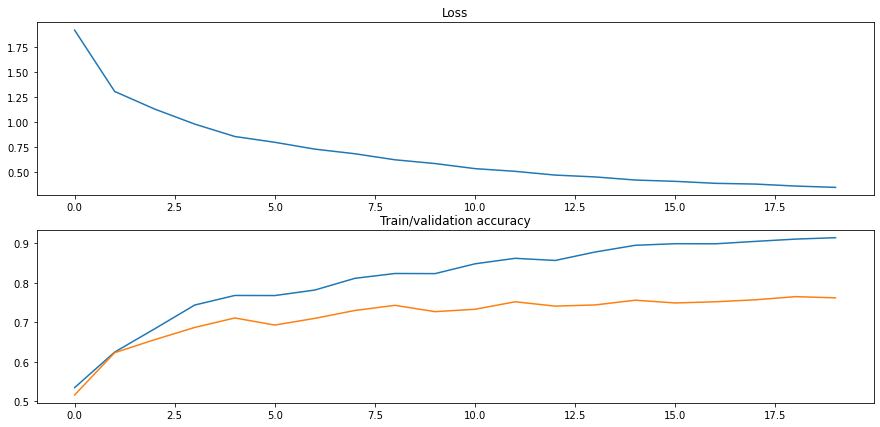

In [20]:
plt.figure(figsize=(15, 7))
plt.subplot(211)
plt.title("Loss")
plt.plot(loss_history)
plt.subplot(212)
plt.title("Train/validation accuracy")
plt.plot(train_history)
plt.plot(val_history)

# Как обычно, посмотрим, как наша лучшая модель работает на тестовых данных

In [21]:
test_pred = best_classifier.predict(test_X)
test_accuracy = multiclass_accuracy(test_pred, test_y)
print('Neural net test set accuracy: %f' % (test_accuracy, ))

Neural net test set accuracy: 0.743000
